# E10s/Multi testing for Beta 54


## **NOTE: At the moment, Mac and Linux sample sizes are quite small as the cohorts still populate. Results for these OS's should not be used.**




   






In [1]:
## Hack to render links in code output.
from IPython.display import Markdown, display
def print_with_markdown(md_text):
    """ Print Markdown text so that it renders correctly in the cell output. """
    display(Markdown(md_text))

In [2]:
RANGE = "v20170514_20170521"
print_with_markdown("This covers data from the following range: {}".format(RANGE.strip('v')))

This covers data from the following range: 20170514_20170521

In [189]:
%%html
<button onClick=code_toggle()>Toggle Code</button>
<script>
    var code_show=true; //true -> hide code at first

    function code_toggle() {
        $('div.prompt').hide(); // always hide prompt

        if (code_show){
            $('div.input').hide();
        } else {
            $('div.input').show();
        }
        code_show = !code_show
    }
    $( document ).ready(code_toggle);
</script>

In [132]:
from __future__ import division

import ujson as json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
#from colour import Color
import math
import plotly.plotly as py
import IPython
import pyspark.sql.functions as fun
import pyspark.sql.types as st
from pyspark.sql import Row
from collections import Counter, defaultdict

from moztelemetry.spark import get_pings, get_one_ping_per_client, get_pings_properties
from montecarlino import grouped_permutation_test

IPython.core.pylabtools.figsize(16, 7)
sns.set_style('whitegrid')
sc.setLogLevel('INFO')

from operator import add
pd.set_option("display.max_rows", None)

def get_active_addon_info(addons_str):
    """ Return a list of currently enabled add-ons in the form (GUID, name, version, isSystem). """
    addons = json.loads(addons_str)
    addons = addons.get("activeAddons", {})
    if not addons:
        return []
    return [(guid, meta.get("name"), meta.get("isSystem"), meta.get('isWebExtension'), meta.get('version')) for guid, meta in addons.iteritems()]

def get_top_addons(df, cohort_filter, n_top=100):
    cohort_num, cohort_table = dataset_installed_addons(
        df.filter(cohort_filter),
        n_top=n_top)
    print("There were {:,} distinct add-ons installed across the '{}' cohort."\
          .format(cohort_num, cohort_filter))

    cohort_table["n_installs"] = cohort_table["n_installs"]
    cohort_table["pct_installed"] = cohort_table["pct_installed"]
    return cohort_table


def dataset_installed_addons(data, n_top=100):
    """ Extract add-on info from a subset of the main dataset, and generate a table of top add-ons
        with installation counts.
        
        Returns a Pandas DataFrame.
    """
    data_addons = data.select("addons").rdd.map(lambda row: row["addons"])
    data_addons.cache()
    n_in_data = data_addons.count()
    
    ##  Get counts by add-on ID/name/isSystem value.
    addon_counts = data_addons.flatMap(get_active_addon_info)\
        .map(lambda a: (a, 1))\
        .reduceByKey(add)\
        .map(lambda ((guid, name, sys, we, version), n): (guid, (name, sys, version, n)))
    
    ## Summarize using the most common name and isSystem value.
    top_vals = addon_counts.reduceByKey(lambda a, b: a if a[-1] > b[-1] else b)\
        .map(lambda (guid, (name, sys, we, version, n)): (guid, (name, sys, version)))
    n_installs = addon_counts.mapValues(lambda (name, sys, version, we, n): n)\
        .reduceByKey(add)
    addon_info = top_vals.join(n_installs)\
        .map(lambda (guid, ((name, sys, we, version), n)): {
                "guid": guid,
                "name": name,
                "is_system": sys,
                "is_webextension": we,
                "version":version,
                "n_installs": n,
                "pct_installed": n / n_in_data * 100
            })\
        .sortBy(lambda info: info["n_installs"], ascending=False)
    
    addon_info_coll = addon_info.collect() if not n_top else addon_info.take(n_top)
    addon_info_table = pd.DataFrame(addon_info_coll)
    addon_info_table = addon_info_table[["guid", "name", "version","is_system", "is_webextension", "n_installs", "pct_installed"]]
    ## Number rows from 1.
    addon_info_table.index += 1
    n_addons = addon_info.count()
    data_addons.unpersist()
    return (n_addons, addon_info_table)

def chi2_distance(xs, ys, eps = 1e-10, normalize = True):
    """ The comparison metric for histograms. """
    histA = xs.sum(axis=0)
    histB = ys.sum(axis=0)
    
    if normalize:
        histA = histA/histA.sum()
        histB = histB/histB.sum()
    
    d = 0.5 * np.sum([((a - b) ** 2) / (a + b + eps)
        for (a, b) in zip(histA, histB)])

    return d

def median_diff(xs, ys):
    return np.median(xs) - np.median(ys)

def median(lst, n):
    # take average of middle two numbers if even
    cut = int(np.ceil(n/2))
    return (lst[cut-1] + lst[cut]) / 2 if n % 2 == 0 else lst[cut-1]

def make_group_histogram(group_data):
    """ Combine separate client histograms into a single group histogram, normalizing bin counts
        to relative frequencies.       
    """
    N = len(group_data)
    def median(lst, n):
        # take average of middle two numbers if even
        cut = int(np.ceil(n/2))
        return (lst[cut-1] + lst[cut]) / 2 if n % 2 == 0 else lst[cut-1]
            
    ## Check for histograms with 0 counts.
    client_totals = group_data.map(lambda x: x.sum())
    group_data = group_data[client_totals > 0]
    raw_counts = group_data.sum()
    
    # compute median
    n = raw_counts.sum()
    acc = -0.001
    curr_dec = 0
    deciles = []
    dec = 0
    for i, j in raw_counts.iteritems():
        acc += j
        while acc >= curr_dec:
            deciles.append(i)
            dec+=.1
            curr_dec = n*dec
                
    ## Convert frequency counts to relative frequency for each client histogram.
    group_data = group_data.map(lambda x: x/x.sum())
    ## Merge the group's client histograms by adding up the frequencies over all clients
    ## in the group, separately for each bin.
    group_data = group_data.sum()
    ## Convert the merged bin frequencies to relative percentages.
    group_data= 100 * group_data / group_data.sum()
    return group_data, deciles, N

def plot_hists(histogram, g1, g2, g3, ret):
    for comparison in [g1, g2, g3]:

            fig = plt.figure()
            ax = fig.add_subplot(1, 1, 1)

            fig.subplots_adjust(hspace=0.3)
            ax2 = ax.twinx()
            width = 0.4
            ylim = max(g1[0].max(), g1[1].max())
            m1, m4, o1, o4, n, hist_desc = comparison
            print hist_desc
            m1.plot(kind="bar", alpha=0.5, color="green", label="Multi 1", ax=ax, width=width,
                        position=1, ylim=(0, ylim + 1))
            m4.plot(kind="bar", alpha=0.5, color="blue", label="Multi 4", ax=ax2, width=width,
                        position=0, grid=False, ylim=ax.get_ylim())

            ## Combine legend info from both Axes.
            ax_h, ax_l = ax.get_legend_handles_labels()
            ax2_h, ax2_l = ax2.get_legend_handles_labels()
            ax.legend(ax_h + ax2_h, ax_l + ax2_l, loc = 0)

            ax.xaxis.grid(False)
            ax.set_ylabel("Frequency %")
             # Only display at most 100 tick labels on the x axis.
            xticklabs = plt.gca().get_xticklabels()
            max_x_ticks = 100
            if len(xticklabs) > max_x_ticks:
                step_size = math.ceil(float(len(xticklabs)) / max_x_ticks)
                for i, tl in enumerate(xticklabs):
                    if i % step_size != 0:
                        tl.set_visible(False)
            ## Compute a p-value for the chi-square distance between the groups' combined histograms.
            pvalue = grouped_permutation_test(chi2_distance, [o1, o4], num_samples=500)
            if "pvalue_14" not in ret:
                ret["pvalue_14"] = pvalue
            elif "pvalue_14_std" not in ret:
                ret["pvalue_14_std"] = pvalue
            else:
                ret["pvalue_14_mpc"] = pvalue
                
            print_with_markdown("""---\n#### {} {}\nProbability the two histograms differ by chance is
            <span style="color:{}"><b>{:.3f}</b>.</span>
            """.format(histogram, hist_desc ,"red" if pvalue <= .05 else "green", pvalue))
            
            
            xticks, xticklabels = plt.xticks()
            # shift half a step to the left
            # x0 - (x1 - x0) / 2 = (3 * x0 - x1) / 2
            xmin = (3*xticks[0] - xticks[1])/2.
            # shaft half a step to the right
            xmax = (3*xticks[-1] - xticks[-2])/2.
            plt.xlim(xmin, xmax)
            plt.xticks(xticks)
            plt.show()
            return ret

def compare_histogram(histogram, webext_multi_1, webext_multi_4, multi_1=None, multi_4=None,
                      mpc1=None, mpc4=None, include_diff=False, include_diff_in_diff=False, did_separate_plot=False):
    """ Compare an e10s histogram to a non-e10s one, and graph the results.
        
        Plots the two histograms overlaid on the same graph, and prints a p-value
        for testing whether they are different. If 'include_diff' is True, also
        draw a plot of the frequency differences for each bin.
        
        If 'include_diff_in_diff' is True and data is supplied, include a plot of
        differences between addon cohort differences and non-addon cohort differences.
    """
    multi_1_total, dec1, n1 = make_group_histogram(webext_multi_1)
    multi_4_total, dec4, n4 = make_group_histogram(webext_multi_4)
    multi_1_total_std, dec_std1, n1_std = make_group_histogram(multi_1)
    multi_4_total_std, dec_std4, n4_std = make_group_histogram(multi_4)
    mpc_1_total, dec_mpc1, n1_mpc = make_group_histogram(mpc1)
    mpc_4_total, dec_mpc4, n4_mpc = make_group_histogram(mpc4)
    
    ret = {
            "dec_1": dec1,
            "dec_4": dec4,
            "n_1": n1,
            "n_4": n4,
            'dec_1_std': dec_std1,
            'dec_4_std': dec_std4,
            'n_1_std': n1_std,
            'n_4_std': n4_std,
            'dec_1_mpc': dec_mpc1,
            'dec_4_mpc': dec_mpc4,
            'n_1_mpc': n1_mpc,
            'n_4_mpc': n4_mpc
          }
    
    if include_diff:
        if include_diff_in_diff and did_separate_plot:
            fig, (ax, diff_ax, diff_diff_ax) = plt.subplots(3, sharex=True, figsize=(16,10), 
                                                            gridspec_kw={"height_ratios": [2,2,1]})
        else:
            fig, (ax, diff_ax) = plt.subplots(2, sharex=True)
    else:
        for comparison in [[multi_1_total, multi_4_total, webext_multi_1, webext_multi_4, n1, 'With WebExtensions'],
                           [multi_1_total_std, multi_4_total_std, multi_1, multi_4, n1_std, "Without WebExtensions"],
                           [mpc_1_total, mpc_4_total, mpc1, mpc4, n1_mpc, "MPC=True Addons"]]:

            fig = plt.figure()
            ax = fig.add_subplot(1, 1, 1)

            fig.subplots_adjust(hspace=0.3)
            ax2 = ax.twinx()
            width = 0.4
            ylim = max(multi_1_total.max(), multi_4_total.max())
            m1, m4, o1, o4, n, hist_desc = comparison
            m1.plot(kind="bar", alpha=0.5, color="green", label="Multi 1", ax=ax, width=width,
                        position=1, ylim=(0, ylim + 1))
            m4.plot(kind="bar", alpha=0.5, color="blue", label="Multi 4", ax=ax2, width=width,
                        position=0, grid=False, ylim=ax.get_ylim())

            ## Combine legend info from both Axes.
            ax_h, ax_l = ax.get_legend_handles_labels()
            ax2_h, ax2_l = ax2.get_legend_handles_labels()
            ax.legend(ax_h + ax2_h, ax_l + ax2_l, loc = 0)

            ax.xaxis.grid(False)
            ax.set_ylabel("Frequency %")
             # Only display at most 100 tick labels on the x axis.
            xticklabs = plt.gca().get_xticklabels()
            max_x_ticks = 100
            if len(xticklabs) > max_x_ticks:
                step_size = math.ceil(float(len(xticklabs)) / max_x_ticks)
                for i, tl in enumerate(xticklabs):
                    if i % step_size != 0:
                        tl.set_visible(False)
            ## Compute a p-value for the chi-square distance between the groups' combined histograms.
            pvalue = grouped_permutation_test(chi2_distance, [o1, o4], num_samples=500)
            if "pvalue_14" not in ret:
                ret["pvalue_14"] = pvalue
            elif "pvalue_14_std" not in ret:
                ret["pvalue_14_std"] = pvalue
            else:
                ret["pvalue_14_mpc"] = pvalue
                
            print_with_markdown("""---\n#### {} {}\nProbability the two histograms differ by chance is
            <span style="color:{}"><b>{:.3f}</b>.</span>
            """.format(histogram, hist_desc ,"red" if pvalue <= .05 else "green", pvalue))
            
            
            xticks, xticklabels = plt.xticks()
            # shift half a step to the left
            # x0 - (x1 - x0) / 2 = (3 * x0 - x1) / 2
            xmin = (3*xticks[0] - xticks[1])/2.
            # shaft half a step to the right
            xmax = (3*xticks[-1] - xticks[-2])/2.
            plt.xlim(xmin, xmax)
            plt.xticks(xticks)
            plt.show()
        

#     if include_diff:
#         ## Add a second barplot of the difference in frequency for each bucket.
#         #diff_ax = fig.add_subplot(2, 1, 2)
#         enDiff = multi_1_total - multi_4_total
        
#         has_diff_in_diff_data = (multi_1 is not None and len(multi_1) > 0 and
#                                  multi_4 is not None and len(multi_4) > 0)
#         if include_diff_in_diff and has_diff_in_diff_data:
#             ## Add bin differences for between e10s/non-e10s for the no-addons cohorts.
#             ## The assumption is that the difference between addons cohorts would look the same
#             ## if there is no additional effect of having addons.
#             multi_1_total_std, dec_std1, n1_std = make_group_histogram(multi_1)
#             multi_4_total_std, dec_std4, n4_std = make_group_histogram(multi_4)
#             enDiff_std = multi_1_total_std - multi_4_total_std
#             ylims = (min(enDiff.min(), enDiff_std.min()) - 0.5, max(enDiff.max(), enDiff_std.max()) + 0.5)
#             diff_ax2 = diff_ax.twinx()
            
#             enDiff.plot(kind="bar", alpha=0.5, color="navy", label="WebExtensions", ax=diff_ax, width=width,
#                         position=1, ylim=ylims)
#             enDiff_std.plot(kind="bar", alpha=0.5, color="gray", label="no WebExtensions", ax=diff_ax2, width=width,
#                         position=0, grid=False, ylim=diff_ax.get_ylim())

#             ## Combine legend info from both Axes.
#             diff_ax_h, diff_ax_l = diff_ax.get_legend_handles_labels()
#             diff_ax2_h, diff_ax2_l = diff_ax2.get_legend_handles_labels()
#             leg_h = diff_ax_h + diff_ax2_h
#             leg_l = diff_ax_l + diff_ax2_l
            
#             if did_separate_plot:
#                 enDiffDiff = enDiff - enDiff_std
#                 enDiffDiff.plot(kind="bar", alpha=0.5, color="maroon", ax=diff_diff_ax, ylim=diff_ax.get_ylim())
#                 diff_diff_ax.xaxis.grid(False)
#                 diff_diff_ax.set_ylabel("Diff in freq %")
#                 diff_diff_ax.set_title("Diff between multi 1/4 with webextensions and multi 1/4 diff without webextensions" +
#                                       " (with webextensions higher when > 0)")
            
#         else:
#             if include_diff_in_diff:
#                 ## We wanted to do the additional comparison, but there wasn't enough data.
#                 print("\nNo diff-in-diff comparison: one of the standard cohorts has no non-missing observations.")
#             enDiff.plot(kind="bar", alpha=0.5, color="navy", label="WebExtensions", ax=diff_ax)
#             leg_h, leg_l = diff_ax.get_legend_handles_labels()
        
#         plt.title("multi1/multi4 difference (more multi1 in bucket when > 0)")
#         diff_ax.xaxis.grid(False)
#         diff_ax.set_ylabel("Diff in frequency %")
#         diff_ax.legend(leg_h, leg_l, loc = 0)
    
    
   

    
   
        
           
#     if include_diff_in_diff:
#         pvalue_std = grouped_permutation_test(chi2_distance, [multi_1, multi_4], num_samples=1000)
#         print("The probability that the distributions for {} (without webextensions)\nare differing by chance is {:.3f}."\
#           .format(histogram, pvalue_std))
        
    return ret

def normalize_uptime_hour(frame):
    """ Convert metrics to rates per hour of uptime. """
    frame = frame[frame["payload/simpleMeasurements/totalTime"] > 60]
    removed_os = False
    os = None
    try:
        os = frame["system/os/name"]
        frame = frame.drop("system/os/name", axis=1)
        removed_os = True
    except:
        pass
    
    frame = 60 * 60 * frame.apply(lambda x: x / frame["payload/simpleMeasurements/totalTime"]) # Metric per hour
    frame.drop('payload/simpleMeasurements/totalTime', axis=1, inplace=True)
    if removed_os:
        frame["system/os/name"] = os
    return frame
    
def compare_e10s_count_histograms(pings, cohort_sizes = {}, *histogram_names, **kwargs):
    """ Read multiple count histograms from a collection of pings, and compare e10s/non-e10s for each.
    
        Treats count histograms as scalars for comparison purposes, without distinguishing between
        parent and child processes. Expects a dict containing overall cohort sizes
        for computing sample size proportions.
    """
    properties = histogram_names + ("payload/simpleMeasurements/totalTime", "cohort", "system/os/name")
    frame = pd.DataFrame(get_pings_properties(pings, properties).collect())
    
    ret = defaultdict(dict)
    for os in ("Windows_NT", "Darwin"):
        print_with_markdown("---")
        print_with_markdown("# {}".format(os))
        frame_os = frame[frame['system/os/name'] == os]
        # multi with webextensions
        we_multi1 = normalize_uptime_hour(
                frame_os[frame_os.cohort=="webextensions-multiBucket1"].drop("cohort",axis=1))
        we_multi4 = normalize_uptime_hour(
            frame_os[frame_os.cohort=="webextensions-multiBucket4"].drop("cohort", axis=1))

    
        include_diff_in_diff = kwargs.get("include_diff_in_diff", True)
        if include_diff_in_diff:
            multi1 = normalize_uptime_hour(frame_os[frame_os.cohort=="multiBucket1"].drop("cohort", axis=1))
            multi4 = normalize_uptime_hour(frame_os[frame_os.cohort=="multiBucket4"].drop("cohort", axis=1))     

        for histogram in histogram_names:
            if histogram not in multi1.columns:
                continue

            ## Remove the property path from the histogram name for display purposes.
            hist_name = hist_base_name(histogram)
            if type(hist_name) == list:
                ## Key was given for keyed histogram.
                hist_str = "{}/{}".format(link_to_histogram(hist_name[0]), hist_name[1])
                hist_name = hist_name[0]
            else:
                hist_str = hist_name
            ## Print a header for the block of graphs, including a link to the histogram definition.
            print_with_markdown("Comparison for count histogram {}:".format(hist_str))

            we_multi1_hist = we_multi1[[histogram, 'system/os/name']].dropna()
            we_multi4_hist = we_multi4[[histogram, 'system/os/name']].dropna()

            ## Print some information on sample sizes.
            print("{} Multi 4 profiles (with webextenisons) have this histogram.".format(
                    sample_size_str(len(we_multi4_hist), cohort_sizes.get(WEBEXTENSION_MULTI_4))))
            print("{} Multi 1 profiles (with webextensions) have this histogram.".format(
                    sample_size_str(len(we_multi1_hist), cohort_sizes.get(WEBEXTENSION_MULTI_1))))
            ## If either group has no data, nothing more to do.
            if len(we_multi4_hist) == 0 or len(we_multi1_hist) == 0:
                continue

            print("")
            hist_name = histogram.split('/')[-1]
            ret[os][hist_name] =  compare_scalars(hist_name + " per hour", we_multi1_hist, we_multi4_hist,
                            multi1[[histogram, 'system/os/name']].dropna() if include_diff_in_diff else None,
                            multi4[[histogram, 'system/os/name']].dropna() if include_diff_in_diff else None)
    return ret
 
def compare_e10s_histograms(pings, cohort_sizes = {}, *histogram_names, **kwargs):
    """ Read multiple histograms from a collection of pings, and compare multi1 /
        multi4 + webextenson / no webextension   for each.
    
        Outputs separate comparisons for parent process, child processes, and merged histograms.
        Expects a dict containing overall cohort sizes for computing sample
        size proportions.
    """
    ## Load histogram data from the ping set, separating parent & child processes for e10s.

    has_hist = lambda f, samp, suff: f([bool(samp[i + suff]) for i in ("multi_4", "multi_4", "webext_multi_1", "webext_multi_4")])

    frame = pd.DataFrame(get_pings_properties(pings, histogram_names + ("cohort", "has_webextension", "system/os/name"), 
                                              with_processes=True)\
        .collect())
    
    ret = defaultdict(dict)
    for os in ("Windows_NT", "Darwin"):
        print_with_markdown("# {}".format(os))
        frame_os = frame[frame['system/os/name'] == os]
        # multi with no webextenions
        multi1 = frame_os[frame_os.cohort==MULTI_1]
        multi4 = frame_os[frame_os.cohort==MULTI_4]
        # multi with webextensions
        we_multi1 = frame_os[frame_os.cohort==WEBEXTENSION_MULTI_1]
        we_multi4 = frame_os[frame_os.cohort==WEBEXTENSION_MULTI_4]
        #multi with MPC=true
        mpc_multi1 = frame_os[frame_os.cohort==MPC_BUCKET_1]
        mpc_multi4 = frame_os[frame_os.cohort==MPC_BUCKET_4]

        for histogram in histogram_names:
            if histogram not in we_multi1.columns:
                continue

            ## Remove the property path from the histogram name for display purposes.
            hist_name = hist_base_name(histogram)
            if type(hist_name) == list:
                ## Key was given for keyed histogram.
                hist_str = "{}/{}".format(link_to_histogram(hist_name[0]), hist_name[1])
                hist_name = hist_name[0]
            else:
                hist_str = hist_name
            ## Print a header for the block of graphs, including a link to the histogram definition.
            print_with_markdown("Comparison for {}:".format(hist_str))

            ## Compare main, parent and child histograms
            addons_hist_data = {
#                 "multi_1_merged": multi1[histogram],
#                 "multi_4_merged": multi4[histogram],
#                 "webext_multi_1_merged": we_multi1[histogram],
#                 "webext_multi_4_merged": we_multi4[histogram],
                "multi_1_parent": multi1[histogram + "_parent"],
                "multi_4_parent": multi4[histogram + "_parent"],
                "webext_multi_1_parent": we_multi1[histogram + "_parent"],
                "webext_multi_4_parent": we_multi4[histogram + "_parent"],
                "multi_1_child": multi1[histogram + "_children"],
                "multi_4_child": multi4[histogram + "_children"],
                "webext_multi_1_child": we_multi1[histogram + "_children"],
                "webext_multi_4_child": we_multi4[histogram + "_children"],
                "mpc_multi_1_parent": mpc_multi1[histogram + "_parent"],
                "mpc_multi_4_parent": mpc_multi4[histogram + "_parent"],
                "mpc_multi_1_child": mpc_multi1[histogram + "_children"],
                "mpc_multi_4_child": mpc_multi4[histogram + "_children"]

            }
            for htype in addons_hist_data:
                addons_hist_data[htype] = addons_hist_data[htype].dropna()

            ## Print some information on sample sizes.
            sample_sizes = { htype: len(hdata) for htype, hdata in addons_hist_data.iteritems() }
#             print("{} multi_1 profiles have this histogram.".format(
#                     sample_size_str(sample_sizes["multi_1_merged"], cohort_sizes.get(MULTI_1))))
#             print("{} multi_4 profiles have this histogram.".format(
#                     sample_size_str(sample_sizes["multi_4_merged"], cohort_sizes.get(MULTI_4))))
#             print("{} webext_multi_1 profiles have this histogram.".format(
#                     sample_size_str(sample_sizes["webext_multi_1_merged"], cohort_sizes.get(WEBEXTENSION_MULTI_1))))
#             print("{} webext_multi_4 profiles have this histogram.".format(
#                     sample_size_str(sample_sizes["webext_multi_4_merged"], cohort_sizes.get(WEBEXTENSION_MULTI_4))))

#             ## If either group has no data, nothing more to do.
#             if not has_hist(any, sample_sizes, "_merged"):
#                 print "No hists found"
#                 continue

            print("{} multi_1 profiles on {} have the parent histogram.".format(
                    sample_size_str(sample_sizes["multi_1_parent"], cohort_sizes.get(os + "_" + MULTI_1)), os))
            print("{} multi_4 profiles on {} have the parent histogram.".format(
                    sample_size_str(sample_sizes["multi_4_parent"], cohort_sizes.get(os + "_" + MULTI_4)), os))
            print("{} webext_multi_1 profiles on {} have the parent histogram.".format(
                    sample_size_str(sample_sizes["webext_multi_1_parent"], cohort_sizes.get(os + "_" + WEBEXTENSION_MULTI_1)), os))
            print("{} webextx_multi_4 profiles on {} have the parent histogram.".format(
                    sample_size_str(sample_sizes["webext_multi_4_parent"], cohort_sizes.get(os + "_" + WEBEXTENSION_MULTI_4)), os))
            
            print("{} mpc_multi_1 profiles on {} have the parent histogram.".format(
                    sample_size_str(sample_sizes["mpc_multi_1_parent"], cohort_sizes.get(os + "_" + MPC_BUCKET_1)), os))
            print("{} mpc_multi_4 profiles on {} have the parent histogram.".format(
                    sample_size_str(sample_sizes["mpc_multi_4_parent"], cohort_sizes.get(os + "_" + MPC_BUCKET_4)), os))

            print("{} multi_1 profiles on {} have the child histogram.".format(
                    sample_size_str(sample_sizes["multi_1_child"], cohort_sizes.get(os + "_" + MULTI_1)), os))
            print("{} multi_4 profiles on {} have the child histogram.".format(
                    sample_size_str(sample_sizes["multi_4_child"], cohort_sizes.get(os + "_" + MULTI_4)), os))
            print("{} webext_multi_1 profiles on {} have the child histogram.".format(
                    sample_size_str(sample_sizes["webext_multi_1_child"], cohort_sizes.get(os + "_" + WEBEXTENSION_MULTI_1)), os))
            print("{} webextx_multi_4 profiles on {} have the child histogram.".format(
                    sample_size_str(sample_sizes["webext_multi_4_child"], cohort_sizes.get(os + "_" + WEBEXTENSION_MULTI_4)), os))
            
            print("{} mpc_multi_1 profiles on {} have the child histogram.".format(
                    sample_size_str(sample_sizes["mpc_multi_1_child"], cohort_sizes.get(os + "_" + MPC_BUCKET_1)), os))
            print("{} mpc_multi_4 profiles on {} have the child histogram.".format(
                    sample_size_str(sample_sizes["mpc_multi_4_child"], cohort_sizes.get(os + "_" + MPC_BUCKET_4)), os))

            has_parents = has_hist(all, sample_sizes, "_parent")
            has_children = has_hist(all, sample_sizes, "_child")
    
            result = None

#             ## Compare merged histograms, groups have either no parents or children
#             if has_children and has_parents:
#                 result = compare_histogram(hist_name + " (merged)", 
#                                   addons_hist_data["webext_multi_1_merged"],
#                                   addons_hist_data["webext_multi_4_merged"],
#                                   addons_hist_data["multi_1_merged"],
#                                   addons_hist_data["multi_4_merged"],
#                                   **kwargs)
#                 ret[os][hist_name + " (merged)"] = result

            if has_parents:
                result = compare_histogram(hist_name + " (parent)",
                                  addons_hist_data["webext_multi_1_parent"],
                                  addons_hist_data["webext_multi_4_parent"],
                                  addons_hist_data["multi_1_parent"],
                                  addons_hist_data["multi_4_parent"],
                                  addons_hist_data["mpc_multi_1_parent"],
                                  addons_hist_data["mpc_multi_4_parent"],
                                  **kwargs)
                ret[os][hist_name + " (parent)"] = result

            if has_children:
                result = compare_histogram(hist_name + " (children)",
                                  addons_hist_data["webext_multi_1_child"],
                                  addons_hist_data["webext_multi_4_child"],
                                  addons_hist_data["multi_1_child"],
                                  addons_hist_data["multi_4_child"],
                                  addons_hist_data["mpc_multi_1_child"],
                                  addons_hist_data["mpc_multi_4_child"],
                                  **kwargs)
                ret[os][hist_name + " (child)"] = result
    return ret

def compare_scalars(metric, we_multi1, we_multi4, multi1=None, multi4=None, unit="units"):
    """ Prints info about the median difference between the groups, together with a p-value
        for testing the difference.
        
        Optionally include a string indicating the units the metric is measured in.
        If data is supplied, also print a comparison for non-addons cohorts.
    """
    def fix_nested_series(series):
        x = np.zeros(len(series.iloc[0]))
        for i in series:
            x += i
        return x
    
    ret = defaultdict(dict)
    col = we_multi1.columns[0]
    histogram = metric
    we_multi1 = we_multi1.dropna()[col]
    we_multi4 = we_multi4.dropna()[col]
    if len(we_multi1) == 0 or len(we_multi4) == 0:
        print("Cannot run comparison: one of the groups has no non-missing observations.")
        return
    print("Comparison for {}{} (with webextensions):\n".format(metric, " ({})".format(unit) if unit != "units" else ""))

    if type(we_multi1.iloc[0]) == pd.Series:
        we_multi1 = fix_nested_series(we_multi1)
    if type(we_multi4.iloc[0]) == pd.Series:
        we_multi4 = fix_nested_series(we_multi4)    

    we1_n = len(we_multi1[we_multi1 > 0])
    we4_n = len(we_multi4[we_multi4 > 0])

    we1_dec = np.percentile(we_multi1, np.arange(0, 100, 10))
    we4_dec = np.percentile(we_multi4, np.arange(0, 100, 10))


    mdiff = median_diff(we_multi1, we_multi4)

    print("- Median with 1 content process is {:.3g} {} {} median with 4 processes."\
         .format(
            #abs(mdiff),
            mdiff,
            unit,
            #"higher than" if mdiff >= 0 else "lower than"
            "different from"))
    print("- This is a relative difference of {:.1f}%.".format(float(mdiff) / we4_dec[5] * 100))
    print("- Multi 1 group median is {:.4g}, Multi 4 group median is {:.4g}.".format(we1_dec[5], we4_dec[5]))

    pvalue = grouped_permutation_test(median_diff, [we_multi1, we_multi4], num_samples=10000)
    print_with_markdown("""\n (with webextensions) The probability the two histograms differ by chance is
            <span style="color:{}"><b>{:.3f}</b>.</span>
            """.format("red" if pvalue <= .05 else "green", pvalue))

    mname = col.split("/")[-1] 
    ret = {
                    'dec_1': we1_dec,
                    'dec_4': we4_dec,
                    'n_1': we1_n,
                    'n_4': we4_n,
                    'pvalue_14': pvalue
                }



    if multi1 is not None and multi4 is not None:
        ## Include a comparison between non-addon cohorts.
        multi1_s = multi1.dropna()[col]
        multi4_s = multi4.dropna()[col]
        if len(multi1_s) > 0 and len(multi4_s) > 0:
            if type(multi1_s.iloc[0]) == pd.Series:
                multi1_s = fix_nested_series(multi1_s)
            if type(multi4_s.iloc[0]) == pd.Series:
                multi4_s = fix_nested_series(multi4_s)   

            m1_n = len(multi1_s[multi1_s > 0])
            m4_n= len(multi4_s[multi4_s > 0])

            m1_dec = np.percentile(multi1_s, np.arange(0, 100, 10))
            m4_dec = np.percentile(multi4_s, np.arange(0, 100, 10))
            
            mdiff_std = median_diff(multi1_s, multi4_s)
            print("\nFor cohorts with no webextensions, median with 1 content process is {:.3g} {} ({:.1f}%) {} median with 4 processes"\
                 .format(
                    #abs(mdiff_std),
                    mdiff_std,
                    unit,
                    float(mdiff_std) / m4_dec[5] * 100,
                    #"higher than" if mdiff_std >= 0 else "lower than"
                    "different from"))
            print("- This is a relative difference of {:.1f}%."\
                  .format(float(mdiff_std) / m4_dec[5] * 100))
            print("- Multi 1 group median is {:.4g}, Multi 4 group median is {:.4g}."\
                  .format(m1_dec[5], m4_dec[5]))

            pvalue_std = grouped_permutation_test(median_diff, [multi1_s, multi4_s], num_samples=10000)
        
            
            print_with_markdown("""(without WebExtensions) The probability the two histograms differ by chance is
            <span style="color:{}"><b>{:.3f}</b>.</span>
            """.format("red" if pvalue_std <= .05 else "green", pvalue_std))

            ret["dec_1_std"] = m1_dec
            ret["dec_4_std"] = m4_dec
            ret["n_1_std"] = m1_n
            ret["n_4_std"] = m4_n
            ret["pvalue_14_std"] = pvalue_std
            
    return ret
                



    
def link_to_histogram(hist_name):
    """ Create a link to the histogram definition in Markdown. """
    return "[{}](https://dxr.mozilla.org/mozilla-central/search?q={}+file%3AHistograms.json&redirect=true)"\
            .format(hist_name, hist_name)

def hist_base_name(path_to_histogram):
    """ Remove any path components from histogram name.
    
        If histogram is specified as a path in the payload, with separator '/',
        remove everything but the last component (the actual name).
        However, if the histogram is keyed, and specified with a key, return
        [histname, key].
    """
    path_to_histogram = path_to_histogram.rsplit("/")
    if len(path_to_histogram) > 1 and path_to_histogram[-3] == "keyedHistograms":
        ## There was a keyedHistogram name and key given.
        return path_to_histogram[-2:]
    return path_to_histogram[-1]


def sample_size_str(sample_size, cohort_size=None):
    """ Convert a sample size to a string representation, including a percentage if available. """
    if sample_size == 0:
        return "No"
    if cohort_size:
        if sample_size == cohort_size:
            return "All"
        return "{} ({:.1f}%)".format(sample_size, float(sample_size) / cohort_size * 100)
    return str(sample_size)

def get_cohort_dist(dataset):
    cohort_counts = dataset.groupby("e10sCohort").count().collect()
    dataset_count = sum(map(lambda r: r["count"], cohort_counts))

    def cohort_proportions(r):
        prop = r["count"] * 100.0 / dataset_count
        return (r["e10sCohort"], r["count"], "{:.2f}%".format(prop))

    print("\nTotal number of clients: {:,}".format(dataset_count))

    d = pd.DataFrame(sorted(map(cohort_proportions, cohort_counts), key = lambda r: r[0]))
    d.columns = ['cohort', 'count', 'pct']
    return d


The derived dataset is computed from profiles on Beta 54 who belong to the {webextensions-}multiBucket{1, 4} e10s Cohorts. It contains a single record (ping) per client, which is randomly selected from among the client's pings during the date range.

In [4]:
# regenerated data and loaded into telemetry-test-bucket
dataset = sqlContext.read.parquet(
    "s3://telemetry-parquet/e10s_experiment_view/multi_webExtensions_beta54_cohorts/{}/".format(RANGE))
# dataset.printSchema()

How many records are in the overall dataset?

In [5]:
dataset.count()

3075023

What are the cohorts, and how many clients do we have in each cohort?

In [6]:
get_cohort_dist(dataset)


Total number of clients: 3,075,023


cohort    count     pct
0        addons-set50allmpc-control    16021   0.52%
1   addons-set50allmpc-multiBucket1    37935   1.23%
2   addons-set50allmpc-multiBucket2      621   0.02%
3   addons-set50allmpc-multiBucket4    37996   1.24%
4   addons-set50allmpc-multiBucket8      576   0.02%
5           addons-set50allmpc-test    69103   2.25%
6     addons-set51alladdons-control       15   0.00%
7        addons-set51alladdons-test        7   0.00%
8             addons-set51set1-test       10   0.00%
9               addons-setesrA-test        1   0.00%
10                          control    90775   2.95%
11                     disqualified        7   0.00%
12             disqualified-control   115715   3.76%
13        disqualified-multiBucket1     1556   0.05%
14        disqualified-multiBucket2     1551   0.05%
15        disqualified-multiBucket4     1535   0.05%
16        disqualified-multiBucket8     1496   0.05%
17                disqualified-test  1021979  33.23%
18                     multiBucket1   710485  23.11%
19                     multiBucket2    21098   0.69%
20                     multiBucket4   711120  23.13%
21                     multiBucket8    20994   0.68%
22                          optedIn     2291   0.07%
23                         optedOut    15535   0.51%
24             temp-disqualified-ru        1   0.00%
25          temp-qualified-devtools   102840   3.34%
26                             test     3137   0.10%
27                          unknown     3696   0.12%
28               unsupportedChannel      104   0.00%
29       webextensions-multiBucket1    43678   1.42%
30       webextensions-multiBucket4    43145   1.40%

In [7]:
WEBEXTENSION_MULTI_1 = u'webextensions-multiBucket1'
WEBEXTENSION_MULTI_4 = u'webextensions-multiBucket4'
MULTI_1 = u'multiBucket1'
MULTI_4 = u'multiBucket4'
MPC_BUCKET_1 = u"addons-set50allmpc-multiBucket1"
MPC_BUCKET_4 = u"addons-set50allmpc-multiBucket4"

Restrict to pings belonging to the Multi-WebExtensions experiment.

In [8]:
webext_exp_dataset = dataset.filter(\
"e10sCohort in ('%s','%s', '%s', '%s', '%s', '%s')" % (WEBEXTENSION_MULTI_1,
                                           WEBEXTENSION_MULTI_4,
                                           MULTI_1,
                                           MULTI_4, 
                                           MPC_BUCKET_1,
                                           MPC_BUCKET_4))

How many clients are left?

In [9]:
webext_exp_dataset.count()

1584359

We want to make sure that the pings tagged into the cohorts satisfy the basic assumptions of the experiment, as this not guaranteed. Both webextensions-multiBucket{1, 4} cohorts should have only WebExtension add-ons, and both multiBucket{1, 4} cohorts should have no add-ons. All profiles should have e10s enabled.

In [11]:
def e10s_status_check(settings, addons):
    """ 
    Check that multiBucket cohorts have no (non-system) add-ons, 
    and that webextensions-multiBucket cohorts have only webextensions
    (system add-ons are ok). All cohorts should have e10s on
        
    """
    e10sEnabled = bool(json.loads(settings).get("e10sEnabled"))
    aa = json.loads(addons).get("activeAddons")
    
    # check if all addons (that are non-system) are webextensions
    webext_status = [aa[i].get('isWebExtension', False) for i in aa \
                    if not aa[i].get('isSystem', False)] if aa else []
    onlyWebExtension = all(webext_status) if len(webext_status) > 0 else False
    anyWebExtension = any(webext_status) if len(webext_status) > 0 else False
    
    return Row(
        e10s_enabled = e10sEnabled,
        only_webextension = onlyWebExtension,
        any_webextension = anyWebExtension
   )

def bad_ping(cohort, settings, addons):
    """ e10s should be enabled iff the profile is in the test cohort, and profiles should have active add-ons
        if they are in the addons cohorts. 
    """
    check_data = e10s_status_check(settings, addons)
    # must have e10s
    is_bad = not check_data.e10s_enabled
    if cohort.startswith("webextensions"):
        is_bad = is_bad or not check_data.only_webextension
    elif cohort.startswith("addons"):
        is_bad = is_bad or check_data.any_webextension
    return is_bad

## Add a Column to the DF with the outcome of the check.
## This will be used to remove any bad rows after examining them.
from pyspark.sql.types import BooleanType

status_check_udf = fun.udf(bad_ping, BooleanType())

webext_exp_dataset_check = webext_exp_dataset.withColumn("badPing",
    status_check_udf(webext_exp_dataset.e10sCohort, 
                     webext_exp_dataset.settings, 
                     webext_exp_dataset.addons))

If there are any bad pings, describe the problems and remove them from the dataset.

In [12]:
webext_exp_dataset_bad = webext_exp_dataset_check.filter("badPing")\
    .select("e10sCohort", "settings", "addons")\
    .rdd

has_bad = not webext_exp_dataset_bad.isEmpty()

In [13]:
if not has_bad:
    print("No issues")
else:
    check_counts = webext_exp_dataset_bad\
        .map(lambda r: (r.e10sCohort, e10s_status_check(r.settings, r.addons)))\
        .countByValue()
    print("Issues:")
    for k, v in check_counts.iteritems():
        print("{}: {}".format(k, v))

Issues:
(u'multiBucket4', Row(any_webextension=False, e10s_enabled=False, only_webextension=False)): 27284
(u'multiBucket4', Row(any_webextension=True, e10s_enabled=False, only_webextension=True)): 221
(u'addons-set50allmpc-multiBucket1', Row(any_webextension=True, e10s_enabled=False, only_webextension=False)): 73
(u'webextensions-multiBucket1', Row(any_webextension=True, e10s_enabled=False, only_webextension=True)): 500
(u'addons-set50allmpc-multiBucket4', Row(any_webextension=True, e10s_enabled=True, only_webextension=False)): 7404
(u'addons-set50allmpc-multiBucket4', Row(any_webextension=True, e10s_enabled=False, only_webextension=False)): 67
(u'addons-set50allmpc-multiBucket4', Row(any_webextension=False, e10s_enabled=False, only_webextension=False)): 361
(u'addons-set50allmpc-multiBucket1', Row(any_webextension=True, e10s_enabled=True, only_webextension=True)): 20
(u'webextensions-multiBucket4', Row(any_webextension=False, e10s_enabled=False, only_webextension=False)): 24
(u'webex

In [52]:
if has_bad:
    webext_exp_dataset = webext_exp_dataset_check.filter("not badPing").drop("badPing")
    print_with_markdown("\nRemoving these pings from the dataset. The dataset now contains {} clients".format(webext_exp_dataset.count()))


Removing these pings from the dataset. The dataset now contains 1509012 clients

In [54]:
def parse_os(s):
    sys_field = json.loads(s)
    return sys_field.get("os", {}).get("name")

parse_os = fun.udf(parse_os, st.StringType())
webext_exp_dataset = webext_exp_dataset.withColumn('os_e10sCohort', 
                                                   fun.concat(parse_os('system'), fun.lit('_'), "e10sCohort"))

Filter out clients with Windows XP. At this point, how many clients are left in each cohort by OS?

In [55]:
def notxp(p):
    s_os = json.loads(p).get('os', {})
    name = s_os.get('name')
    version = s_os.get('version')
    return name != "Windows_NT" or version != "5.1"

notxp = fun.udf(notxp, st.BooleanType())
webext_exp_dataset = webext_exp_dataset.filter(notxp('system'))

cohort_sizes_row = webext_exp_dataset.groupBy(['os_e10sCohort']).count().collect()
cohort_sizes = {}
for i in cohort_sizes_row:
    cohort_sizes[i.os_e10sCohort] = i['count']
cohort_sizes

{u'Darwin_addons-set50allmpc-multiBucket1': 454,
 u'Darwin_addons-set50allmpc-multiBucket4': 419,
 u'Darwin_multiBucket1': 3957,
 u'Darwin_multiBucket4': 3962,
 u'Darwin_webextensions-multiBucket1': 240,
 u'Darwin_webextensions-multiBucket4': 239,
 u'Linux_addons-set50allmpc-multiBucket1': 31,
 u'Linux_addons-set50allmpc-multiBucket4': 29,
 u'Linux_multiBucket1': 130,
 u'Linux_multiBucket4': 131,
 u'Linux_webextensions-multiBucket1': 5,
 u'Linux_webextensions-multiBucket4': 7,
 u'Windows_NT_addons-set50allmpc-multiBucket1': 29611,
 u'Windows_NT_addons-set50allmpc-multiBucket4': 29692,
 u'Windows_NT_multiBucket1': 678460,
 u'Windows_NT_multiBucket4': 679210,
 u'Windows_NT_webextensions-multiBucket1': 41311,
 u'Windows_NT_webextensions-multiBucket4': 40815}

In [56]:

sampling_props = {}

for i in cohort_sizes:
    if "Linux" in i or "Darwin" in i or "webextension" in i or "addons" in i:
        sampling_props[i] = 1
    else:
        # roughly matches webextension bucket size for windows
        sampling_props[i] = .06
        
print_with_markdown("Sampling with the following proportions:\n")
sampling_props

Sampling with the following proportions:


{u'Darwin_addons-set50allmpc-multiBucket1': 1,
 u'Darwin_addons-set50allmpc-multiBucket4': 1,
 u'Darwin_multiBucket1': 1,
 u'Darwin_multiBucket4': 1,
 u'Darwin_webextensions-multiBucket1': 1,
 u'Darwin_webextensions-multiBucket4': 1,
 u'Linux_addons-set50allmpc-multiBucket1': 1,
 u'Linux_addons-set50allmpc-multiBucket4': 1,
 u'Linux_multiBucket1': 1,
 u'Linux_multiBucket4': 1,
 u'Linux_webextensions-multiBucket1': 1,
 u'Linux_webextensions-multiBucket4': 1,
 u'Windows_NT_addons-set50allmpc-multiBucket1': 1,
 u'Windows_NT_addons-set50allmpc-multiBucket4': 1,
 u'Windows_NT_multiBucket1': 0.06,
 u'Windows_NT_multiBucket4': 0.06,
 u'Windows_NT_webextensions-multiBucket1': 1,
 u'Windows_NT_webextensions-multiBucket4': 1}

In [57]:
webext_exp_dataset = webext_exp_dataset.sampleBy('os_e10sCohort', sampling_props)
print_with_markdown('\nWe now have the the following number of clients per cohort: (approximately)')

e10s_addon_cohort_sizes = {}
for cohort in sampling_props:
    e10s_addon_cohort_sizes[cohort] = cohort_sizes[cohort] * sampling_props[cohort]

e10s_addon_cohort_sizes


We now have the the following number of clients per cohort: (approximately)

{u'Darwin_addons-set50allmpc-multiBucket1': 454.0,
 u'Darwin_addons-set50allmpc-multiBucket4': 419.0,
 u'Darwin_multiBucket1': 3957.0,
 u'Darwin_multiBucket4': 3962.0,
 u'Darwin_webextensions-multiBucket1': 240.0,
 u'Darwin_webextensions-multiBucket4': 239.0,
 u'Linux_addons-set50allmpc-multiBucket1': 31.0,
 u'Linux_addons-set50allmpc-multiBucket4': 29.0,
 u'Linux_multiBucket1': 130.0,
 u'Linux_multiBucket4': 131.0,
 u'Linux_webextensions-multiBucket1': 5.0,
 u'Linux_webextensions-multiBucket4': 7.0,
 u'Windows_NT_addons-set50allmpc-multiBucket1': 29611.0,
 u'Windows_NT_addons-set50allmpc-multiBucket4': 29692.0,
 u'Windows_NT_multiBucket1': 40707.6,
 u'Windows_NT_multiBucket4': 40752.6,
 u'Windows_NT_webextensions-multiBucket1': 41311.0,
 u'Windows_NT_webextensions-multiBucket4': 40815.0}

In [58]:
webext_exp_dataset.groupBy('e10sCohort').count().collect()

[Row(e10sCohort=u'addons-set50allmpc-multiBucket1', count=30096),
 Row(e10sCohort=u'multiBucket4', count=44904),
 Row(e10sCohort=u'webextensions-multiBucket4', count=41061),
 Row(e10sCohort=u'webextensions-multiBucket1', count=41556),
 Row(e10sCohort=u'multiBucket1', count=44786),
 Row(e10sCohort=u'addons-set50allmpc-multiBucket4', count=30140)]

In [59]:
# get engagement metrics
start, end = RANGE.strip('v').split('_')
ms = sqlContext.read.option("mergeSchema", True).parquet("s3://telemetry-parquet/main_summary/v4")\
 .filter("submission_date_s3 >= '{}'".format(start))\
 .filter("submission_date_s3 <= '{}'".format(end)) \
 .filter("app_name = 'Firefox'")\
 .filter("normalized_channel = 'beta'")\
 .filter("app_version = '54.0'")
 


In [60]:
ms_tabs = ms.select(['client_id','sample_id', 'scalar_parent_browser_engagement_max_concurrent_tab_count']) \
            .groupBy(['client_id', 'sample_id']).mean('scalar_parent_browser_engagement_max_concurrent_tab_count')\
            .withColumnRenamed("avg(scalar_parent_browser_engagement_max_concurrent_tab_count)", "mean_max_tabs")\
            .withColumnRenamed("client_id", "clientId")\
            .withColumnRenamed("sample_id", "sampleId")

In [61]:
joined = webext_exp_dataset.join(ms_tabs, ['sampleId', 'clientId'])

In [62]:
def get_active_addon_info(addons_str):
    """ Return a list of currently enabled add-ons in the form (GUID, name, version, isSystem). """
    addons = json.loads(addons_str)
    addons = addons.get("activeAddons", {})
    if not addons:
        return []
    return [(guid, meta.get("name"), meta.get("isSystem"), meta.get("isWebExtension"), 
             meta.get('version')) for guid, meta in addons.iteritems()]


def get_top_addons(df, cohort_filter, n_top=100):
    cohort_num, cohort_table = dataset_installed_addons(
        df.filter(cohort_filter),
        n_top=n_top)
    print("There were {:,} distinct add-ons installed across the '{}' cohort."\
          .format(cohort_num, cohort_filter))

    cohort_table["n_installs"] = cohort_table["n_installs"]
    cohort_table["pct_installed"] = cohort_table["pct_installed"]
    return cohort_table

def dataset_installed_addons(data, n_top=100):
    """ Extract add-on info from a subset of the main dataset, and generate a table of top add-ons
        with installation counts.
        
        Returns a Pandas DataFrame.
    """
    data_addons = data.select("addons").rdd.map(lambda row: row["addons"])
    data_addons.cache()
    n_in_data = data_addons.count()
    
    ##  Get counts by add-on ID/name/isSystem value.
    addon_counts = data_addons.flatMap(get_active_addon_info)\
        .map(lambda a: (a, 1))\
        .reduceByKey(add)\
        .map(lambda ((guid, name, sys, we, version), n): (guid, (name, sys, we, version, n)))
    
    ## Summarize using the most common name and isSystem value.
    top_vals = addon_counts.reduceByKey(lambda a, b: a if a[-1] > b[-1] else b)\
        .map(lambda (guid, (name, sys, we, version, n)): (guid, (name, sys, we, version)))
    n_installs = addon_counts.mapValues(lambda (name, sys, we, version, n): n)\
        .reduceByKey(add)
    addon_info = top_vals.join(n_installs)\
        .map(lambda (guid, ((name, sys, we, version), n)): {
                "guid": guid,
                "name": name,
                "is_system": sys,
                "is_webextension": we,
                "version":version,
                "n_installs": n,
                "pct_installed": n / n_in_data * 100
            })\
        .sortBy(lambda info: info["n_installs"], ascending=False)
    
    addon_info_coll = addon_info.collect() if not n_top else addon_info.take(n_top)
    addon_info_table = pd.DataFrame(addon_info_coll)
    addon_info_table = addon_info_table[["guid", "name", "version","is_system", 
                                         "is_webextension", "n_installs", "pct_installed"]]
    ## Number rows from 1.
    addon_info_table.index += 1
    n_addons = addon_info.count()
    data_addons.unpersist()
    return (n_addons, addon_info_table)

In [63]:
def row_2_ping(row):
    # work around to get "processes" (child payloads) into payload 
    submission = json.loads(row.submission) if row.submission else {}
    processes = submission.get("payload", {}).get("processes", {})
    ping = {
        "payload": {
                    "simpleMeasurements": json.loads(row.simpleMeasurements) if row.simpleMeasurements else {},
                    "histograms": json.loads(row.histograms) if row.histograms else {},
                    "keyedHistograms": json.loads(row.keyedHistograms) if row.keyedHistograms else {},
                    "threadHangStats": json.loads(row.threadHangStats) if row.threadHangStats else {},
                    "processes": processes
                    },
       "has_webextension": True if row.e10sCohort.startswith("webextensions") else False,
       "system": json.loads(row.system),
       "cohort": row.e10sCohort,
       "mean_max_tabs": row.mean_max_tabs}
    return ping

subset = joined.rdd.map(row_2_ping)

In [64]:
def add_gecko_activity(ping):
    try:
        uptime = ping["payload"].get("simpleMeasurements", {}).get("totalTime", -1) / 60
    except TypeError:
        uptime = 0
    if uptime <= 0:
        return ping

    def get_hangs_per_minute(threads, thread_name, uptime):
        for thread in threads:
            if thread["name"] == thread_name:
                activity = thread["activity"]["values"]
                if activity:
                    histogram = pd.Series(activity.values(), index=map(int, activity.keys())).sort_index()
                    # 255 is upper bound for 128-255ms bucket.
                    return histogram[histogram.index >= 255].sum() / uptime
        return None

    threads = ping["payload"].get("threadHangStats", {})
    ping["parent_hangs_per_minute"] = get_hangs_per_minute(threads, "Gecko", uptime)

    child_payloads = ping["payload"].get("childPayloads", [])
    child_hangs_per_minute = []
    for payload in child_payloads:
        try:
            child_uptime = payload.get("simpleMeasurements", {}).get("totalTime", -1) / 60
        except TypeError:
            return ping
        if child_uptime <= 0:
            continue
        child_threads = payload.get("threadHangStats", {})
        child_hangs = get_hangs_per_minute(child_threads, "Gecko_Child", child_uptime)
        if child_hangs:
            child_hangs_per_minute.append(child_hangs)

    if len(child_hangs_per_minute) > 0:
        ping["child_hangs_per_minute"] = sum(child_hangs_per_minute) / len(child_hangs_per_minute)

    return ping

subset = subset.map(add_gecko_activity)

In [65]:
def compare_histograms(pings, *histogram_names, **kwargs):
    return compare_e10s_histograms(pings, e10s_addon_cohort_sizes, *histogram_names, **kwargs)
    
def compare_count_histograms(pings, *histogram_names, **kwargs):
    return compare_e10s_count_histograms(pings, e10s_addon_cohort_sizes, *histogram_names, **kwargs)

In [66]:
def fix_hist(ping):
    """ Rename the histogram for e10s profiles. """
    hist = ping.get("payload", {}).get("histograms", {})
    if "FX_TAB_SWITCH_TOTAL_E10S_MS" in hist and "FX_TAB_SWITCH_TOTAL_MS" not in hist:
        hist["FX_TAB_SWITCH_TOTAL_MS"] = hist["FX_TAB_SWITCH_TOTAL_E10S_MS"]
    return ping

subset = subset.map(fix_hist)

In [67]:
subset = subset.cache()

In [68]:
N = subset.count()

In [69]:
t3, t4 = subset.filter(lambda x: x.get("mean_max_tabs") < 4), subset.filter(lambda x: x.get("mean_max_tabs") >= 4)

n3, n4 = t3.count(), t4.count()

In [70]:
print_with_markdown("""
We can average the `max_concurrent_tab_count` field over all subsessions for a profile, giving
us a profile's "average max tabs open" value. We can then split our sample into profiles that 
have an average of 3 or less max tabs open per subsession, or an average of 4+ max tabs open per subsession:
""")

print_with_markdown("3 or less: {}%<br>4 or more: {}%".format(round(n3/N, 4) * 100, 
                                                              round(n4/N, 4) * 100))


We can average the `max_concurrent_tab_count` field over all subsessions for a profile, giving
us a profile's "average max tabs open" value. We can then split our sample into profiles that 
have an average of 3 or less max tabs open per subsession, or an average of 4+ max tabs open per subsession:


3 or less: 75.64%<br>4 or more: 24.36%

# Results

In [106]:
results = []

In [107]:
def compare_tab_groups(g1, g2, hist, l1="1-3 Tabs", l2="4+ Tabs", count=False):
    ret = []
    f = compare_count_histograms if count else compare_histograms 
    for tab_group in ((g1, l1), (g2, l2)):
        data, label = tab_group
        print_with_markdown("## " + label)
        r = f(data,  hist)
        r['tabs'] = label
        ret.append(r)
    return ret

## Jank-

### GC_MAX_PAUSE_MS

## 1-3 Tabs

# Windows_NT

Comparison for GC_MAX_PAUSE_MS:

32983 (81.0%) multi_1 profiles on Windows_NT have the parent histogram.
33055 (81.1%) multi_4 profiles on Windows_NT have the parent histogram.
30470 (73.8%) webext_multi_1 profiles on Windows_NT have the parent histogram.
30014 (73.5%) webextx_multi_4 profiles on Windows_NT have the parent histogram.
21199 (71.6%) mpc_multi_1 profiles on Windows_NT have the parent histogram.
21307 (71.8%) mpc_multi_4 profiles on Windows_NT have the parent histogram.
30324 (74.5%) multi_1 profiles on Windows_NT have the child histogram.
30416 (74.6%) multi_4 profiles on Windows_NT have the child histogram.
28198 (68.3%) webext_multi_1 profiles on Windows_NT have the child histogram.
27747 (68.0%) webextx_multi_4 profiles on Windows_NT have the child histogram.
19941 (67.3%) mpc_multi_1 profiles on Windows_NT have the child histogram.
19973 (67.3%) mpc_multi_4 profiles on Windows_NT have the child histogram.


---
#### GC_MAX_PAUSE_MS (parent) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.928</b>.</span>
            

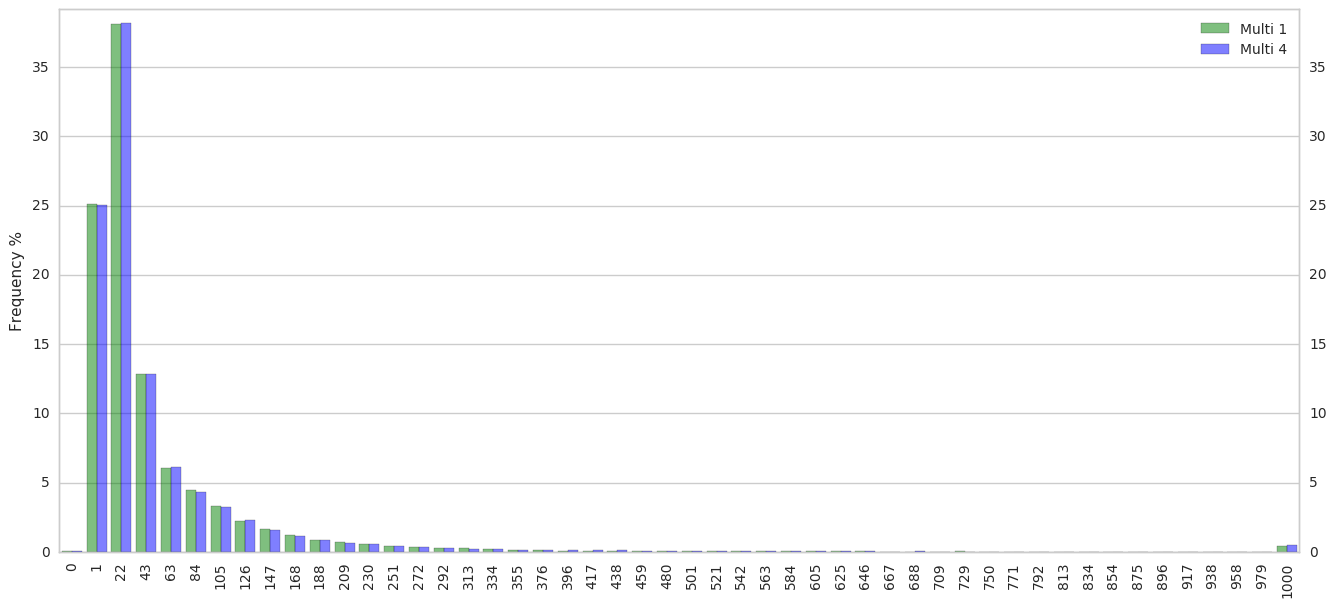

---
#### GC_MAX_PAUSE_MS (parent) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.273</b>.</span>
            

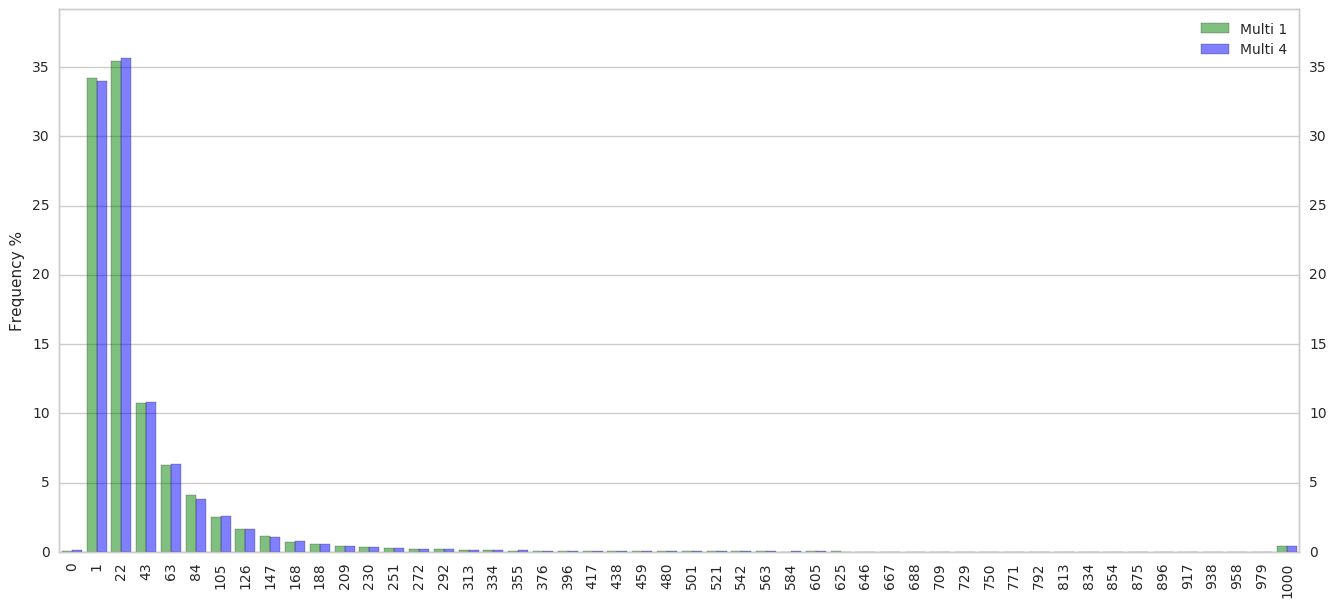

---
#### GC_MAX_PAUSE_MS (parent) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.104</b>.</span>
            

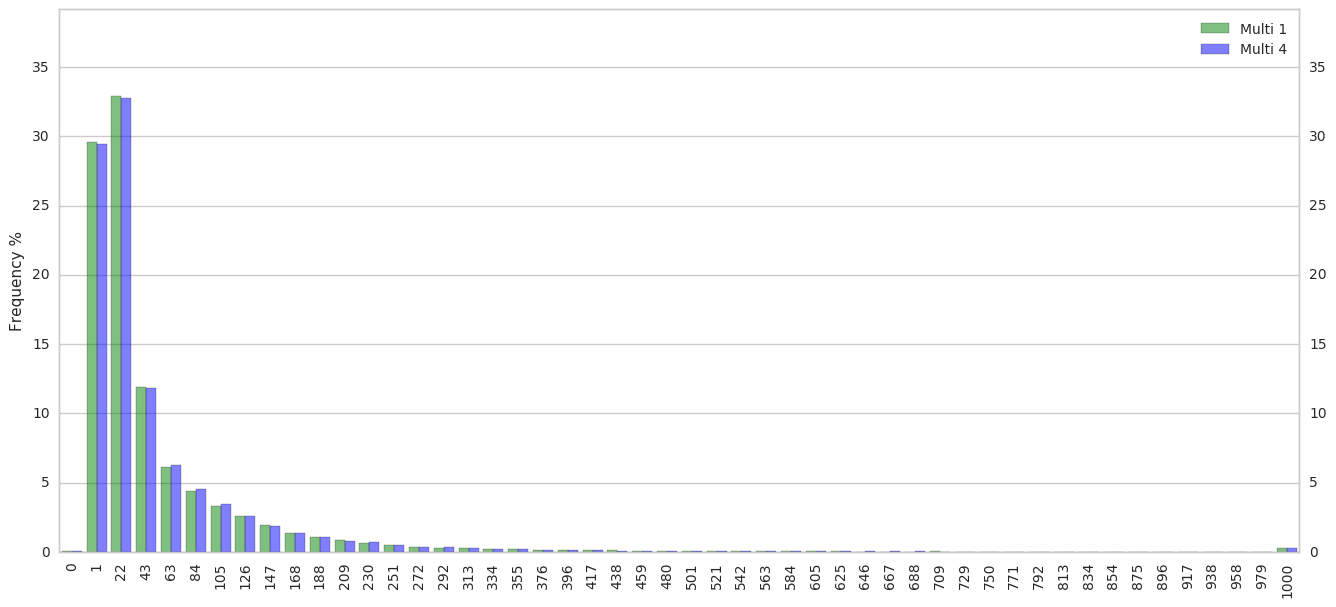

---
#### GC_MAX_PAUSE_MS (children) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.398</b>.</span>
            

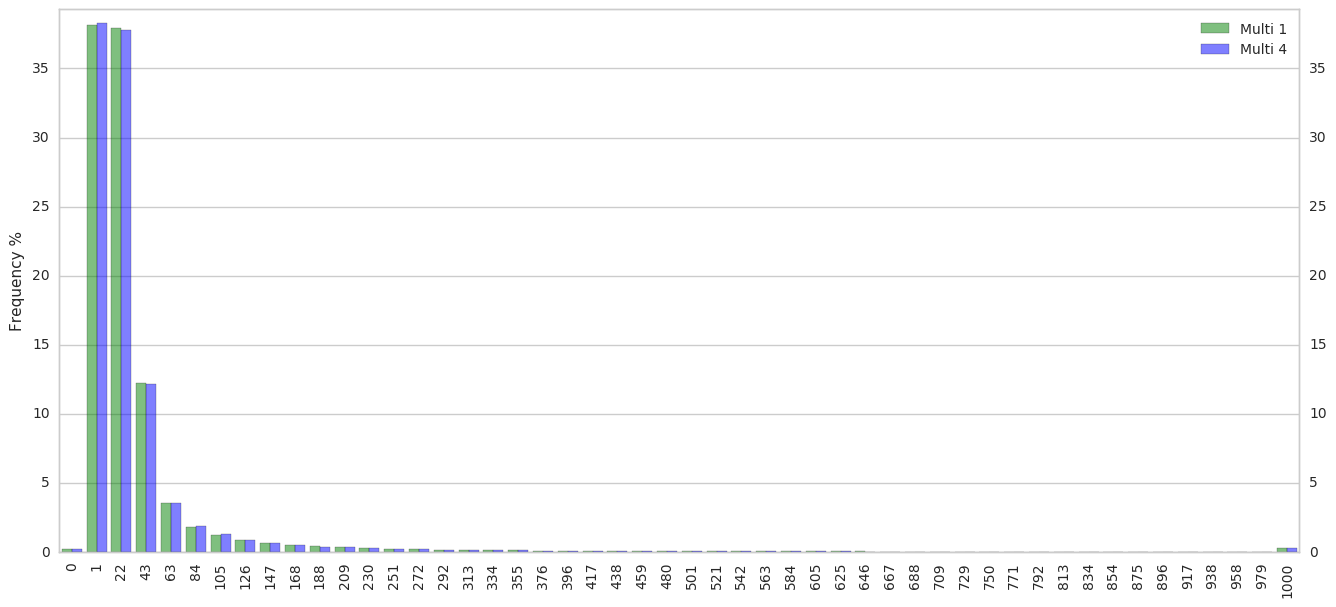

---
#### GC_MAX_PAUSE_MS (children) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.789</b>.</span>
            

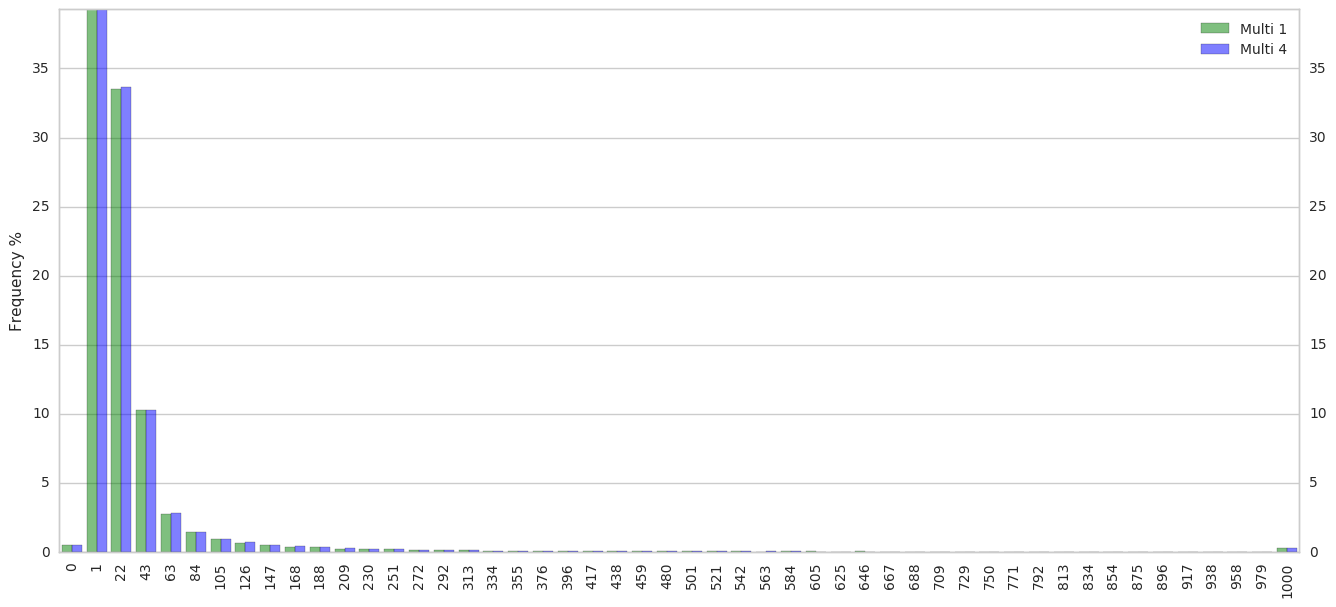

---
#### GC_MAX_PAUSE_MS (children) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.379</b>.</span>
            

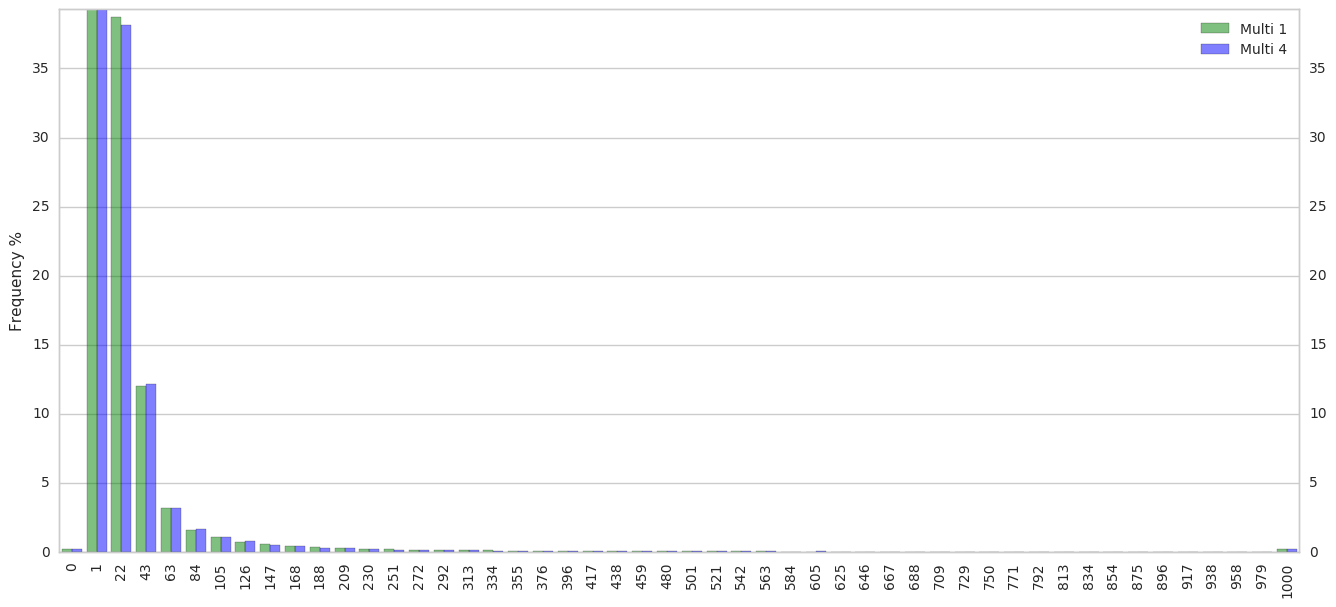

# Darwin

Comparison for GC_MAX_PAUSE_MS:

2848 (72.0%) multi_1 profiles on Darwin have the parent histogram.
2844 (71.8%) multi_4 profiles on Darwin have the parent histogram.
155 (64.6%) webext_multi_1 profiles on Darwin have the parent histogram.
142 (59.4%) webextx_multi_4 profiles on Darwin have the parent histogram.
272 (59.9%) mpc_multi_1 profiles on Darwin have the parent histogram.
265 (63.2%) mpc_multi_4 profiles on Darwin have the parent histogram.
2729 (69.0%) multi_1 profiles on Darwin have the child histogram.
2723 (68.7%) multi_4 profiles on Darwin have the child histogram.
152 (63.3%) webext_multi_1 profiles on Darwin have the child histogram.
141 (59.0%) webextx_multi_4 profiles on Darwin have the child histogram.
263 (57.9%) mpc_multi_1 profiles on Darwin have the child histogram.
255 (60.9%) mpc_multi_4 profiles on Darwin have the child histogram.


---
#### GC_MAX_PAUSE_MS (parent) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.416</b>.</span>
            

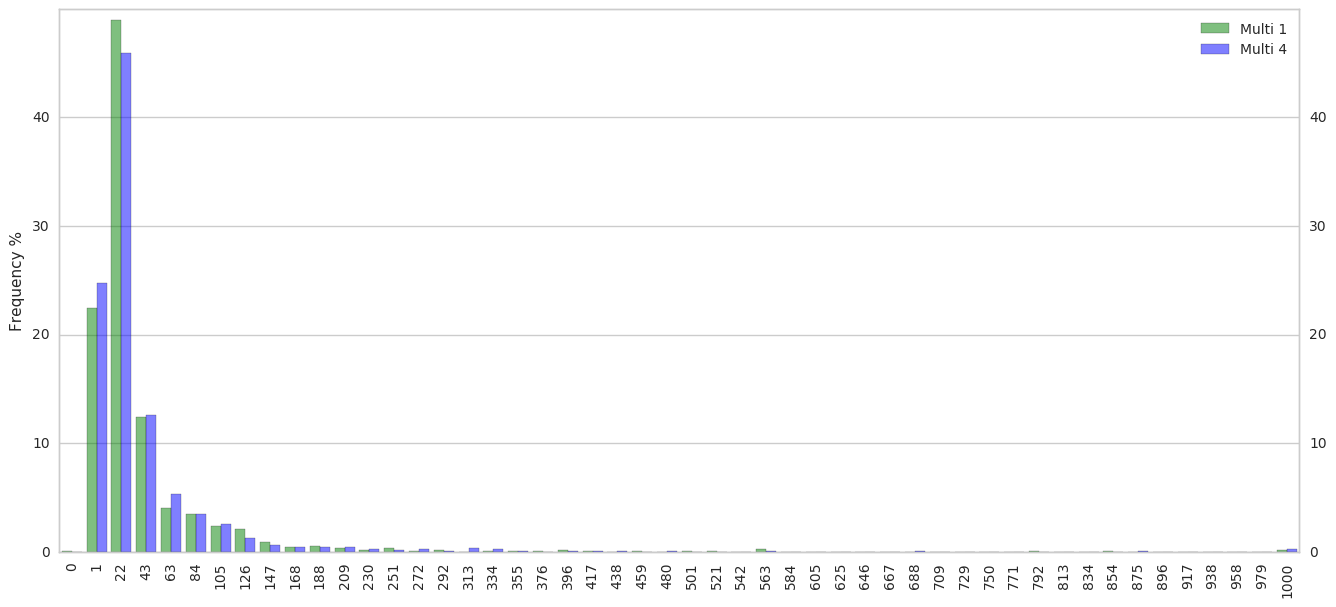

---
#### GC_MAX_PAUSE_MS (parent) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.127</b>.</span>
            

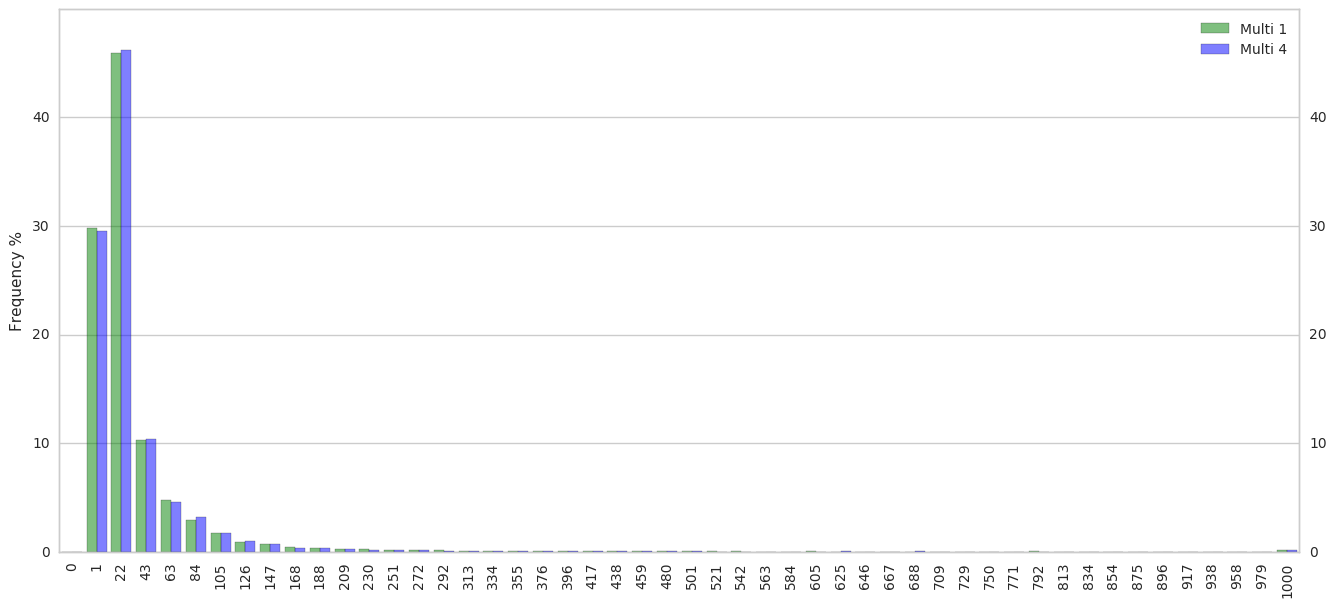

---
#### GC_MAX_PAUSE_MS (parent) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.969</b>.</span>
            

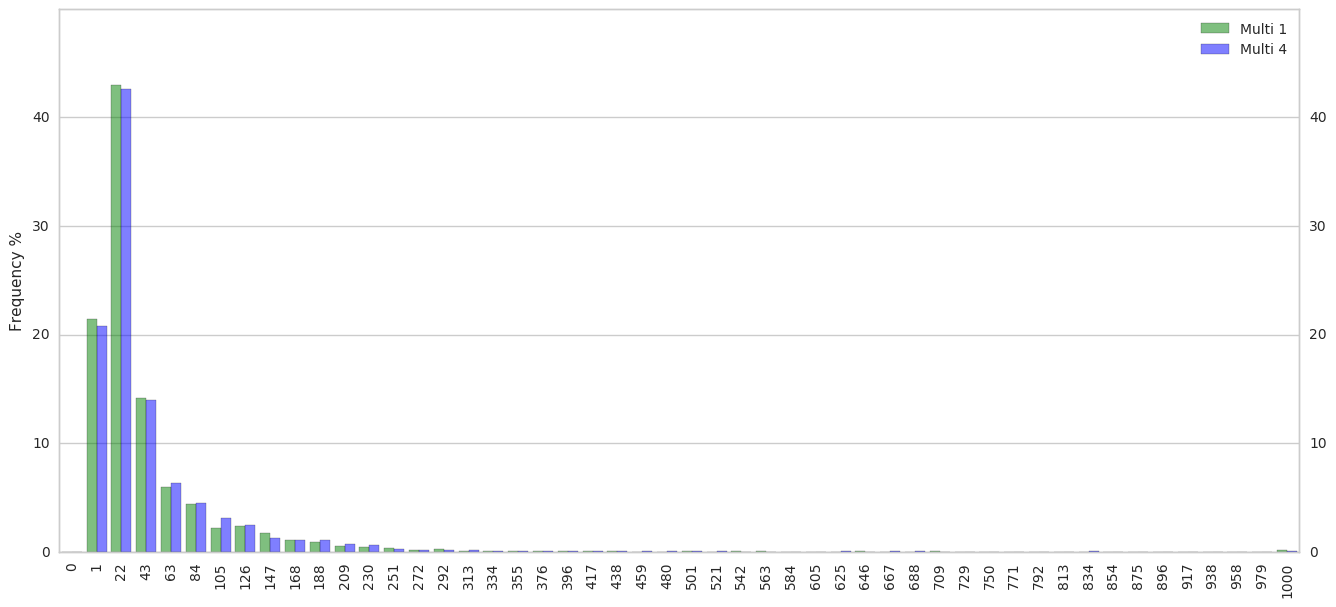

---
#### GC_MAX_PAUSE_MS (children) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.186</b>.</span>
            

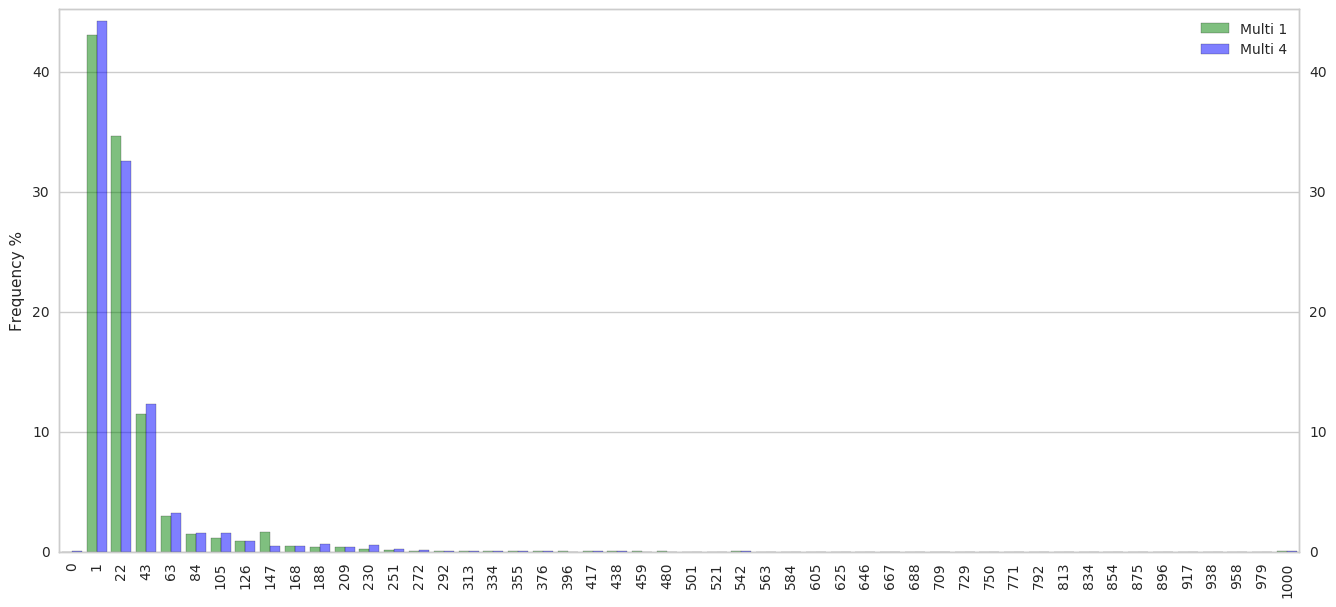

---
#### GC_MAX_PAUSE_MS (children) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.660</b>.</span>
            

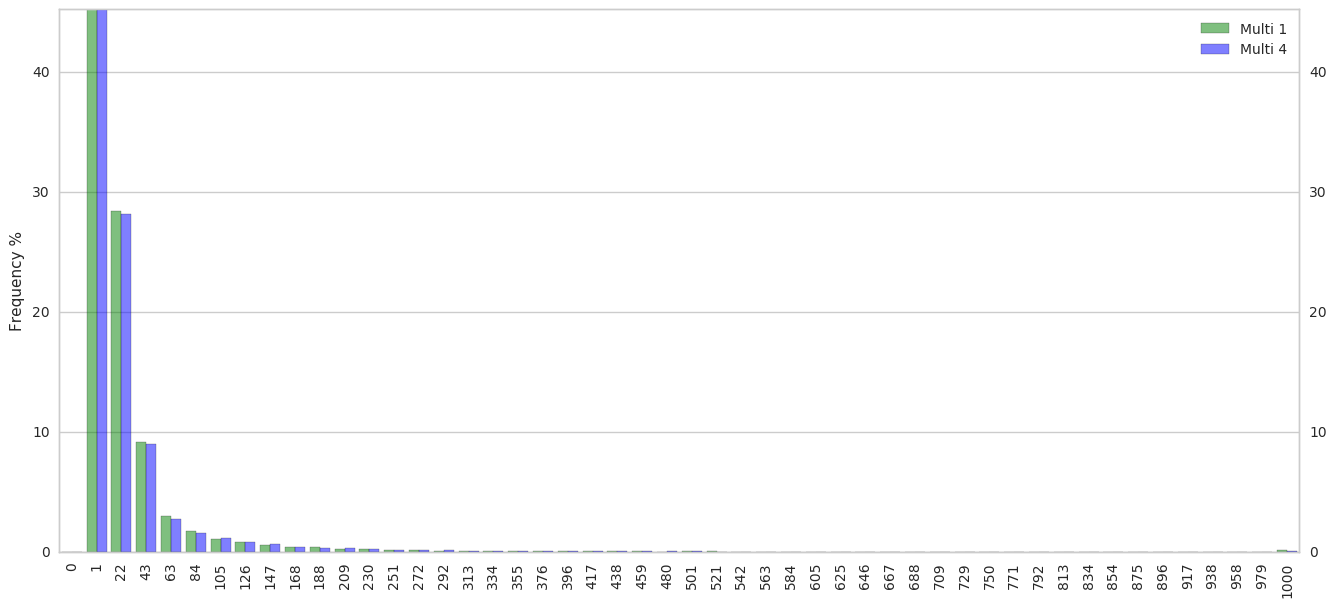

---
#### GC_MAX_PAUSE_MS (children) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.238</b>.</span>
            

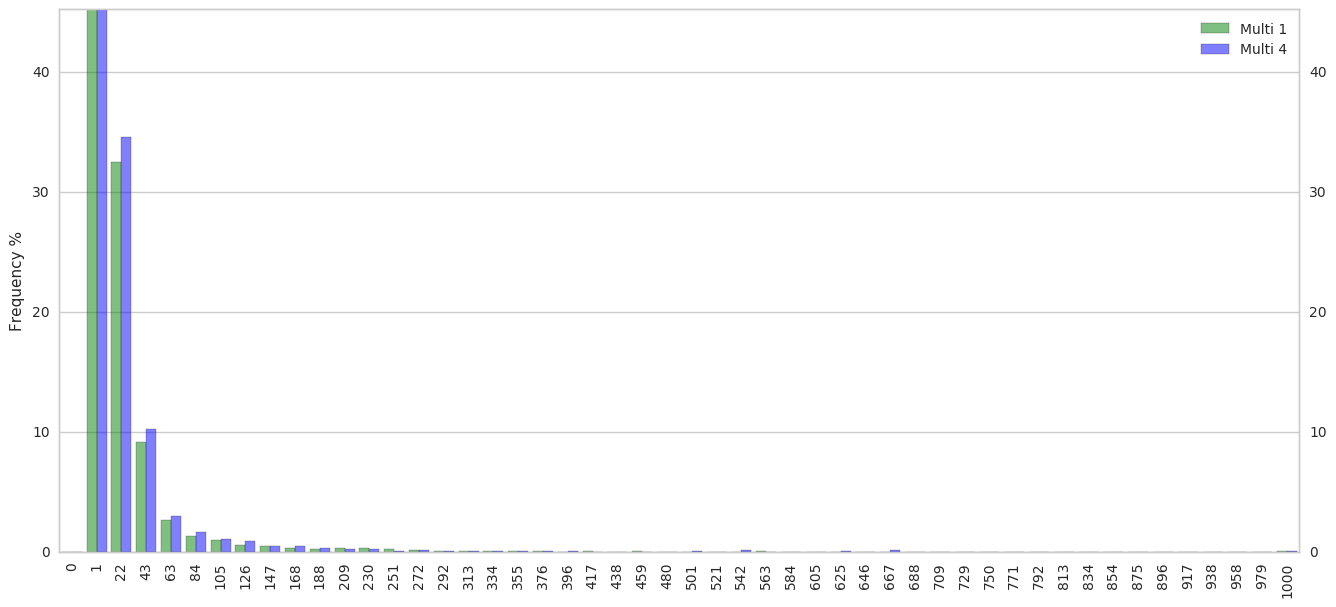

## 4+ Tabs

# Windows_NT

Comparison for GC_MAX_PAUSE_MS:

7685 (18.9%) multi_1 profiles on Windows_NT have the parent histogram.
7726 (19.0%) multi_4 profiles on Windows_NT have the parent histogram.
10805 (26.2%) webext_multi_1 profiles on Windows_NT have the parent histogram.
10770 (26.4%) webextx_multi_4 profiles on Windows_NT have the parent histogram.
8395 (28.4%) mpc_multi_1 profiles on Windows_NT have the parent histogram.
8363 (28.2%) mpc_multi_4 profiles on Windows_NT have the parent histogram.
7443 (18.3%) multi_1 profiles on Windows_NT have the child histogram.
7485 (18.4%) multi_4 profiles on Windows_NT have the child histogram.
10404 (25.2%) webext_multi_1 profiles on Windows_NT have the child histogram.
10370 (25.4%) webextx_multi_4 profiles on Windows_NT have the child histogram.
8089 (27.3%) mpc_multi_1 profiles on Windows_NT have the child histogram.
8035 (27.1%) mpc_multi_4 profiles on Windows_NT have the child histogram.


---
#### GC_MAX_PAUSE_MS (parent) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.271</b>.</span>
            

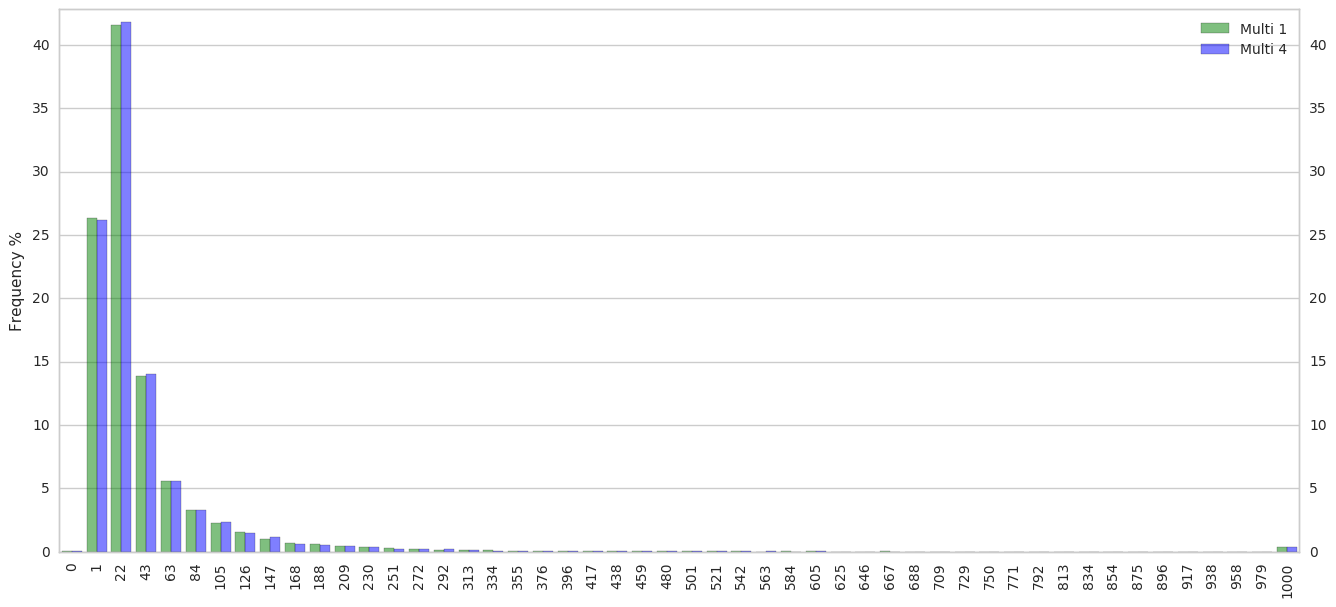

---
#### GC_MAX_PAUSE_MS (parent) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.693</b>.</span>
            

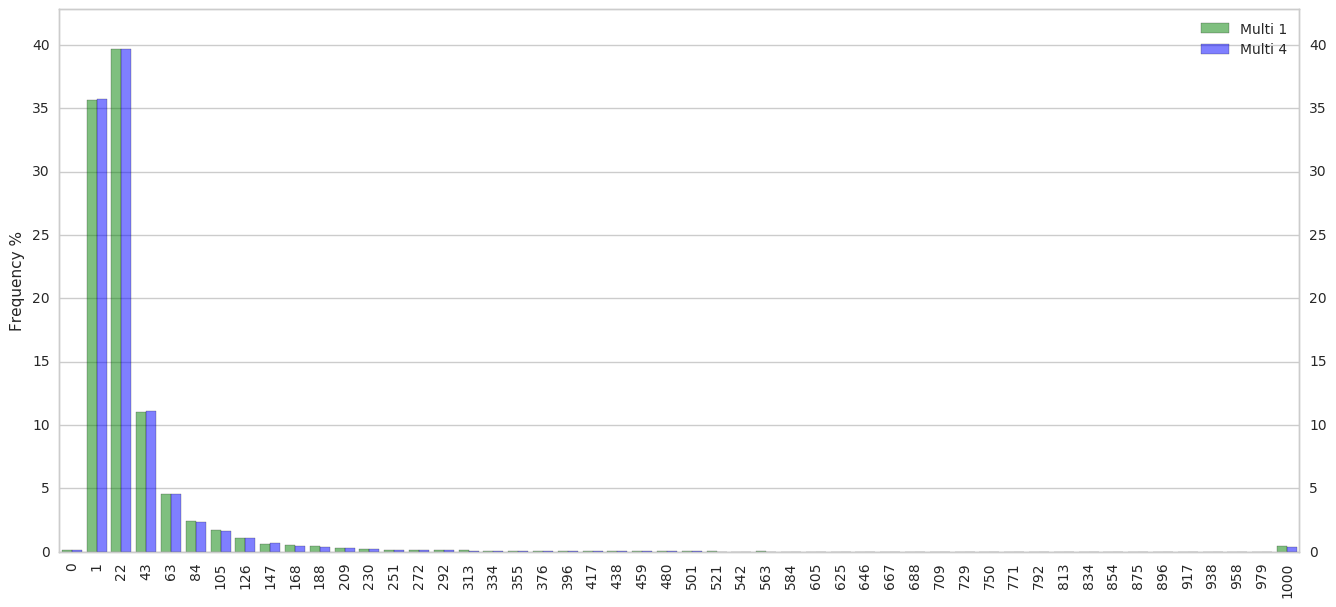

---
#### GC_MAX_PAUSE_MS (parent) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.637</b>.</span>
            

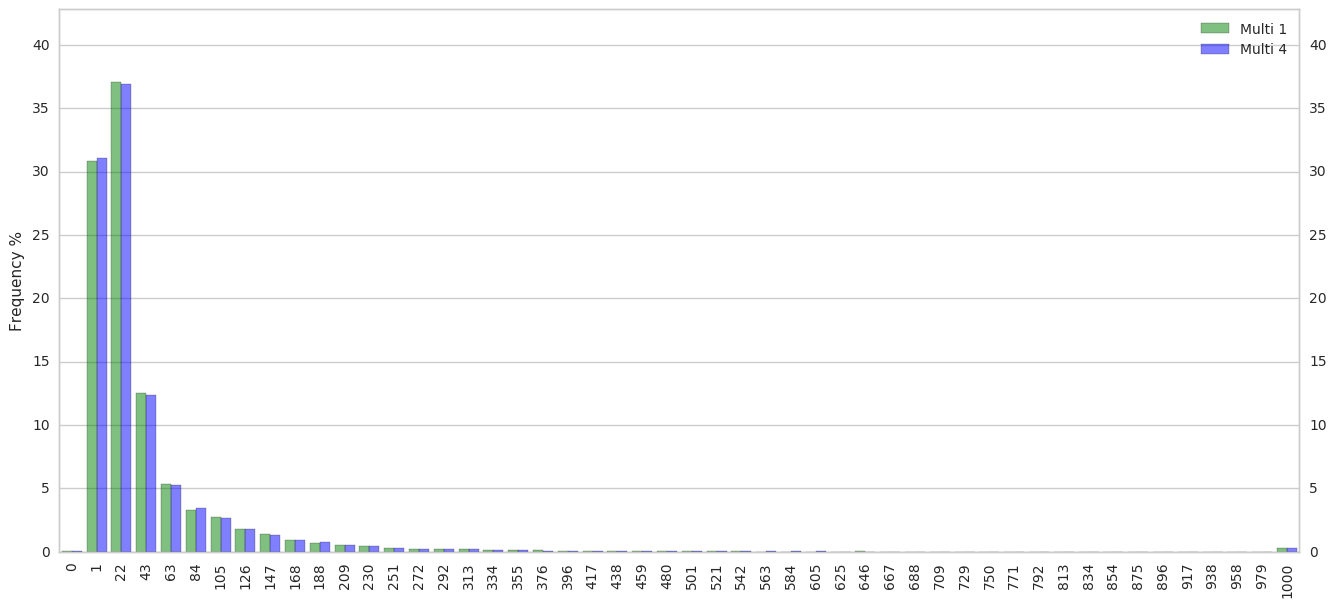

---
#### GC_MAX_PAUSE_MS (children) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.381</b>.</span>
            

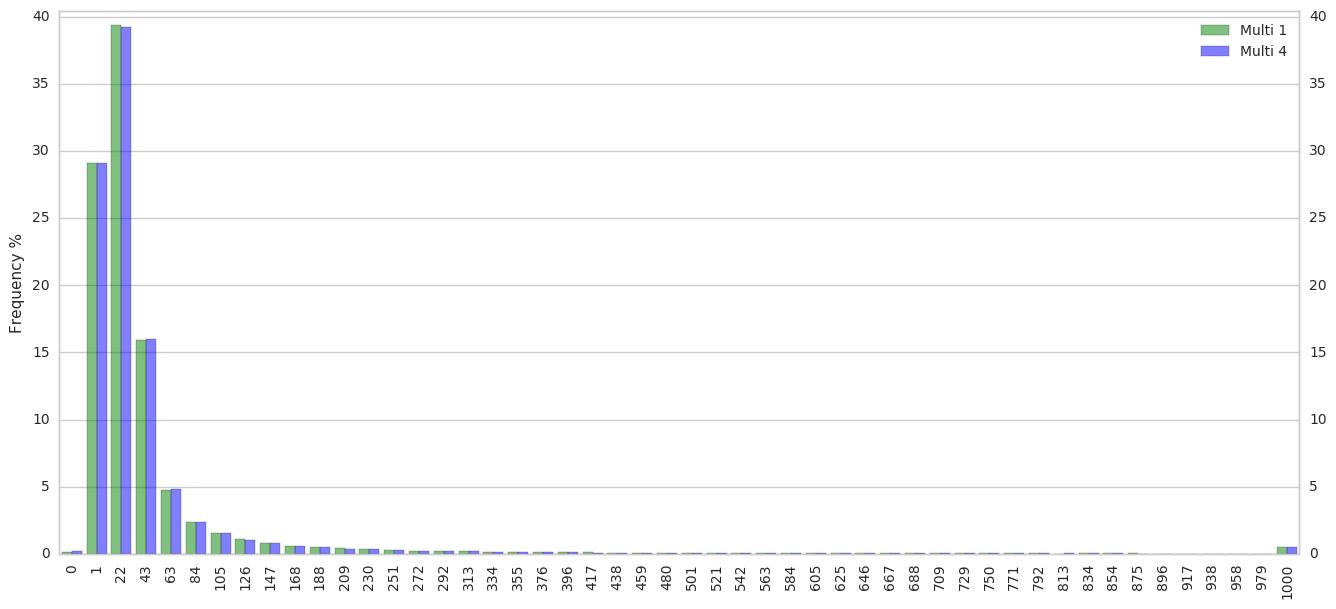

---
#### GC_MAX_PAUSE_MS (children) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:red"><b>0.029</b>.</span>
            

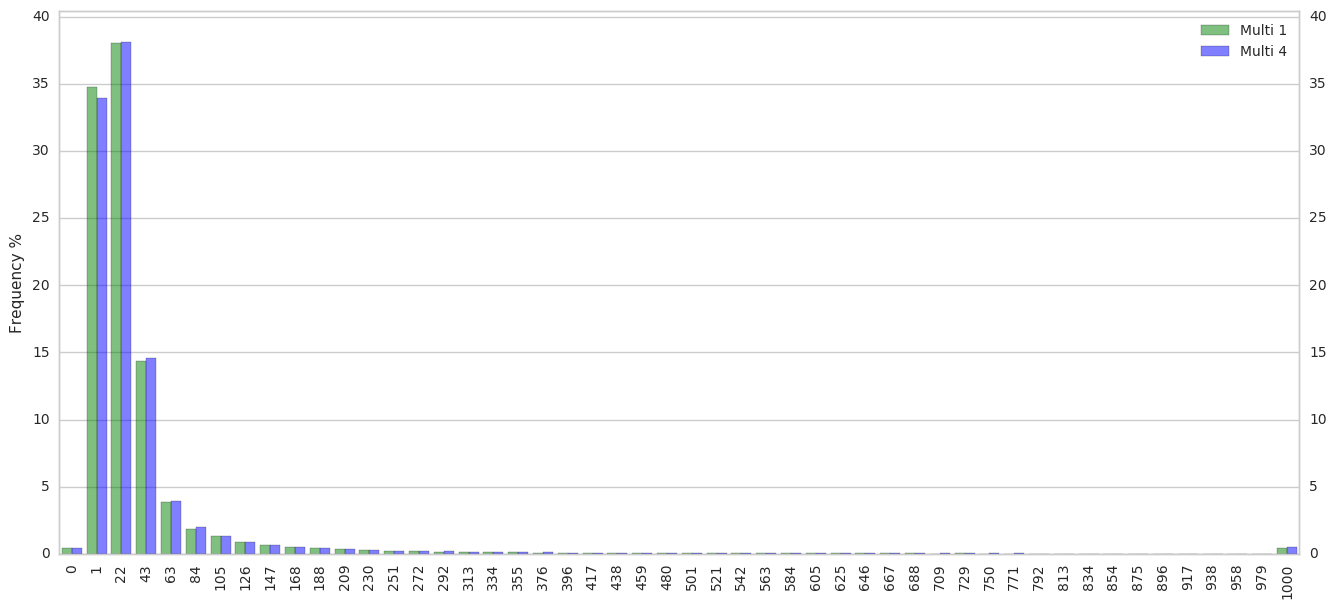

---
#### GC_MAX_PAUSE_MS (children) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.867</b>.</span>
            

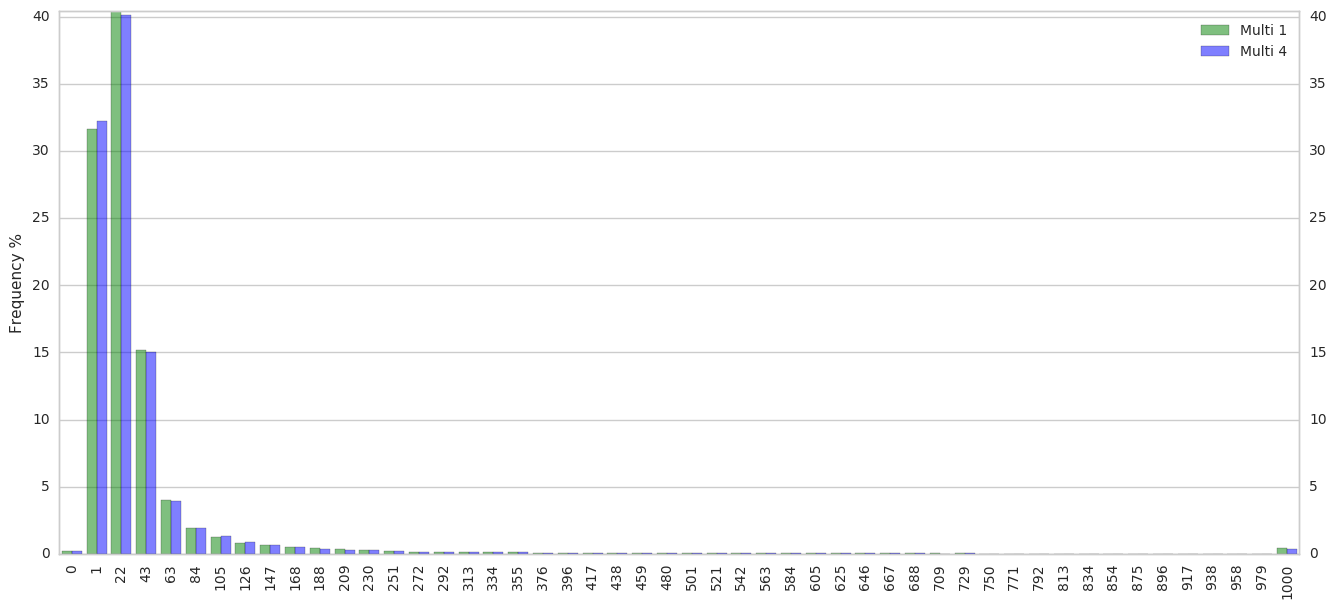

# Darwin

Comparison for GC_MAX_PAUSE_MS:

1109 (28.0%) multi_1 profiles on Darwin have the parent histogram.
1118 (28.2%) multi_4 profiles on Darwin have the parent histogram.
85 (35.4%) webext_multi_1 profiles on Darwin have the parent histogram.
97 (40.6%) webextx_multi_4 profiles on Darwin have the parent histogram.
181 (39.9%) mpc_multi_1 profiles on Darwin have the parent histogram.
154 (36.8%) mpc_multi_4 profiles on Darwin have the parent histogram.
1098 (27.7%) multi_1 profiles on Darwin have the child histogram.
1103 (27.8%) multi_4 profiles on Darwin have the child histogram.
84 (35.0%) webext_multi_1 profiles on Darwin have the child histogram.
96 (40.2%) webextx_multi_4 profiles on Darwin have the child histogram.
174 (38.3%) mpc_multi_1 profiles on Darwin have the child histogram.
153 (36.5%) mpc_multi_4 profiles on Darwin have the child histogram.


---
#### GC_MAX_PAUSE_MS (parent) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.938</b>.</span>
            

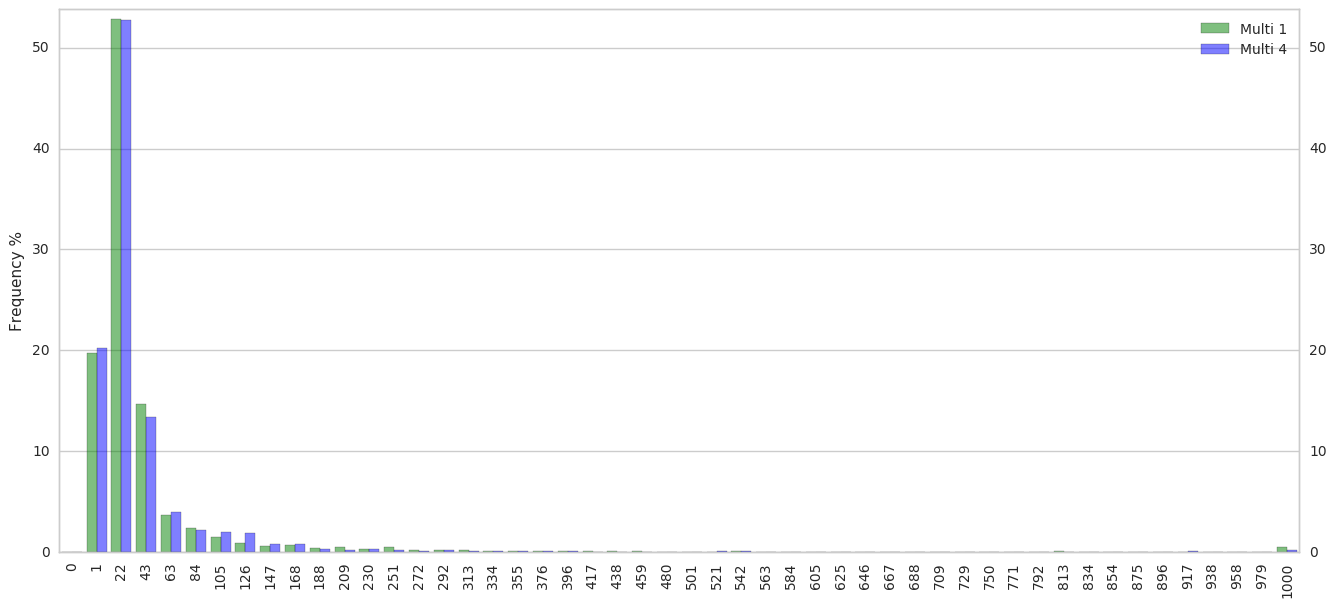

---
#### GC_MAX_PAUSE_MS (parent) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.525</b>.</span>
            

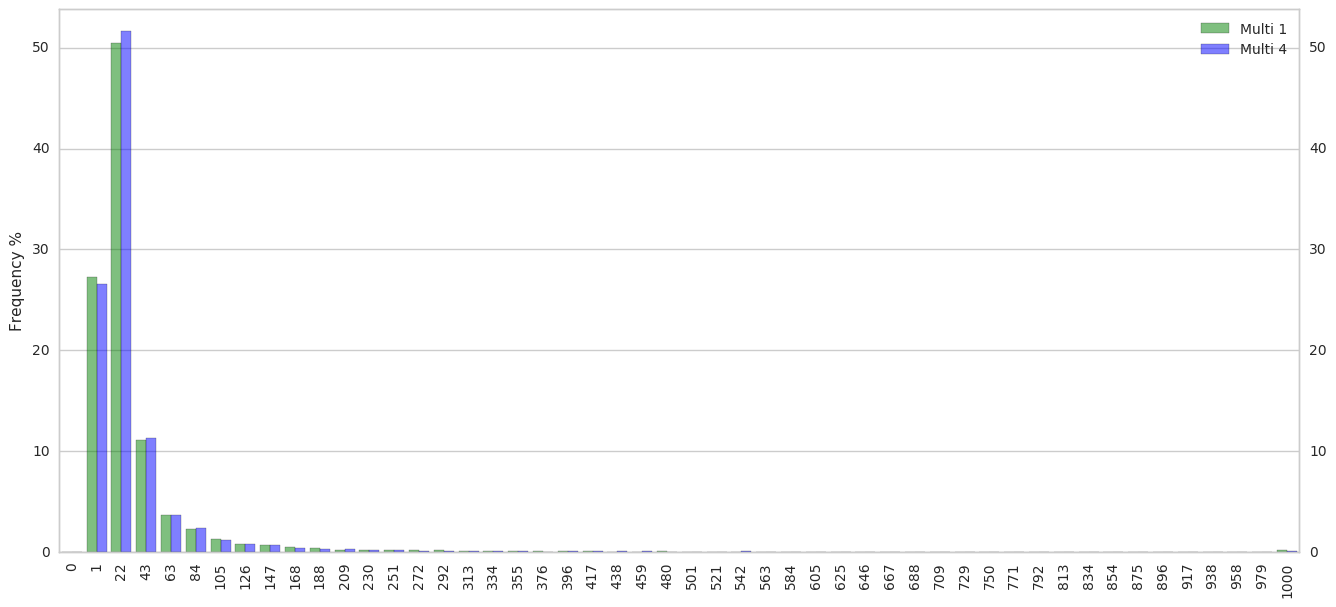

---
#### GC_MAX_PAUSE_MS (parent) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.314</b>.</span>
            

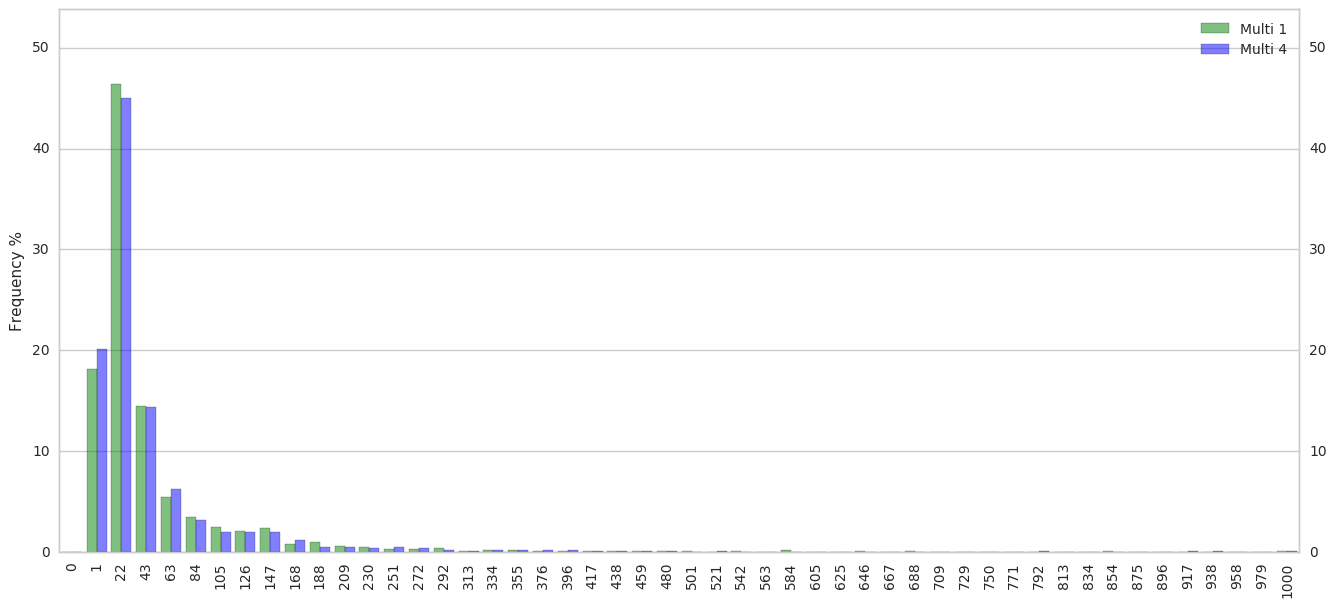

---
#### GC_MAX_PAUSE_MS (children) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.199</b>.</span>
            

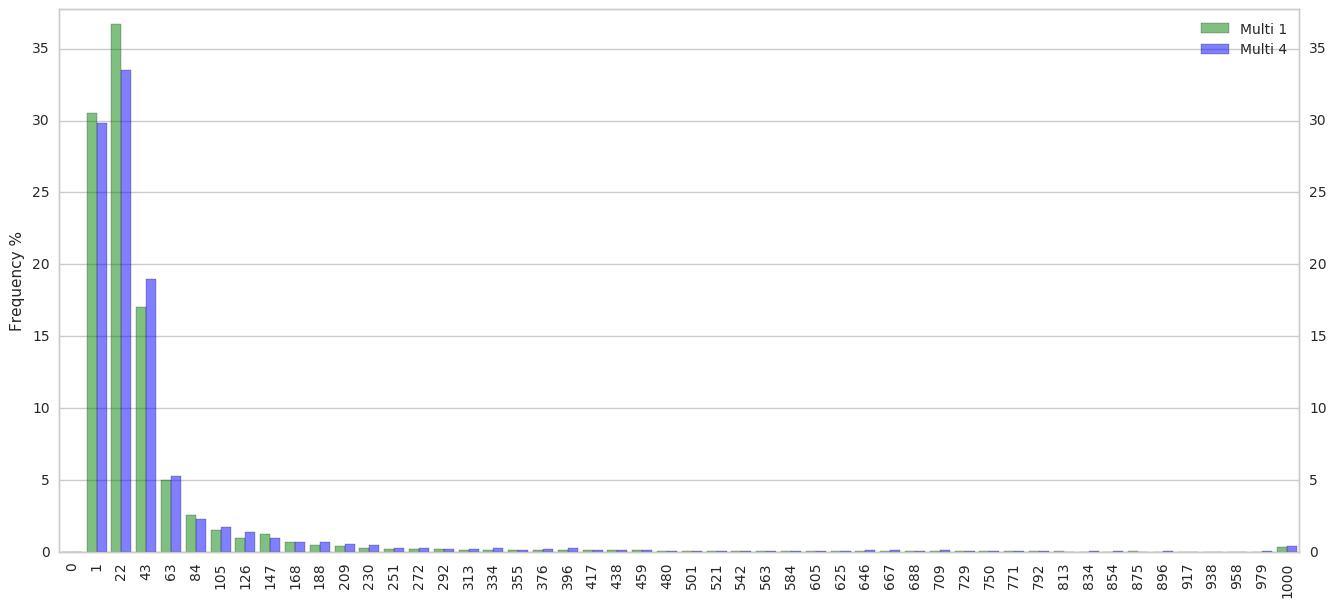

---
#### GC_MAX_PAUSE_MS (children) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.879</b>.</span>
            

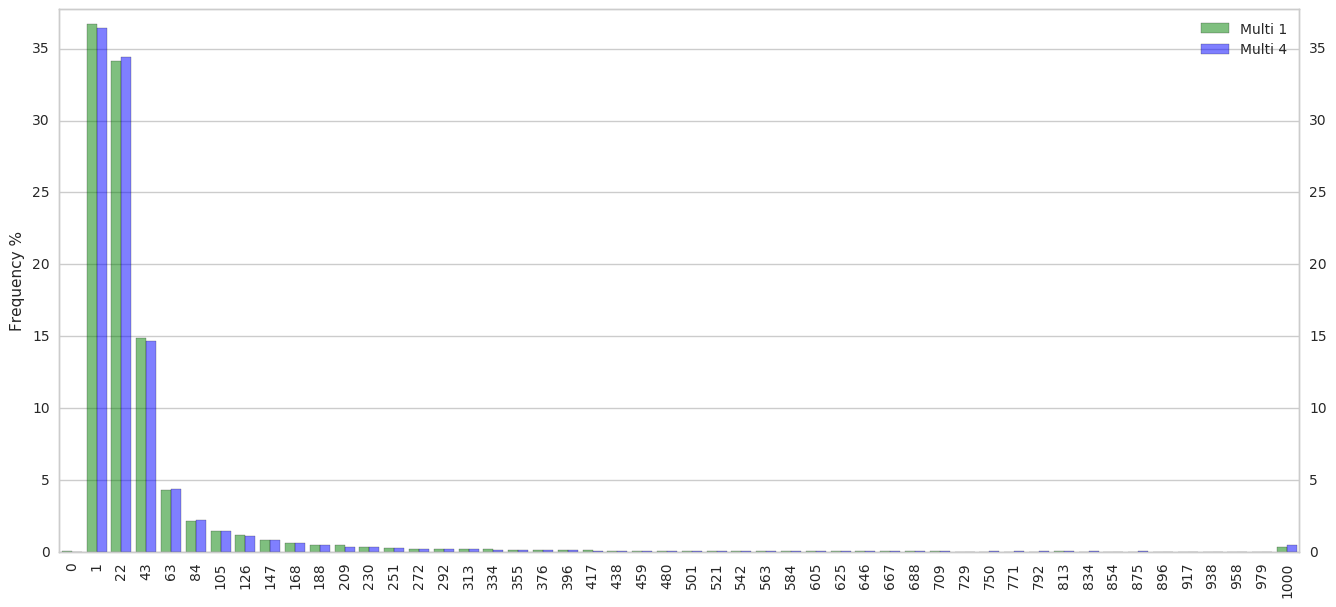

---
#### GC_MAX_PAUSE_MS (children) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.906</b>.</span>
            

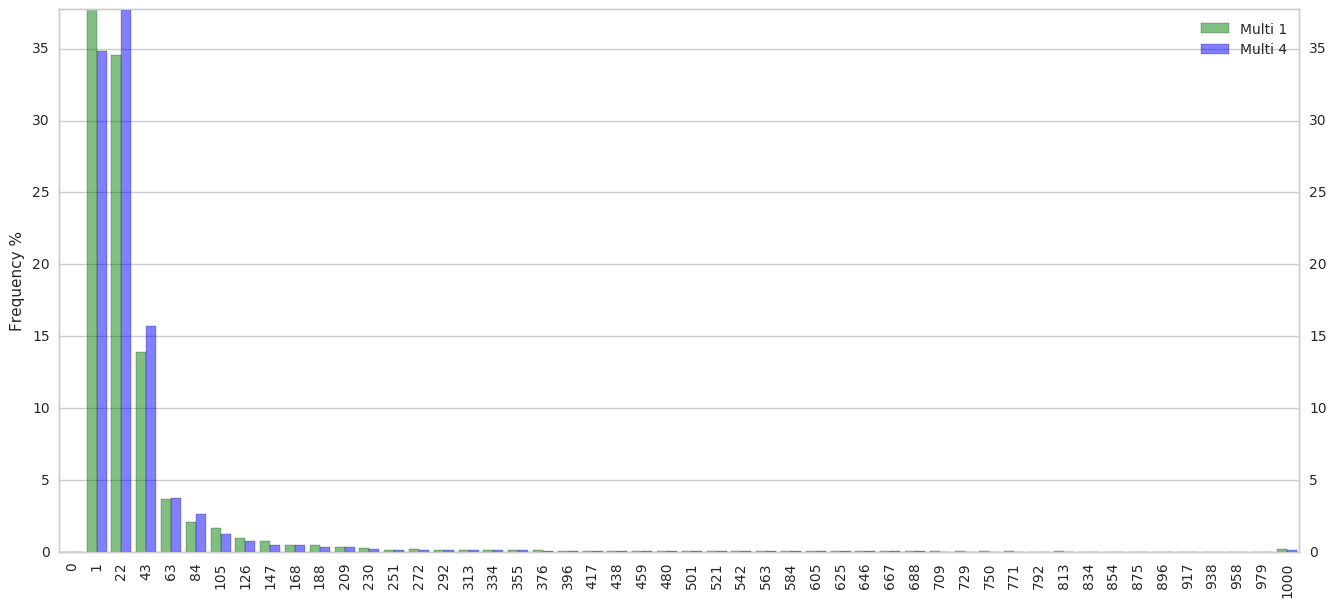

In [108]:
results.extend(compare_tab_groups(t3, t4, 'payload/histograms/GC_MAX_PAUSE_MS'))

### CYCLE_COLLECTOR_MAX_PAUSE

## 1-3 Tabs

# Windows_NT

Comparison for CYCLE_COLLECTOR_MAX_PAUSE:

30181 (74.1%) multi_1 profiles on Windows_NT have the parent histogram.
30318 (74.4%) multi_4 profiles on Windows_NT have the parent histogram.
28113 (68.1%) webext_multi_1 profiles on Windows_NT have the parent histogram.
27635 (67.7%) webextx_multi_4 profiles on Windows_NT have the parent histogram.
19907 (67.2%) mpc_multi_1 profiles on Windows_NT have the parent histogram.
19981 (67.3%) mpc_multi_4 profiles on Windows_NT have the parent histogram.
29580 (72.7%) multi_1 profiles on Windows_NT have the child histogram.
29664 (72.8%) multi_4 profiles on Windows_NT have the child histogram.
27533 (66.6%) webext_multi_1 profiles on Windows_NT have the child histogram.
27041 (66.3%) webextx_multi_4 profiles on Windows_NT have the child histogram.
19485 (65.8%) mpc_multi_1 profiles on Windows_NT have the child histogram.
19563 (65.9%) mpc_multi_4 profiles on Windows_NT have the child histogram.


---
#### CYCLE_COLLECTOR_MAX_PAUSE (parent) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.494</b>.</span>
            

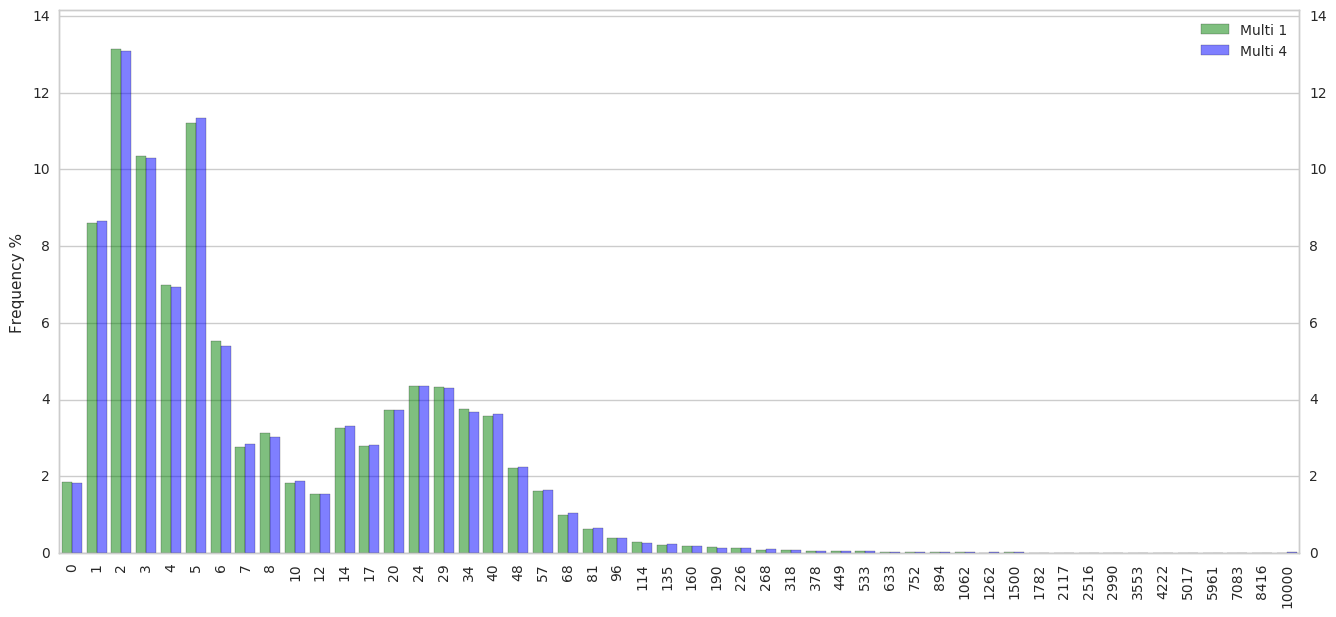

---
#### CYCLE_COLLECTOR_MAX_PAUSE (parent) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.082</b>.</span>
            

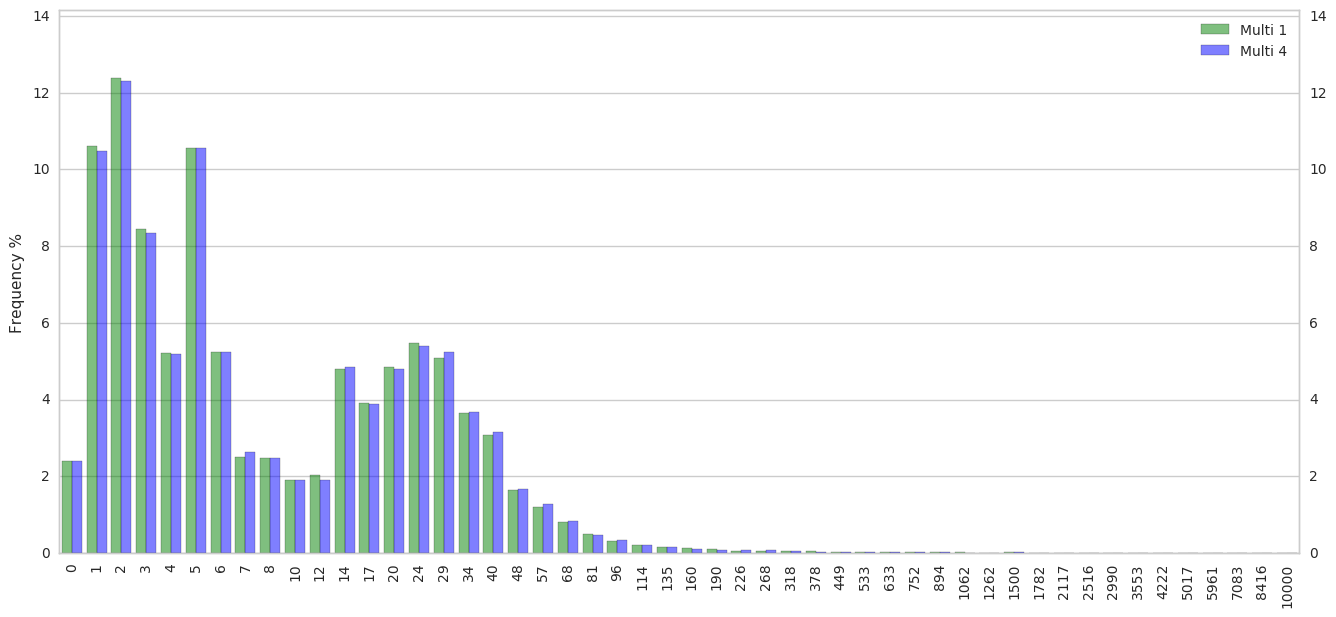

---
#### CYCLE_COLLECTOR_MAX_PAUSE (parent) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.723</b>.</span>
            

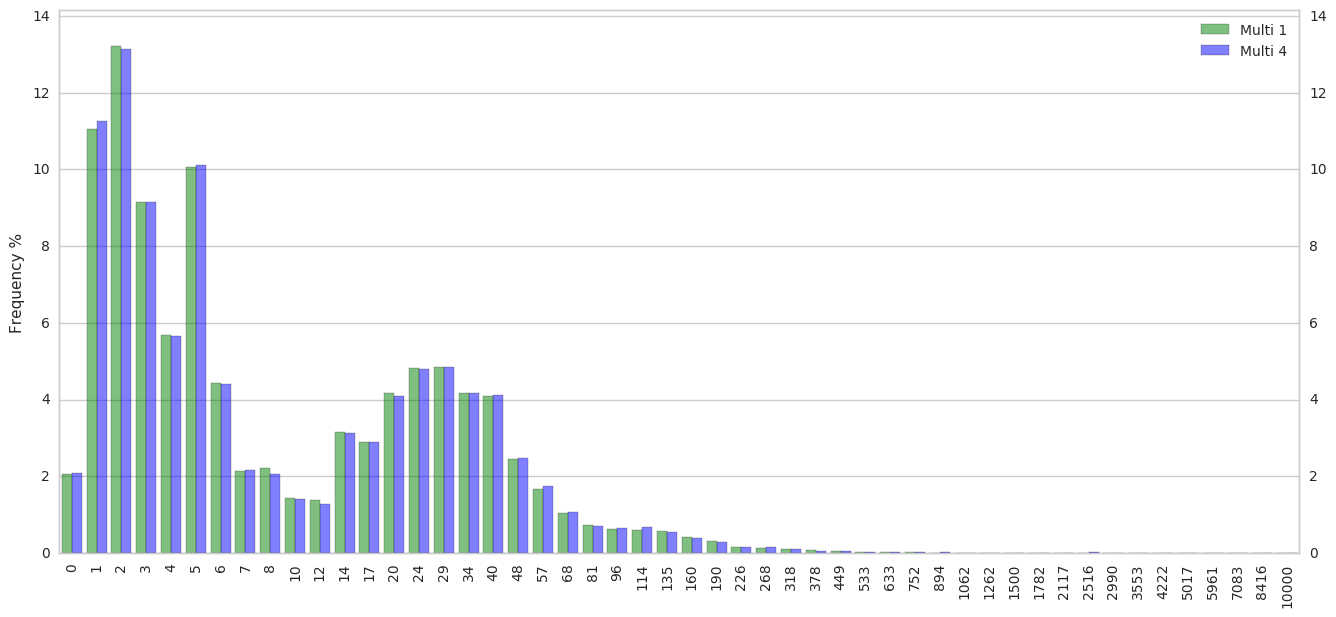

---
#### CYCLE_COLLECTOR_MAX_PAUSE (children) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.242</b>.</span>
            

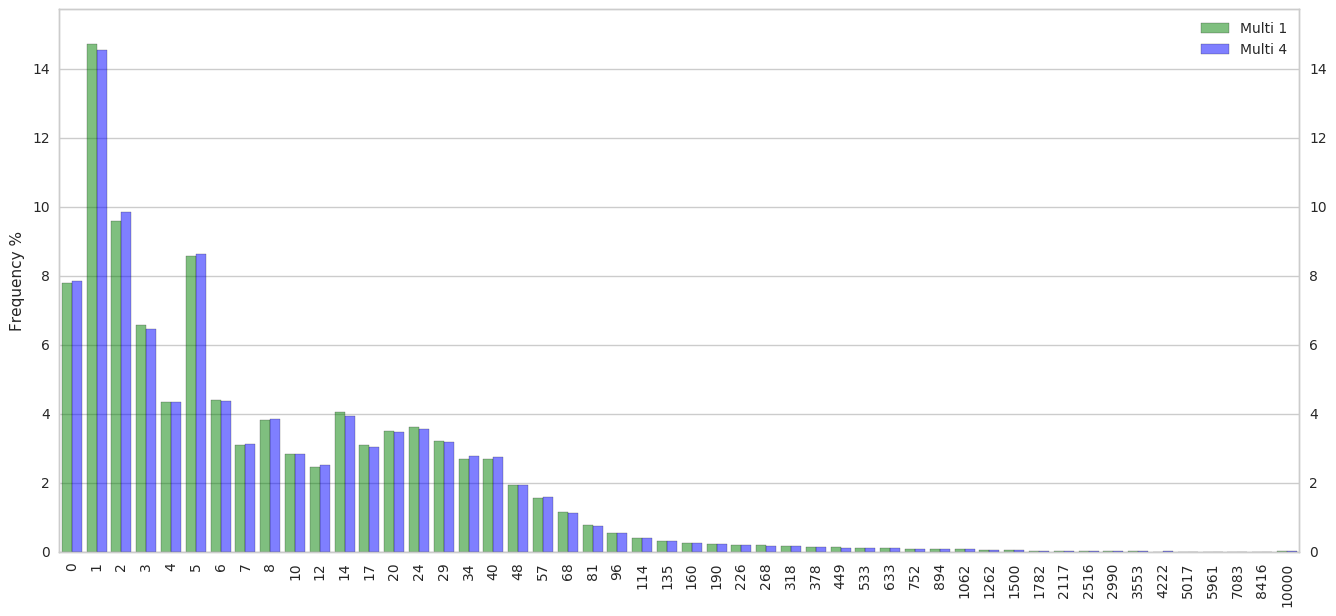

---
#### CYCLE_COLLECTOR_MAX_PAUSE (children) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.420</b>.</span>
            

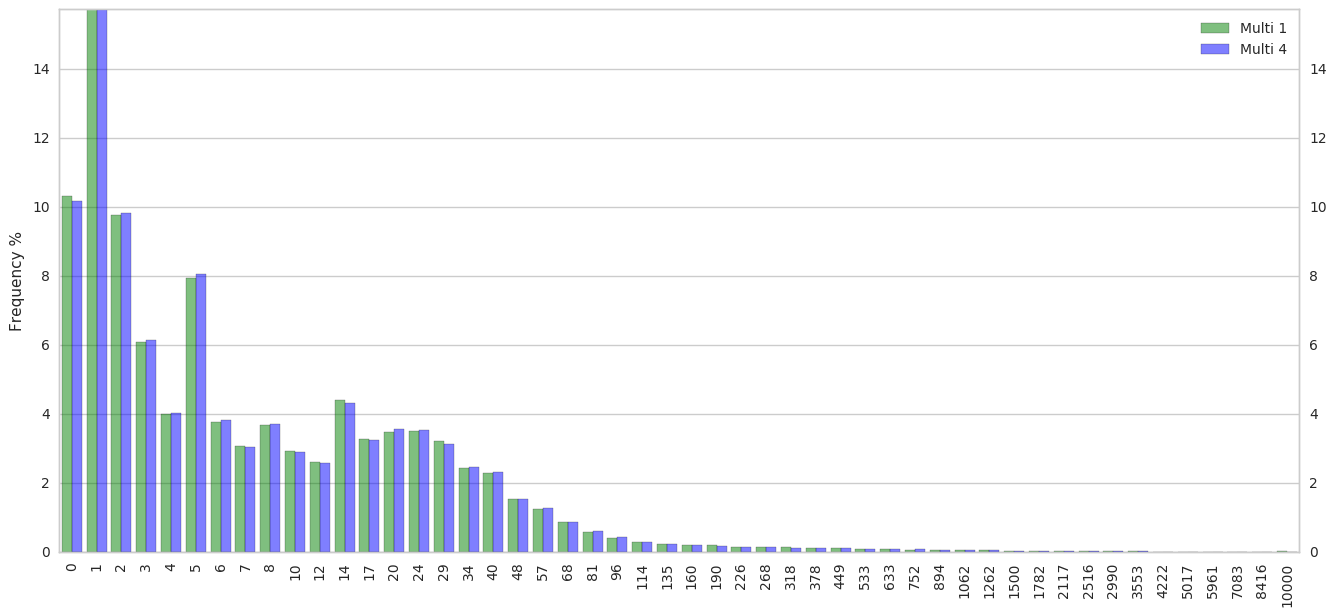

---
#### CYCLE_COLLECTOR_MAX_PAUSE (children) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:red"><b>0.037</b>.</span>
            

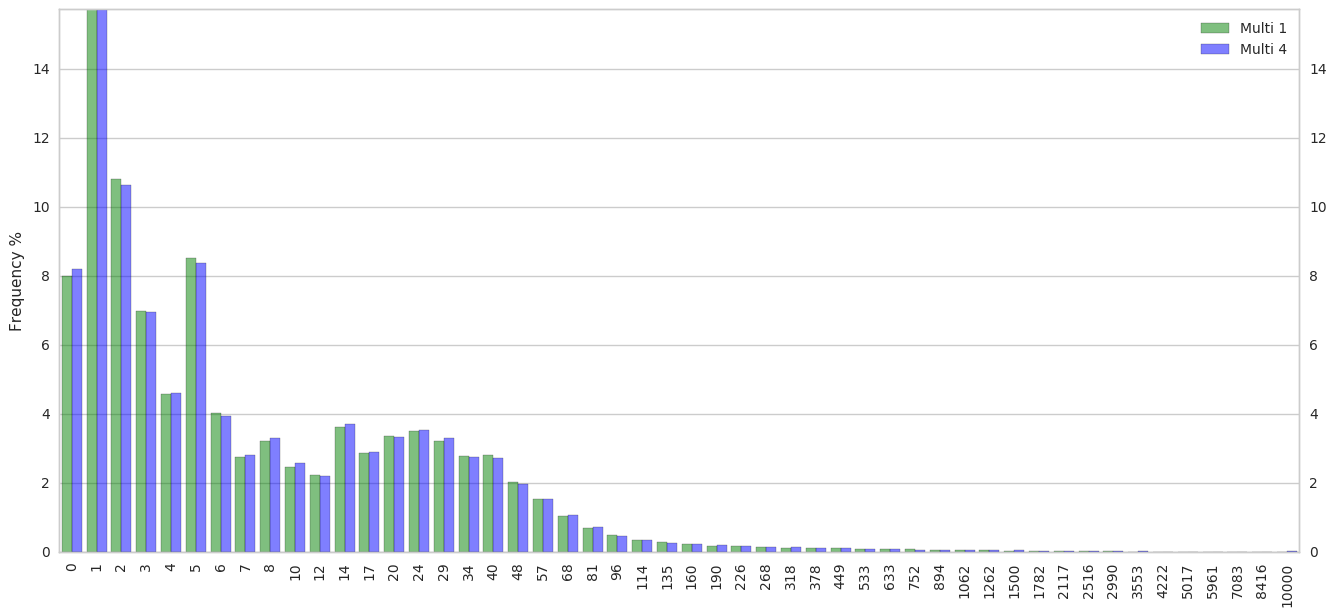

# Darwin

Comparison for CYCLE_COLLECTOR_MAX_PAUSE:

2767 (69.9%) multi_1 profiles on Darwin have the parent histogram.
2763 (69.7%) multi_4 profiles on Darwin have the parent histogram.
155 (64.6%) webext_multi_1 profiles on Darwin have the parent histogram.
141 (59.0%) webextx_multi_4 profiles on Darwin have the parent histogram.
263 (57.9%) mpc_multi_1 profiles on Darwin have the parent histogram.
258 (61.6%) mpc_multi_4 profiles on Darwin have the parent histogram.
2676 (67.6%) multi_1 profiles on Darwin have the child histogram.
2657 (67.1%) multi_4 profiles on Darwin have the child histogram.
148 (61.7%) webext_multi_1 profiles on Darwin have the child histogram.
139 (58.2%) webextx_multi_4 profiles on Darwin have the child histogram.
257 (56.6%) mpc_multi_1 profiles on Darwin have the child histogram.
251 (59.9%) mpc_multi_4 profiles on Darwin have the child histogram.


---
#### CYCLE_COLLECTOR_MAX_PAUSE (parent) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.939</b>.</span>
            

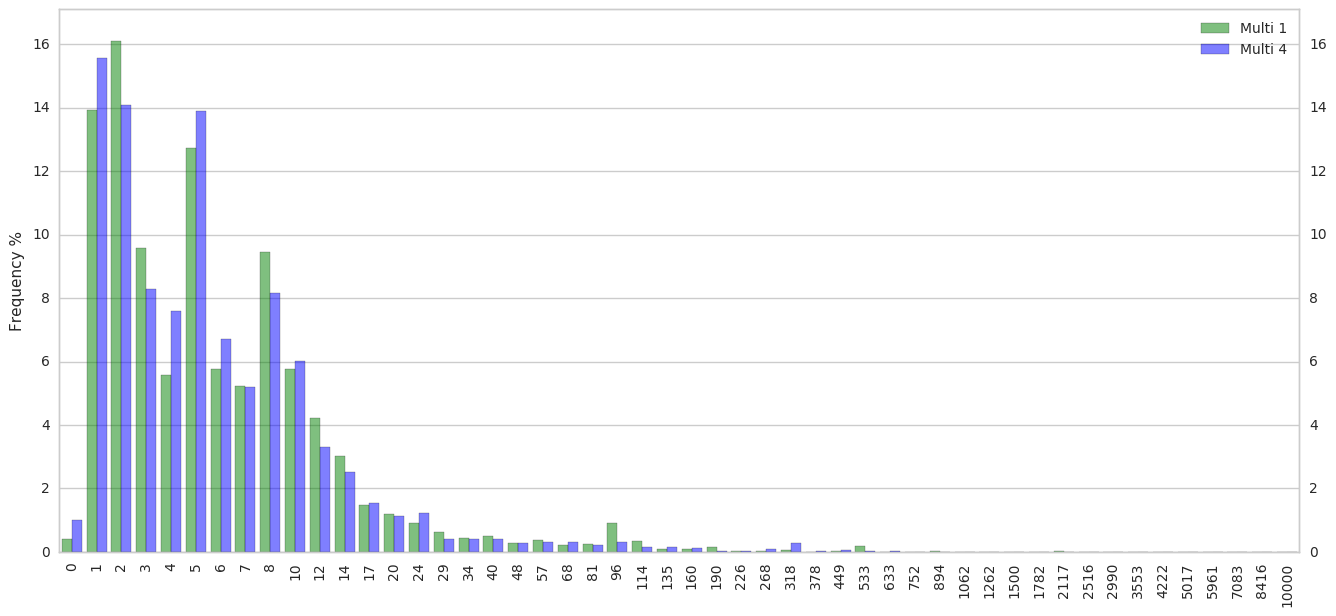

---
#### CYCLE_COLLECTOR_MAX_PAUSE (parent) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.920</b>.</span>
            

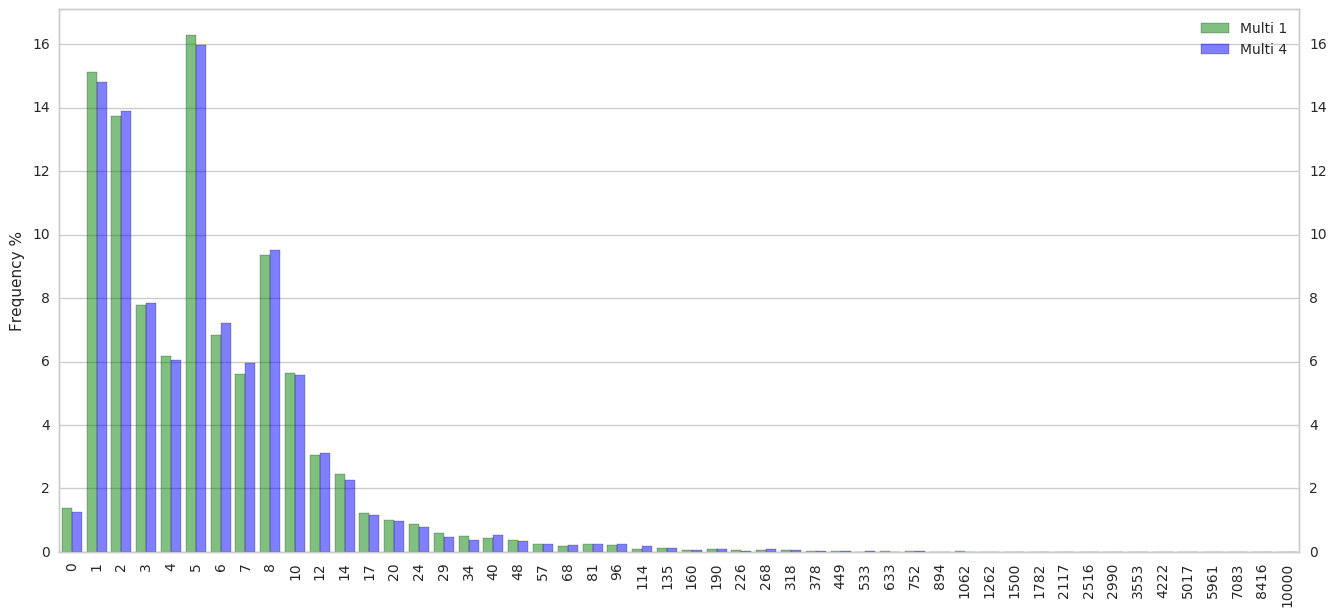

---
#### CYCLE_COLLECTOR_MAX_PAUSE (parent) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.086</b>.</span>
            

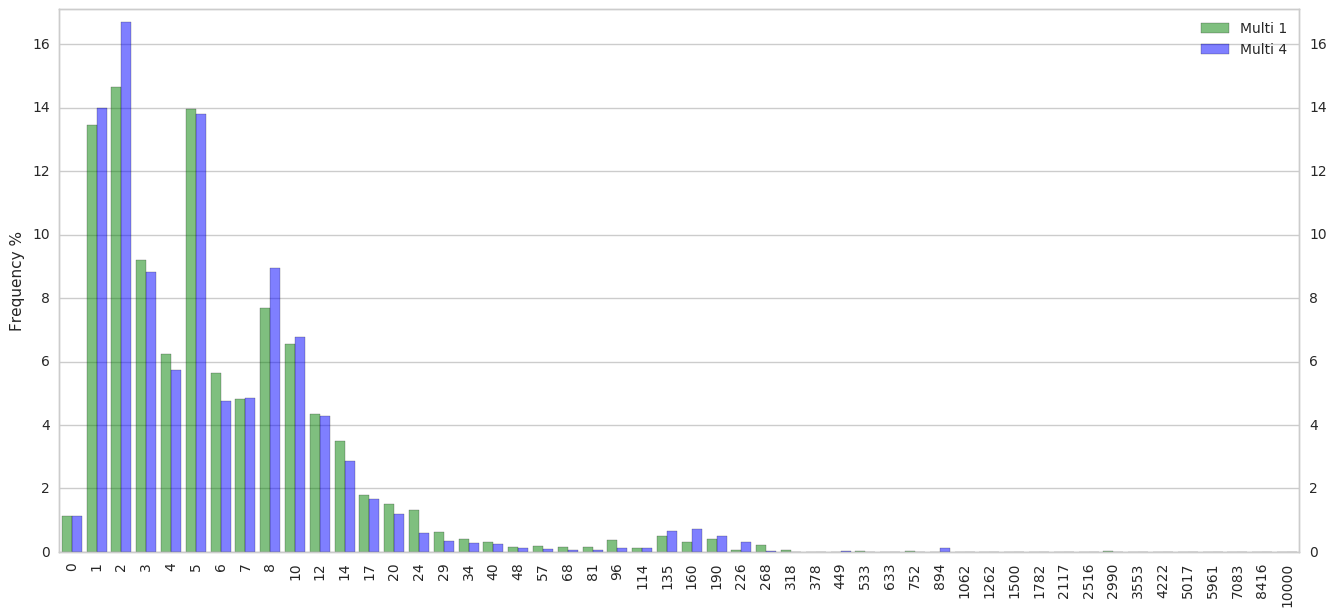

---
#### CYCLE_COLLECTOR_MAX_PAUSE (children) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.162</b>.</span>
            

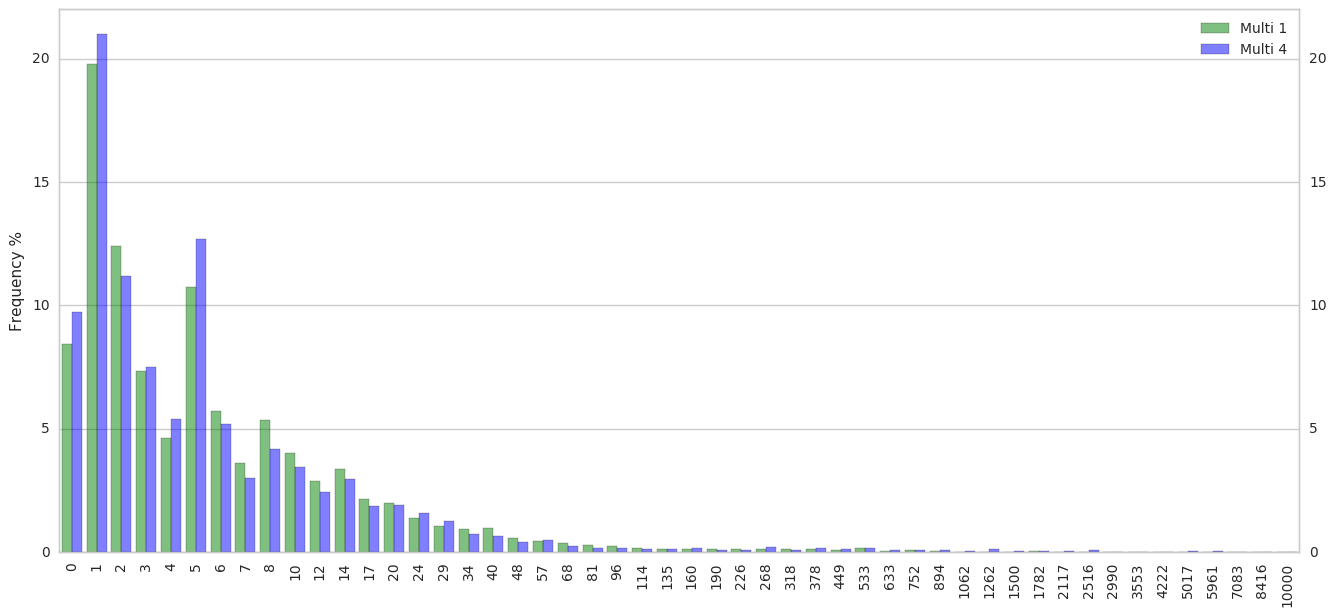

---
#### CYCLE_COLLECTOR_MAX_PAUSE (children) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.658</b>.</span>
            

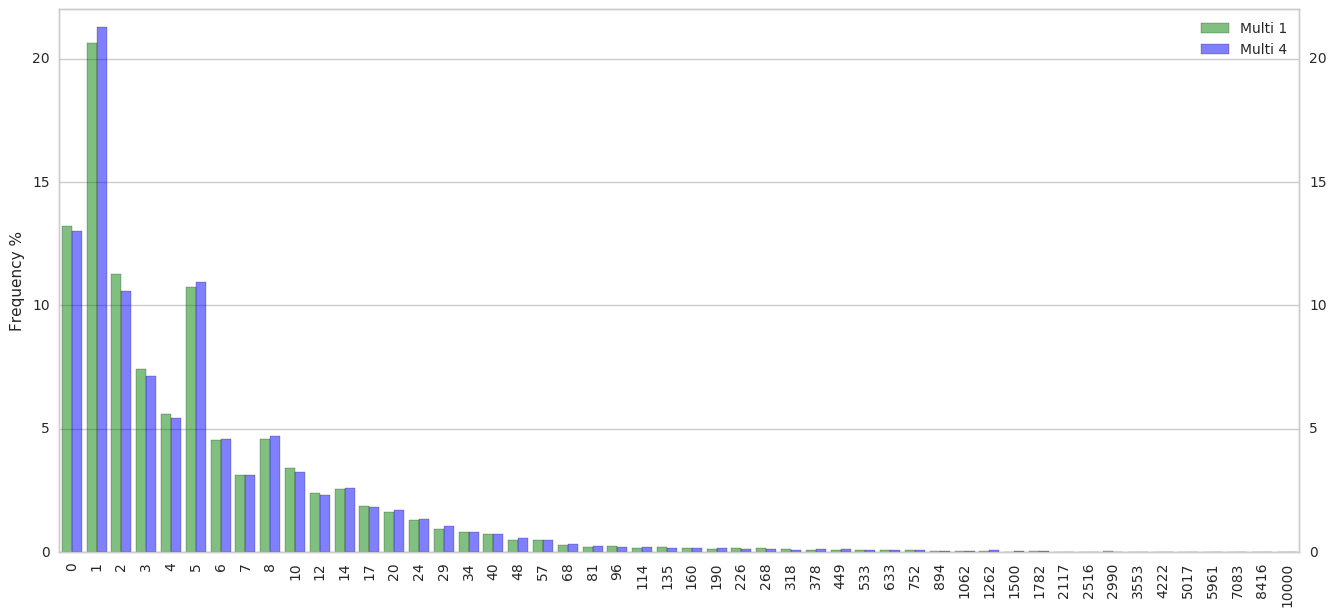

---
#### CYCLE_COLLECTOR_MAX_PAUSE (children) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.717</b>.</span>
            

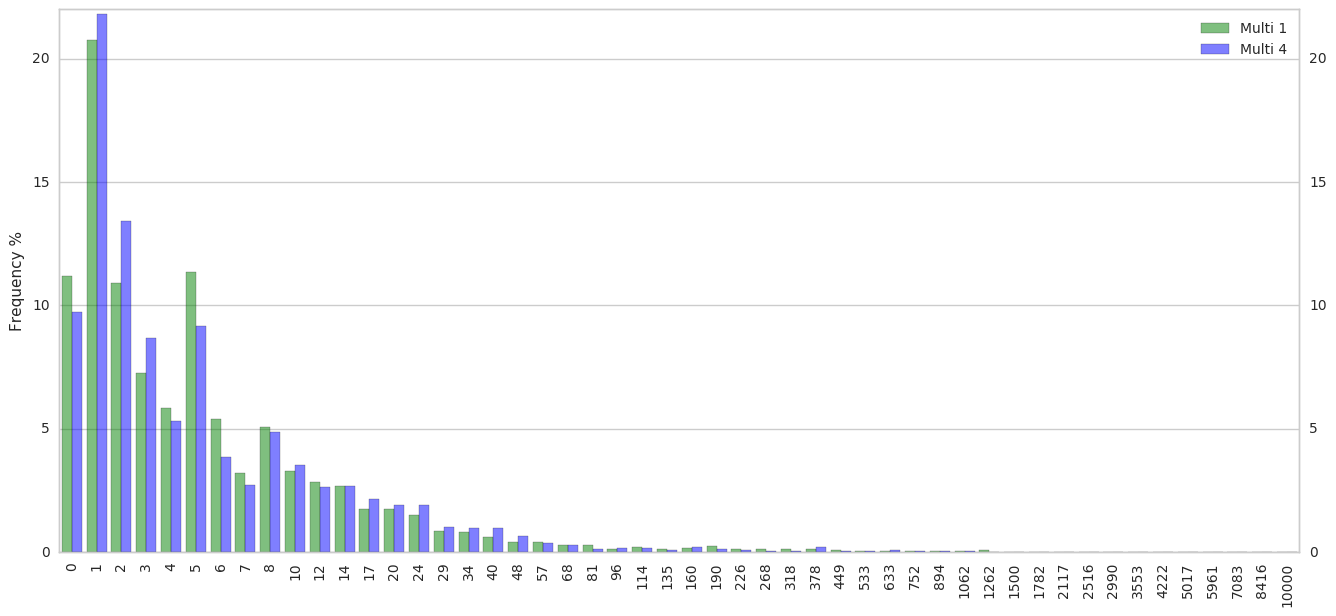

## 4+ Tabs

# Windows_NT

Comparison for CYCLE_COLLECTOR_MAX_PAUSE:

7447 (18.3%) multi_1 profiles on Windows_NT have the parent histogram.
7506 (18.4%) multi_4 profiles on Windows_NT have the parent histogram.
10417 (25.2%) webext_multi_1 profiles on Windows_NT have the parent histogram.
10367 (25.4%) webextx_multi_4 profiles on Windows_NT have the parent histogram.
8116 (27.4%) mpc_multi_1 profiles on Windows_NT have the parent histogram.
8055 (27.1%) mpc_multi_4 profiles on Windows_NT have the parent histogram.
7373 (18.1%) multi_1 profiles on Windows_NT have the child histogram.
7423 (18.2%) multi_4 profiles on Windows_NT have the child histogram.
10287 (24.9%) webext_multi_1 profiles on Windows_NT have the child histogram.
10253 (25.1%) webextx_multi_4 profiles on Windows_NT have the child histogram.
7979 (26.9%) mpc_multi_1 profiles on Windows_NT have the child histogram.
7942 (26.7%) mpc_multi_4 profiles on Windows_NT have the child histogram.


---
#### CYCLE_COLLECTOR_MAX_PAUSE (parent) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.658</b>.</span>
            

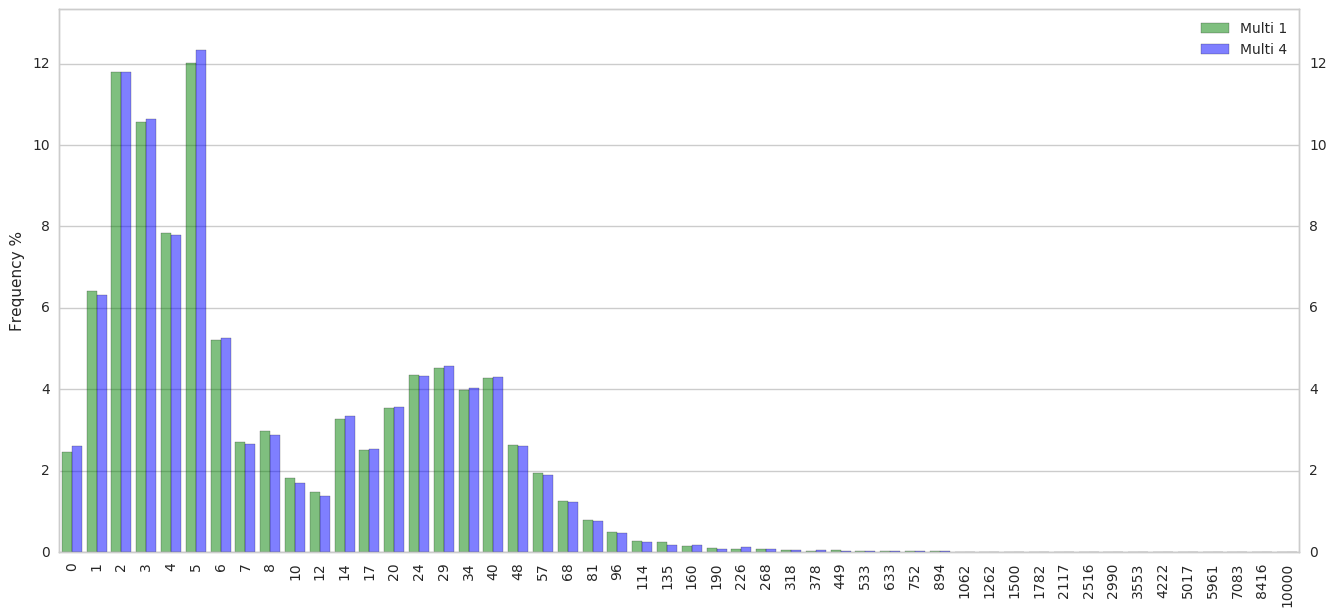

---
#### CYCLE_COLLECTOR_MAX_PAUSE (parent) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.357</b>.</span>
            

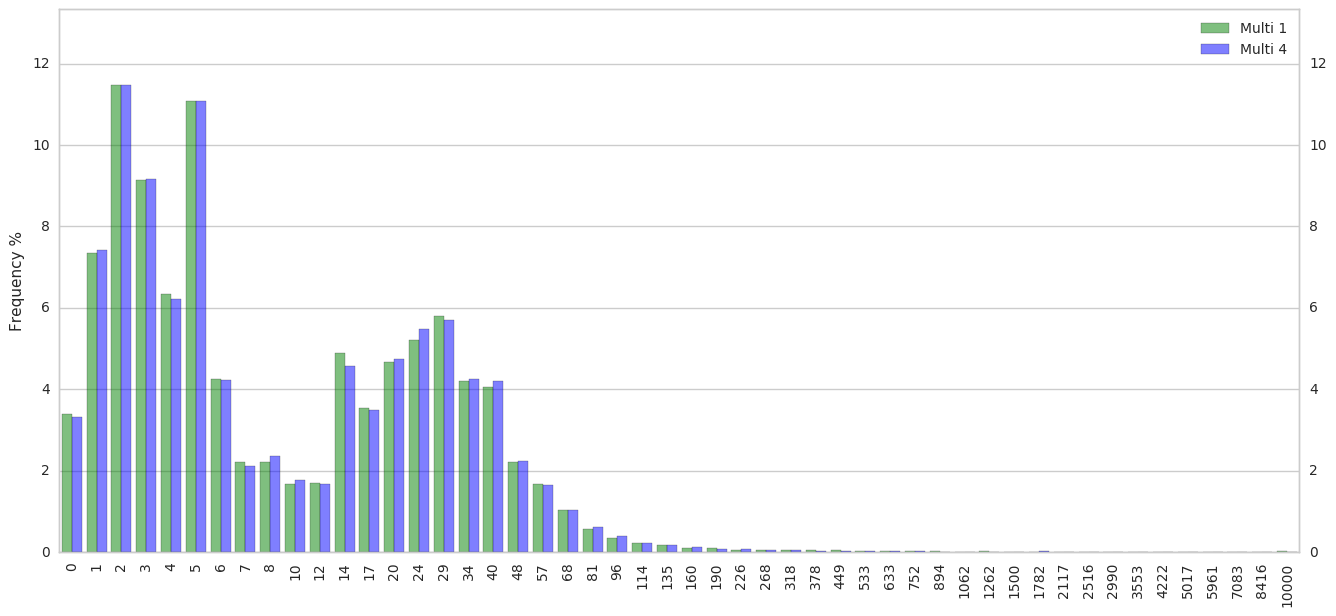

---
#### CYCLE_COLLECTOR_MAX_PAUSE (parent) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.840</b>.</span>
            

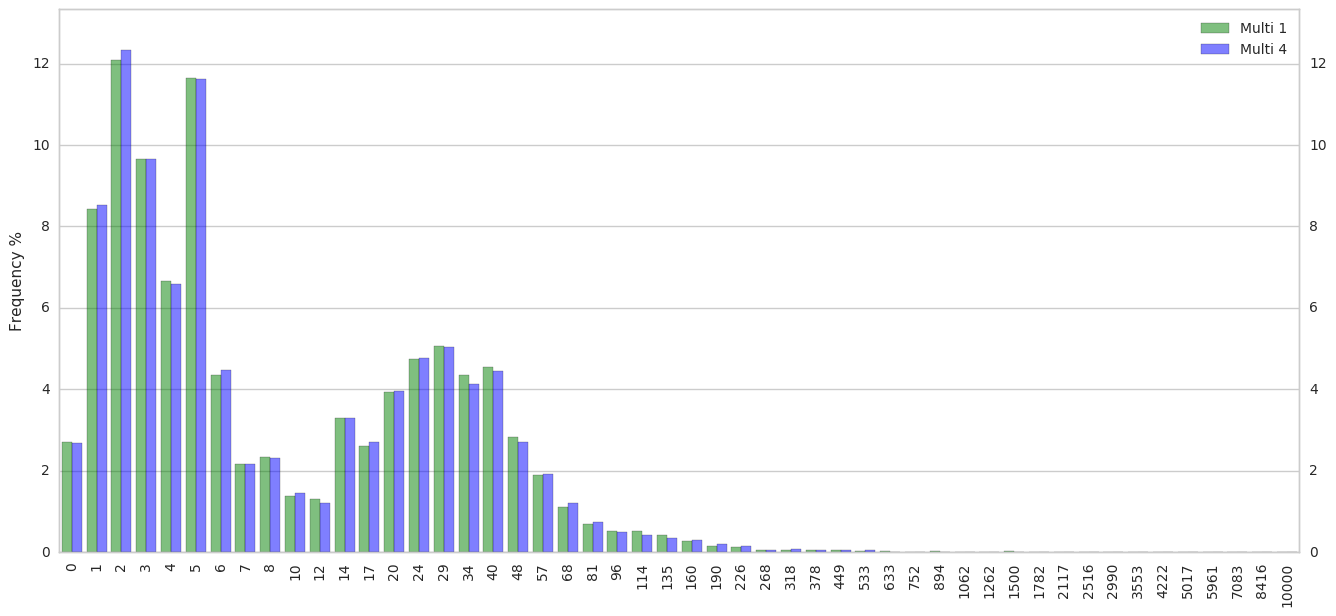

---
#### CYCLE_COLLECTOR_MAX_PAUSE (children) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.504</b>.</span>
            

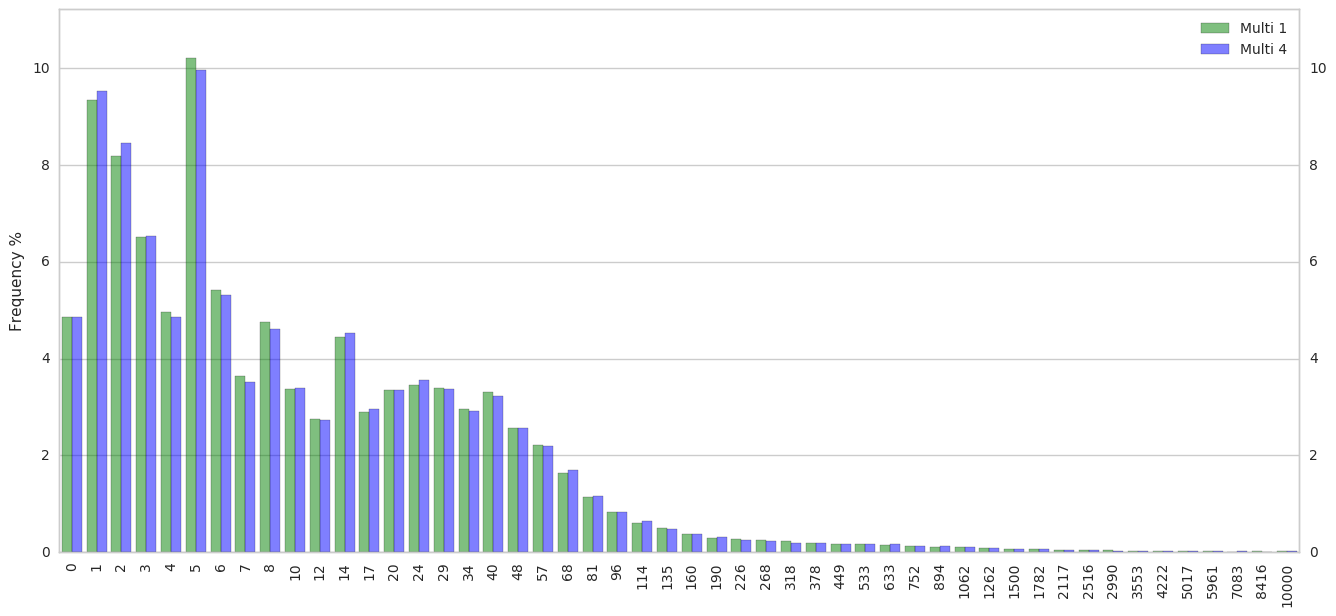

---
#### CYCLE_COLLECTOR_MAX_PAUSE (children) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.246</b>.</span>
            

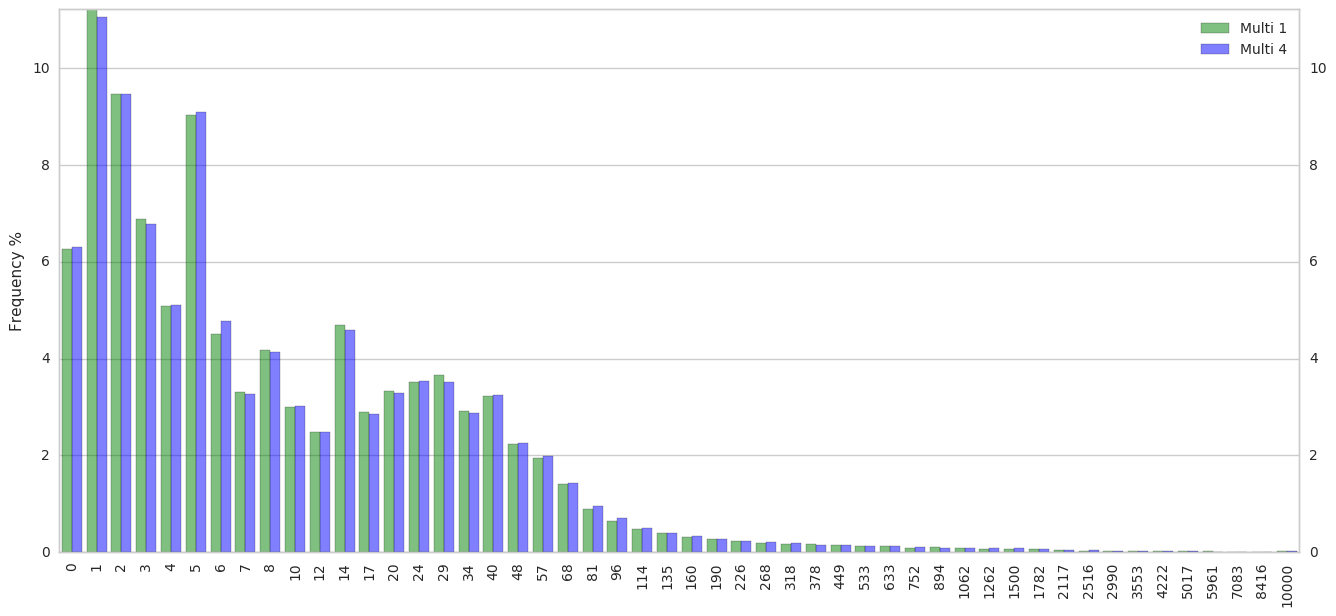

---
#### CYCLE_COLLECTOR_MAX_PAUSE (children) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.660</b>.</span>
            

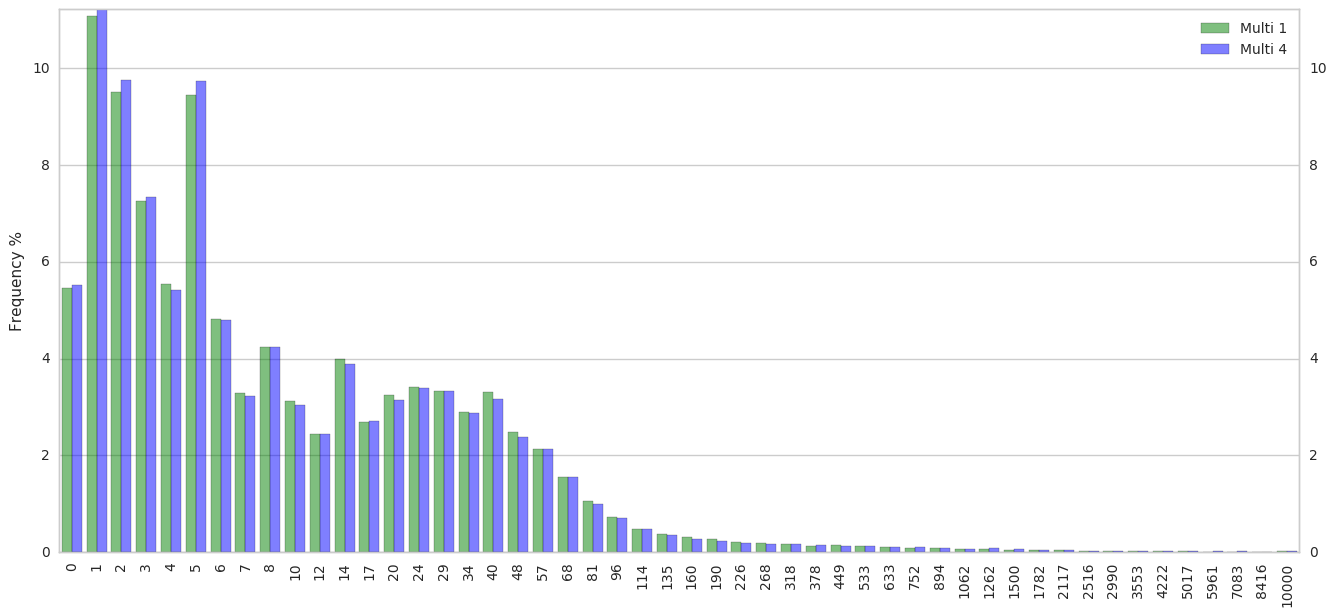

# Darwin

Comparison for CYCLE_COLLECTOR_MAX_PAUSE:

1101 (27.8%) multi_1 profiles on Darwin have the parent histogram.
1107 (27.9%) multi_4 profiles on Darwin have the parent histogram.
85 (35.4%) webext_multi_1 profiles on Darwin have the parent histogram.
97 (40.6%) webextx_multi_4 profiles on Darwin have the parent histogram.
177 (39.0%) mpc_multi_1 profiles on Darwin have the parent histogram.
153 (36.5%) mpc_multi_4 profiles on Darwin have the parent histogram.
1094 (27.6%) multi_1 profiles on Darwin have the child histogram.
1098 (27.7%) multi_4 profiles on Darwin have the child histogram.
84 (35.0%) webext_multi_1 profiles on Darwin have the child histogram.
95 (39.7%) webextx_multi_4 profiles on Darwin have the child histogram.
172 (37.9%) mpc_multi_1 profiles on Darwin have the child histogram.
152 (36.3%) mpc_multi_4 profiles on Darwin have the child histogram.


---
#### CYCLE_COLLECTOR_MAX_PAUSE (parent) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.717</b>.</span>
            

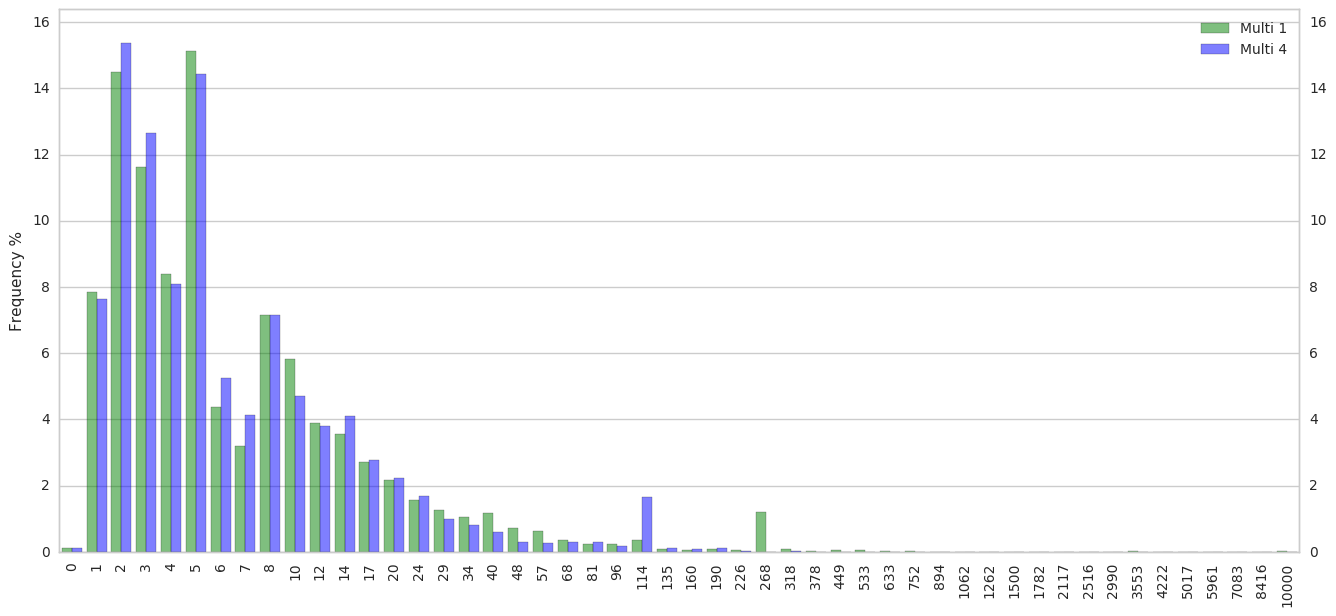

---
#### CYCLE_COLLECTOR_MAX_PAUSE (parent) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.318</b>.</span>
            

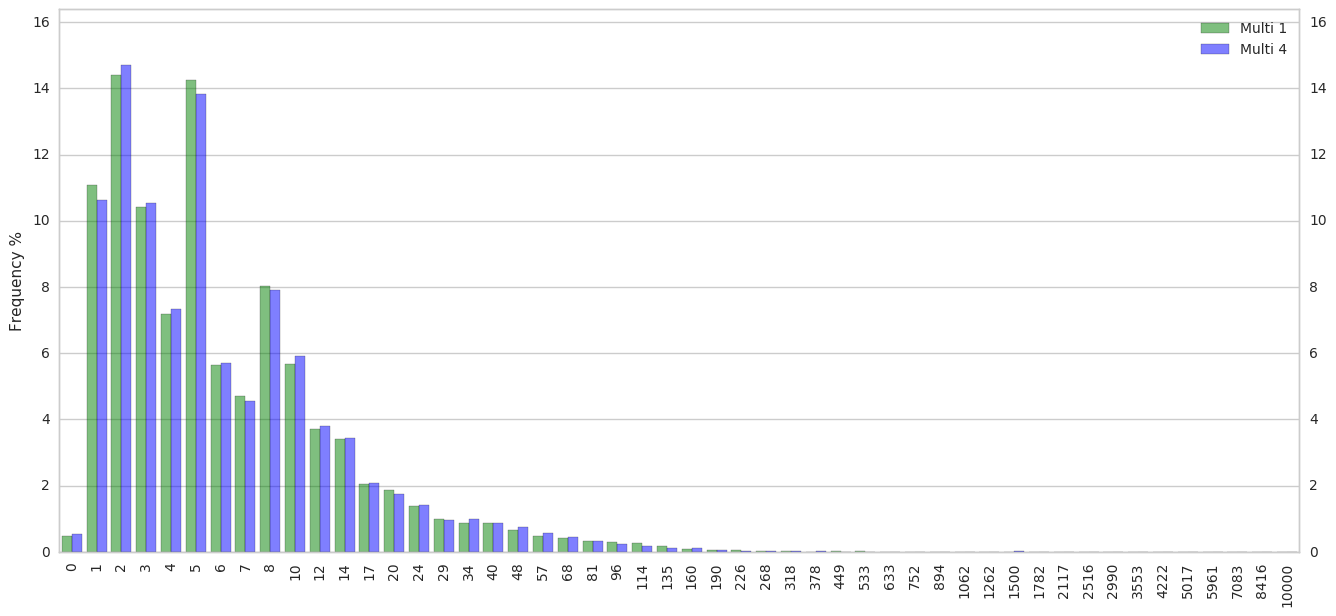

---
#### CYCLE_COLLECTOR_MAX_PAUSE (parent) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.793</b>.</span>
            

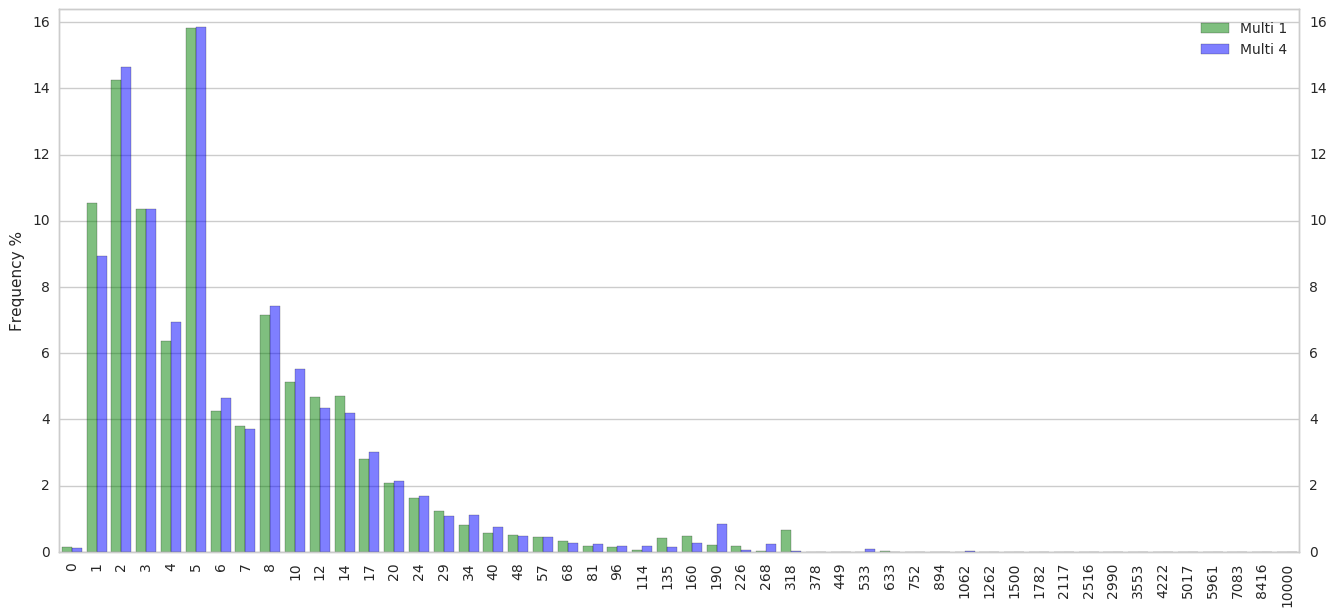

---
#### CYCLE_COLLECTOR_MAX_PAUSE (children) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.740</b>.</span>
            

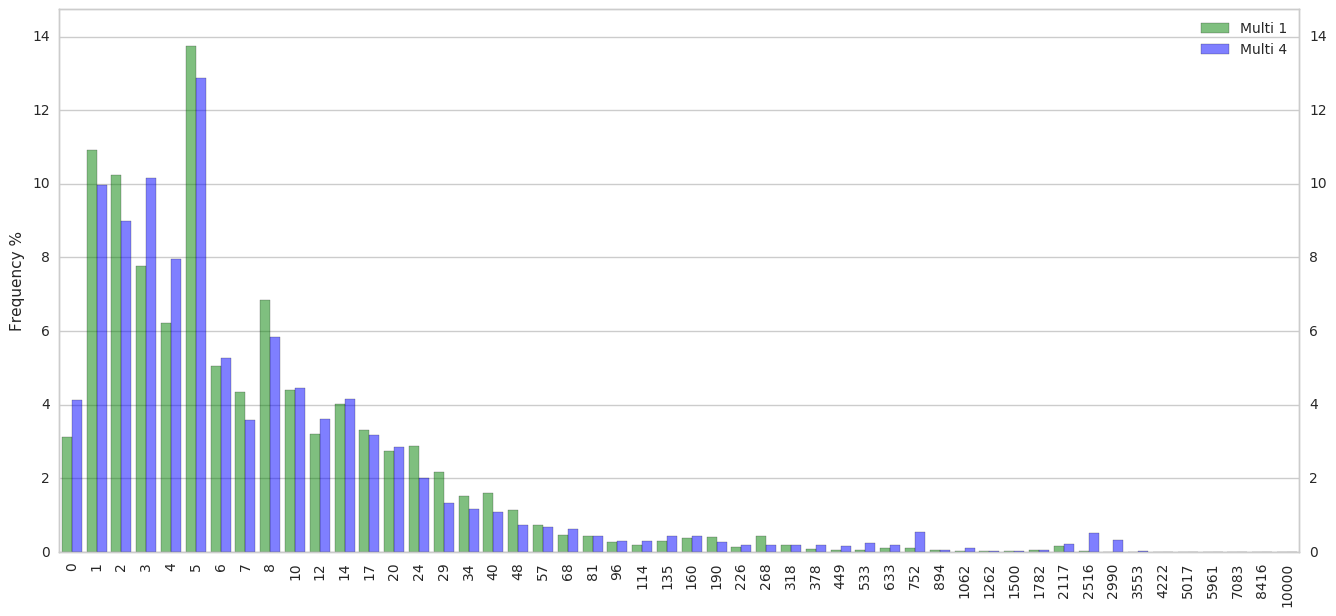

---
#### CYCLE_COLLECTOR_MAX_PAUSE (children) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.953</b>.</span>
            

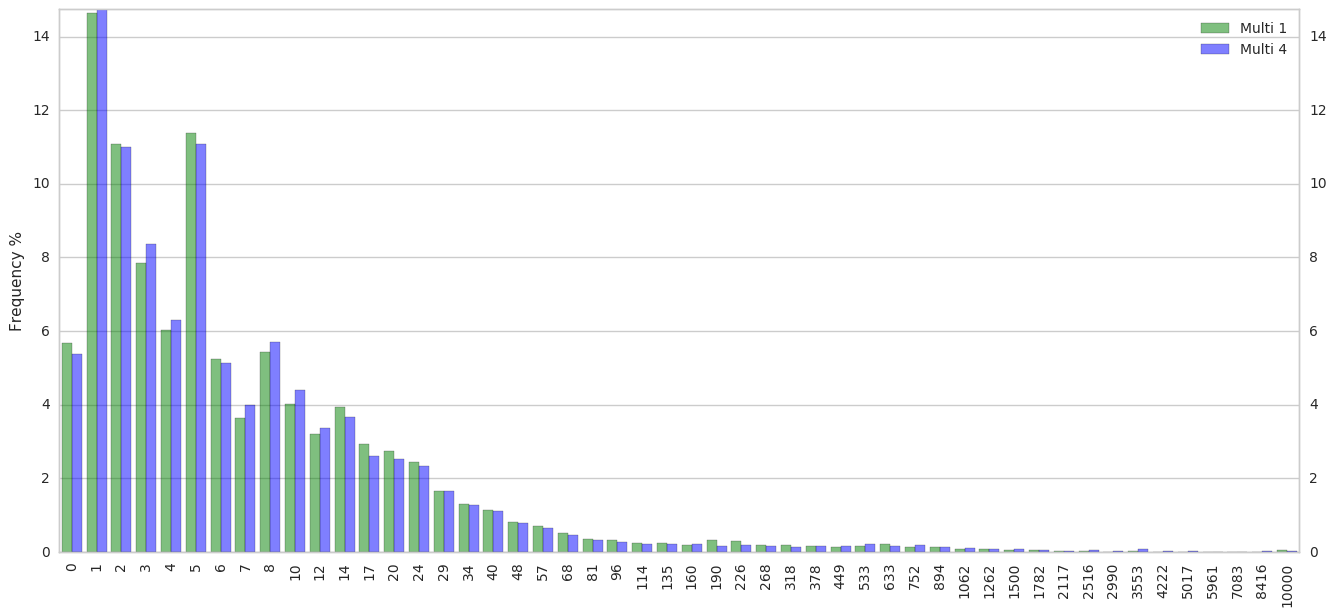

---
#### CYCLE_COLLECTOR_MAX_PAUSE (children) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.164</b>.</span>
            

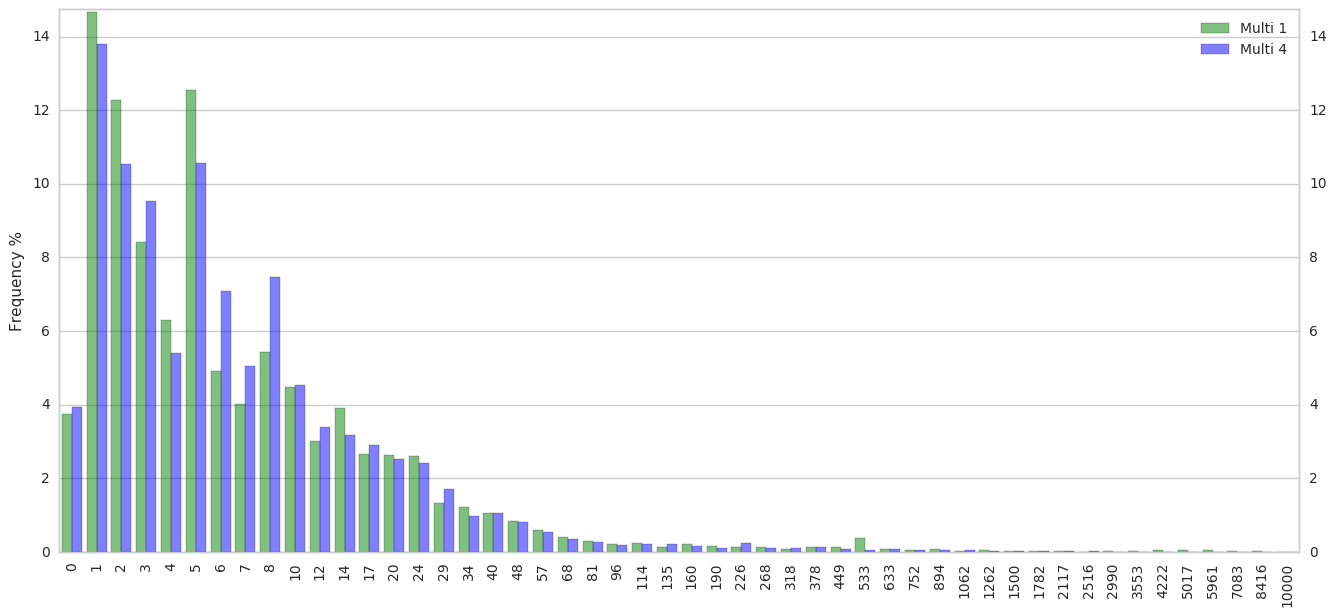

In [109]:
results.extend(compare_tab_groups(t3, t4, "payload/histograms/CYCLE_COLLECTOR_MAX_PAUSE"))

### INPUT_EVENT_RESPONSE_MS

## 1-3 Tabs

# Windows_NT

Comparison for INPUT_EVENT_RESPONSE_MS:

32999 (81.1%) multi_1 profiles on Windows_NT have the parent histogram.
33062 (81.1%) multi_4 profiles on Windows_NT have the parent histogram.
30489 (73.8%) webext_multi_1 profiles on Windows_NT have the parent histogram.
30023 (73.6%) webextx_multi_4 profiles on Windows_NT have the parent histogram.
21205 (71.6%) mpc_multi_1 profiles on Windows_NT have the parent histogram.
21315 (71.8%) mpc_multi_4 profiles on Windows_NT have the parent histogram.
31207 (76.7%) multi_1 profiles on Windows_NT have the child histogram.
31266 (76.7%) multi_4 profiles on Windows_NT have the child histogram.
28680 (69.4%) webext_multi_1 profiles on Windows_NT have the child histogram.
28232 (69.2%) webextx_multi_4 profiles on Windows_NT have the child histogram.
20304 (68.6%) mpc_multi_1 profiles on Windows_NT have the child histogram.
20354 (68.6%) mpc_multi_4 profiles on Windows_NT have the child histogram.


---
#### INPUT_EVENT_RESPONSE_MS (parent) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.941</b>.</span>
            

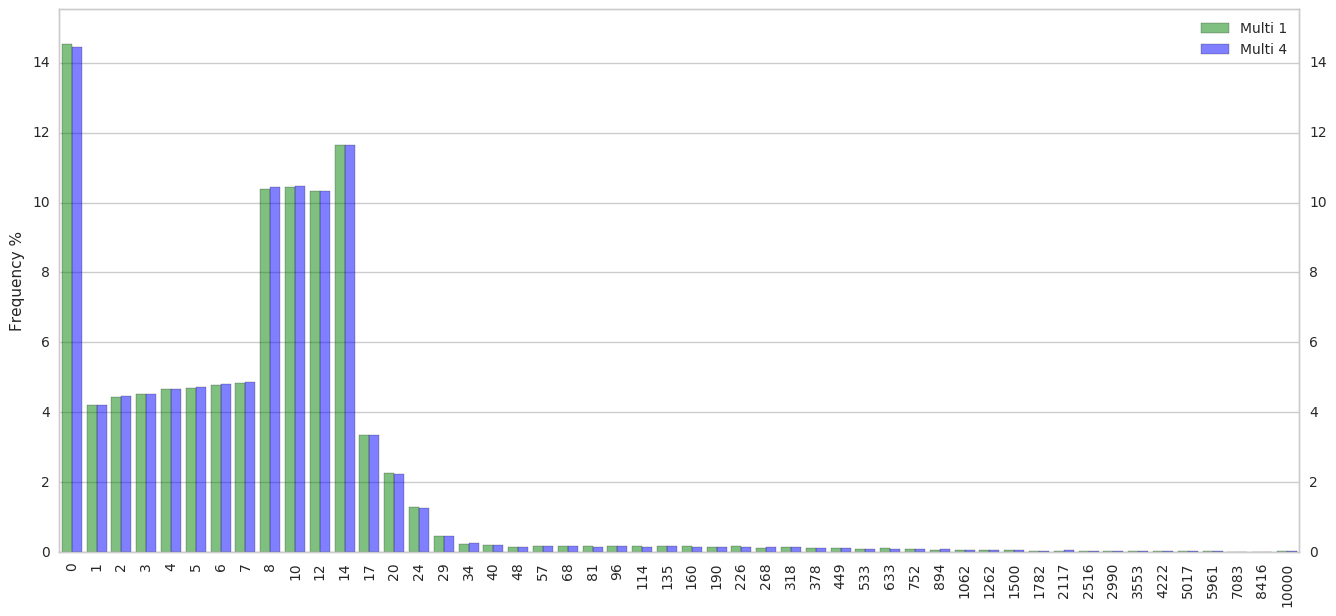

---
#### INPUT_EVENT_RESPONSE_MS (parent) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.055</b>.</span>
            

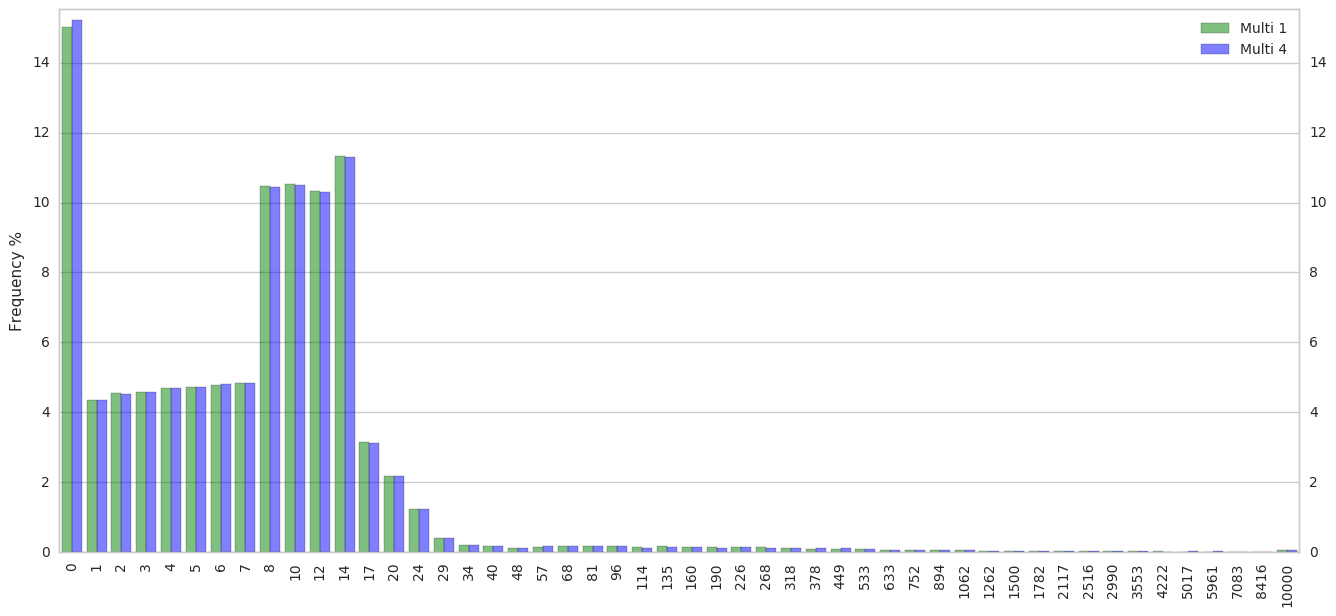

---
#### INPUT_EVENT_RESPONSE_MS (parent) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.055</b>.</span>
            

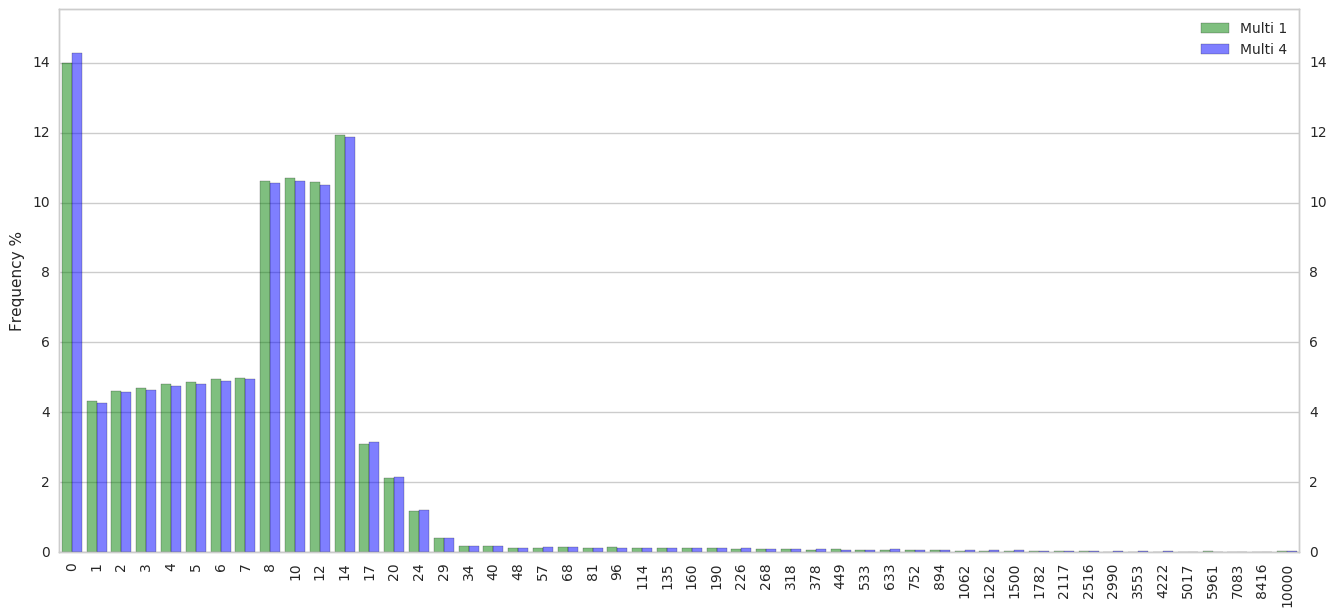

---
#### INPUT_EVENT_RESPONSE_MS (children) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.631</b>.</span>
            

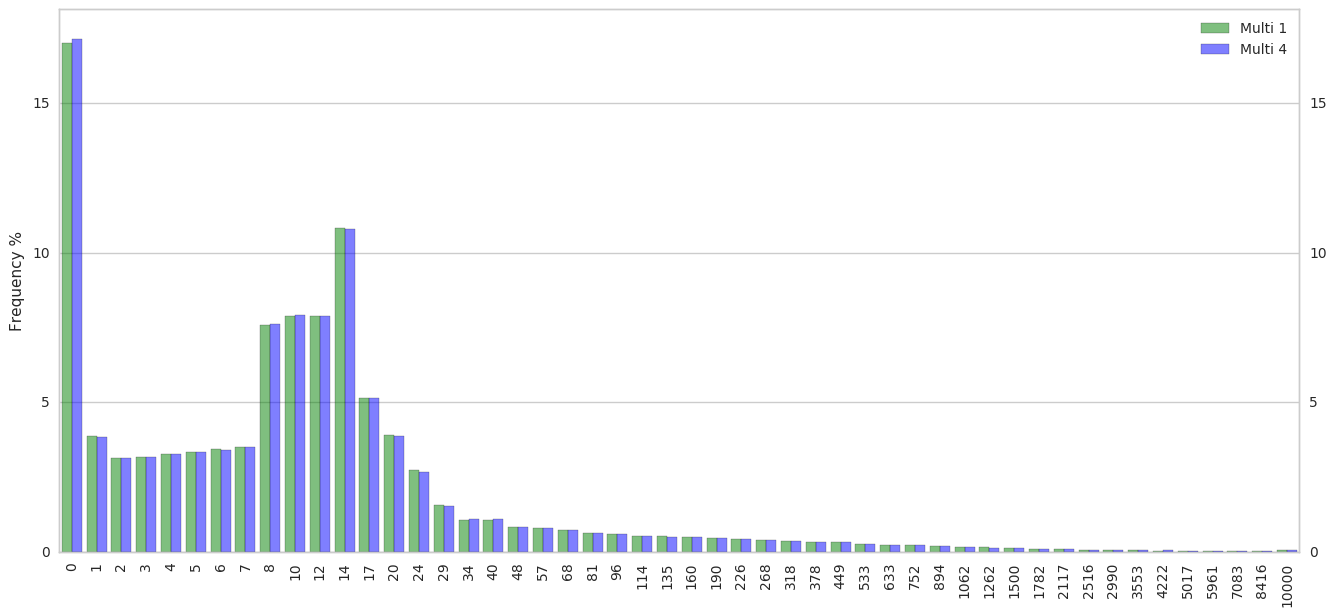

---
#### INPUT_EVENT_RESPONSE_MS (children) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.396</b>.</span>
            

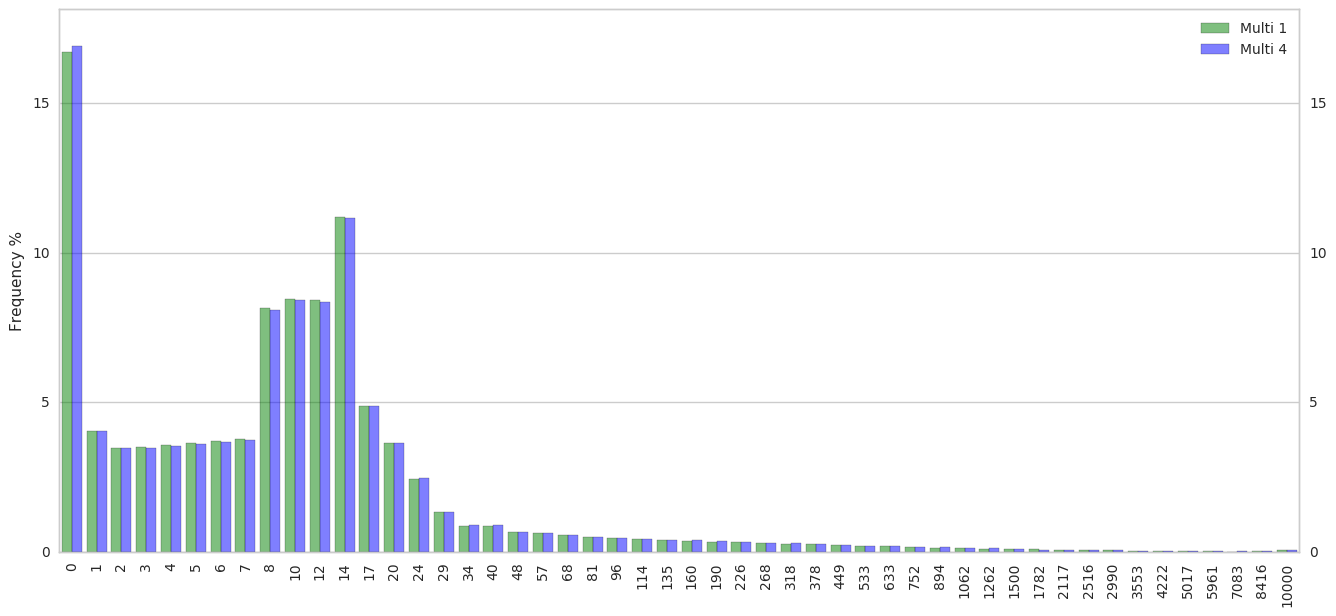

---
#### INPUT_EVENT_RESPONSE_MS (children) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.273</b>.</span>
            

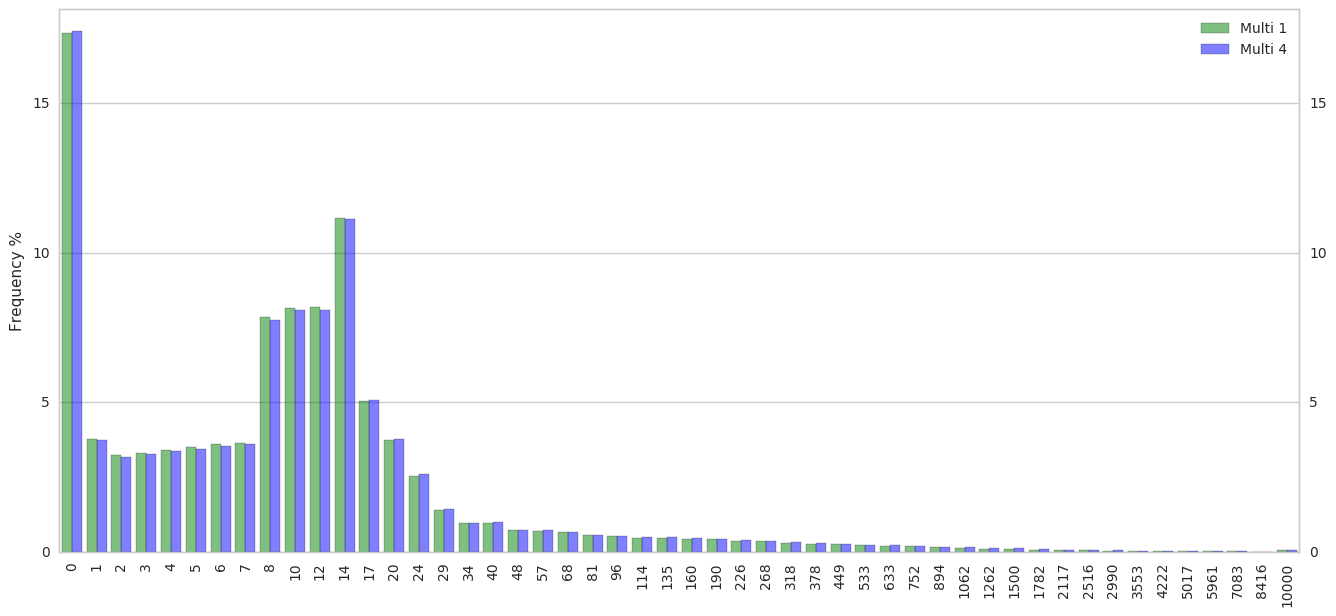

# Darwin

Comparison for INPUT_EVENT_RESPONSE_MS:

2822 (71.3%) multi_1 profiles on Darwin have the parent histogram.
2819 (71.2%) multi_4 profiles on Darwin have the parent histogram.
155 (64.6%) webext_multi_1 profiles on Darwin have the parent histogram.
142 (59.4%) webextx_multi_4 profiles on Darwin have the parent histogram.
270 (59.5%) mpc_multi_1 profiles on Darwin have the parent histogram.
262 (62.5%) mpc_multi_4 profiles on Darwin have the parent histogram.
2694 (68.1%) multi_1 profiles on Darwin have the child histogram.
2691 (67.9%) multi_4 profiles on Darwin have the child histogram.
152 (63.3%) webext_multi_1 profiles on Darwin have the child histogram.
140 (58.6%) webextx_multi_4 profiles on Darwin have the child histogram.
262 (57.7%) mpc_multi_1 profiles on Darwin have the child histogram.
254 (60.6%) mpc_multi_4 profiles on Darwin have the child histogram.


---
#### INPUT_EVENT_RESPONSE_MS (parent) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.695</b>.</span>
            

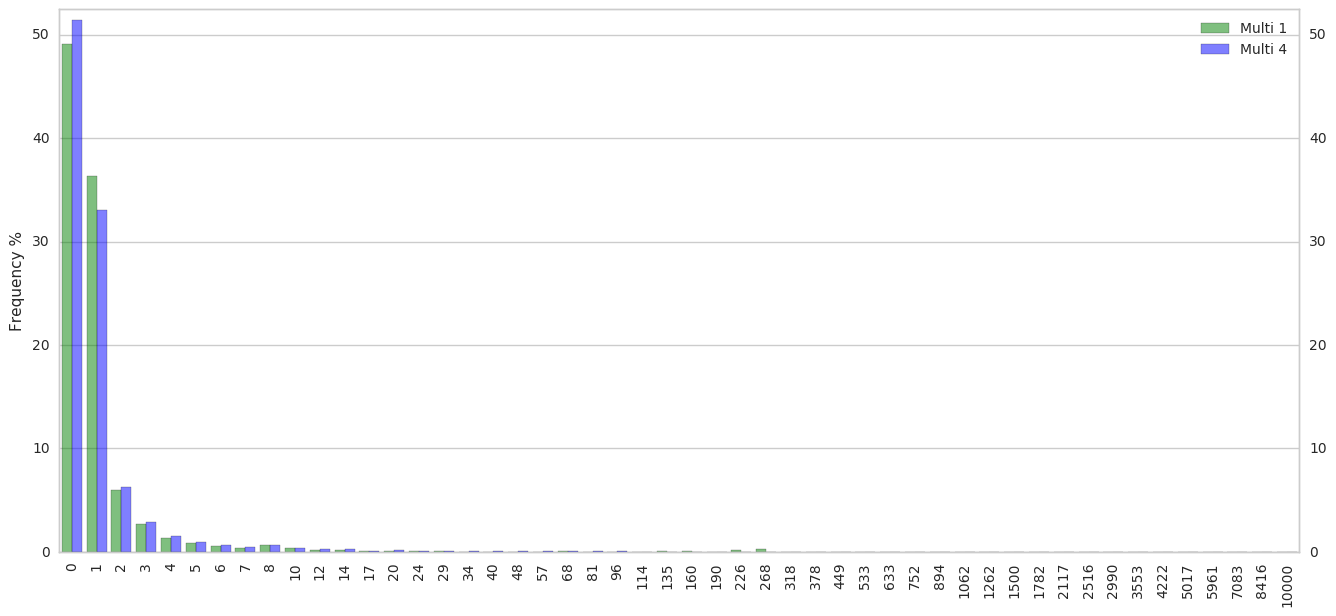

---
#### INPUT_EVENT_RESPONSE_MS (parent) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.949</b>.</span>
            

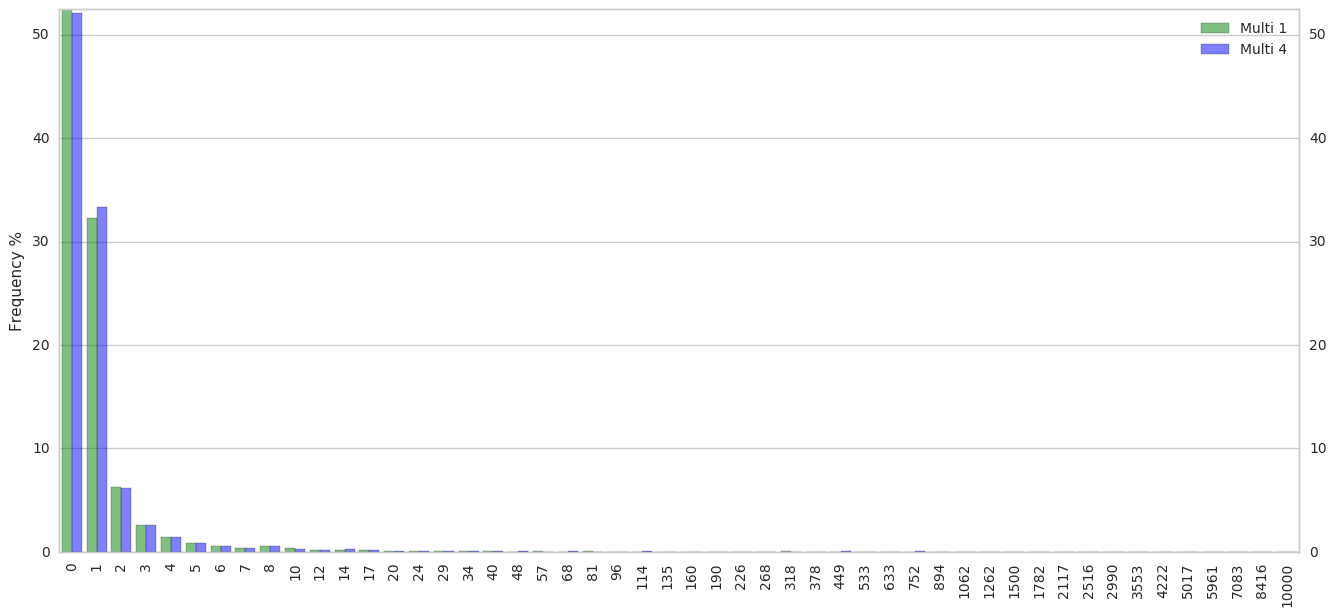

---
#### INPUT_EVENT_RESPONSE_MS (parent) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:red"><b>0.033</b>.</span>
            

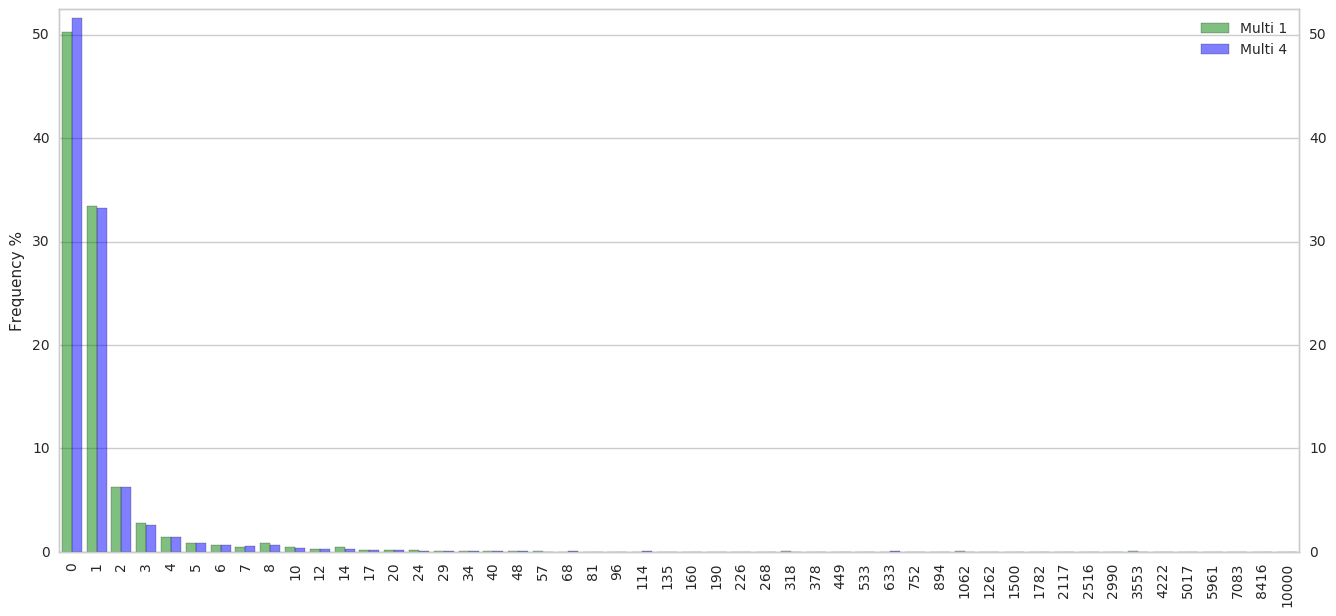

---
#### INPUT_EVENT_RESPONSE_MS (children) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.539</b>.</span>
            

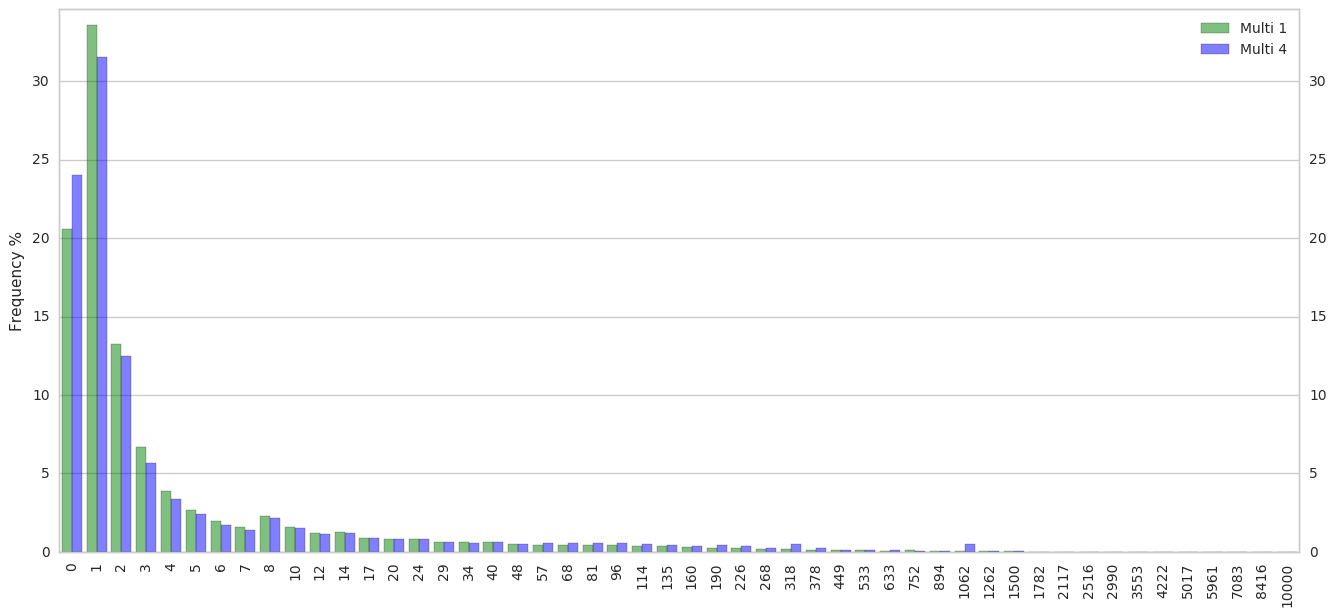

---
#### INPUT_EVENT_RESPONSE_MS (children) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.795</b>.</span>
            

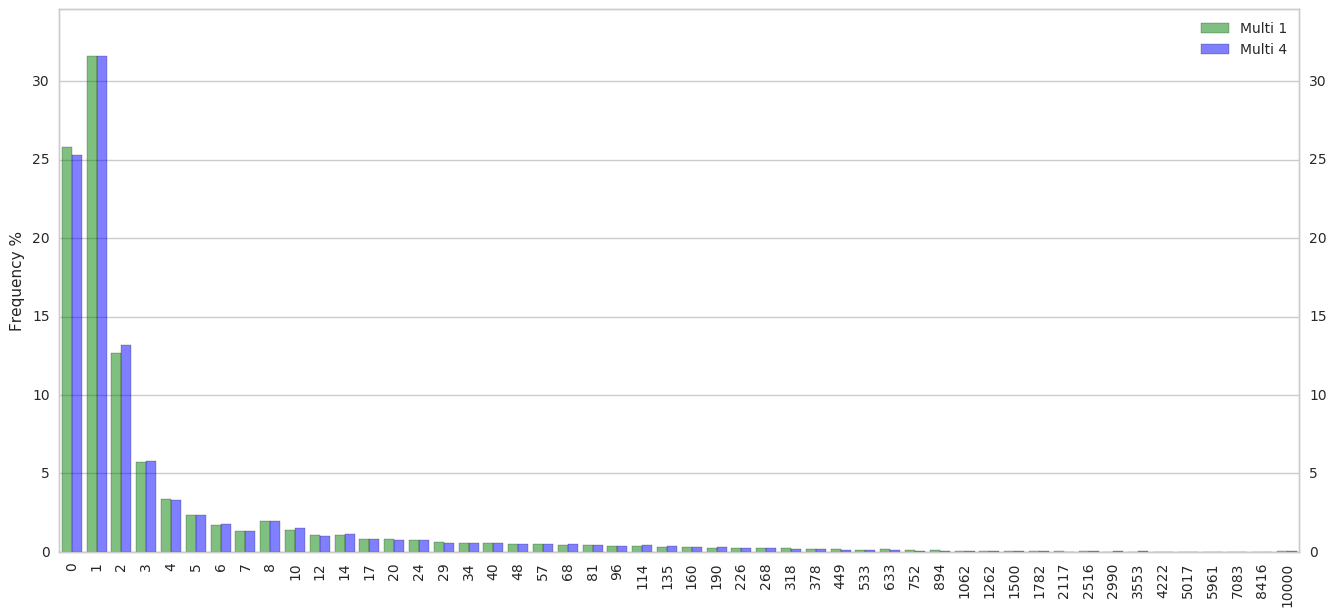

---
#### INPUT_EVENT_RESPONSE_MS (children) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.922</b>.</span>
            

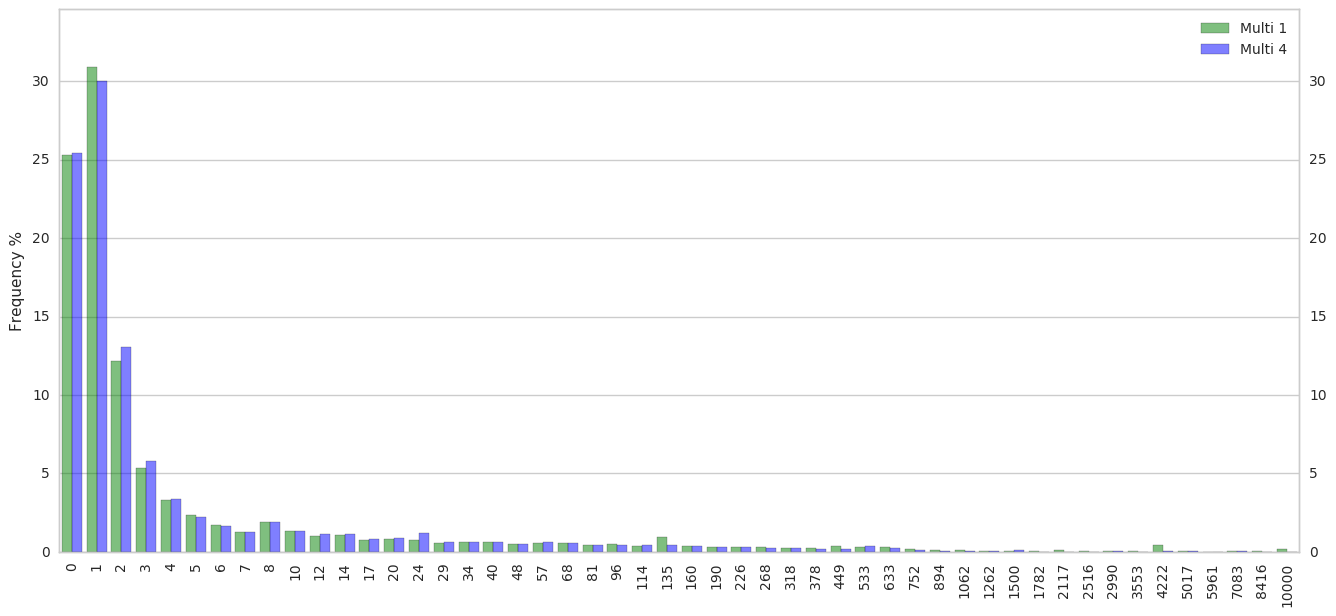

## 4+ Tabs

# Windows_NT

Comparison for INPUT_EVENT_RESPONSE_MS:

7686 (18.9%) multi_1 profiles on Windows_NT have the parent histogram.
7729 (19.0%) multi_4 profiles on Windows_NT have the parent histogram.
10807 (26.2%) webext_multi_1 profiles on Windows_NT have the parent histogram.
10779 (26.4%) webextx_multi_4 profiles on Windows_NT have the parent histogram.
8394 (28.3%) mpc_multi_1 profiles on Windows_NT have the parent histogram.
8360 (28.2%) mpc_multi_4 profiles on Windows_NT have the parent histogram.
7488 (18.4%) multi_1 profiles on Windows_NT have the child histogram.
7536 (18.5%) multi_4 profiles on Windows_NT have the child histogram.
10477 (25.4%) webext_multi_1 profiles on Windows_NT have the child histogram.
10453 (25.6%) webextx_multi_4 profiles on Windows_NT have the child histogram.
8146 (27.5%) mpc_multi_1 profiles on Windows_NT have the child histogram.
8105 (27.3%) mpc_multi_4 profiles on Windows_NT have the child histogram.


---
#### INPUT_EVENT_RESPONSE_MS (parent) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.602</b>.</span>
            

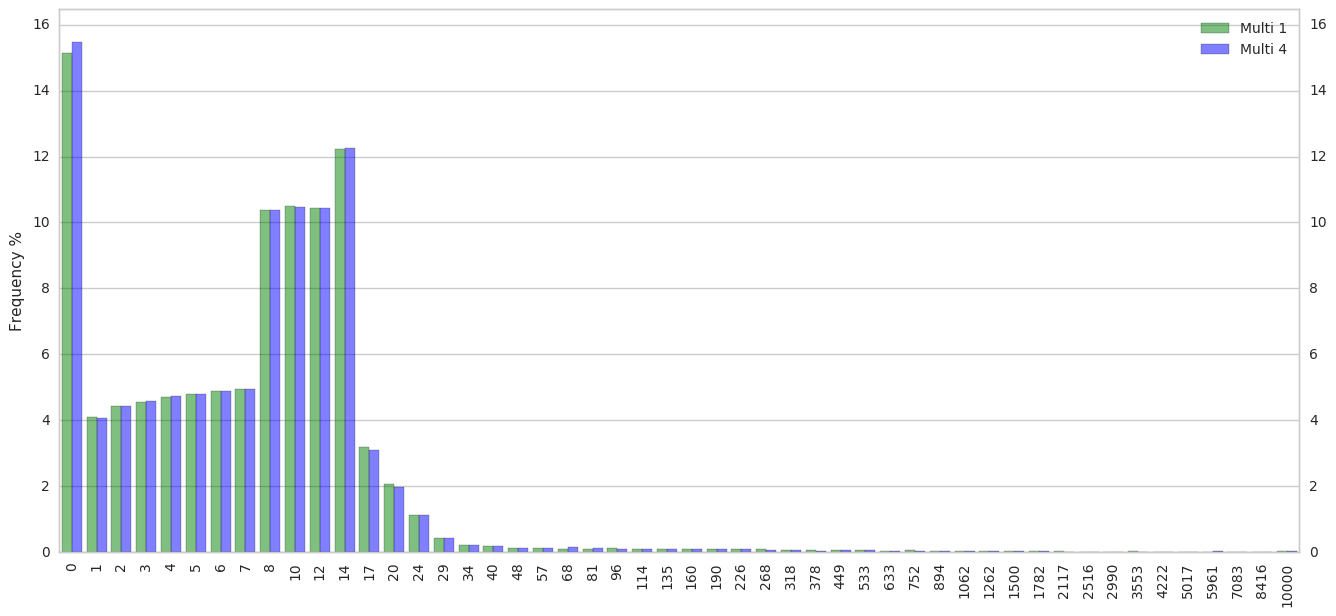

---
#### INPUT_EVENT_RESPONSE_MS (parent) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.527</b>.</span>
            

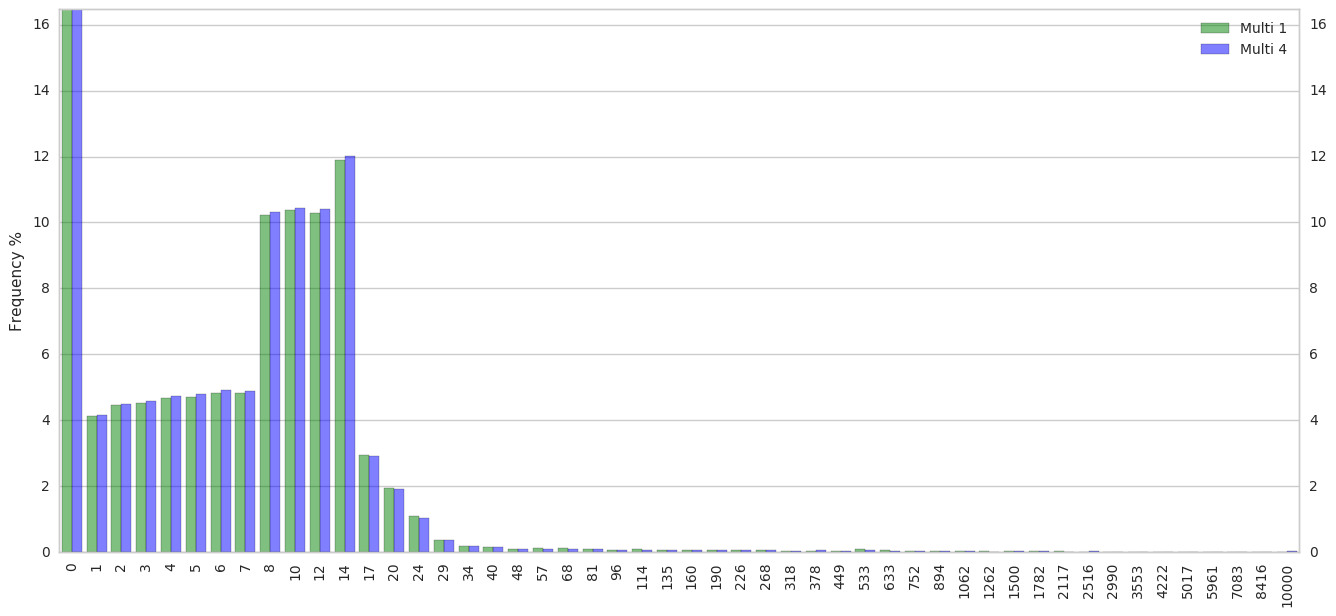

---
#### INPUT_EVENT_RESPONSE_MS (parent) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.746</b>.</span>
            

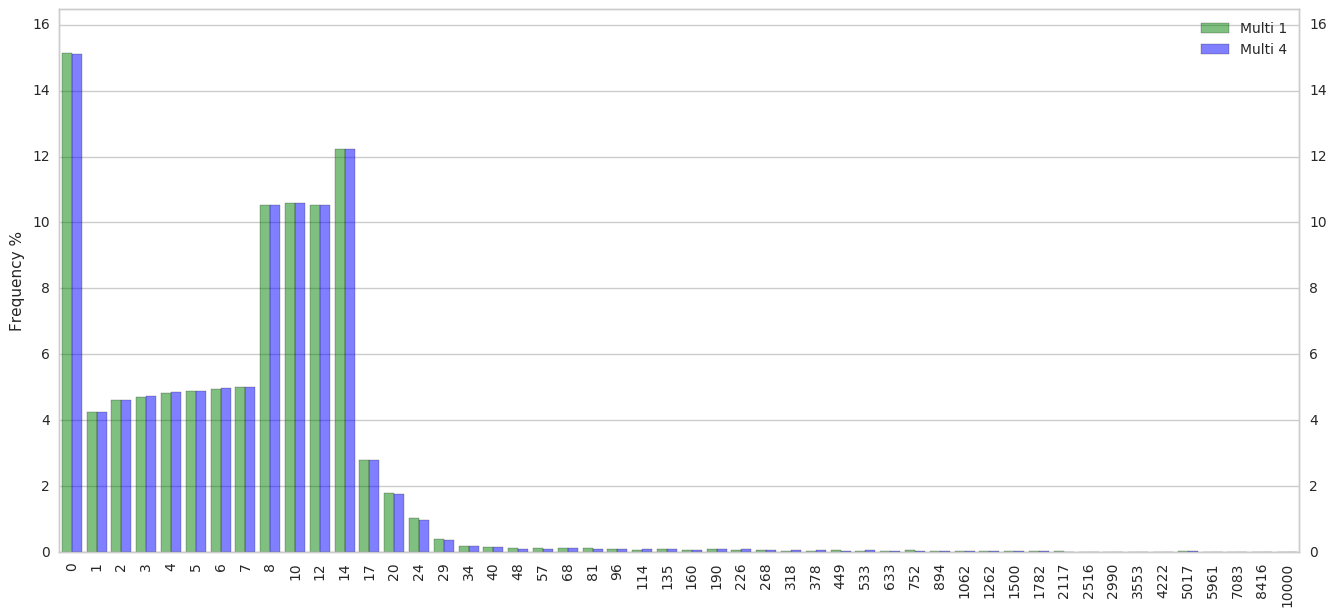

---
#### INPUT_EVENT_RESPONSE_MS (children) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.812</b>.</span>
            

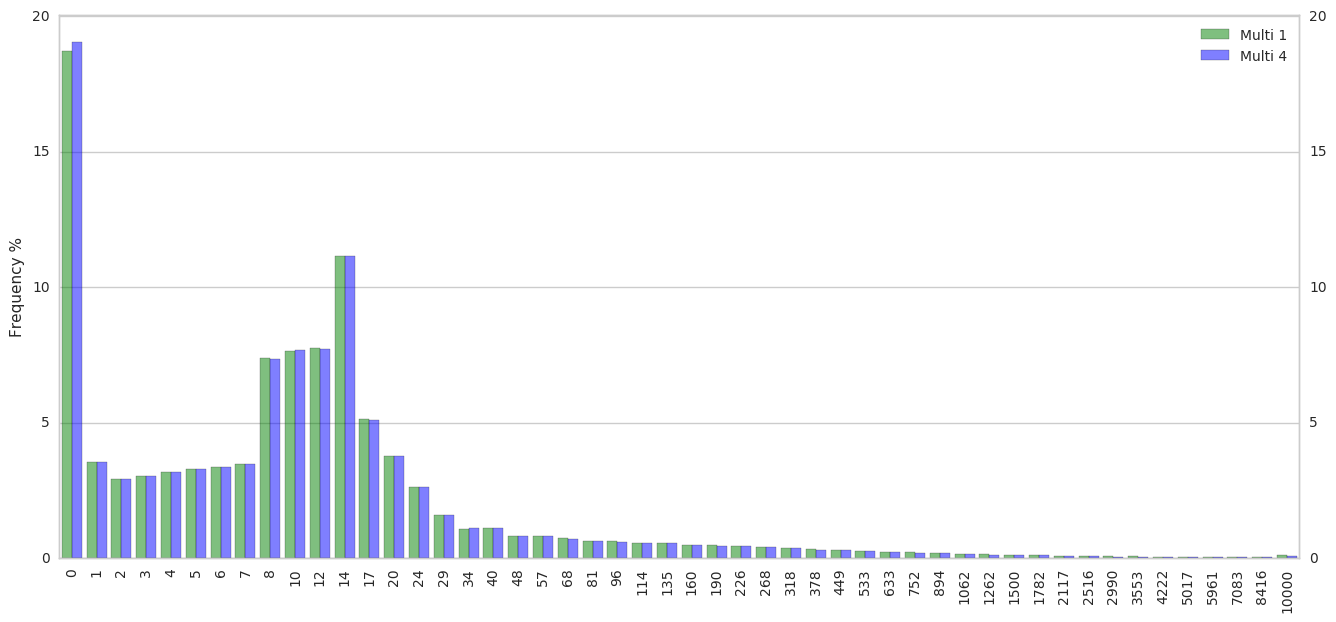

---
#### INPUT_EVENT_RESPONSE_MS (children) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:red"><b>0.039</b>.</span>
            

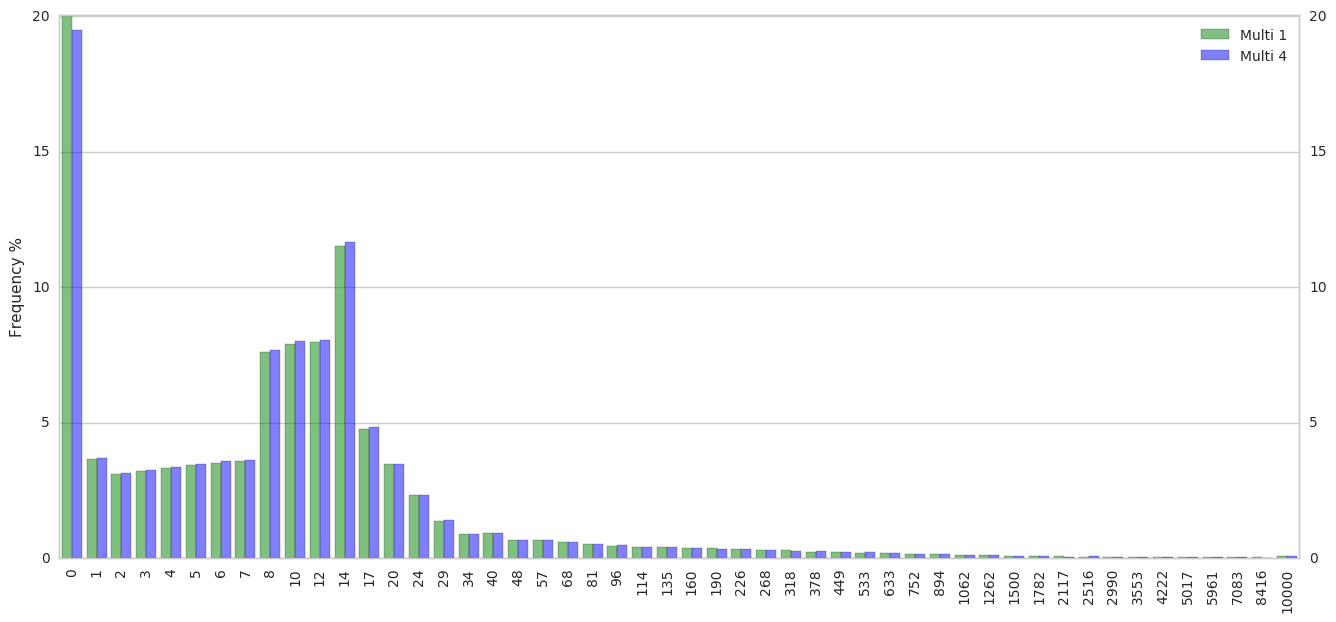

---
#### INPUT_EVENT_RESPONSE_MS (children) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.430</b>.</span>
            

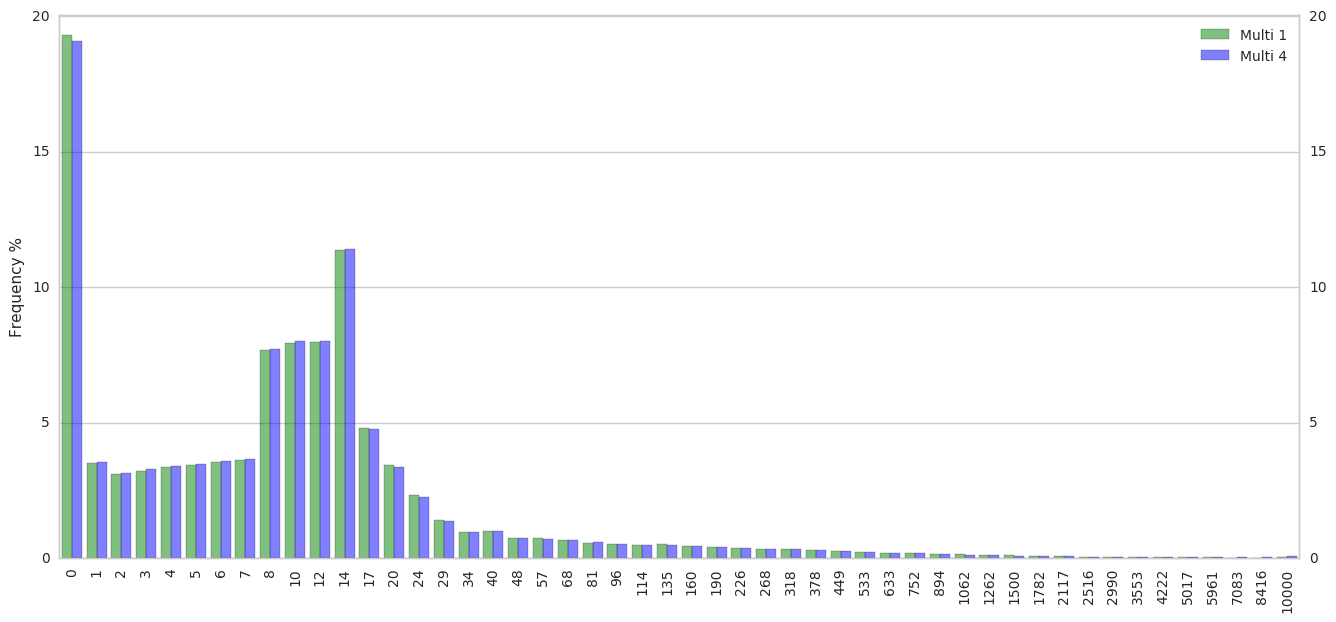

# Darwin

Comparison for INPUT_EVENT_RESPONSE_MS:

1107 (28.0%) multi_1 profiles on Darwin have the parent histogram.
1115 (28.1%) multi_4 profiles on Darwin have the parent histogram.
85 (35.4%) webext_multi_1 profiles on Darwin have the parent histogram.
97 (40.6%) webextx_multi_4 profiles on Darwin have the parent histogram.
180 (39.6%) mpc_multi_1 profiles on Darwin have the parent histogram.
154 (36.8%) mpc_multi_4 profiles on Darwin have the parent histogram.
1091 (27.6%) multi_1 profiles on Darwin have the child histogram.
1096 (27.7%) multi_4 profiles on Darwin have the child histogram.
82 (34.2%) webext_multi_1 profiles on Darwin have the child histogram.
96 (40.2%) webextx_multi_4 profiles on Darwin have the child histogram.
171 (37.7%) mpc_multi_1 profiles on Darwin have the child histogram.
152 (36.3%) mpc_multi_4 profiles on Darwin have the child histogram.


---
#### INPUT_EVENT_RESPONSE_MS (parent) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.961</b>.</span>
            

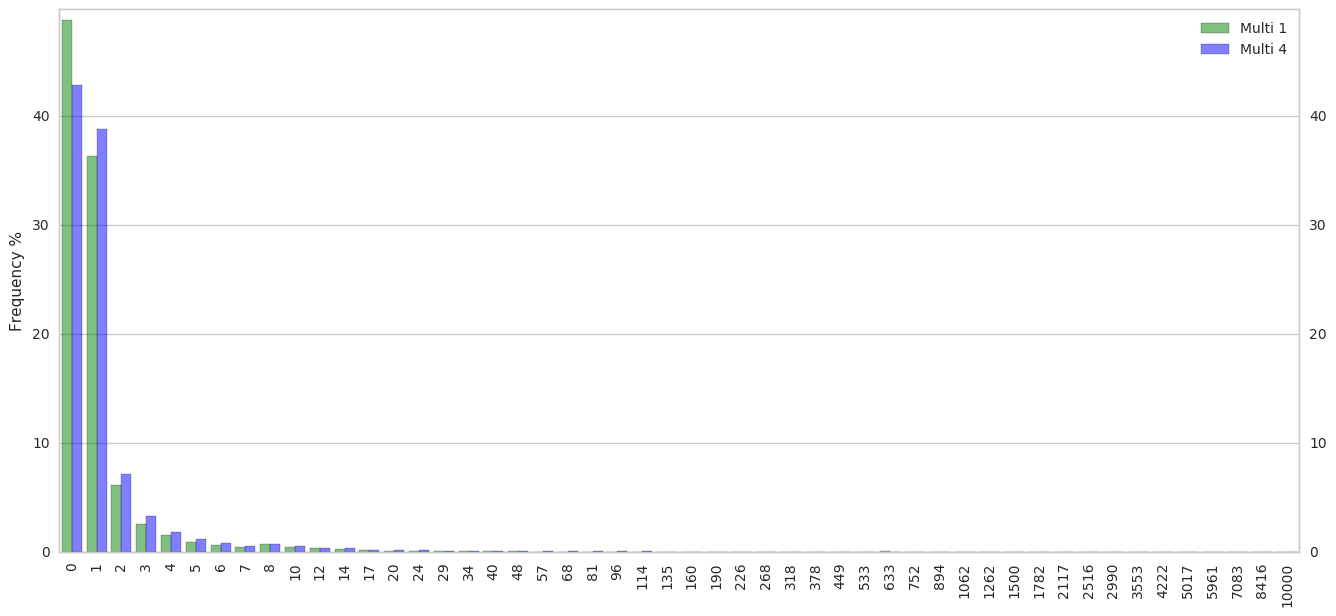

---
#### INPUT_EVENT_RESPONSE_MS (parent) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.861</b>.</span>
            

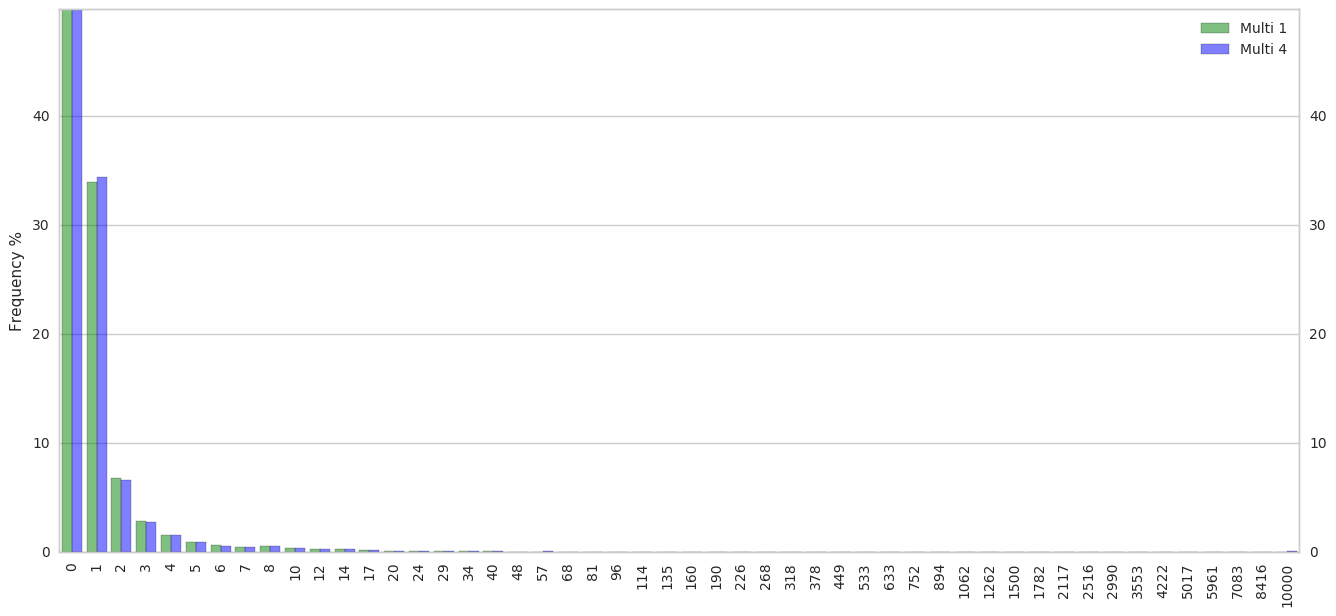

---
#### INPUT_EVENT_RESPONSE_MS (parent) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.752</b>.</span>
            

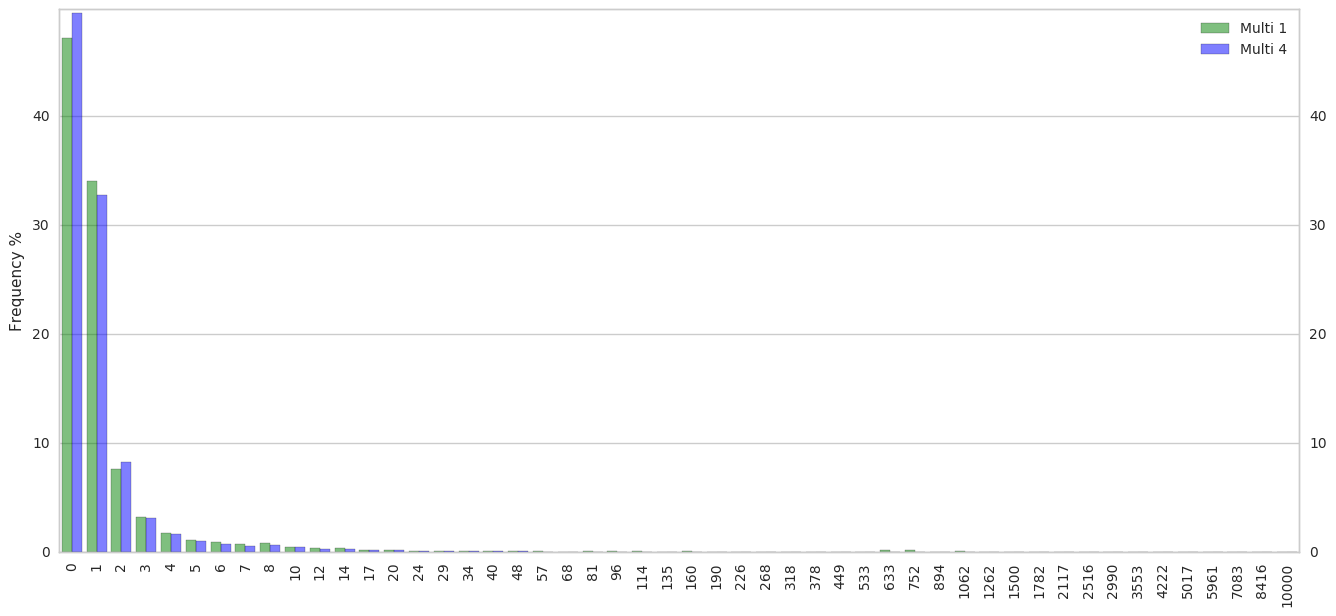

---
#### INPUT_EVENT_RESPONSE_MS (children) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.943</b>.</span>
            

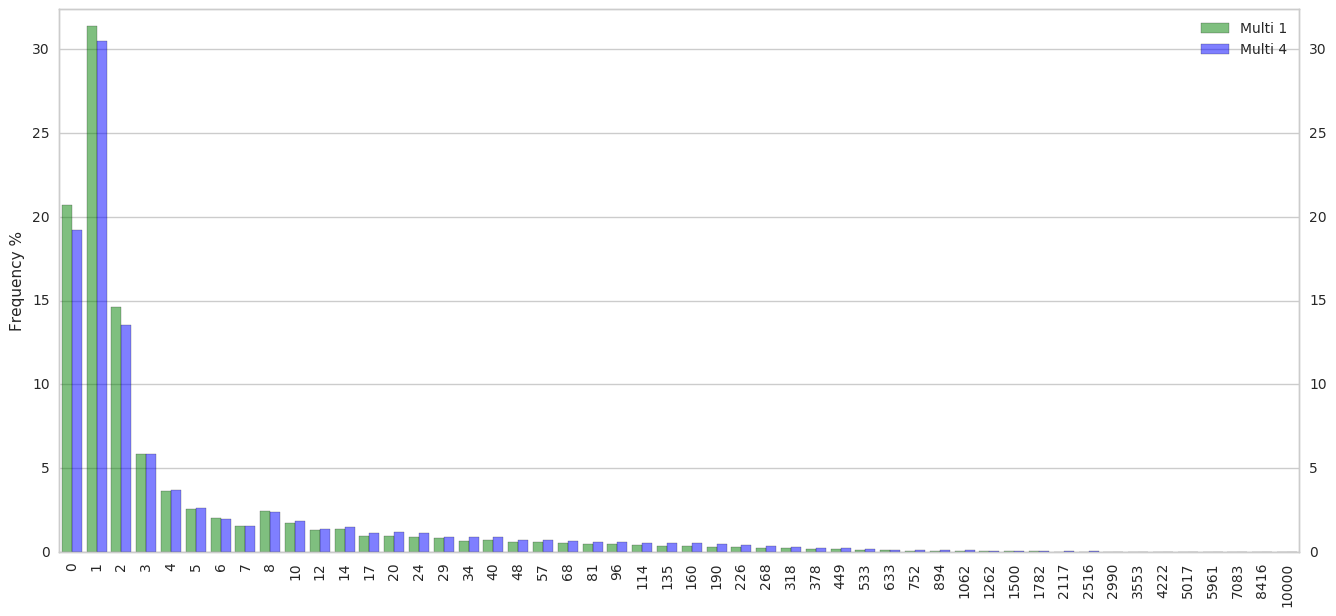

---
#### INPUT_EVENT_RESPONSE_MS (children) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.223</b>.</span>
            

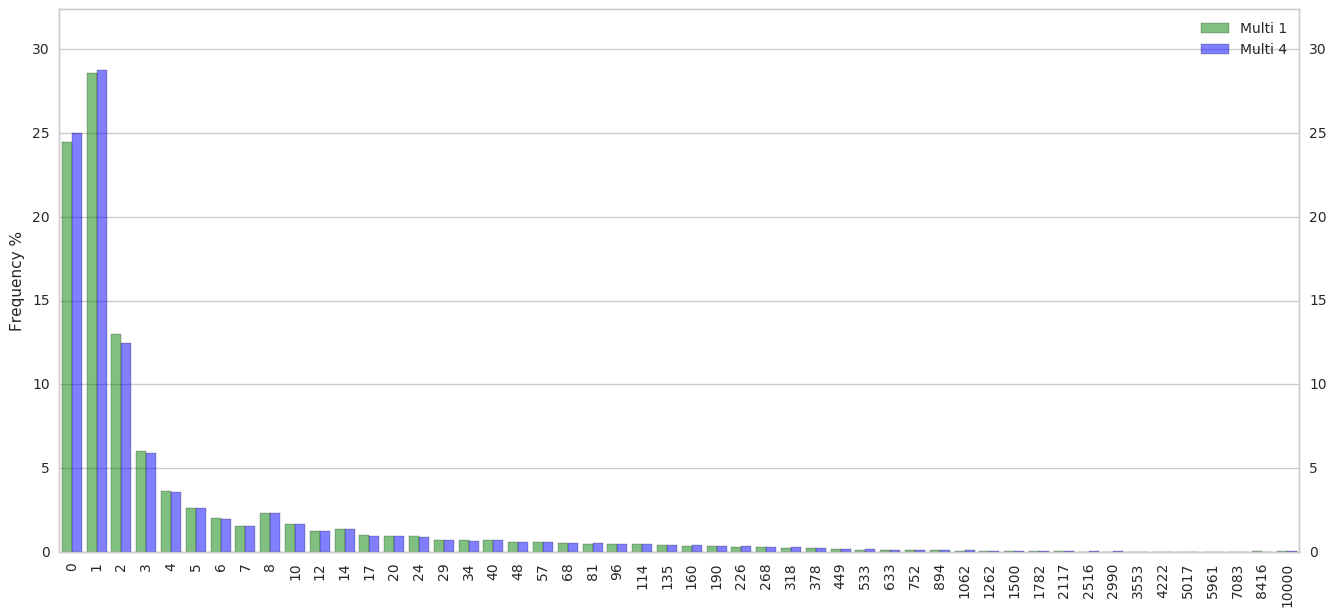

---
#### INPUT_EVENT_RESPONSE_MS (children) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.264</b>.</span>
            

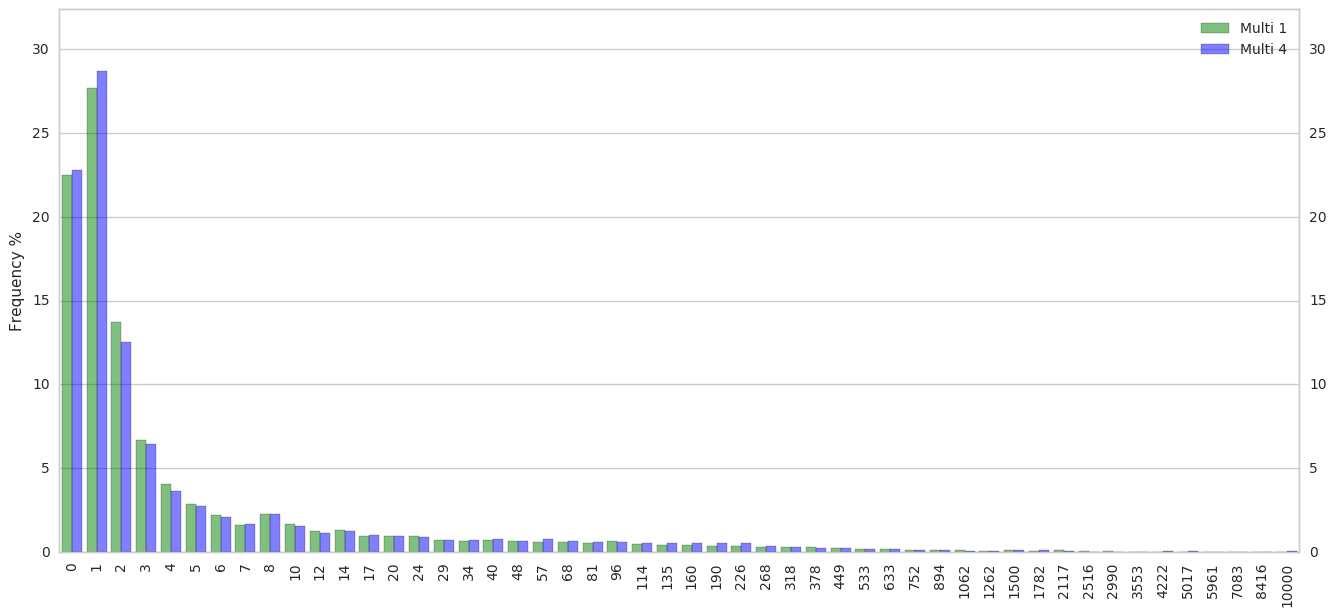

In [110]:
results.extend(compare_tab_groups(t3, t4, "payload/histograms/INPUT_EVENT_RESPONSE_MS"))

### INPUT_EVENT_RESPONSE_COALESCED_MS

## 1-3 Tabs

# Windows_NT

Comparison for INPUT_EVENT_RESPONSE_COALESCED_MS:

29174 (71.7%) multi_1 profiles on Windows_NT have the parent histogram.
29301 (71.9%) multi_4 profiles on Windows_NT have the parent histogram.
27940 (67.6%) webext_multi_1 profiles on Windows_NT have the parent histogram.
27468 (67.3%) webextx_multi_4 profiles on Windows_NT have the parent histogram.
20708 (69.9%) mpc_multi_1 profiles on Windows_NT have the parent histogram.
20818 (70.1%) mpc_multi_4 profiles on Windows_NT have the parent histogram.
27700 (68.0%) multi_1 profiles on Windows_NT have the child histogram.
27858 (68.4%) multi_4 profiles on Windows_NT have the child histogram.
26384 (63.9%) webext_multi_1 profiles on Windows_NT have the child histogram.
25880 (63.4%) webextx_multi_4 profiles on Windows_NT have the child histogram.
19844 (67.0%) mpc_multi_1 profiles on Windows_NT have the child histogram.
19879 (67.0%) mpc_multi_4 profiles on Windows_NT have the child histogram.


---
#### INPUT_EVENT_RESPONSE_COALESCED_MS (parent) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.930</b>.</span>
            

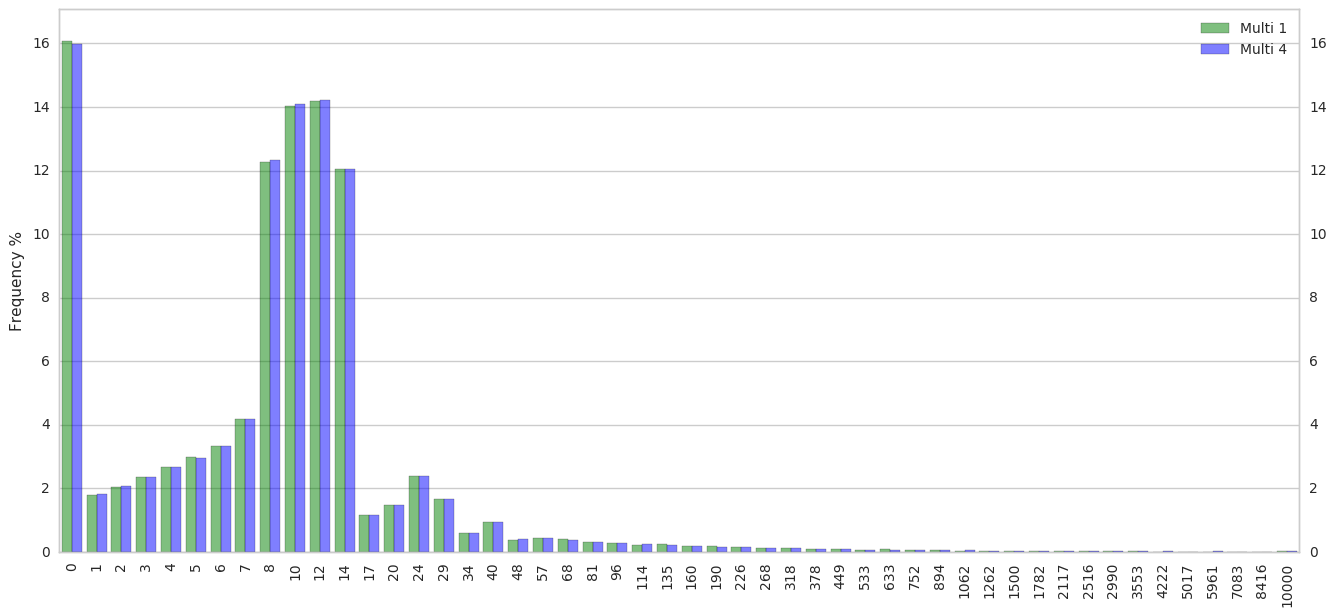

---
#### INPUT_EVENT_RESPONSE_COALESCED_MS (parent) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:red"><b>0.018</b>.</span>
            

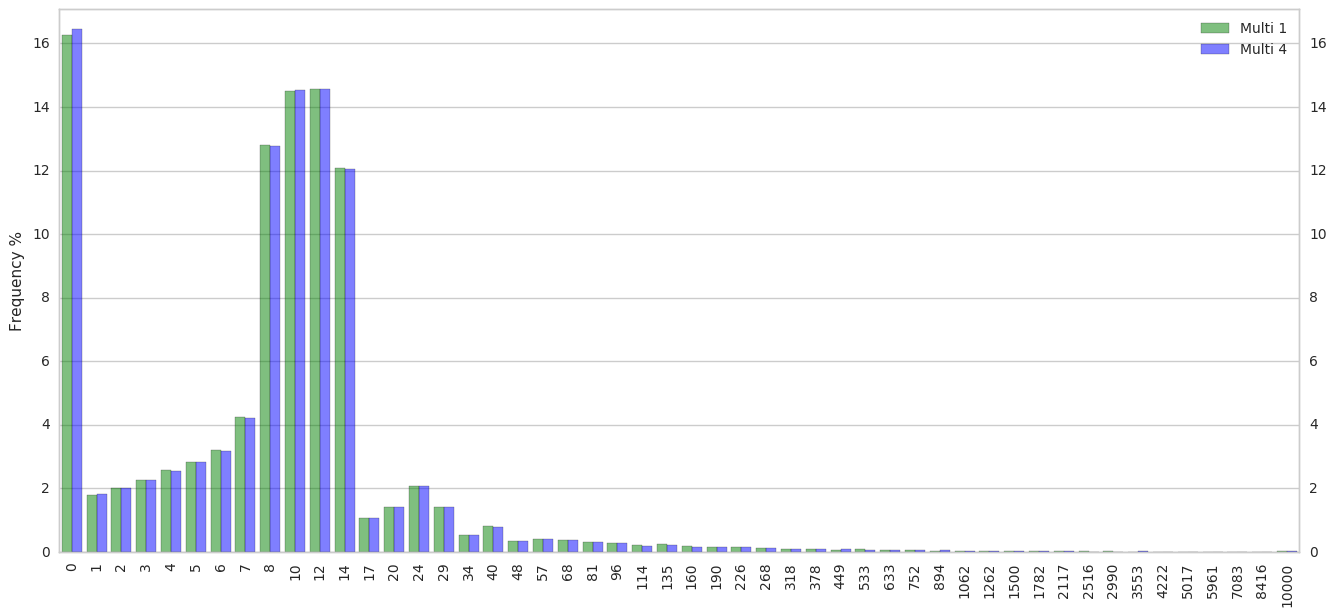

---
#### INPUT_EVENT_RESPONSE_COALESCED_MS (parent) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.076</b>.</span>
            

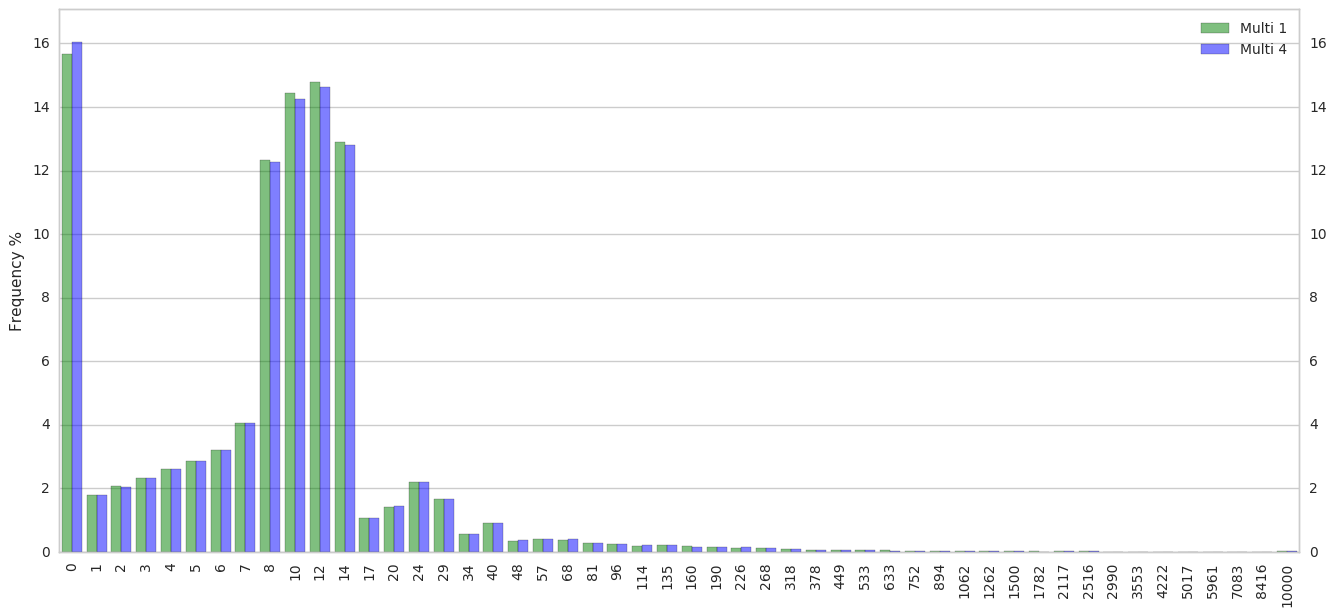

---
#### INPUT_EVENT_RESPONSE_COALESCED_MS (children) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.893</b>.</span>
            

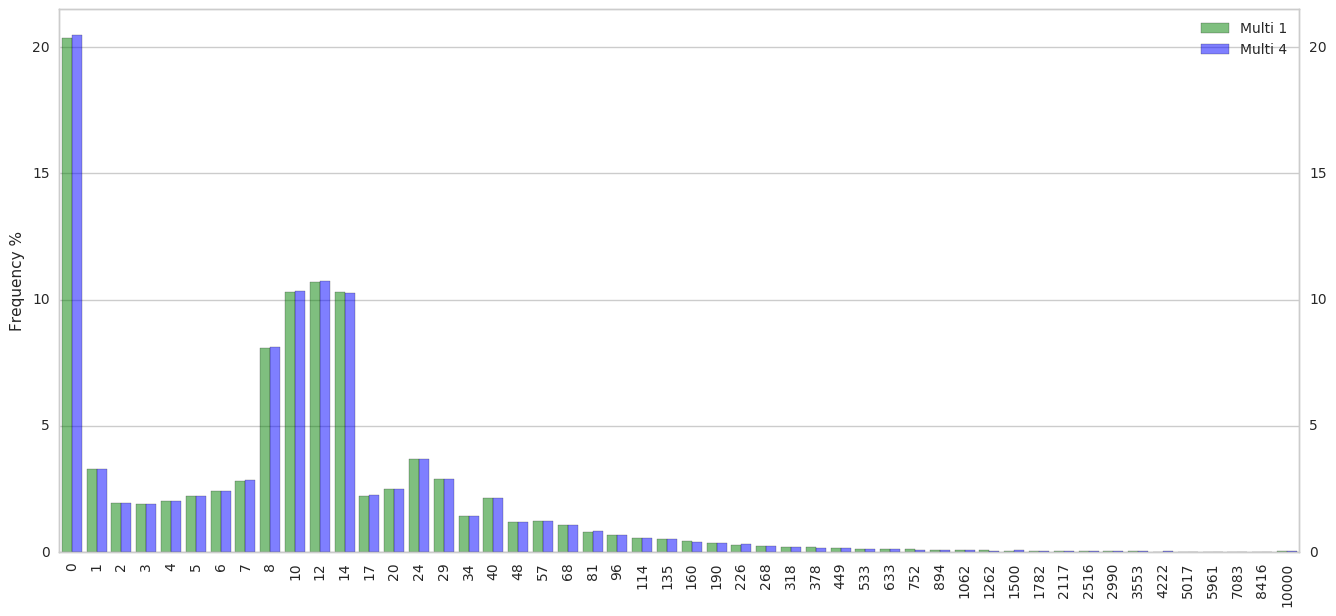

---
#### INPUT_EVENT_RESPONSE_COALESCED_MS (children) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.393</b>.</span>
            

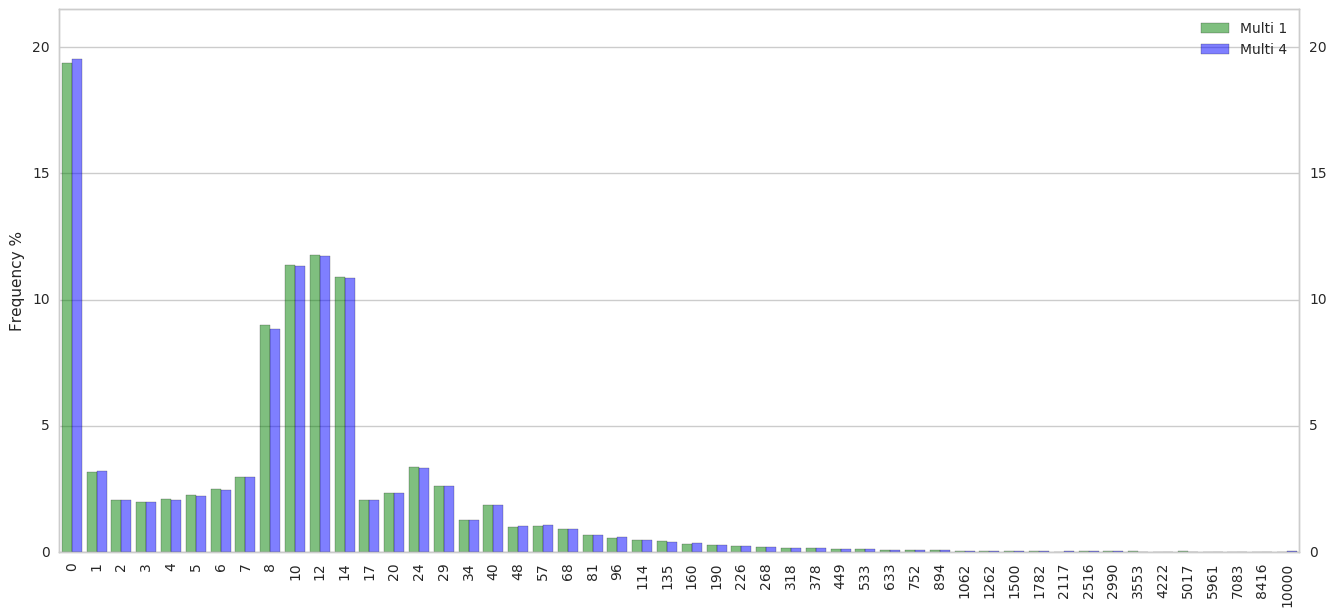

---
#### INPUT_EVENT_RESPONSE_COALESCED_MS (children) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.607</b>.</span>
            

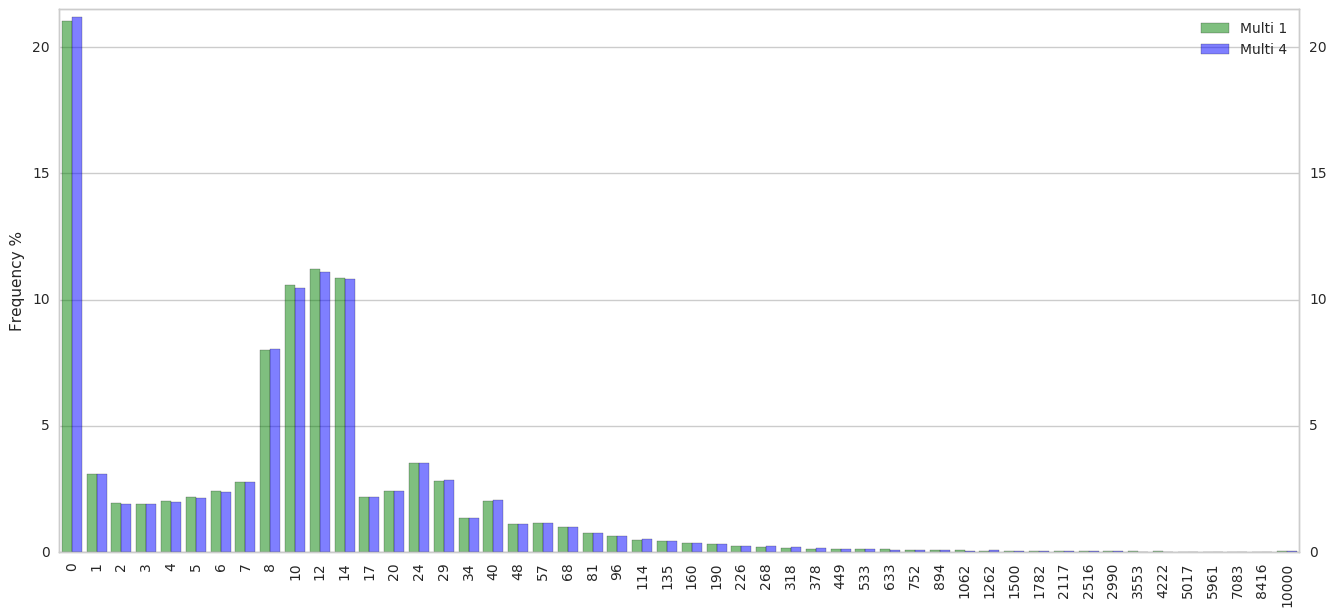

# Darwin

Comparison for INPUT_EVENT_RESPONSE_COALESCED_MS:

2336 (59.0%) multi_1 profiles on Darwin have the parent histogram.
2305 (58.2%) multi_4 profiles on Darwin have the parent histogram.
134 (55.8%) webext_multi_1 profiles on Darwin have the parent histogram.
127 (53.1%) webextx_multi_4 profiles on Darwin have the parent histogram.
263 (57.9%) mpc_multi_1 profiles on Darwin have the parent histogram.
257 (61.3%) mpc_multi_4 profiles on Darwin have the parent histogram.
2231 (56.4%) multi_1 profiles on Darwin have the child histogram.
2204 (55.6%) multi_4 profiles on Darwin have the child histogram.
131 (54.6%) webext_multi_1 profiles on Darwin have the child histogram.
125 (52.3%) webextx_multi_4 profiles on Darwin have the child histogram.
252 (55.5%) mpc_multi_1 profiles on Darwin have the child histogram.
248 (59.2%) mpc_multi_4 profiles on Darwin have the child histogram.


---
#### INPUT_EVENT_RESPONSE_COALESCED_MS (parent) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.807</b>.</span>
            

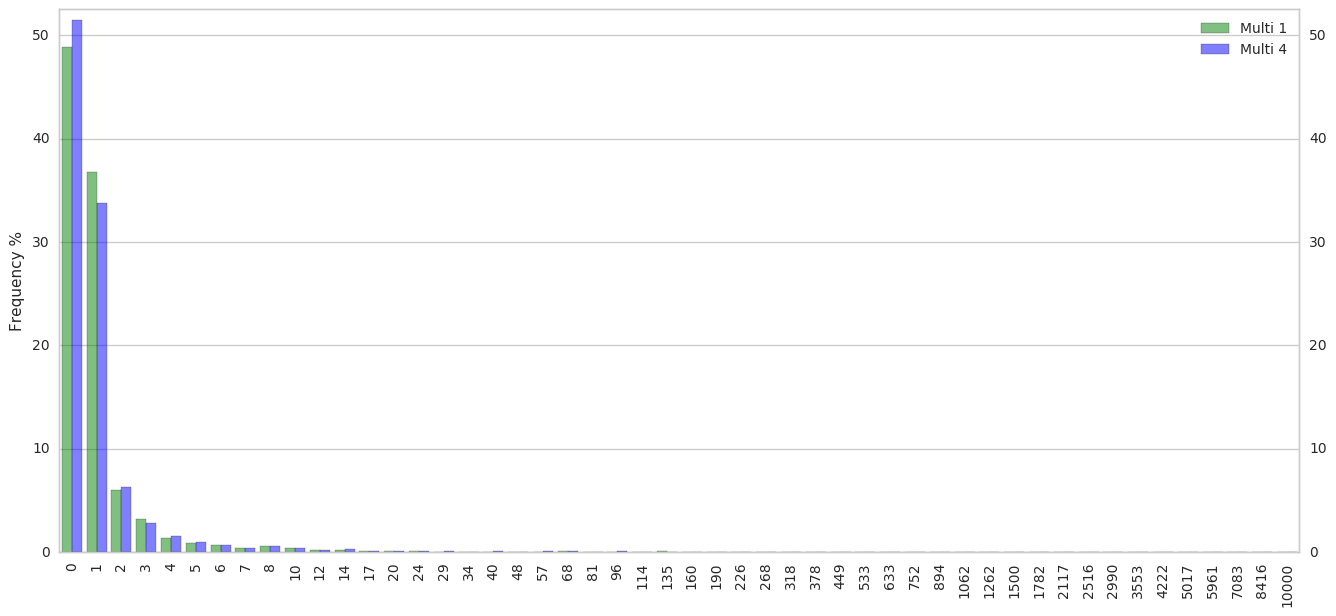

---
#### INPUT_EVENT_RESPONSE_COALESCED_MS (parent) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.307</b>.</span>
            

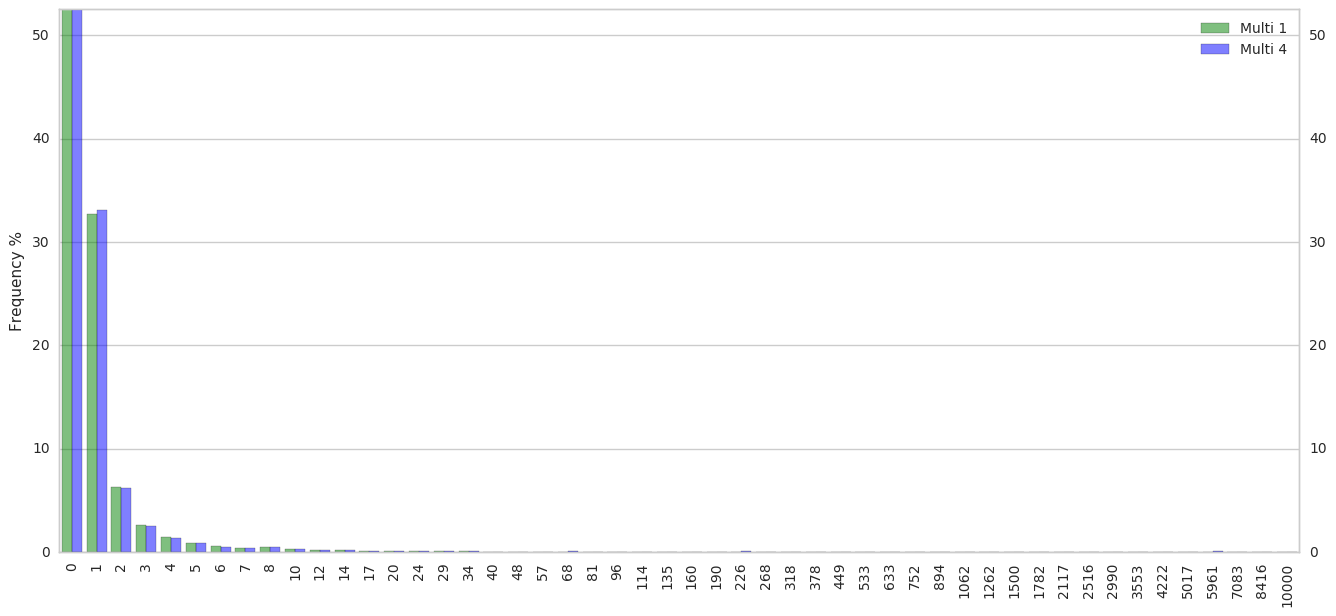

---
#### INPUT_EVENT_RESPONSE_COALESCED_MS (parent) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.100</b>.</span>
            

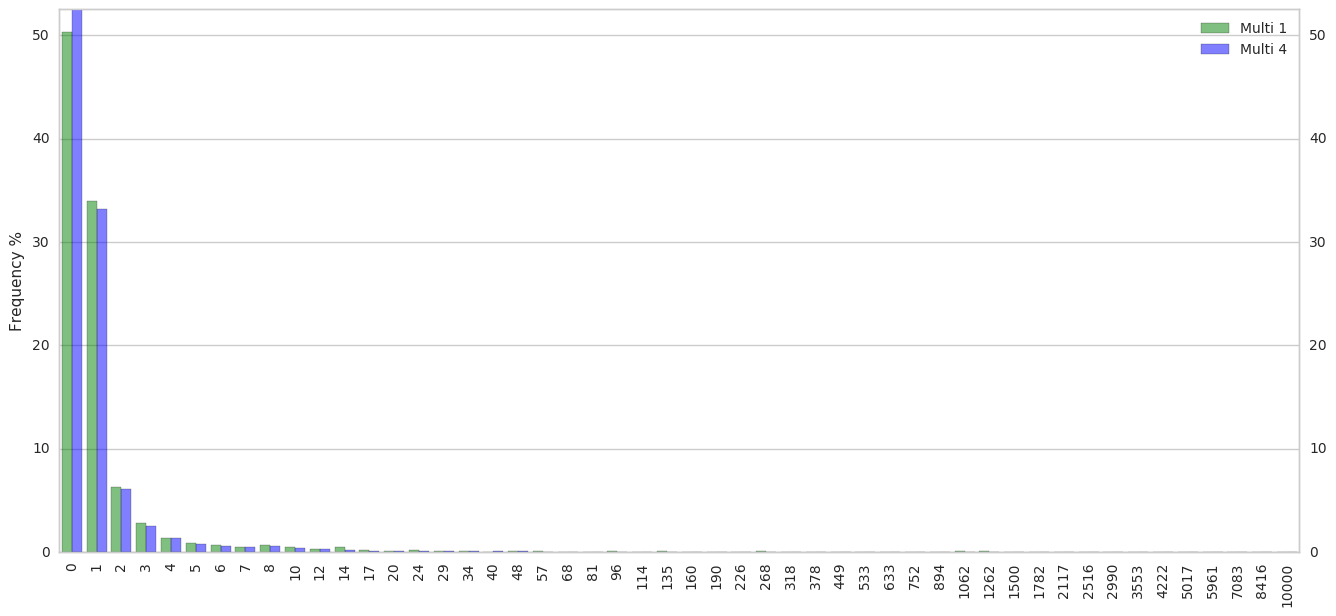

---
#### INPUT_EVENT_RESPONSE_COALESCED_MS (children) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.719</b>.</span>
            

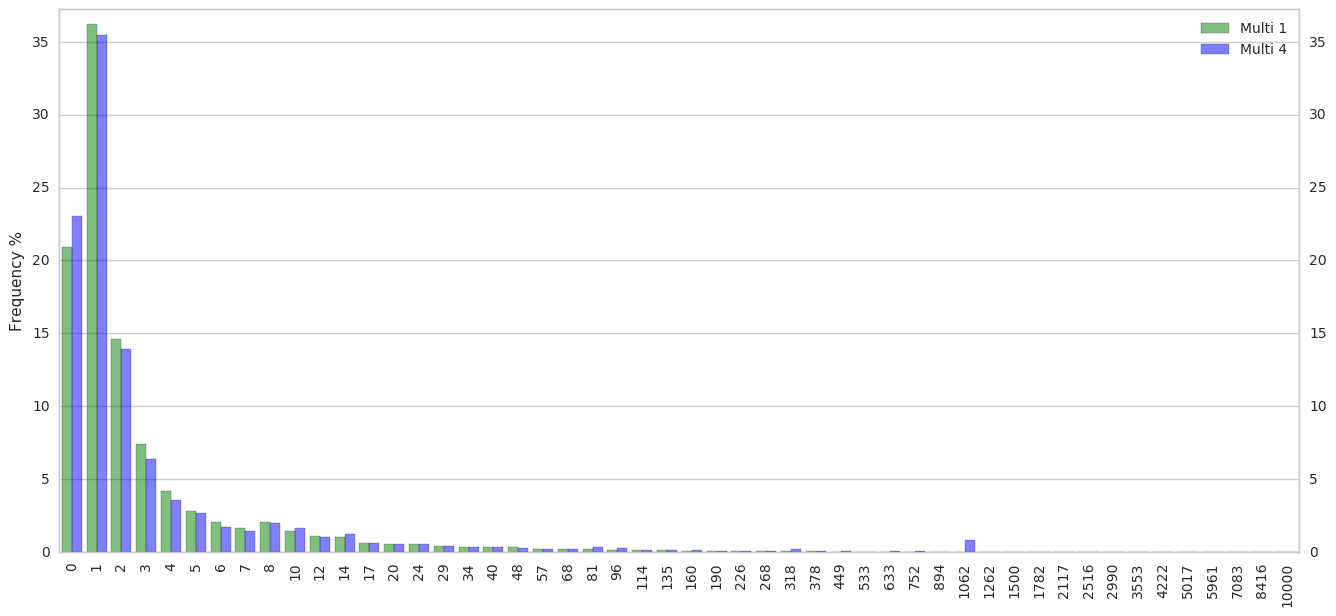

---
#### INPUT_EVENT_RESPONSE_COALESCED_MS (children) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.781</b>.</span>
            

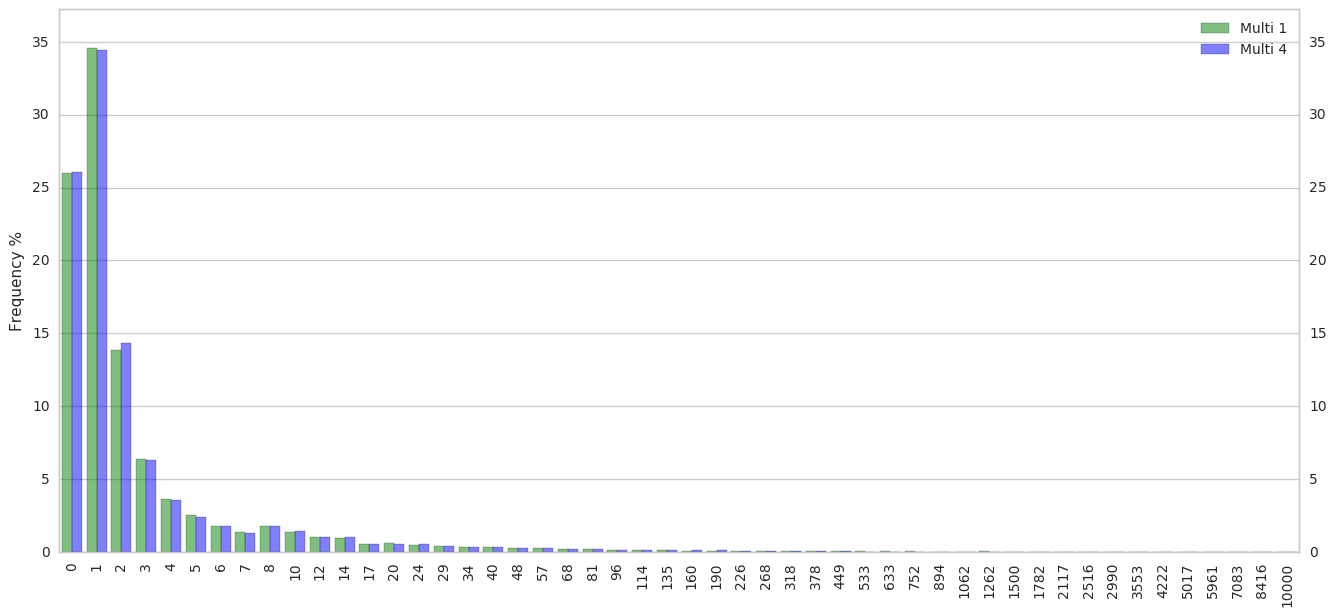

---
#### INPUT_EVENT_RESPONSE_COALESCED_MS (children) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.678</b>.</span>
            

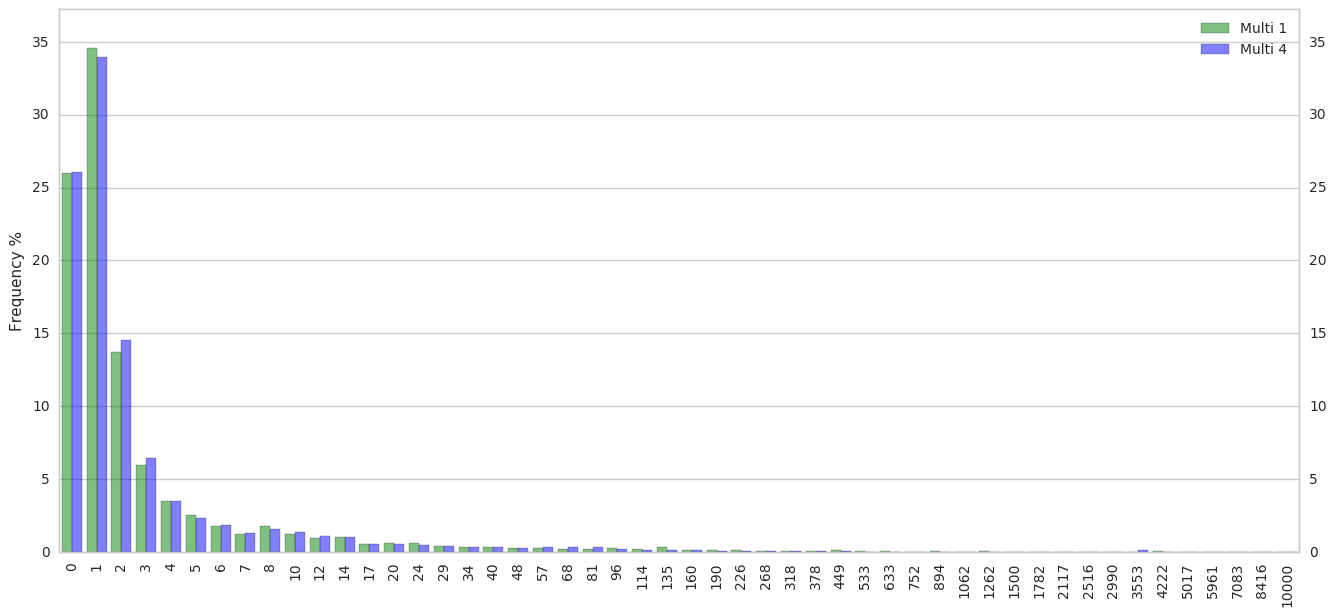

## 4+ Tabs

# Windows_NT

Comparison for INPUT_EVENT_RESPONSE_COALESCED_MS:

7042 (17.3%) multi_1 profiles on Windows_NT have the parent histogram.
7143 (17.5%) multi_4 profiles on Windows_NT have the parent histogram.
10170 (24.6%) webext_multi_1 profiles on Windows_NT have the parent histogram.
10130 (24.8%) webextx_multi_4 profiles on Windows_NT have the parent histogram.
8273 (27.9%) mpc_multi_1 profiles on Windows_NT have the parent histogram.
8242 (27.8%) mpc_multi_4 profiles on Windows_NT have the parent histogram.
6850 (16.8%) multi_1 profiles on Windows_NT have the child histogram.
6966 (17.1%) multi_4 profiles on Windows_NT have the child histogram.
9864 (23.9%) webext_multi_1 profiles on Windows_NT have the child histogram.
9813 (24.0%) webextx_multi_4 profiles on Windows_NT have the child histogram.
8029 (27.1%) mpc_multi_1 profiles on Windows_NT have the child histogram.
7981 (26.9%) mpc_multi_4 profiles on Windows_NT have the child histogram.


---
#### INPUT_EVENT_RESPONSE_COALESCED_MS (parent) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.252</b>.</span>
            

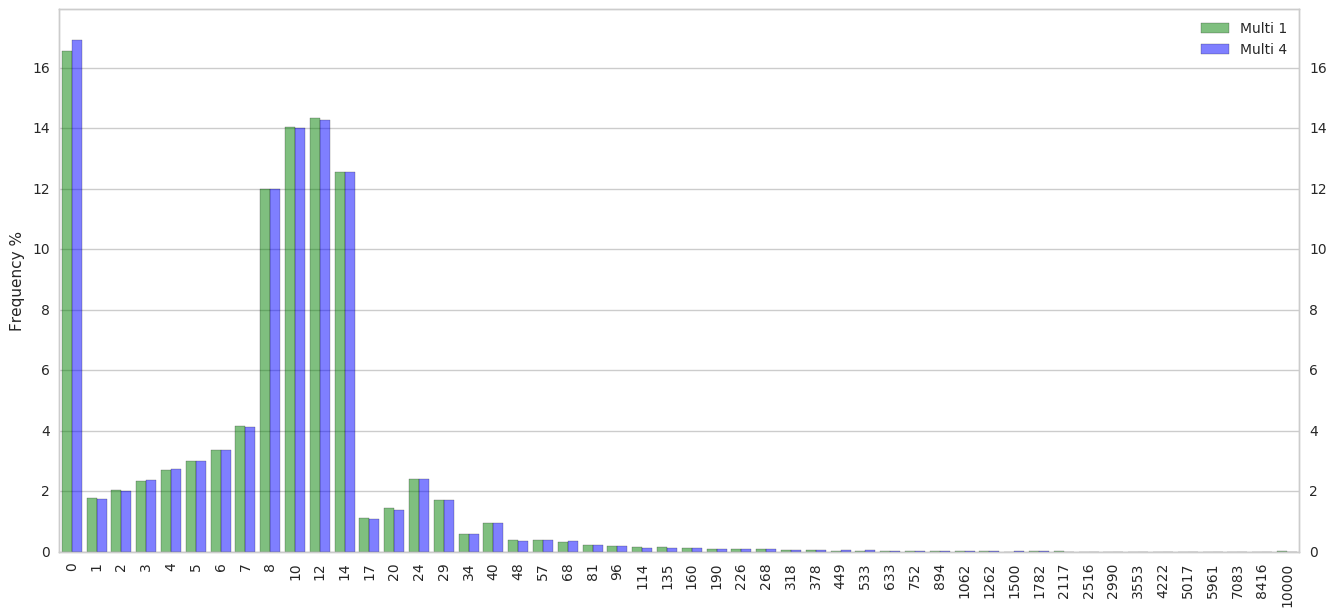

---
#### INPUT_EVENT_RESPONSE_COALESCED_MS (parent) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.510</b>.</span>
            

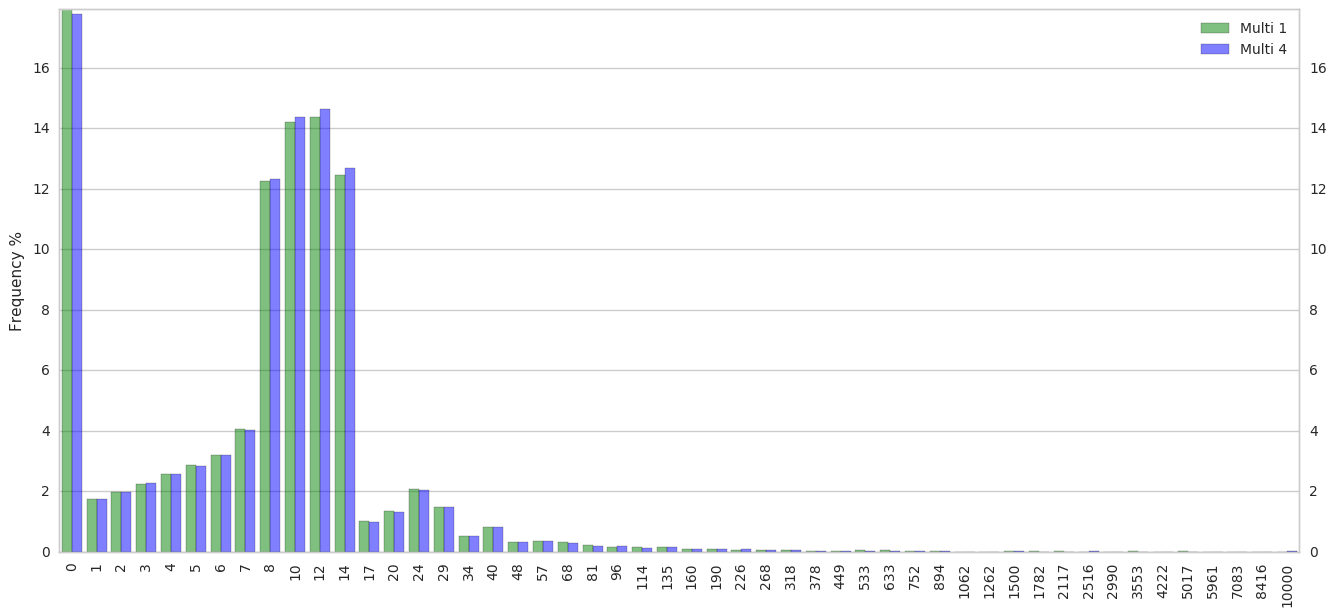

---
#### INPUT_EVENT_RESPONSE_COALESCED_MS (parent) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.980</b>.</span>
            

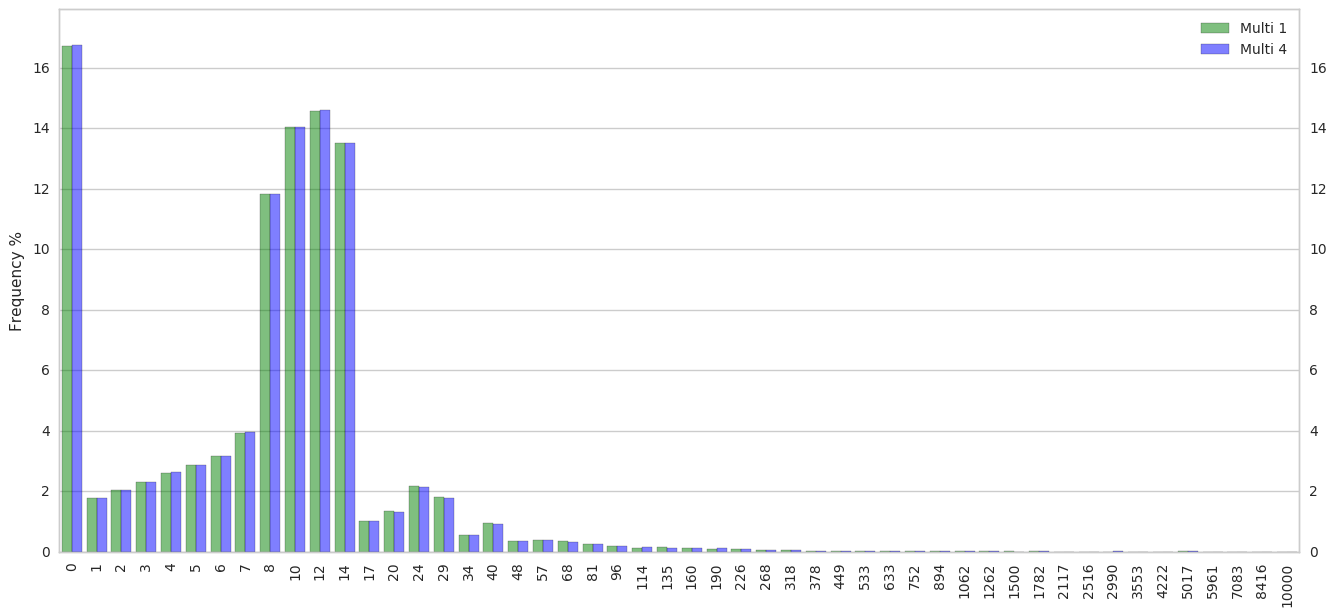

---
#### INPUT_EVENT_RESPONSE_COALESCED_MS (children) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.699</b>.</span>
            

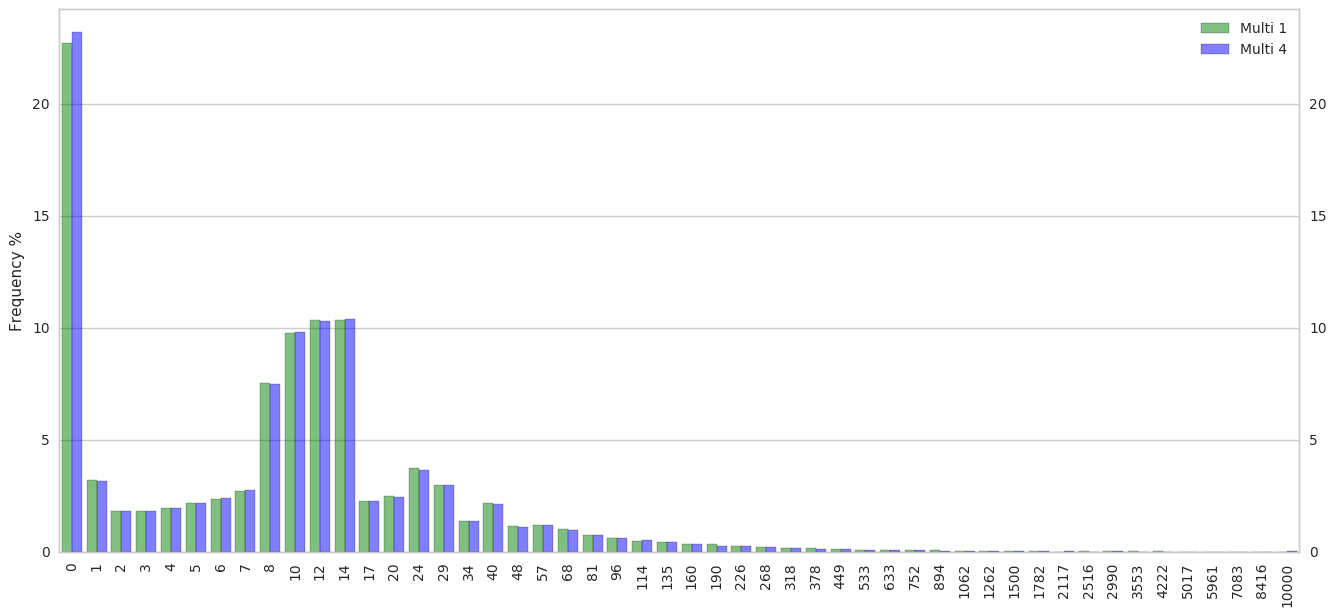

---
#### INPUT_EVENT_RESPONSE_COALESCED_MS (children) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:red"><b>0.020</b>.</span>
            

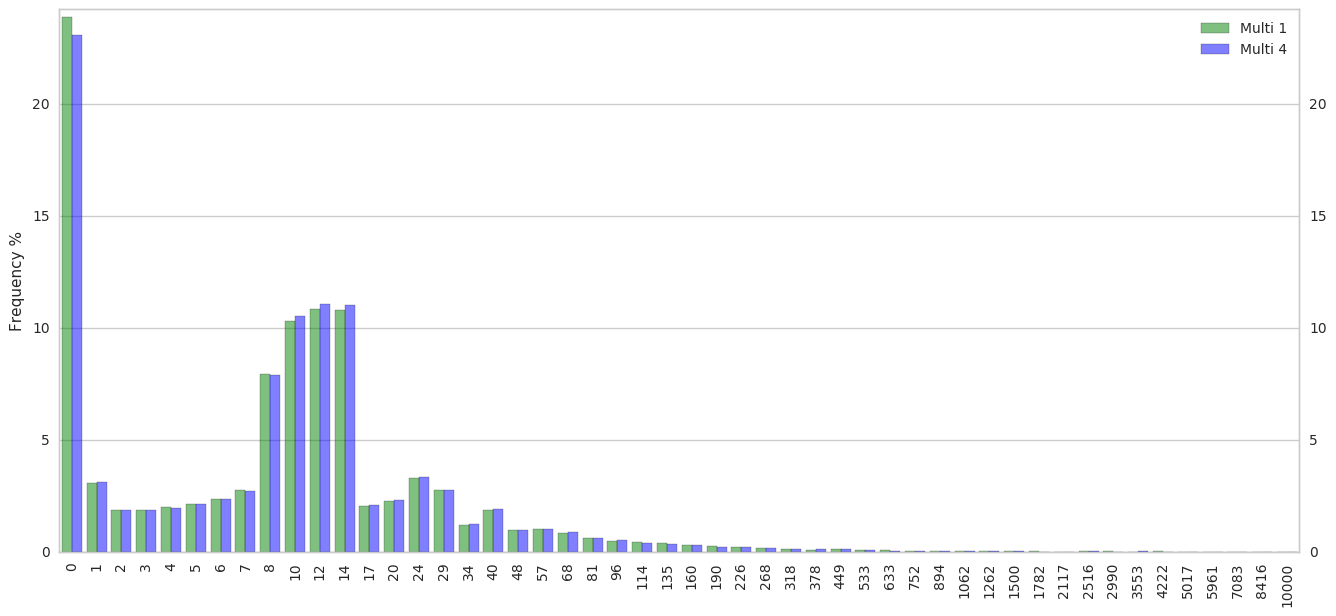

---
#### INPUT_EVENT_RESPONSE_COALESCED_MS (children) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.877</b>.</span>
            

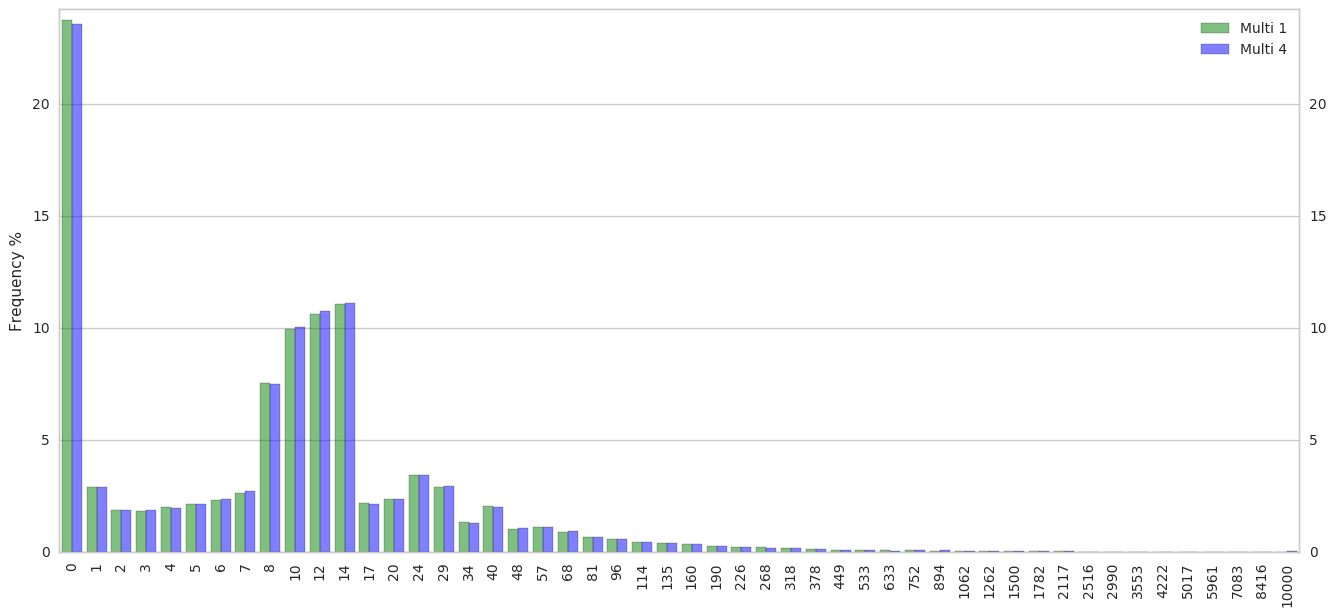

# Darwin

Comparison for INPUT_EVENT_RESPONSE_COALESCED_MS:

914 (23.1%) multi_1 profiles on Darwin have the parent histogram.
929 (23.4%) multi_4 profiles on Darwin have the parent histogram.
75 (31.2%) webext_multi_1 profiles on Darwin have the parent histogram.
92 (38.5%) webextx_multi_4 profiles on Darwin have the parent histogram.
177 (39.0%) mpc_multi_1 profiles on Darwin have the parent histogram.
150 (35.8%) mpc_multi_4 profiles on Darwin have the parent histogram.
899 (22.7%) multi_1 profiles on Darwin have the child histogram.
915 (23.1%) multi_4 profiles on Darwin have the child histogram.
72 (30.0%) webext_multi_1 profiles on Darwin have the child histogram.
91 (38.1%) webextx_multi_4 profiles on Darwin have the child histogram.
168 (37.0%) mpc_multi_1 profiles on Darwin have the child histogram.
148 (35.3%) mpc_multi_4 profiles on Darwin have the child histogram.


---
#### INPUT_EVENT_RESPONSE_COALESCED_MS (parent) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.361</b>.</span>
            

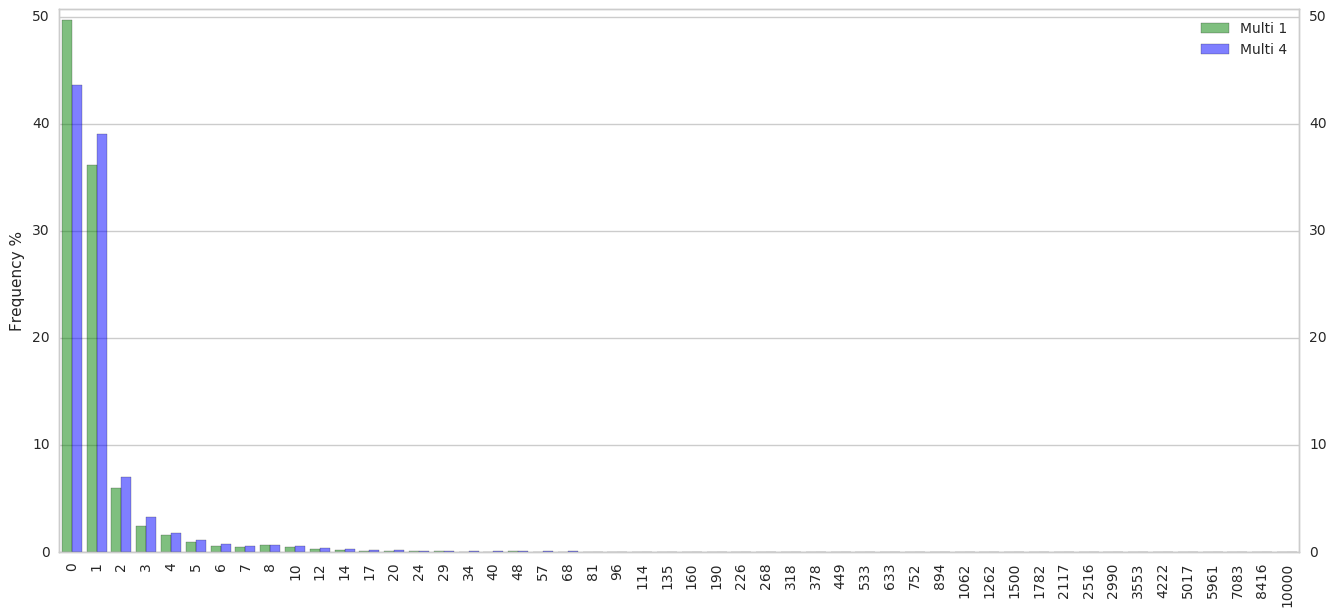

---
#### INPUT_EVENT_RESPONSE_COALESCED_MS (parent) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:red"><b>0.012</b>.</span>
            

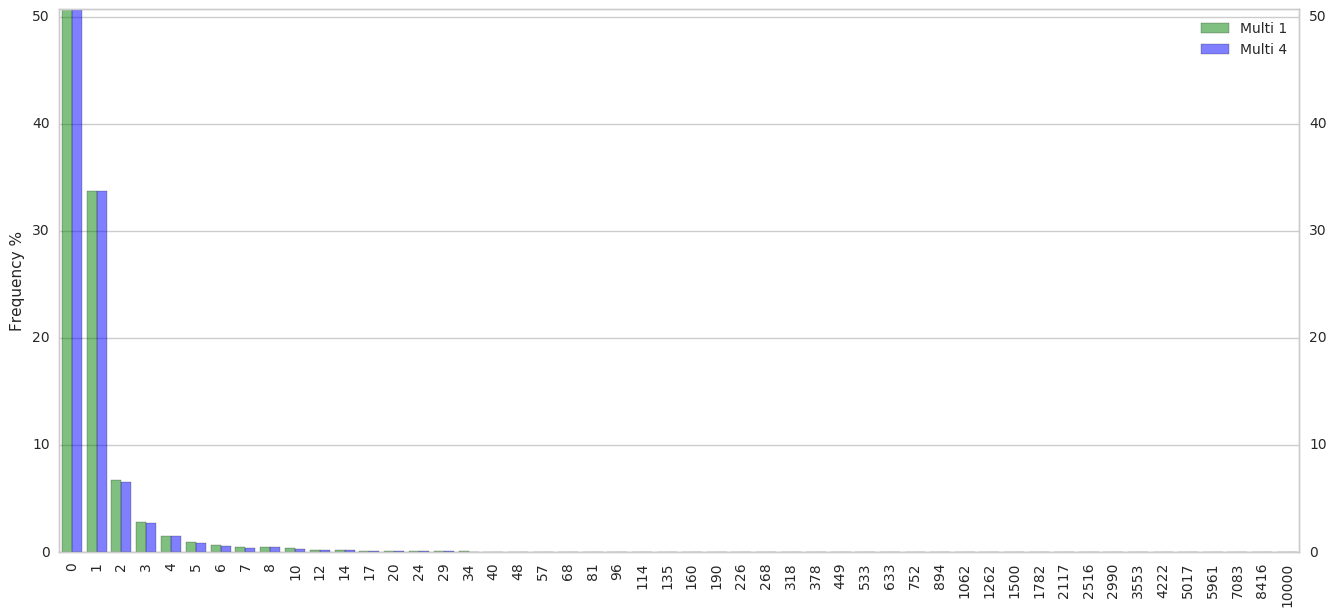

---
#### INPUT_EVENT_RESPONSE_COALESCED_MS (parent) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.936</b>.</span>
            

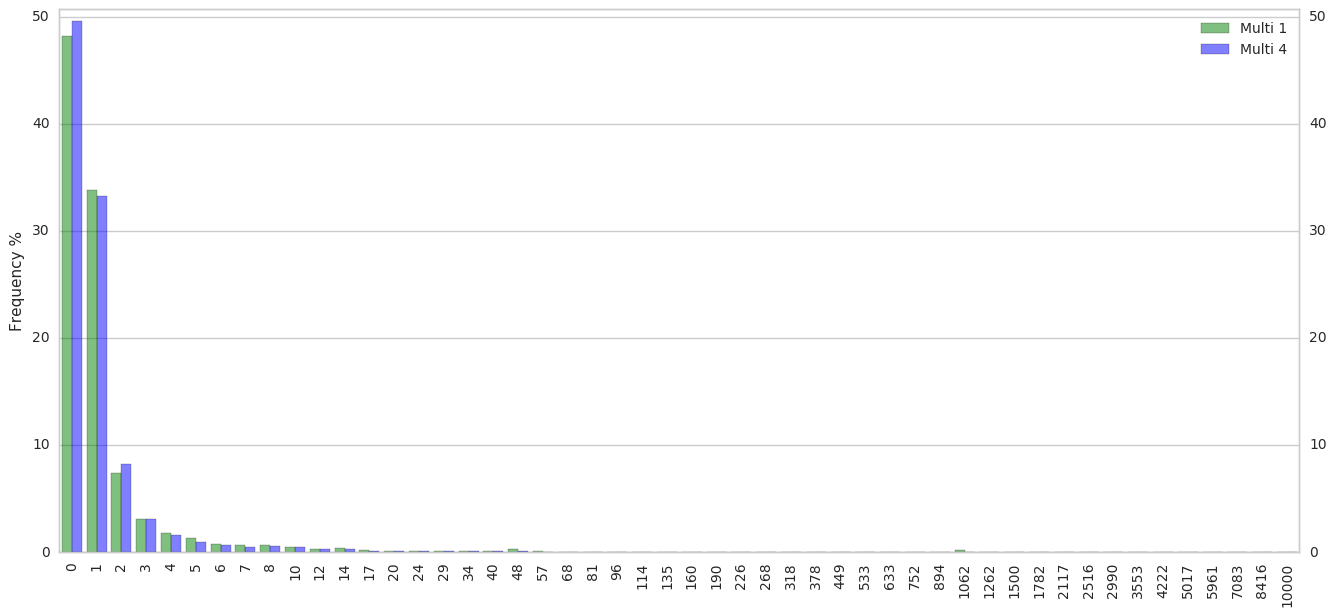

---
#### INPUT_EVENT_RESPONSE_COALESCED_MS (children) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.869</b>.</span>
            

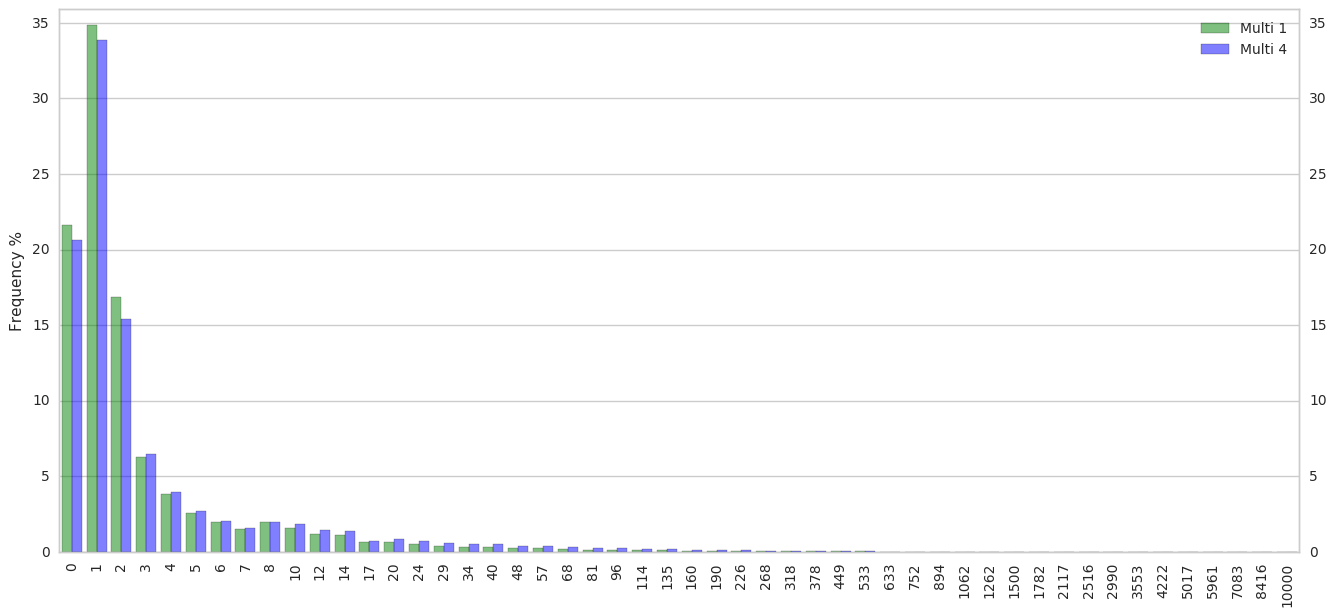

---
#### INPUT_EVENT_RESPONSE_COALESCED_MS (children) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:red"><b>0.018</b>.</span>
            

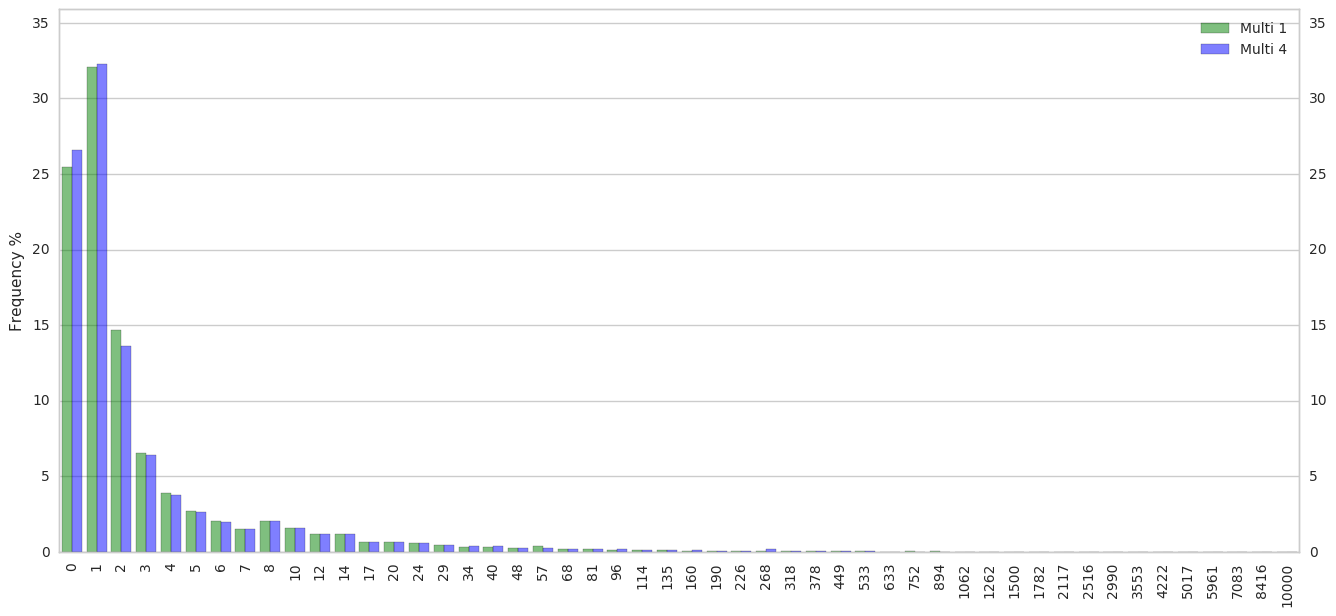

---
#### INPUT_EVENT_RESPONSE_COALESCED_MS (children) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.152</b>.</span>
            

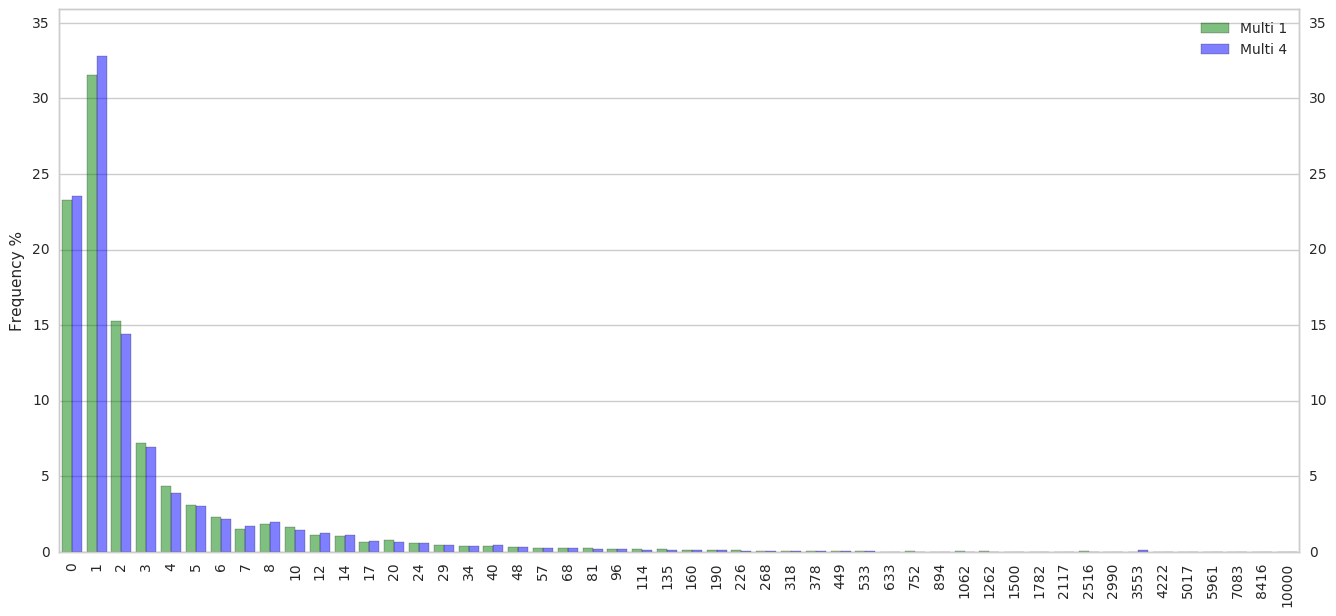

In [111]:
results.extend(compare_tab_groups(t3, t4, "payload/histograms/INPUT_EVENT_RESPONSE_COALESCED_MS"))

---

## PageLoad

### FX_PAGE_LOAD_MS

## 1-3 Tabs

# Windows_NT

Comparison for FX_PAGE_LOAD_MS:

32813 (80.6%) multi_1 profiles on Windows_NT have the parent histogram.
32871 (80.7%) multi_4 profiles on Windows_NT have the parent histogram.
30301 (73.3%) webext_multi_1 profiles on Windows_NT have the parent histogram.
29841 (73.1%) webextx_multi_4 profiles on Windows_NT have the parent histogram.
21090 (71.2%) mpc_multi_1 profiles on Windows_NT have the parent histogram.
21209 (71.4%) mpc_multi_4 profiles on Windows_NT have the parent histogram.
No multi_1 profiles on Windows_NT have the child histogram.
No multi_4 profiles on Windows_NT have the child histogram.
No webext_multi_1 profiles on Windows_NT have the child histogram.
No webextx_multi_4 profiles on Windows_NT have the child histogram.
No mpc_multi_1 profiles on Windows_NT have the child histogram.
No mpc_multi_4 profiles on Windows_NT have the child histogram.


---
#### FX_PAGE_LOAD_MS (parent) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.422</b>.</span>
            

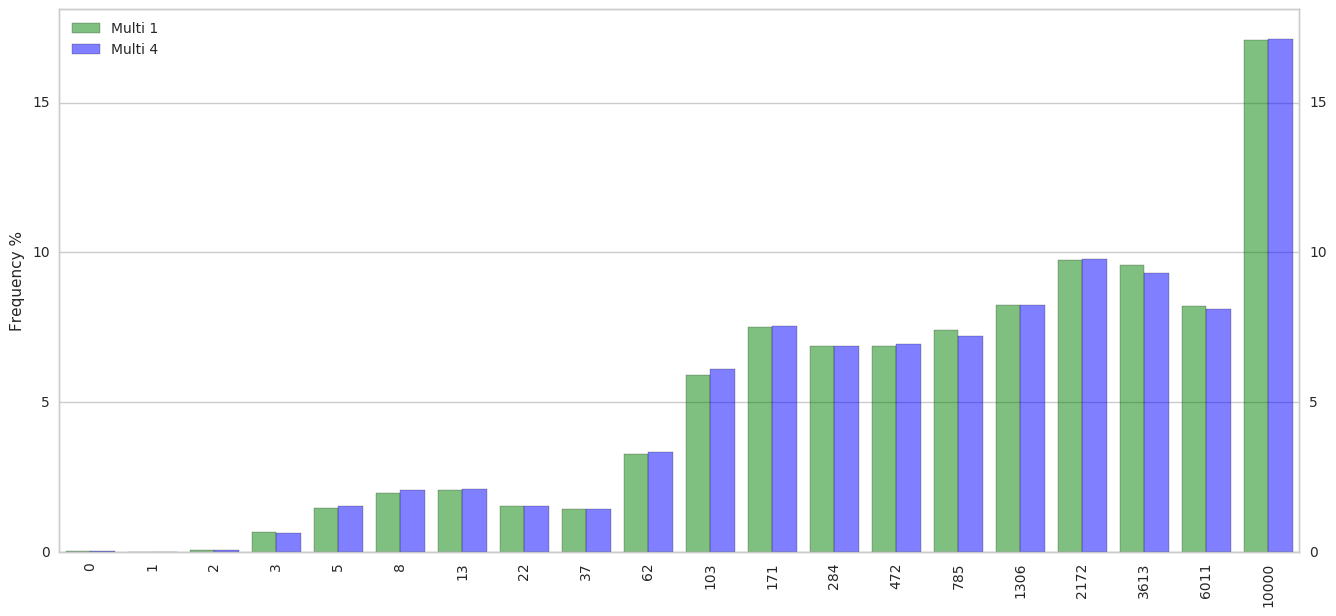

---
#### FX_PAGE_LOAD_MS (parent) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.533</b>.</span>
            

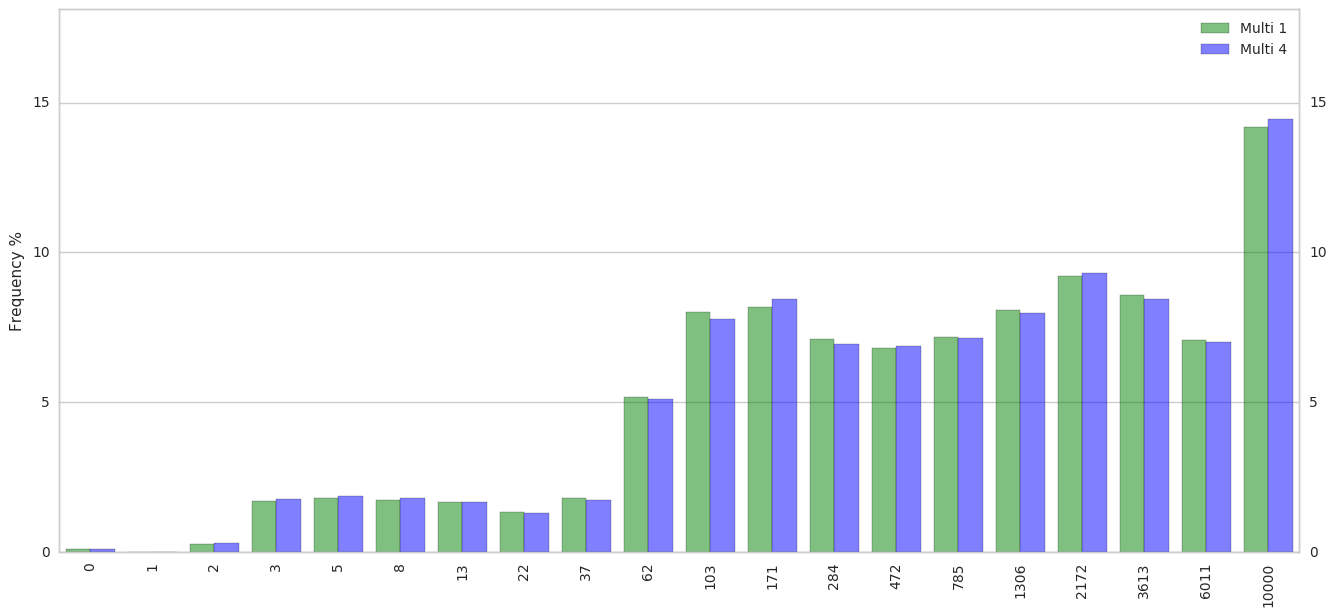

---
#### FX_PAGE_LOAD_MS (parent) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.150</b>.</span>
            

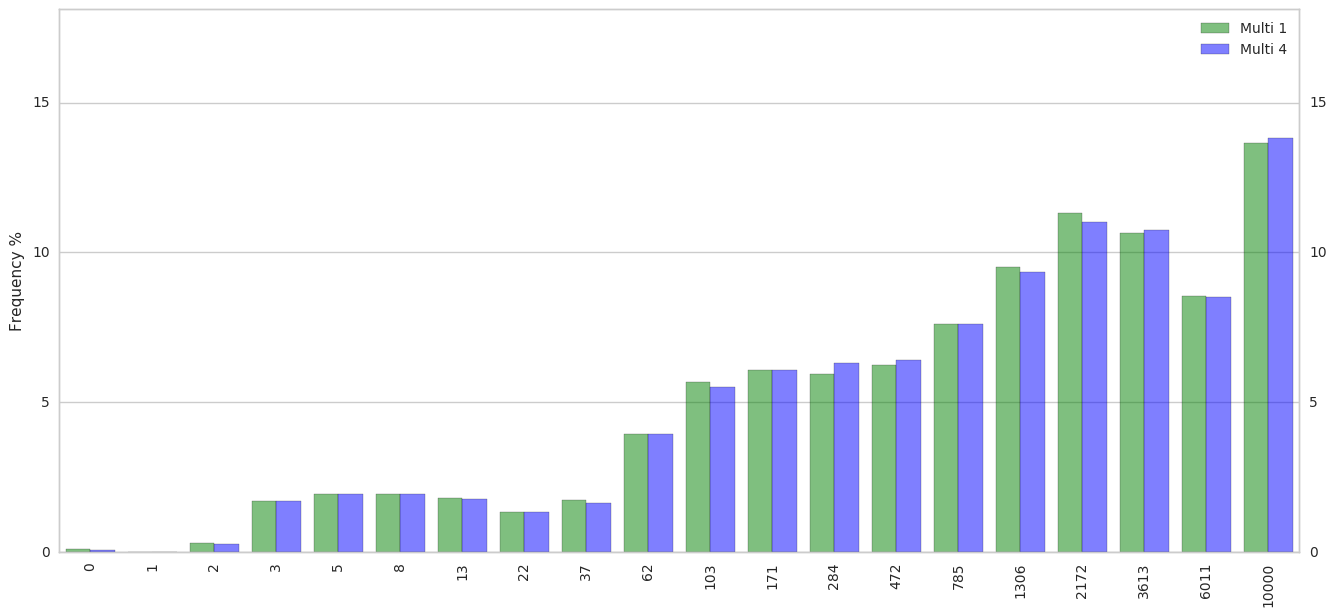

# Darwin

Comparison for FX_PAGE_LOAD_MS:

2833 (71.6%) multi_1 profiles on Darwin have the parent histogram.
2832 (71.5%) multi_4 profiles on Darwin have the parent histogram.
155 (64.6%) webext_multi_1 profiles on Darwin have the parent histogram.
142 (59.4%) webextx_multi_4 profiles on Darwin have the parent histogram.
270 (59.5%) mpc_multi_1 profiles on Darwin have the parent histogram.
264 (63.0%) mpc_multi_4 profiles on Darwin have the parent histogram.
No multi_1 profiles on Darwin have the child histogram.
No multi_4 profiles on Darwin have the child histogram.
No webext_multi_1 profiles on Darwin have the child histogram.
No webextx_multi_4 profiles on Darwin have the child histogram.
No mpc_multi_1 profiles on Darwin have the child histogram.
No mpc_multi_4 profiles on Darwin have the child histogram.


---
#### FX_PAGE_LOAD_MS (parent) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.807</b>.</span>
            

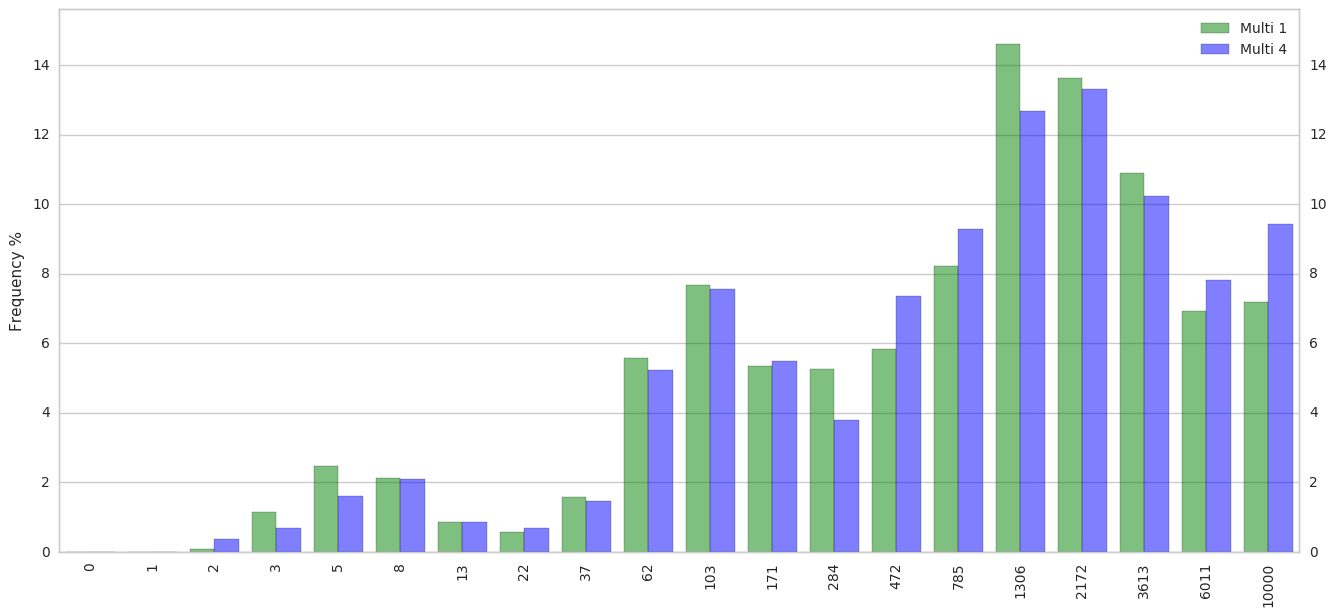

---
#### FX_PAGE_LOAD_MS (parent) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.959</b>.</span>
            

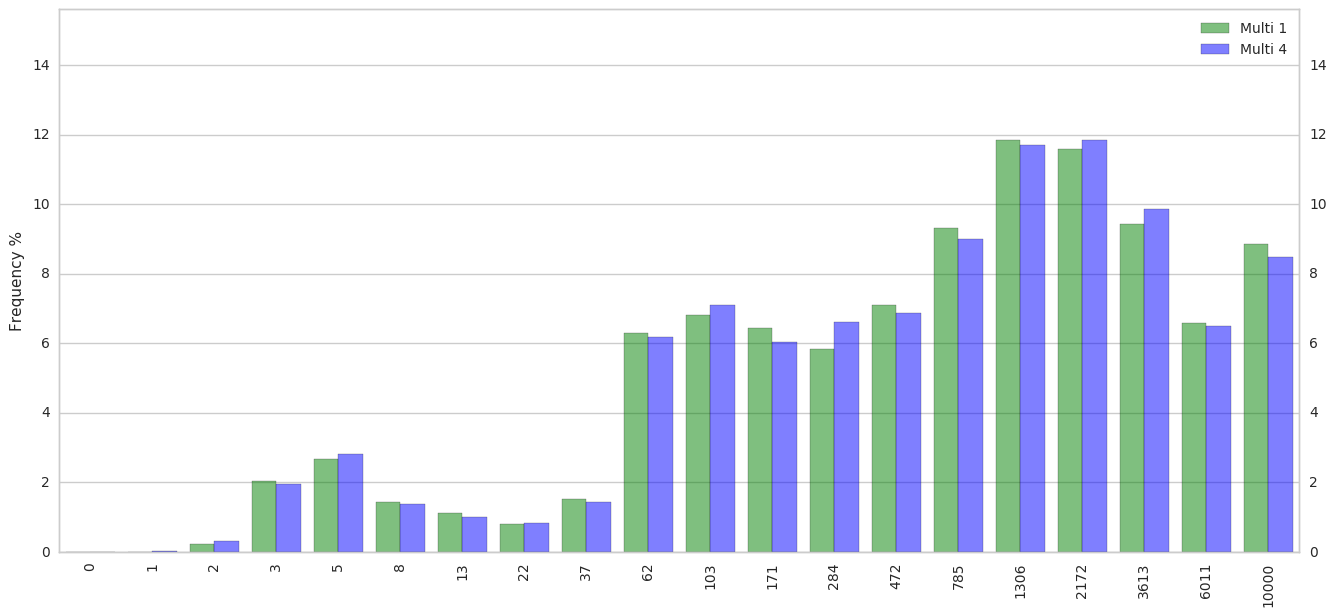

---
#### FX_PAGE_LOAD_MS (parent) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.467</b>.</span>
            

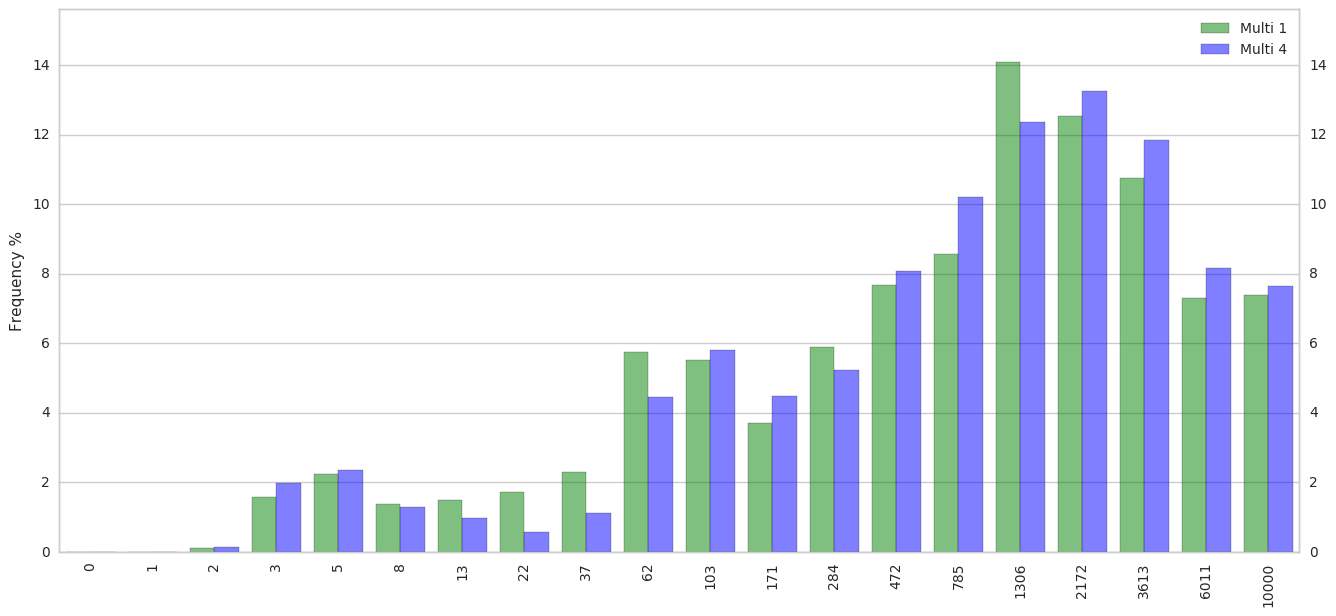

## 4+ Tabs

# Windows_NT

Comparison for FX_PAGE_LOAD_MS:

7663 (18.8%) multi_1 profiles on Windows_NT have the parent histogram.
7710 (18.9%) multi_4 profiles on Windows_NT have the parent histogram.
10776 (26.1%) webext_multi_1 profiles on Windows_NT have the parent histogram.
10745 (26.3%) webextx_multi_4 profiles on Windows_NT have the parent histogram.
8359 (28.2%) mpc_multi_1 profiles on Windows_NT have the parent histogram.
8326 (28.0%) mpc_multi_4 profiles on Windows_NT have the parent histogram.
No multi_1 profiles on Windows_NT have the child histogram.
No multi_4 profiles on Windows_NT have the child histogram.
No webext_multi_1 profiles on Windows_NT have the child histogram.
No webextx_multi_4 profiles on Windows_NT have the child histogram.
No mpc_multi_1 profiles on Windows_NT have the child histogram.
No mpc_multi_4 profiles on Windows_NT have the child histogram.


---
#### FX_PAGE_LOAD_MS (parent) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.789</b>.</span>
            

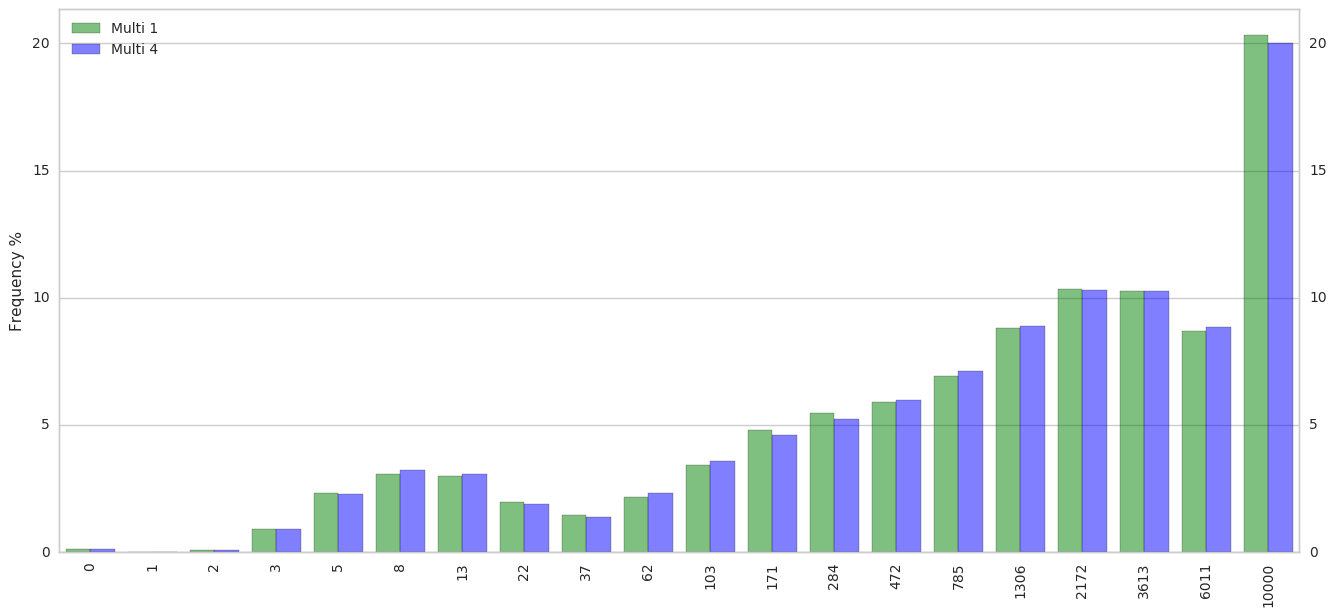

---
#### FX_PAGE_LOAD_MS (parent) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.934</b>.</span>
            

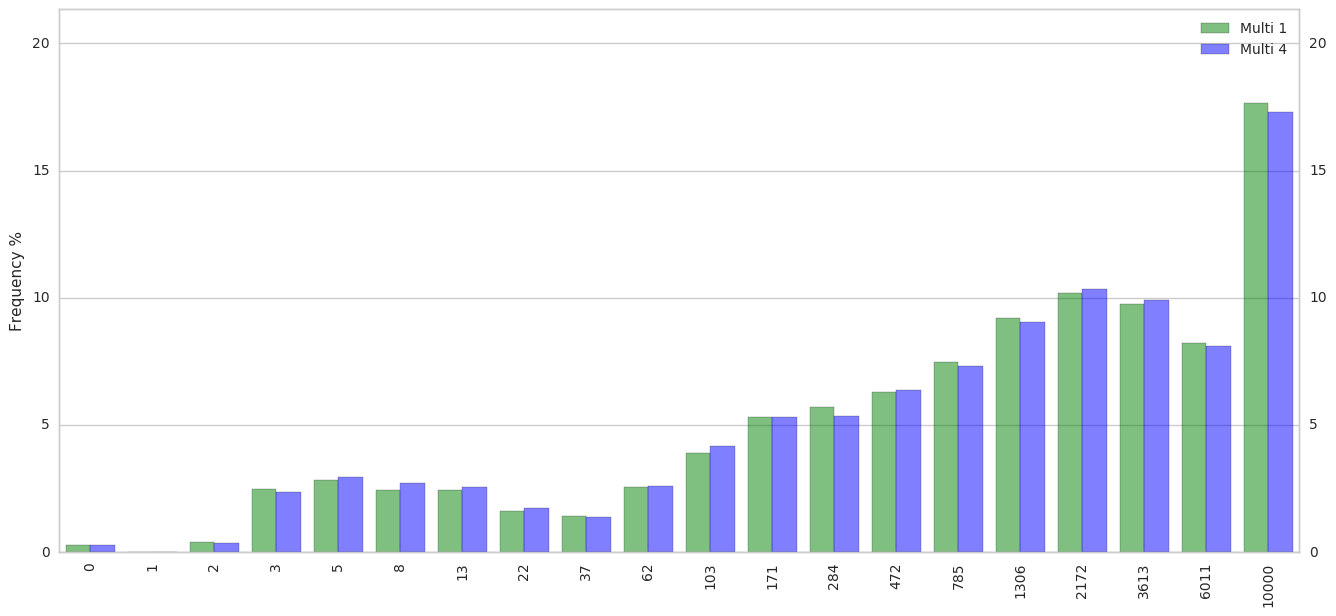

---
#### FX_PAGE_LOAD_MS (parent) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.914</b>.</span>
            

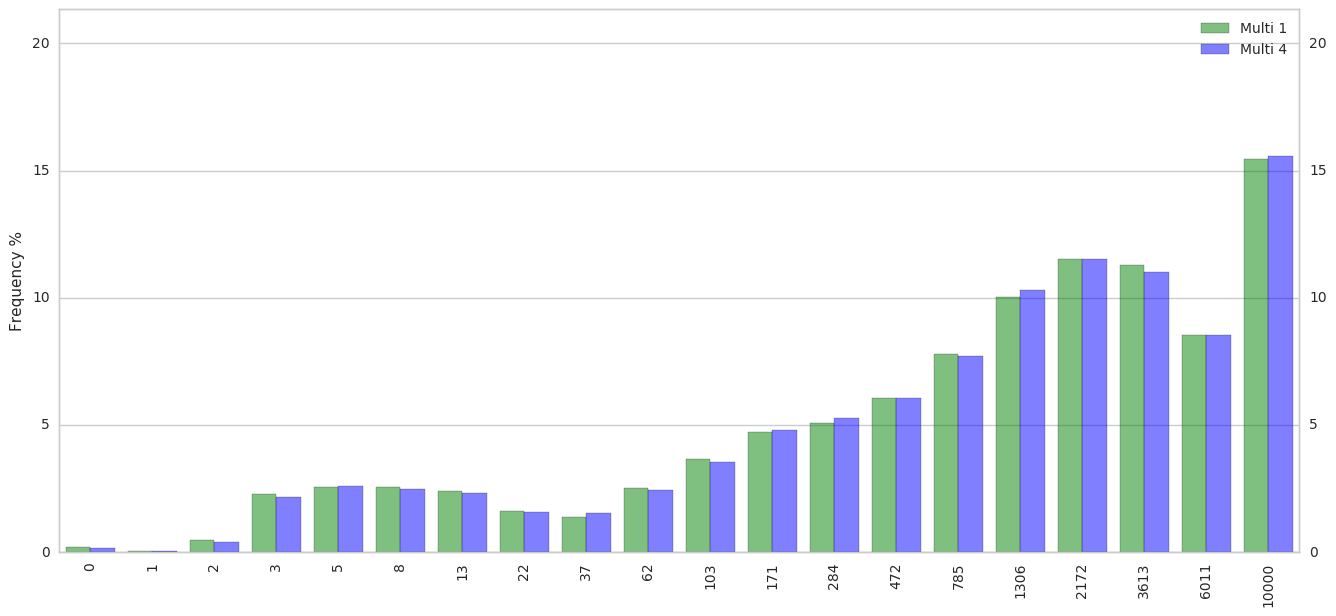

# Darwin

Comparison for FX_PAGE_LOAD_MS:

1103 (27.9%) multi_1 profiles on Darwin have the parent histogram.
1115 (28.1%) multi_4 profiles on Darwin have the parent histogram.
85 (35.4%) webext_multi_1 profiles on Darwin have the parent histogram.
97 (40.6%) webextx_multi_4 profiles on Darwin have the parent histogram.
180 (39.6%) mpc_multi_1 profiles on Darwin have the parent histogram.
154 (36.8%) mpc_multi_4 profiles on Darwin have the parent histogram.
No multi_1 profiles on Darwin have the child histogram.
No multi_4 profiles on Darwin have the child histogram.
No webext_multi_1 profiles on Darwin have the child histogram.
No webextx_multi_4 profiles on Darwin have the child histogram.
No mpc_multi_1 profiles on Darwin have the child histogram.
No mpc_multi_4 profiles on Darwin have the child histogram.


---
#### FX_PAGE_LOAD_MS (parent) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:red"><b>0.010</b>.</span>
            

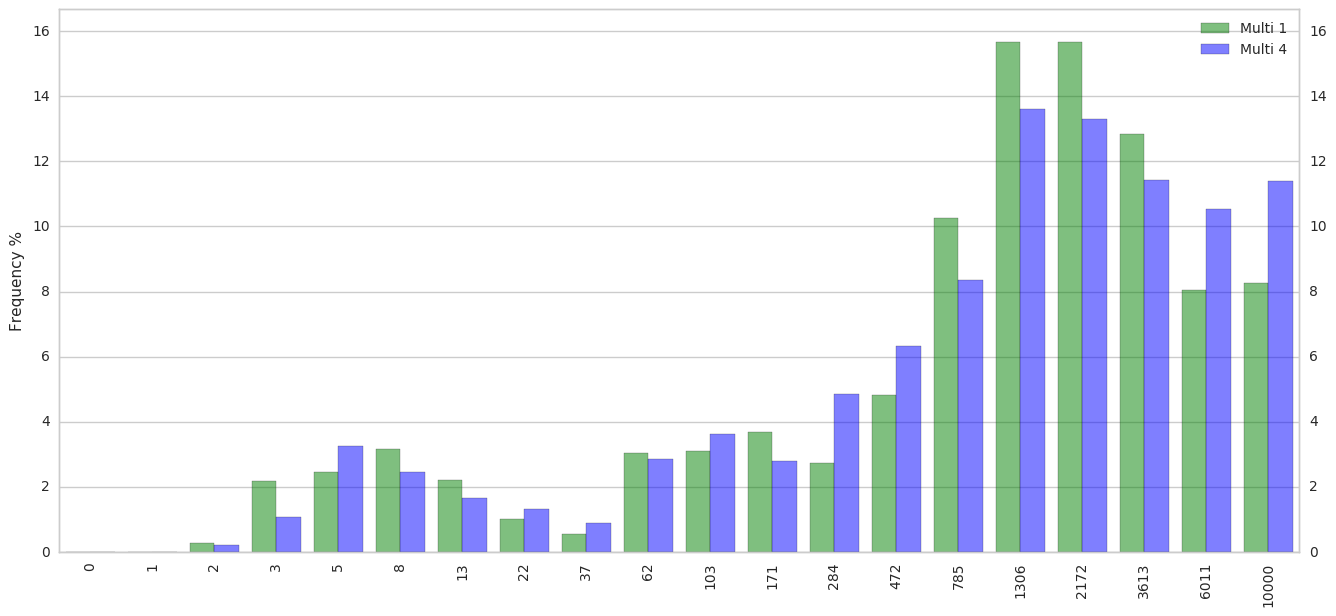

---
#### FX_PAGE_LOAD_MS (parent) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.561</b>.</span>
            

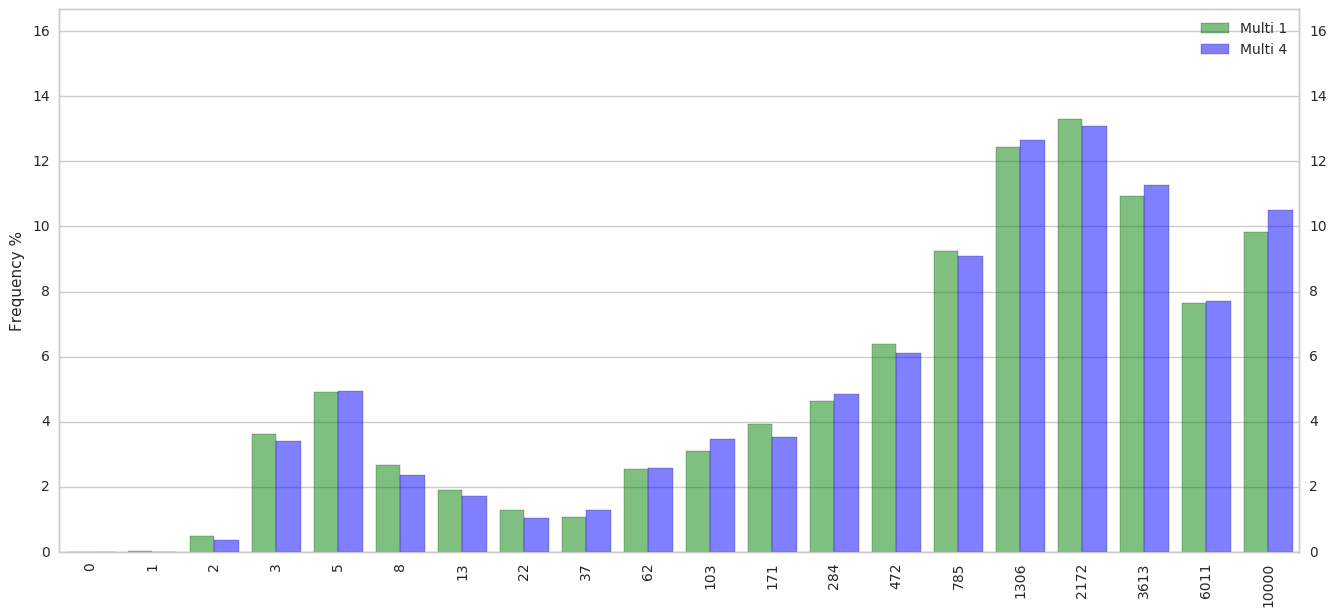

---
#### FX_PAGE_LOAD_MS (parent) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.260</b>.</span>
            

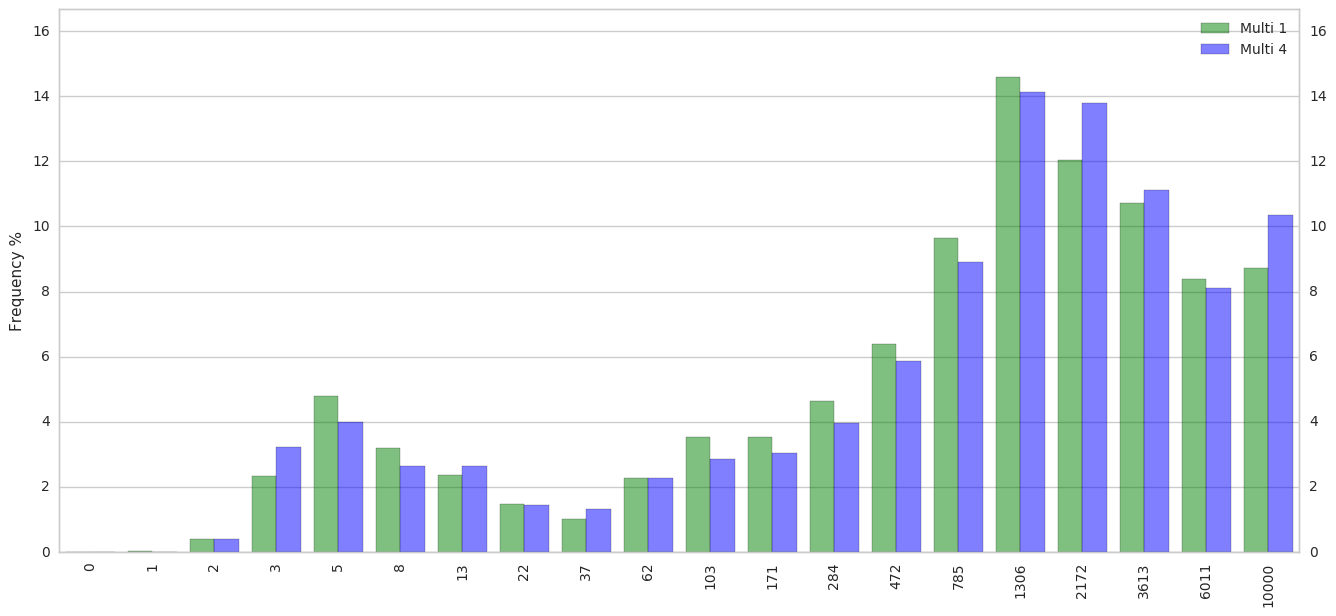

In [112]:
results.extend(compare_tab_groups(t3, t4, "payload/histograms/FX_PAGE_LOAD_MS"))

--- 
## MemoryUsage

### MEMORY_TOTAL 

## 1-3 Tabs

# Windows_NT

Comparison for MEMORY_TOTAL:

32770 (80.5%) multi_1 profiles on Windows_NT have the parent histogram.
32830 (80.6%) multi_4 profiles on Windows_NT have the parent histogram.
30245 (73.2%) webext_multi_1 profiles on Windows_NT have the parent histogram.
29778 (73.0%) webextx_multi_4 profiles on Windows_NT have the parent histogram.
21083 (71.2%) mpc_multi_1 profiles on Windows_NT have the parent histogram.
21186 (71.4%) mpc_multi_4 profiles on Windows_NT have the parent histogram.
No multi_1 profiles on Windows_NT have the child histogram.
No multi_4 profiles on Windows_NT have the child histogram.
No webext_multi_1 profiles on Windows_NT have the child histogram.
No webextx_multi_4 profiles on Windows_NT have the child histogram.
No mpc_multi_1 profiles on Windows_NT have the child histogram.
No mpc_multi_4 profiles on Windows_NT have the child histogram.


---
#### MEMORY_TOTAL (parent) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.926</b>.</span>
            

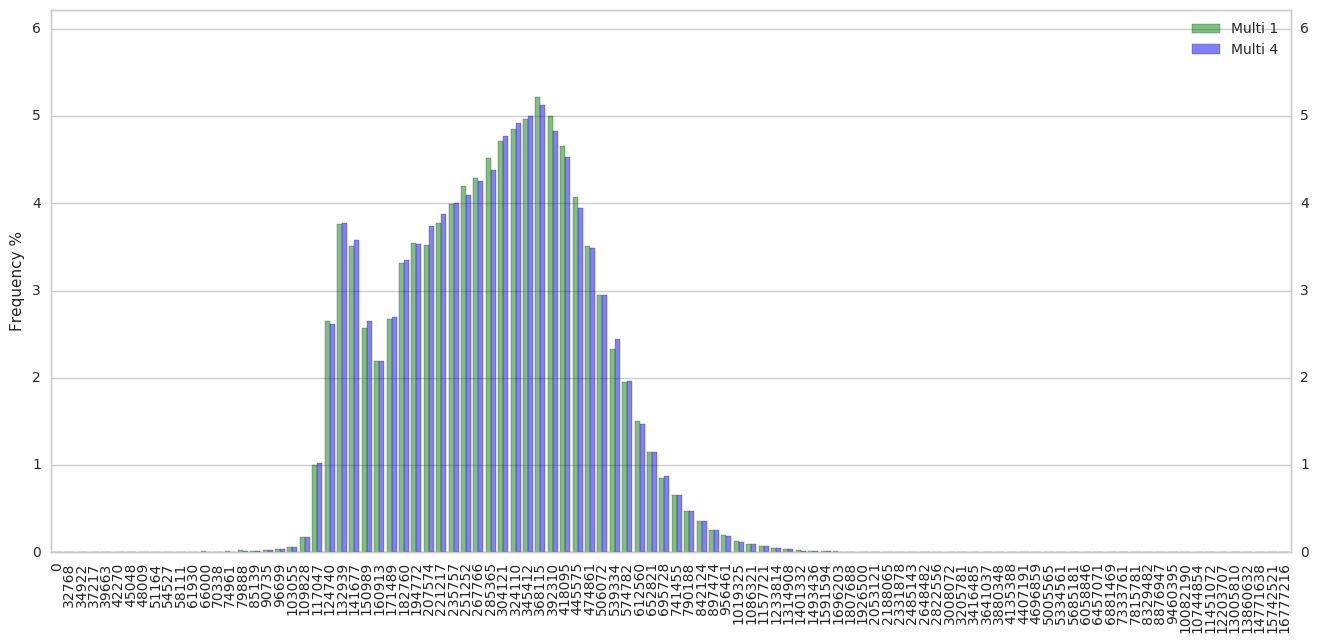

---
#### MEMORY_TOTAL (parent) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:red"><b>0.029</b>.</span>
            

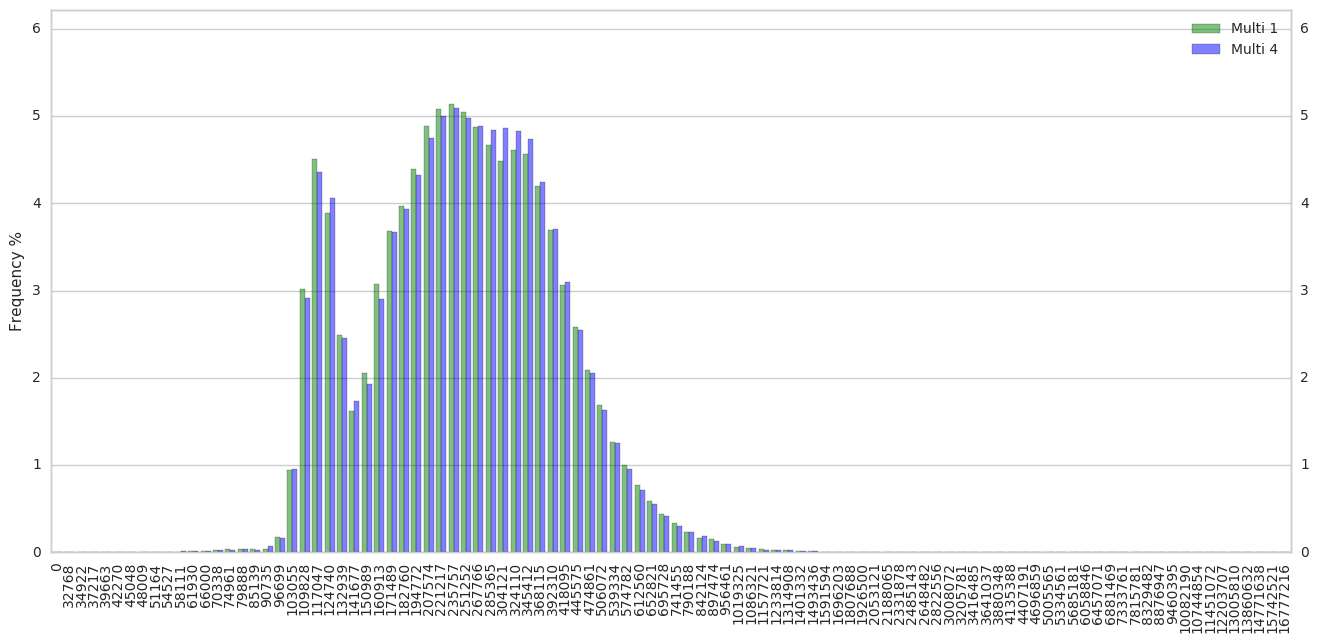

---
#### MEMORY_TOTAL (parent) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.229</b>.</span>
            

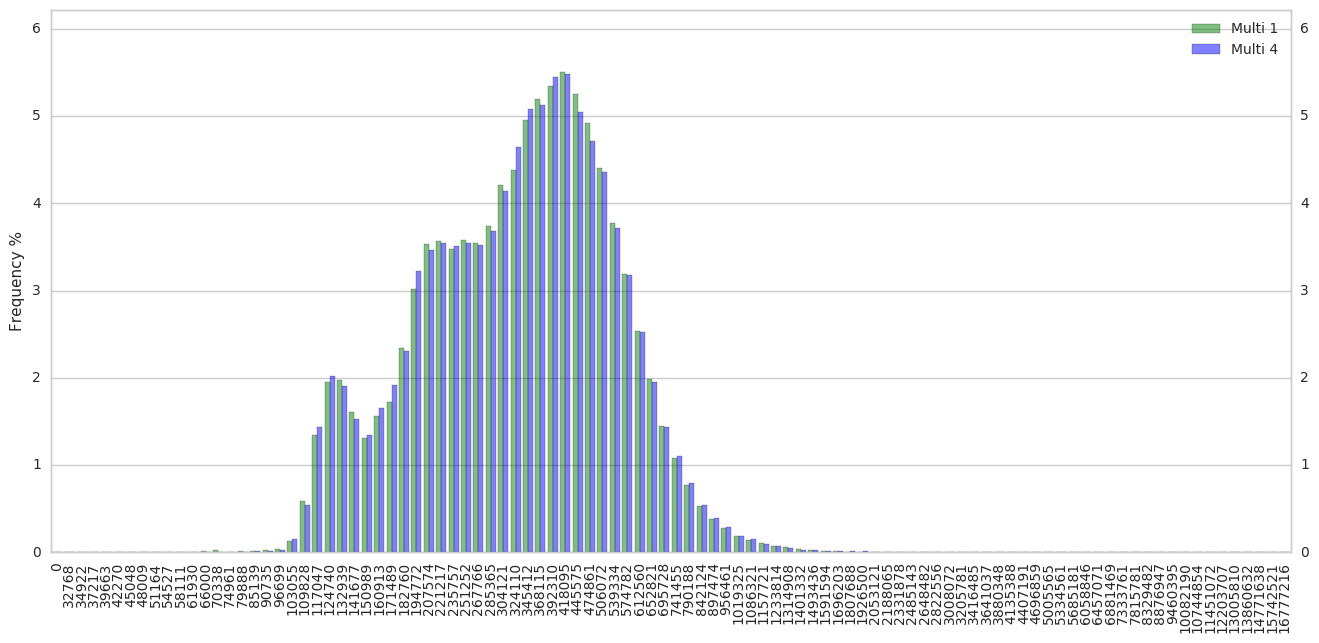

# Darwin

Comparison for MEMORY_TOTAL:

2843 (71.8%) multi_1 profiles on Darwin have the parent histogram.
2840 (71.7%) multi_4 profiles on Darwin have the parent histogram.
155 (64.6%) webext_multi_1 profiles on Darwin have the parent histogram.
142 (59.4%) webextx_multi_4 profiles on Darwin have the parent histogram.
272 (59.9%) mpc_multi_1 profiles on Darwin have the parent histogram.
265 (63.2%) mpc_multi_4 profiles on Darwin have the parent histogram.
No multi_1 profiles on Darwin have the child histogram.
No multi_4 profiles on Darwin have the child histogram.
No webext_multi_1 profiles on Darwin have the child histogram.
No webextx_multi_4 profiles on Darwin have the child histogram.
No mpc_multi_1 profiles on Darwin have the child histogram.
No mpc_multi_4 profiles on Darwin have the child histogram.


---
#### MEMORY_TOTAL (parent) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.594</b>.</span>
            

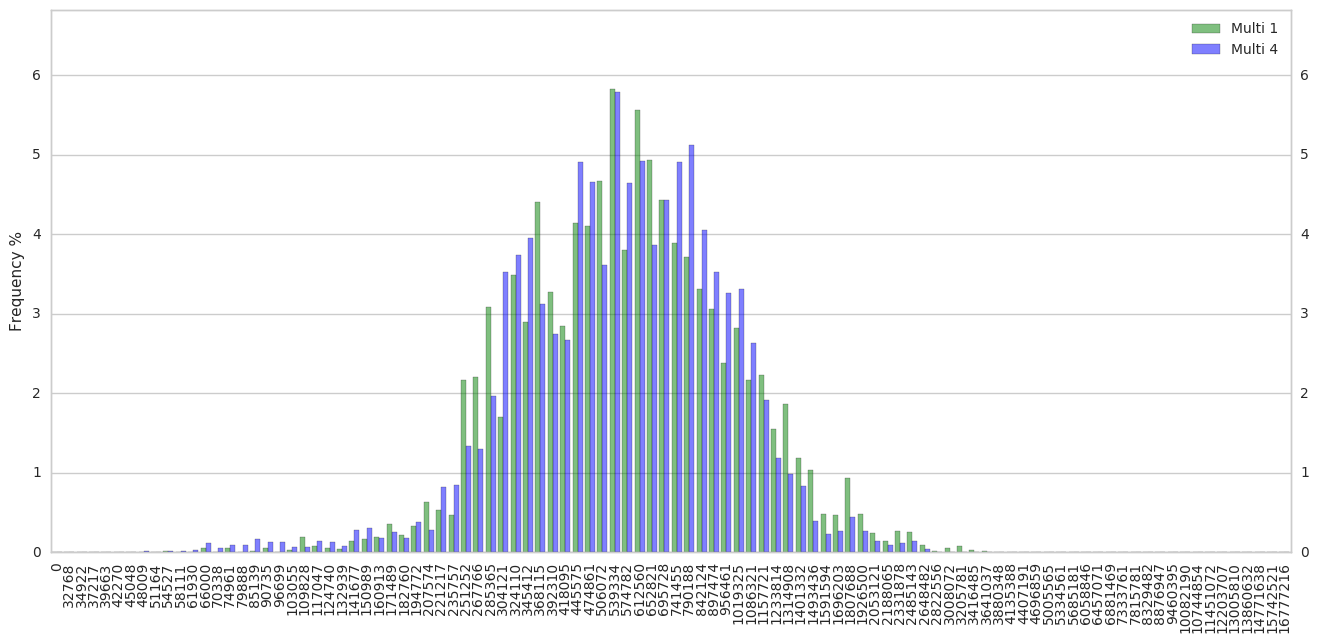

---
#### MEMORY_TOTAL (parent) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.801</b>.</span>
            

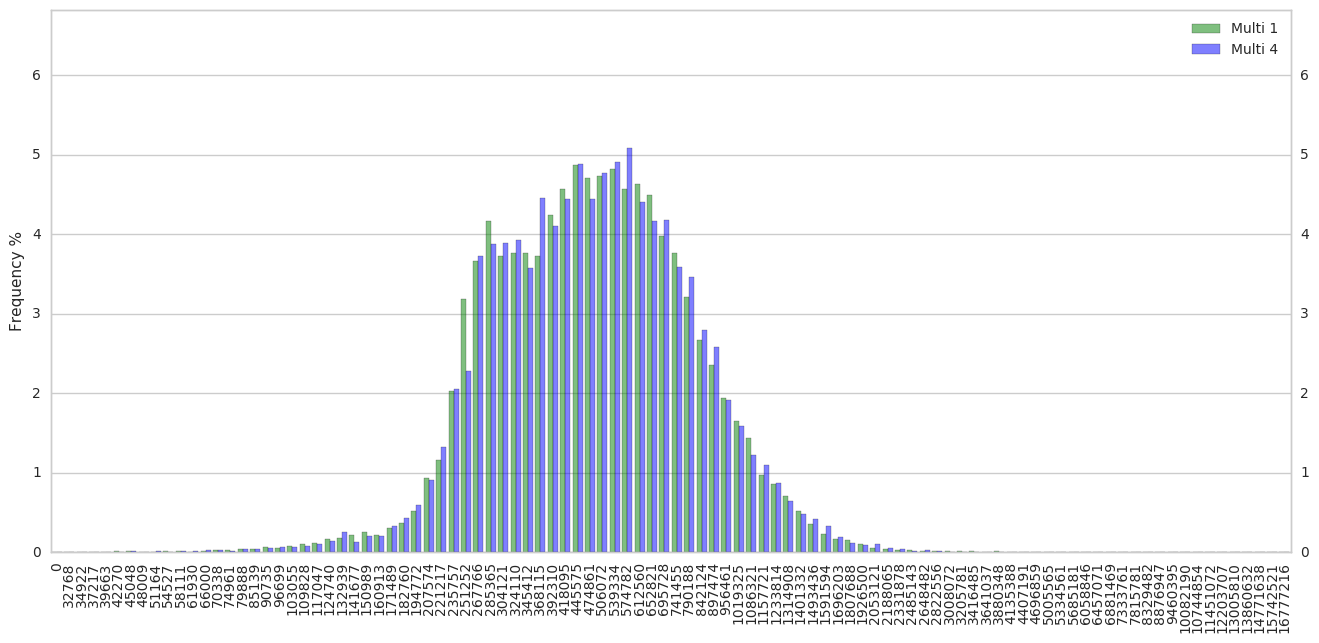

---
#### MEMORY_TOTAL (parent) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.400</b>.</span>
            

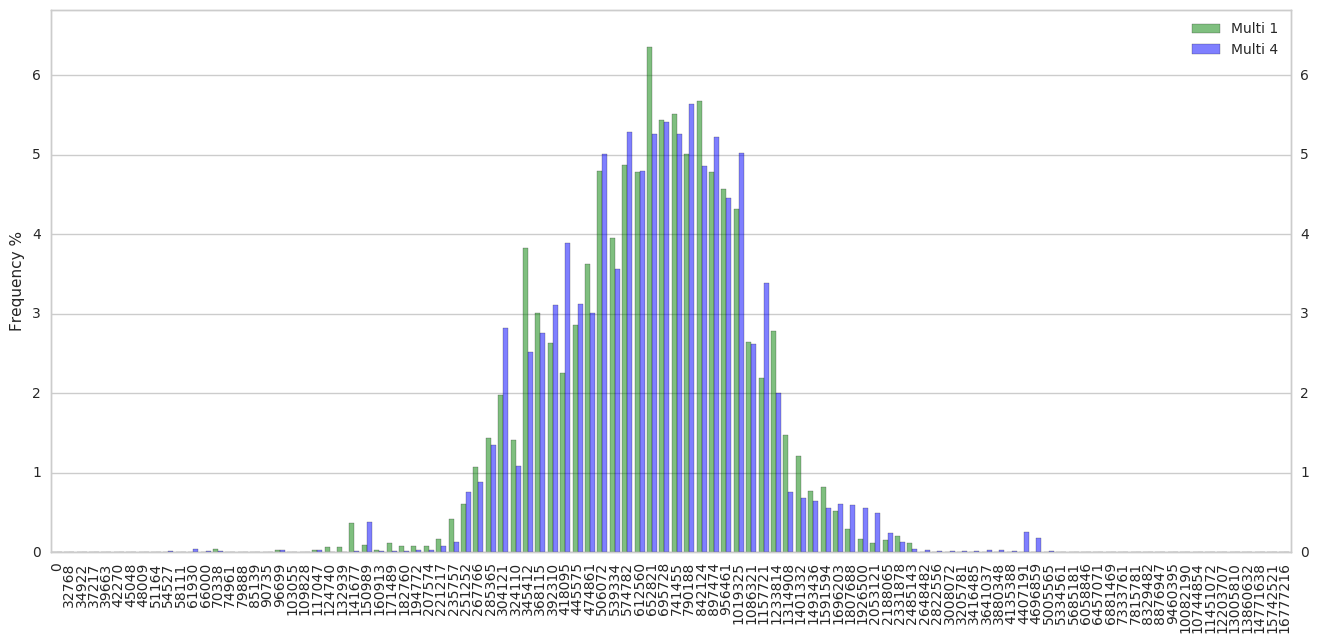

## 4+ Tabs

# Windows_NT

Comparison for MEMORY_TOTAL:

7656 (18.8%) multi_1 profiles on Windows_NT have the parent histogram.
7697 (18.9%) multi_4 profiles on Windows_NT have the parent histogram.
10761 (26.0%) webext_multi_1 profiles on Windows_NT have the parent histogram.
10713 (26.2%) webextx_multi_4 profiles on Windows_NT have the parent histogram.
8363 (28.2%) mpc_multi_1 profiles on Windows_NT have the parent histogram.
8327 (28.0%) mpc_multi_4 profiles on Windows_NT have the parent histogram.
No multi_1 profiles on Windows_NT have the child histogram.
No multi_4 profiles on Windows_NT have the child histogram.
No webext_multi_1 profiles on Windows_NT have the child histogram.
No webextx_multi_4 profiles on Windows_NT have the child histogram.
No mpc_multi_1 profiles on Windows_NT have the child histogram.
No mpc_multi_4 profiles on Windows_NT have the child histogram.


---
#### MEMORY_TOTAL (parent) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.557</b>.</span>
            

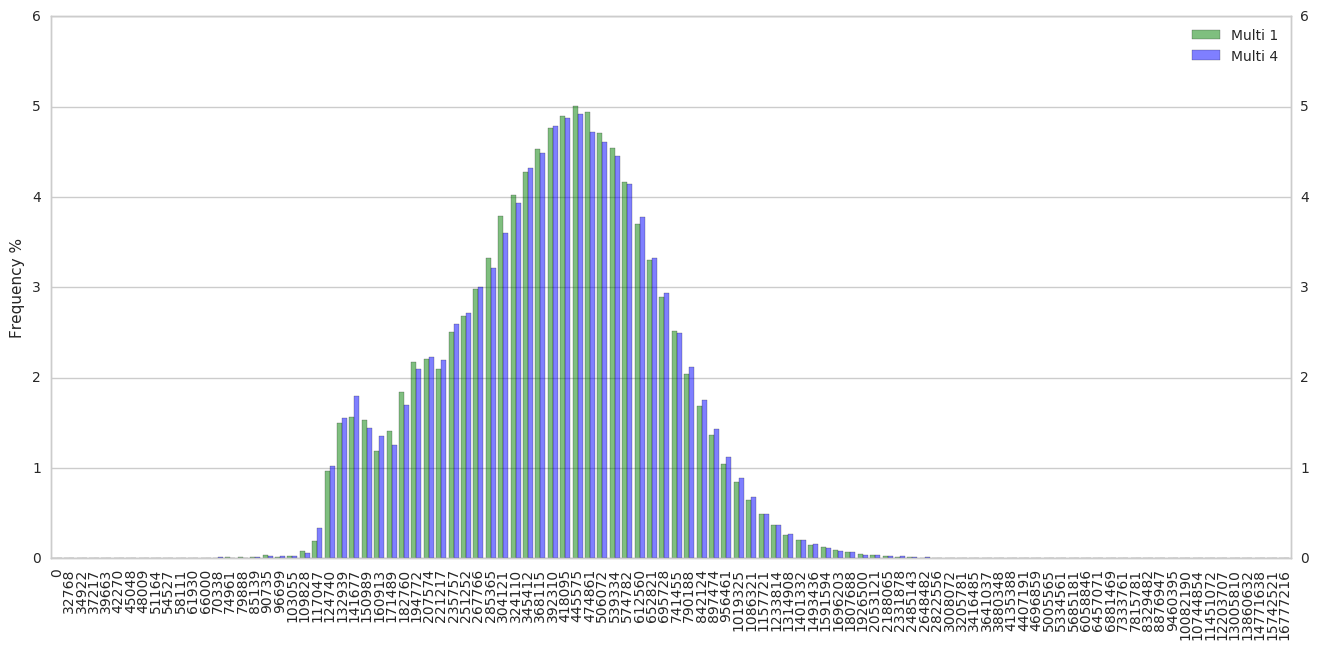

---
#### MEMORY_TOTAL (parent) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.879</b>.</span>
            

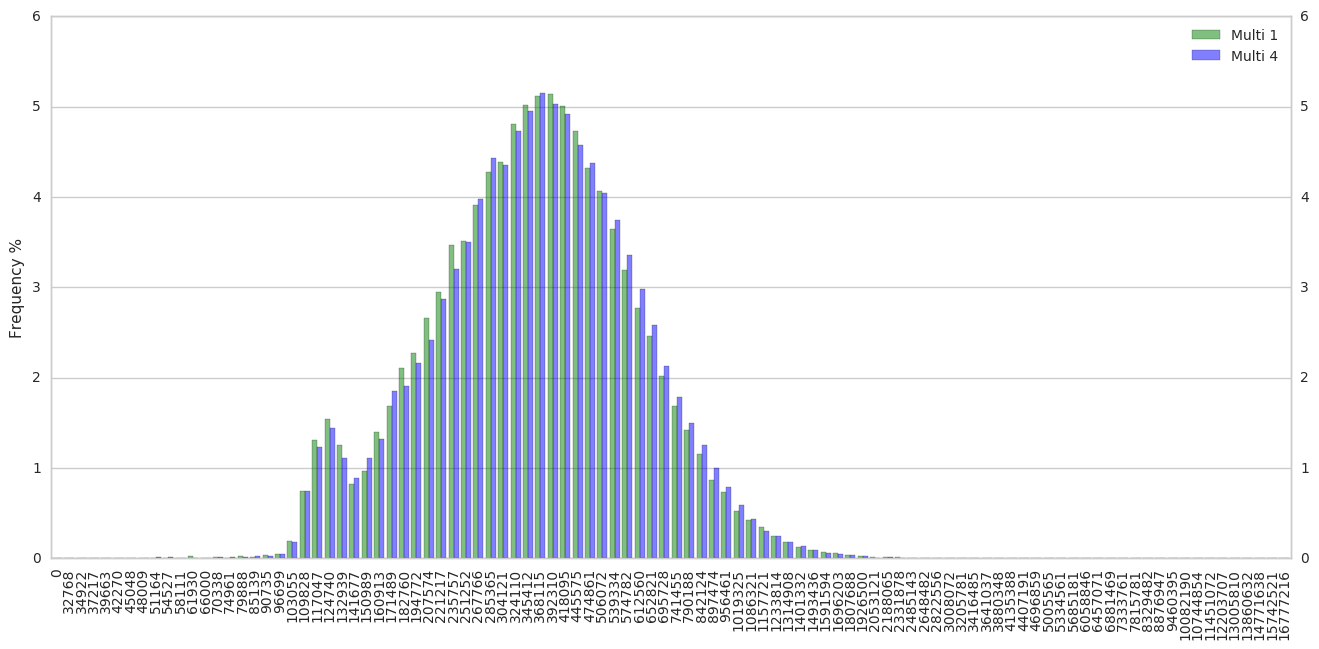

---
#### MEMORY_TOTAL (parent) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.590</b>.</span>
            

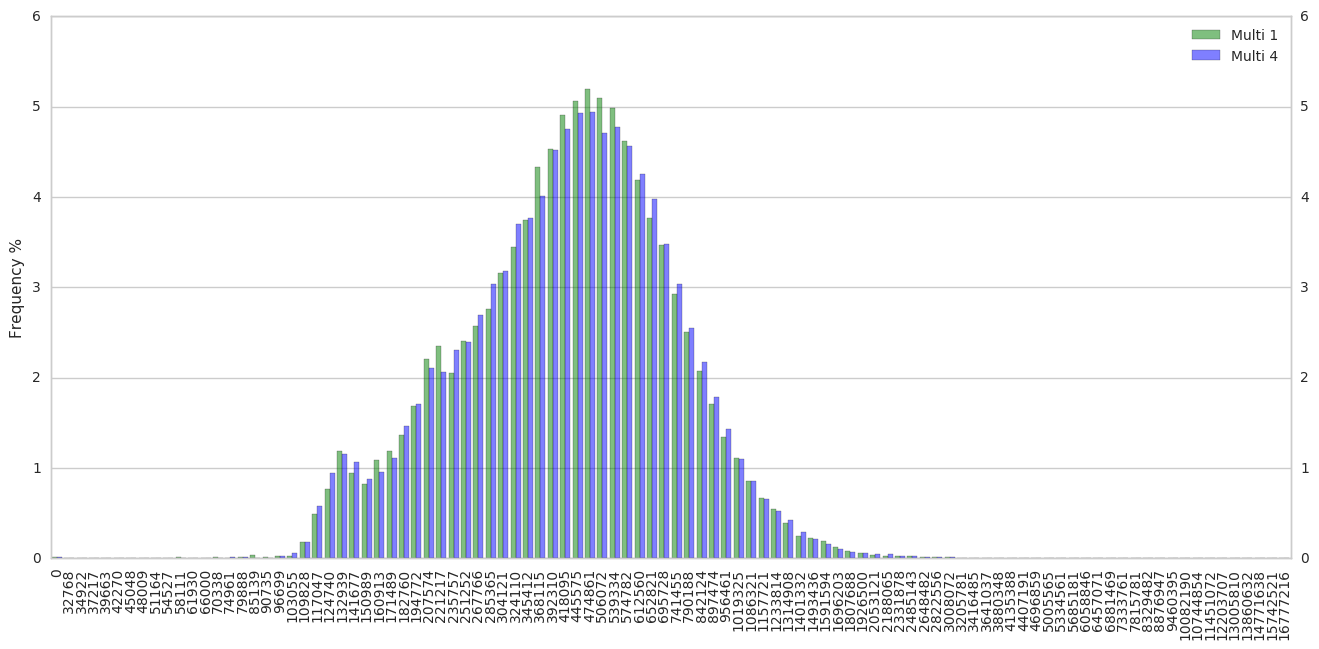

# Darwin

Comparison for MEMORY_TOTAL:

1107 (28.0%) multi_1 profiles on Darwin have the parent histogram.
1117 (28.2%) multi_4 profiles on Darwin have the parent histogram.
85 (35.4%) webext_multi_1 profiles on Darwin have the parent histogram.
97 (40.6%) webextx_multi_4 profiles on Darwin have the parent histogram.
181 (39.9%) mpc_multi_1 profiles on Darwin have the parent histogram.
154 (36.8%) mpc_multi_4 profiles on Darwin have the parent histogram.
No multi_1 profiles on Darwin have the child histogram.
No multi_4 profiles on Darwin have the child histogram.
No webext_multi_1 profiles on Darwin have the child histogram.
No webextx_multi_4 profiles on Darwin have the child histogram.
No mpc_multi_1 profiles on Darwin have the child histogram.
No mpc_multi_4 profiles on Darwin have the child histogram.


---
#### MEMORY_TOTAL (parent) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.783</b>.</span>
            

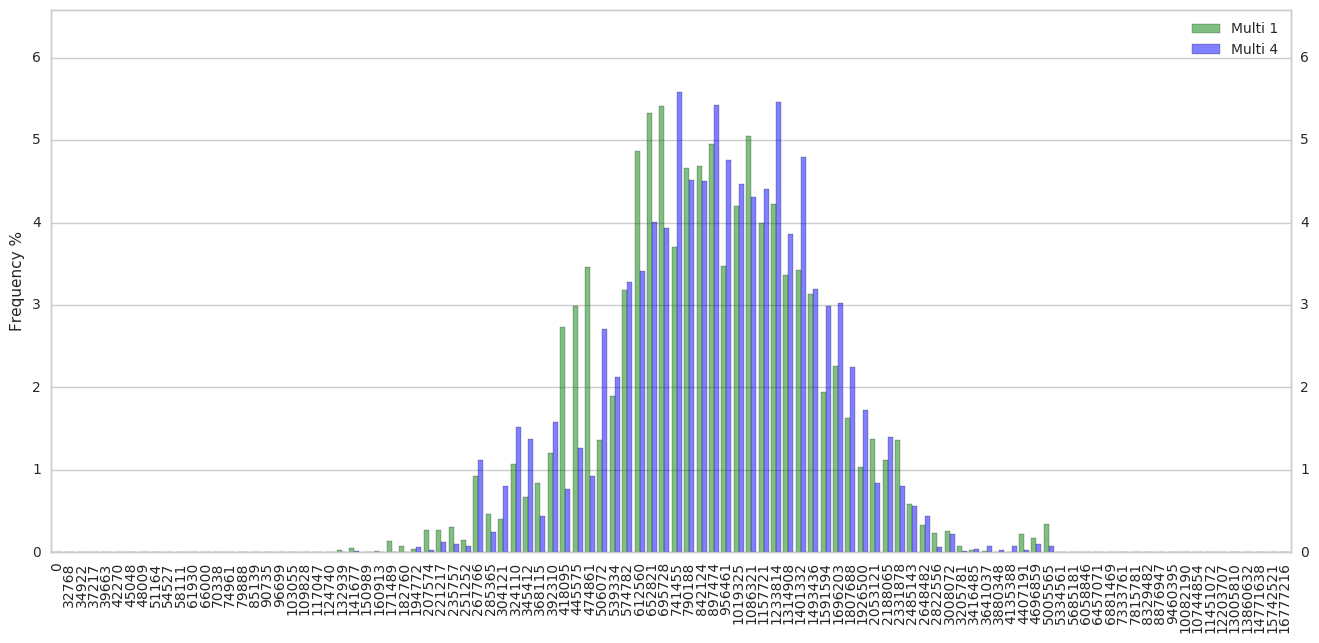

---
#### MEMORY_TOTAL (parent) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.189</b>.</span>
            

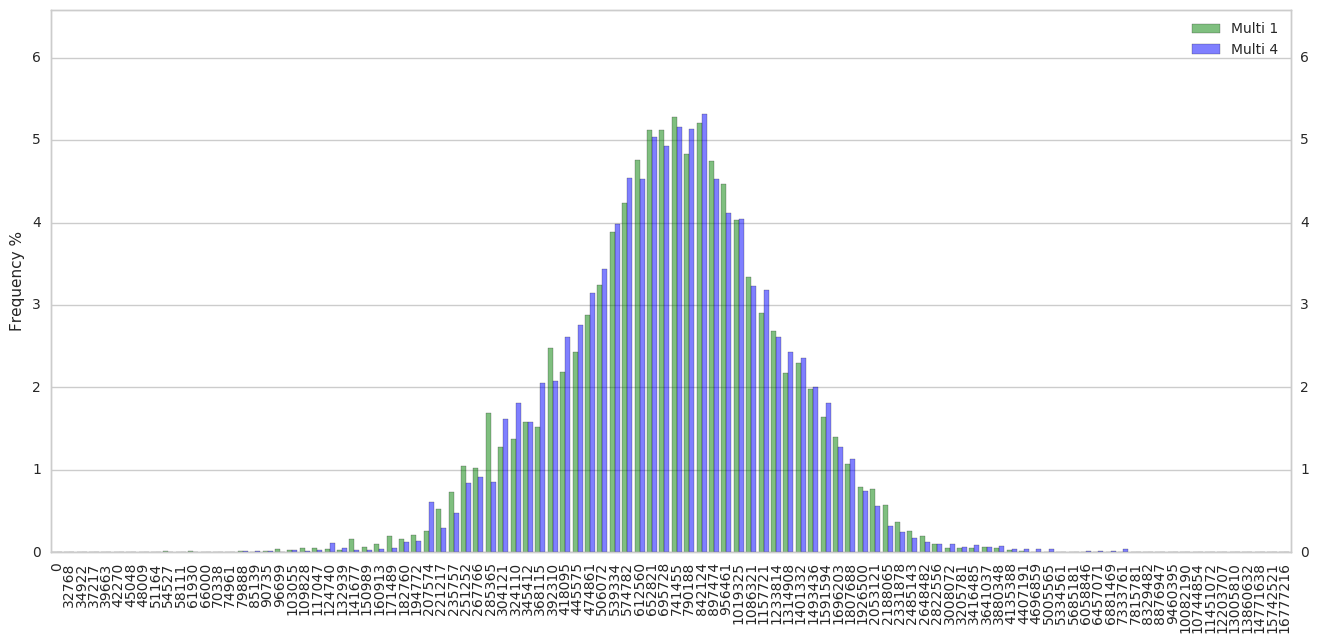

---
#### MEMORY_TOTAL (parent) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.436</b>.</span>
            

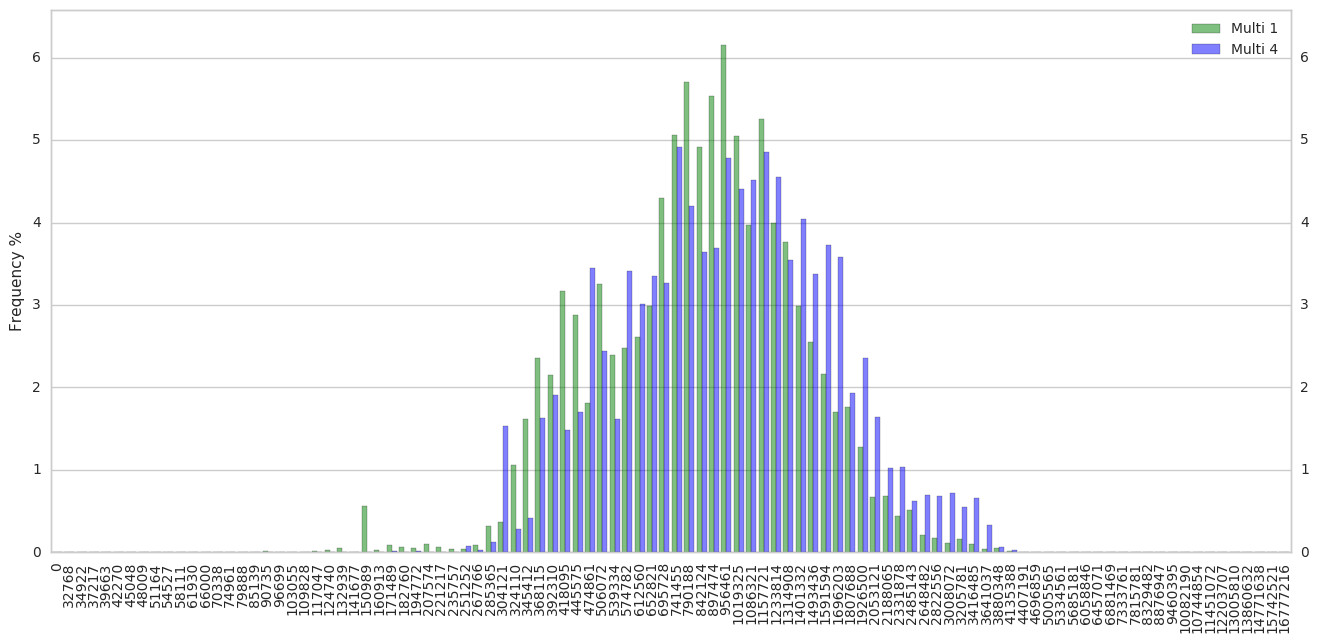

In [113]:
results.extend(compare_tab_groups(t3, t4, "payload/histograms/MEMORY_TOTAL"))

### MEMORY_VSIZE_MAX_CONTIGUOUS 

## 1-3 Tabs

# Windows_NT

Comparison for MEMORY_VSIZE_MAX_CONTIGUOUS:

33005 (81.1%) multi_1 profiles on Windows_NT have the parent histogram.
33067 (81.1%) multi_4 profiles on Windows_NT have the parent histogram.
30492 (73.8%) webext_multi_1 profiles on Windows_NT have the parent histogram.
30029 (73.6%) webextx_multi_4 profiles on Windows_NT have the parent histogram.
21209 (71.6%) mpc_multi_1 profiles on Windows_NT have the parent histogram.
21319 (71.8%) mpc_multi_4 profiles on Windows_NT have the parent histogram.
27100 (66.6%) multi_1 profiles on Windows_NT have the child histogram.
27235 (66.8%) multi_4 profiles on Windows_NT have the child histogram.
25281 (61.2%) webext_multi_1 profiles on Windows_NT have the child histogram.
24847 (60.9%) webextx_multi_4 profiles on Windows_NT have the child histogram.
17987 (60.7%) mpc_multi_1 profiles on Windows_NT have the child histogram.
18046 (60.8%) mpc_multi_4 profiles on Windows_NT have the child histogram.


---
#### MEMORY_VSIZE_MAX_CONTIGUOUS (parent) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.617</b>.</span>
            

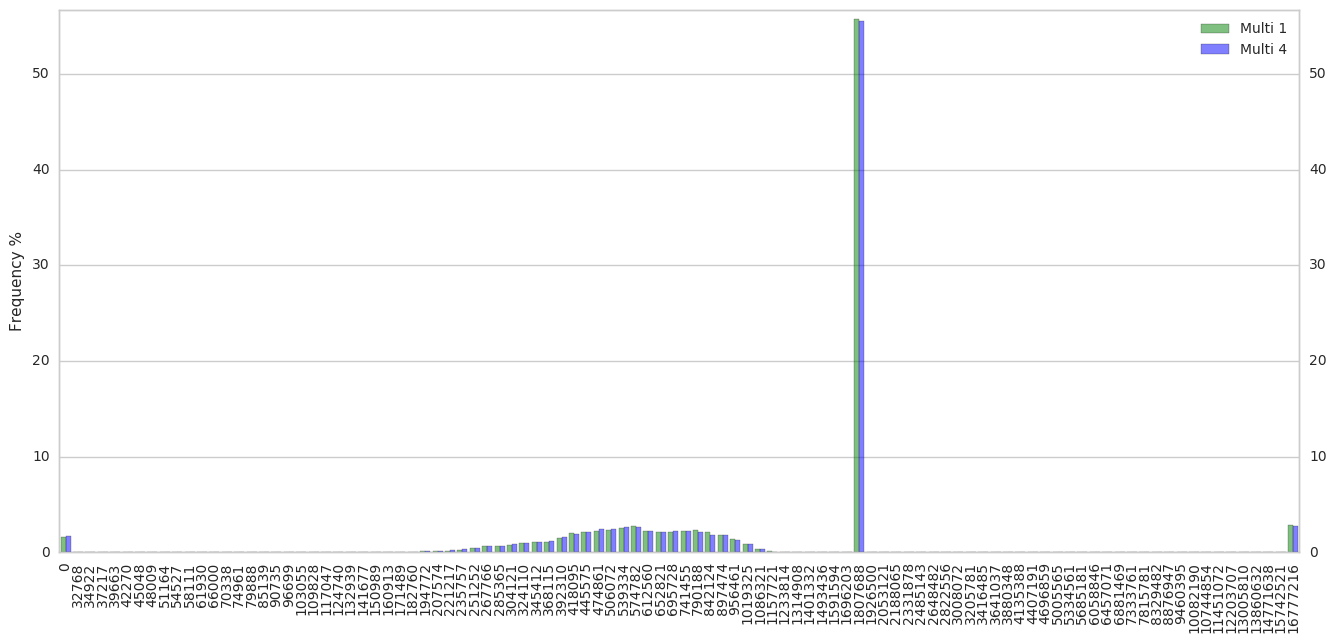

---
#### MEMORY_VSIZE_MAX_CONTIGUOUS (parent) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.496</b>.</span>
            

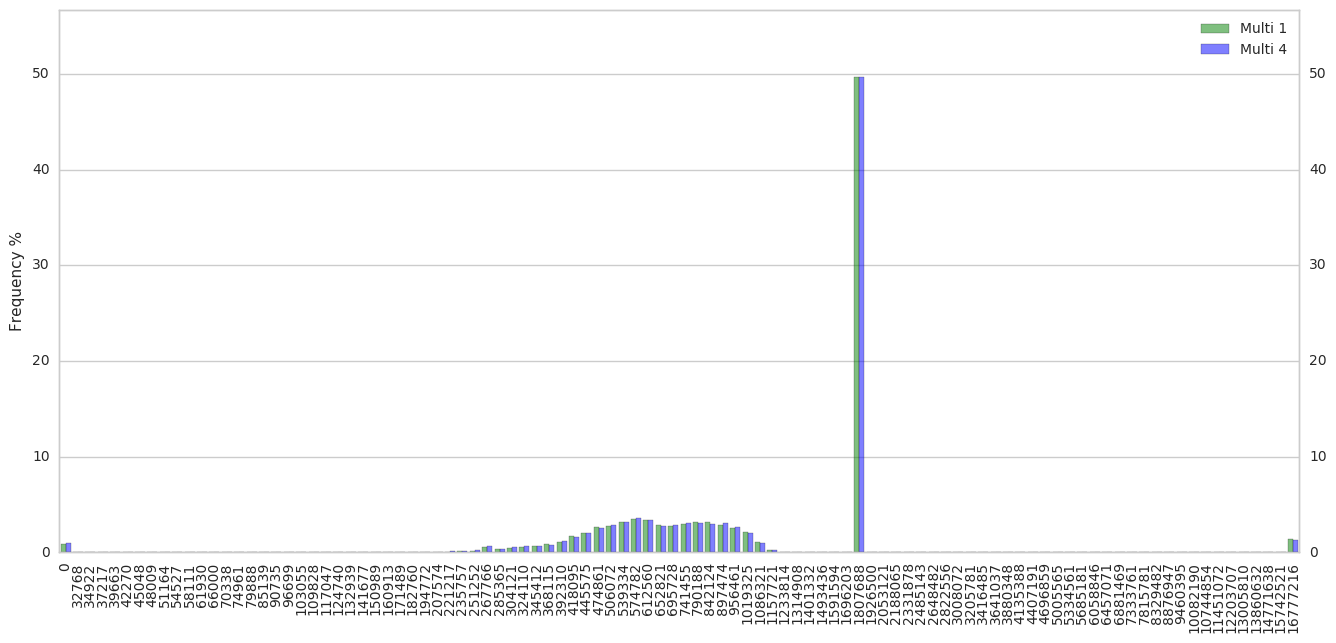

---
#### MEMORY_VSIZE_MAX_CONTIGUOUS (parent) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.273</b>.</span>
            

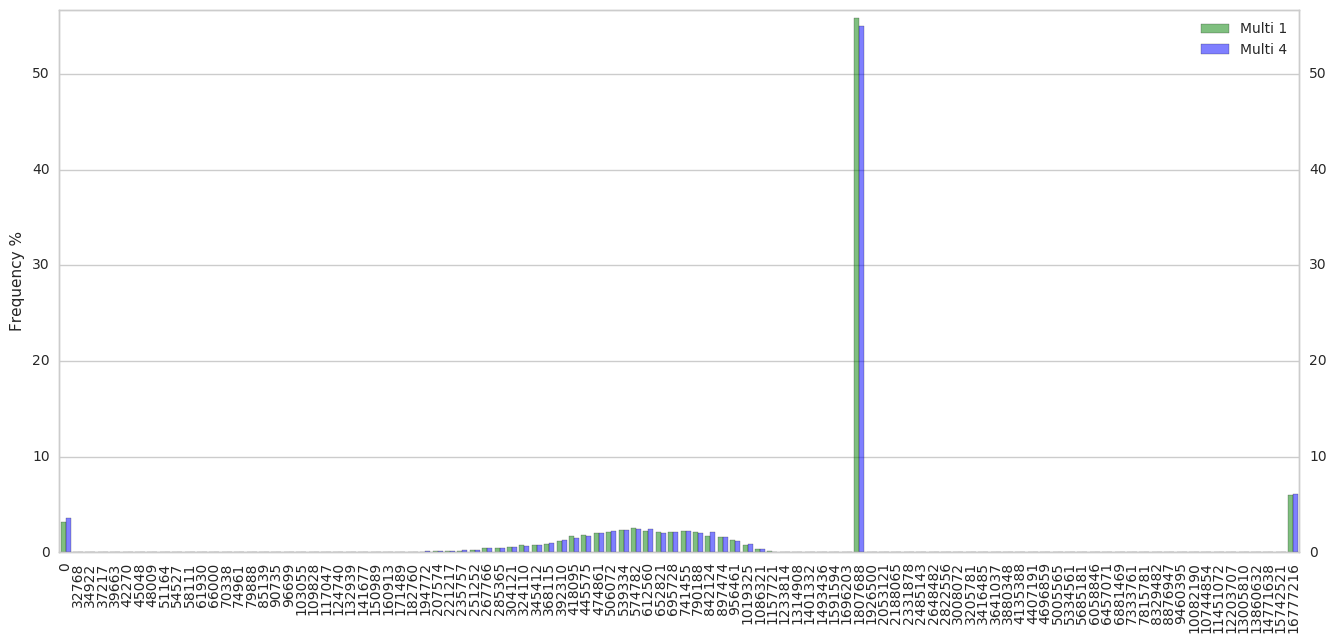

---
#### MEMORY_VSIZE_MAX_CONTIGUOUS (children) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.193</b>.</span>
            

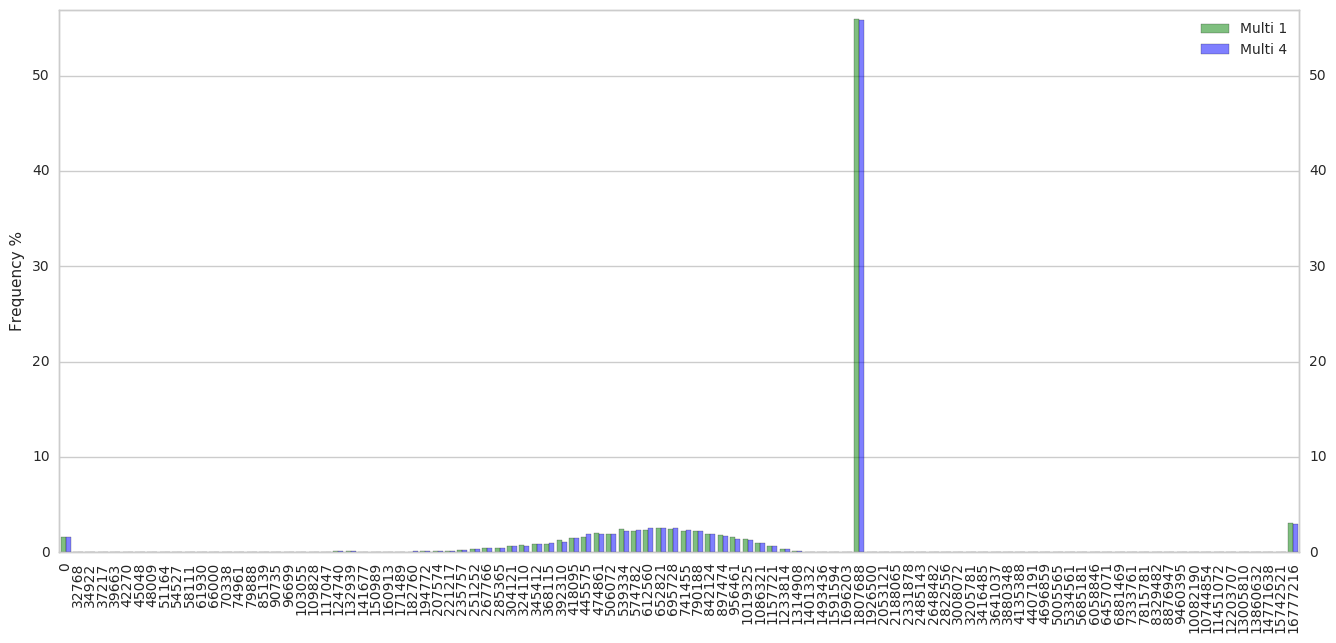

---
#### MEMORY_VSIZE_MAX_CONTIGUOUS (children) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.410</b>.</span>
            

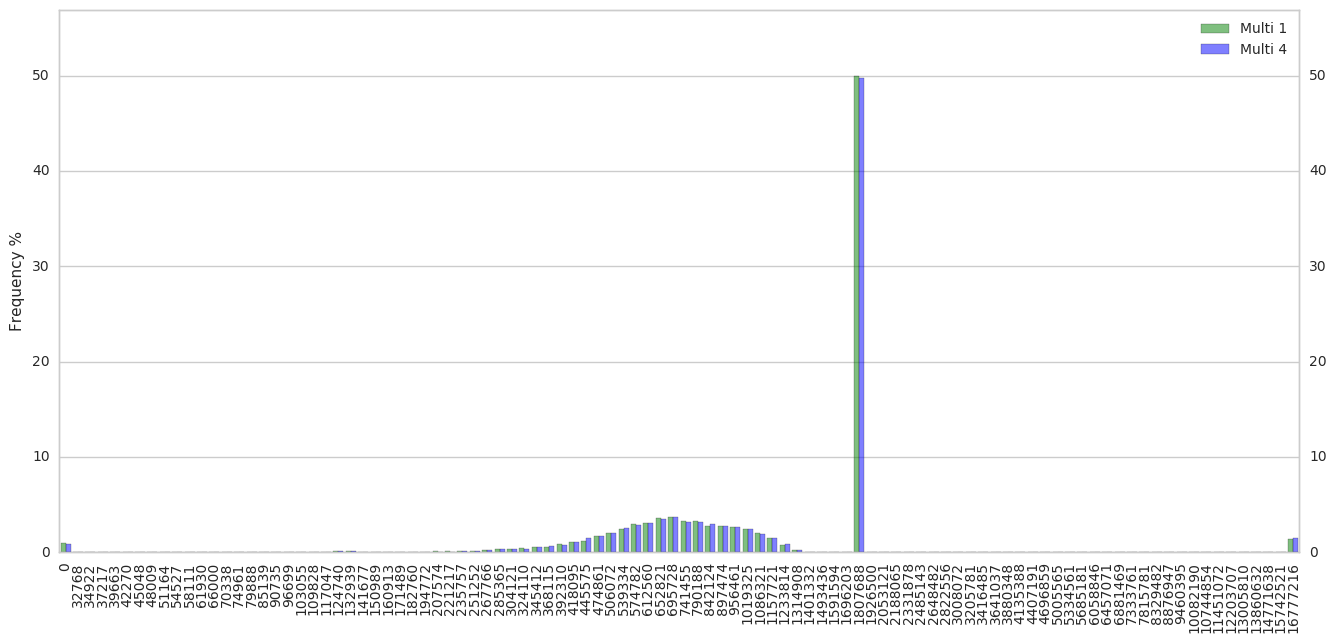

---
#### MEMORY_VSIZE_MAX_CONTIGUOUS (children) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.773</b>.</span>
            

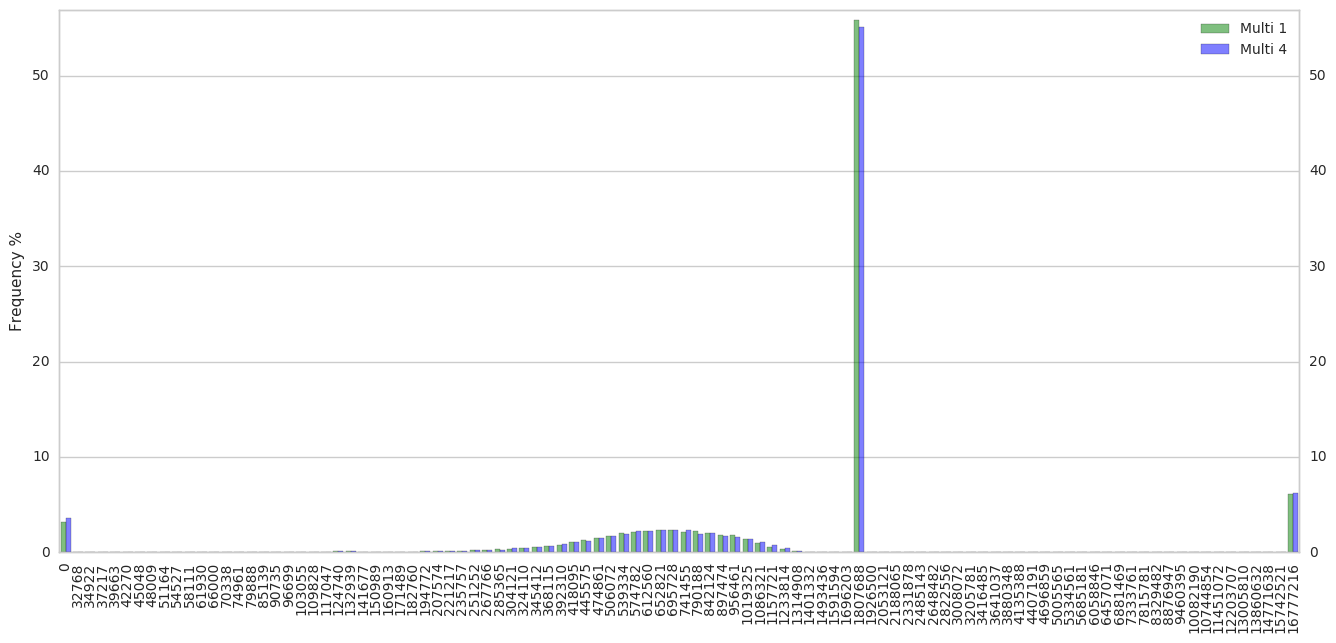

# Darwin

Comparison for MEMORY_VSIZE_MAX_CONTIGUOUS:

No multi_1 profiles on Darwin have the parent histogram.
No multi_4 profiles on Darwin have the parent histogram.
No webext_multi_1 profiles on Darwin have the parent histogram.
No webextx_multi_4 profiles on Darwin have the parent histogram.
No mpc_multi_1 profiles on Darwin have the parent histogram.
No mpc_multi_4 profiles on Darwin have the parent histogram.
No multi_1 profiles on Darwin have the child histogram.
No multi_4 profiles on Darwin have the child histogram.
No webext_multi_1 profiles on Darwin have the child histogram.
No webextx_multi_4 profiles on Darwin have the child histogram.
No mpc_multi_1 profiles on Darwin have the child histogram.
No mpc_multi_4 profiles on Darwin have the child histogram.


## 4+ Tabs

# Windows_NT

Comparison for MEMORY_VSIZE_MAX_CONTIGUOUS:

7690 (18.9%) multi_1 profiles on Windows_NT have the parent histogram.
7729 (19.0%) multi_4 profiles on Windows_NT have the parent histogram.
10809 (26.2%) webext_multi_1 profiles on Windows_NT have the parent histogram.
10780 (26.4%) webextx_multi_4 profiles on Windows_NT have the parent histogram.
8398 (28.4%) mpc_multi_1 profiles on Windows_NT have the parent histogram.
8365 (28.2%) mpc_multi_4 profiles on Windows_NT have the parent histogram.
7158 (17.6%) multi_1 profiles on Windows_NT have the child histogram.
7211 (17.7%) multi_4 profiles on Windows_NT have the child histogram.
9940 (24.1%) webext_multi_1 profiles on Windows_NT have the child histogram.
9880 (24.2%) webextx_multi_4 profiles on Windows_NT have the child histogram.
7670 (25.9%) mpc_multi_1 profiles on Windows_NT have the child histogram.
7596 (25.6%) mpc_multi_4 profiles on Windows_NT have the child histogram.


---
#### MEMORY_VSIZE_MAX_CONTIGUOUS (parent) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:red"><b>0.023</b>.</span>
            

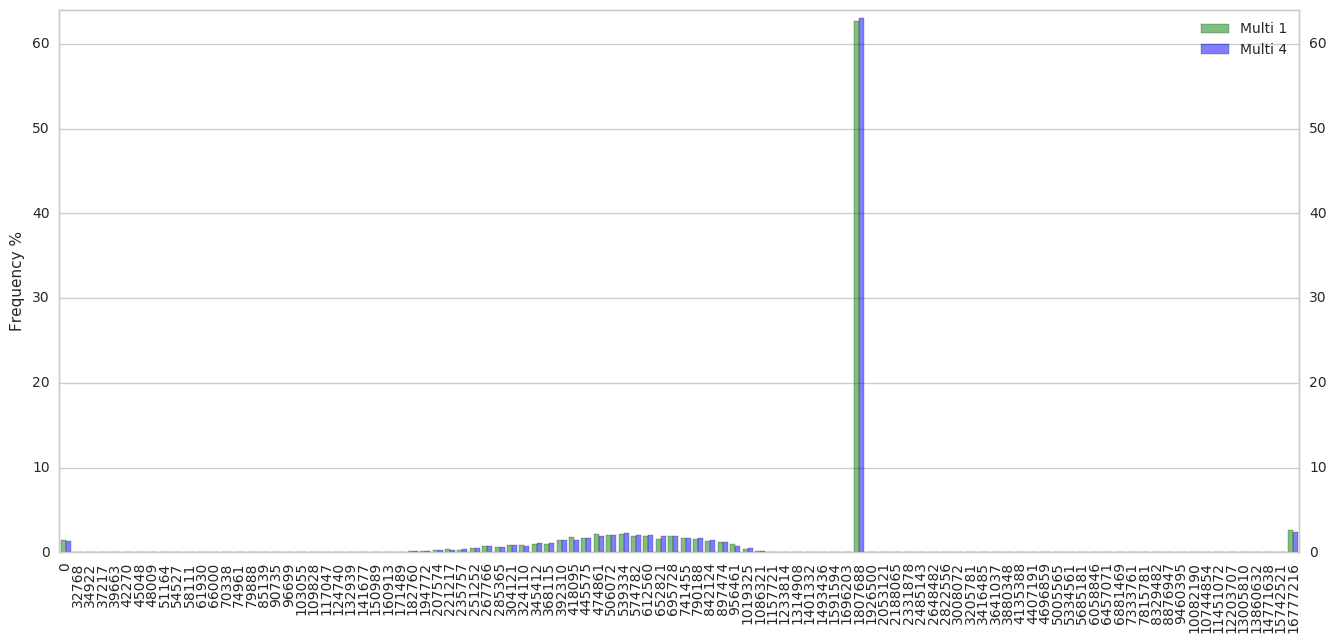

---
#### MEMORY_VSIZE_MAX_CONTIGUOUS (parent) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.934</b>.</span>
            

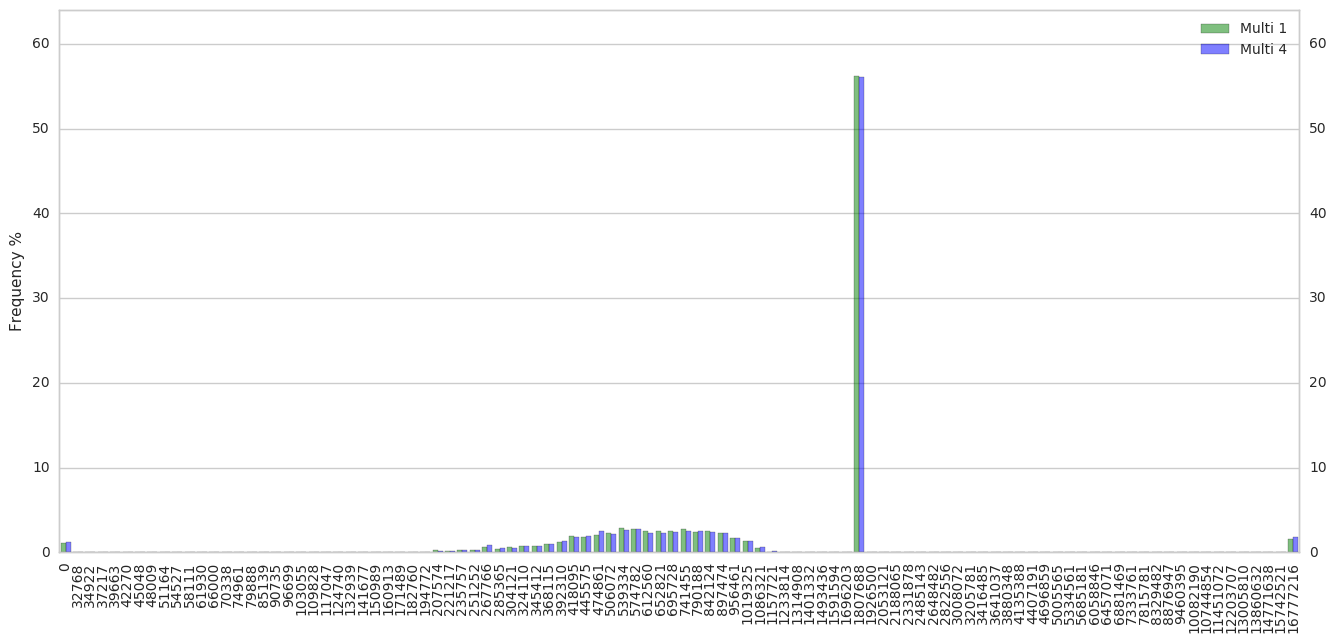

---
#### MEMORY_VSIZE_MAX_CONTIGUOUS (parent) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.236</b>.</span>
            

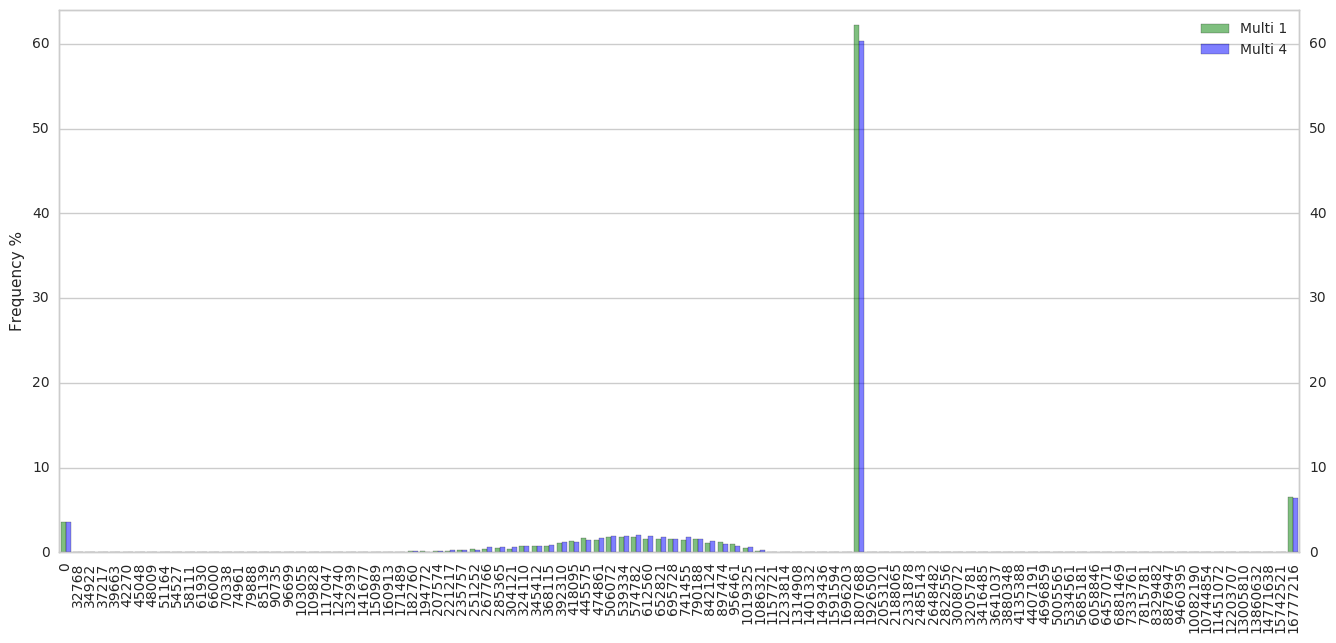

---
#### MEMORY_VSIZE_MAX_CONTIGUOUS (children) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.254</b>.</span>
            

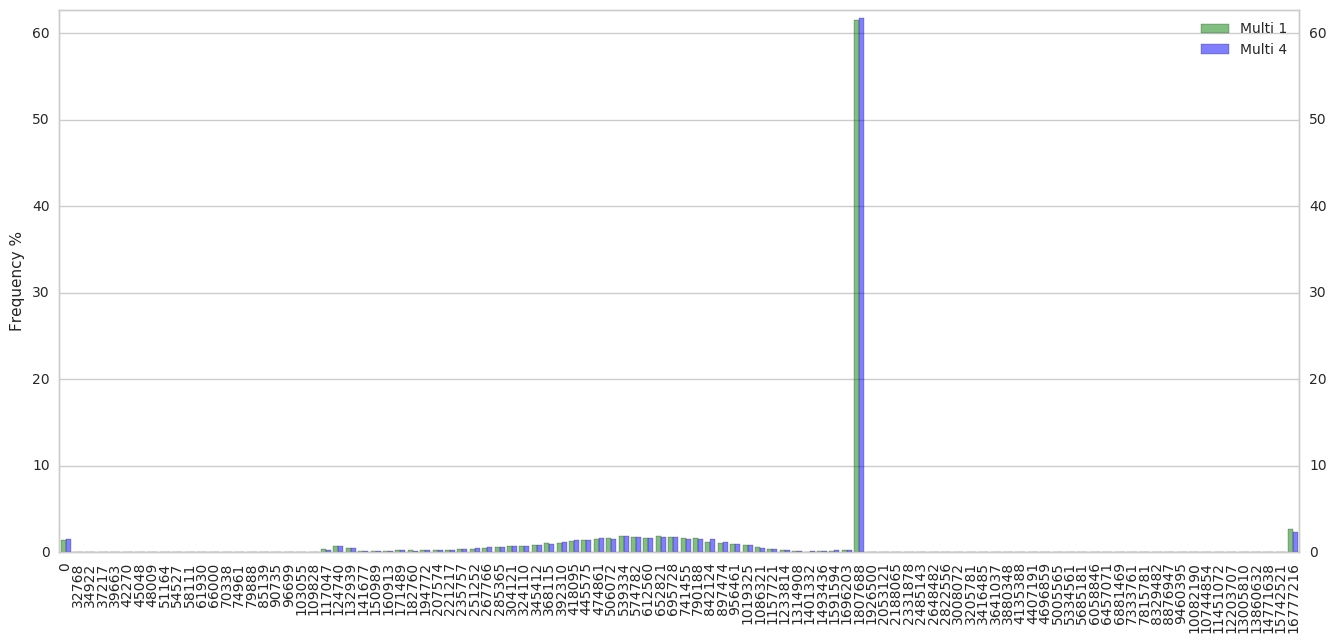

---
#### MEMORY_VSIZE_MAX_CONTIGUOUS (children) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.729</b>.</span>
            

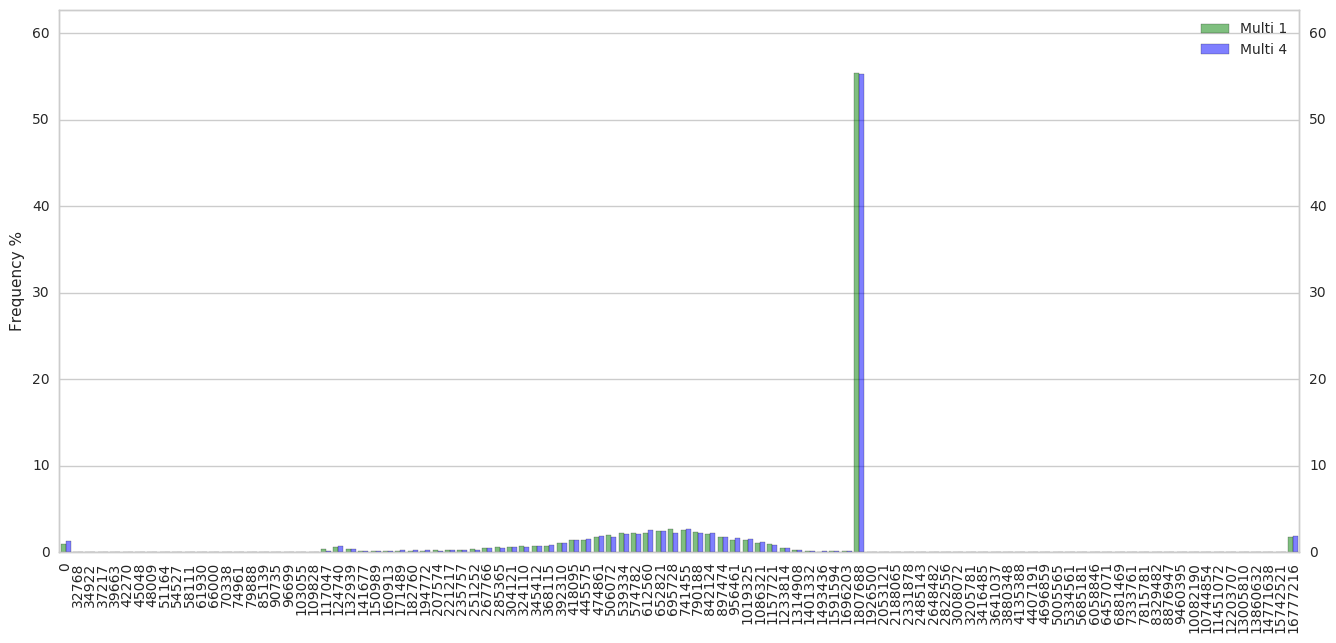

---
#### MEMORY_VSIZE_MAX_CONTIGUOUS (children) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.062</b>.</span>
            

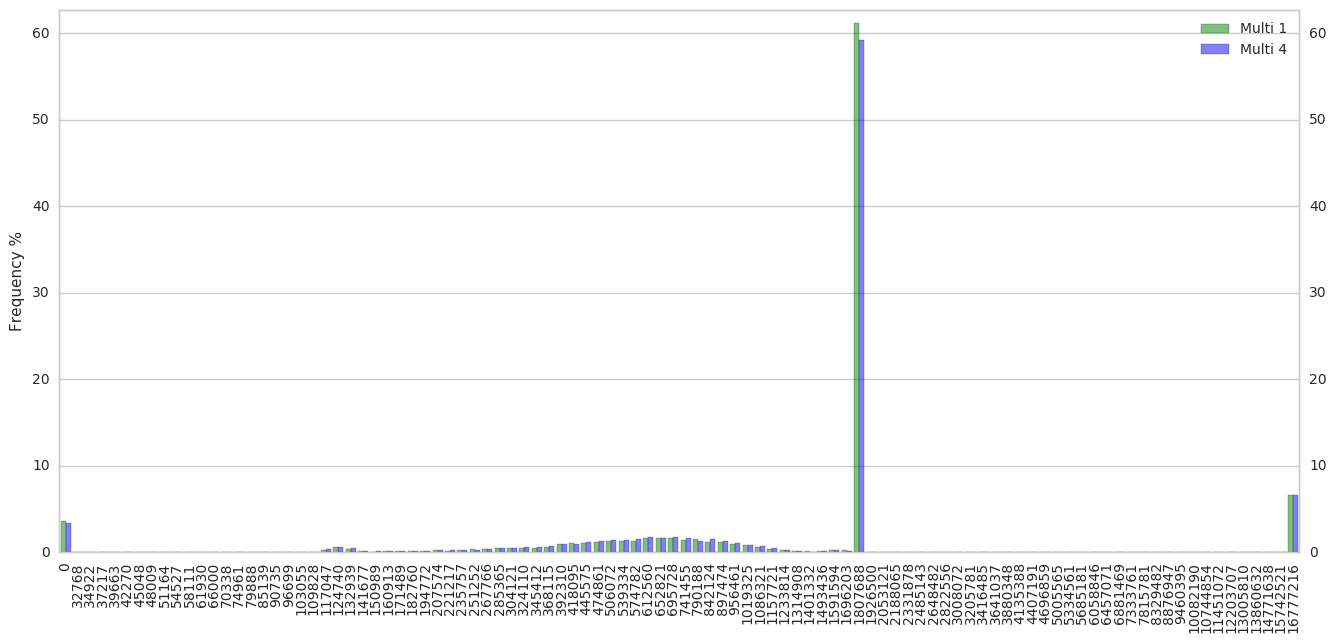

# Darwin

Comparison for MEMORY_VSIZE_MAX_CONTIGUOUS:

No multi_1 profiles on Darwin have the parent histogram.
No multi_4 profiles on Darwin have the parent histogram.
No webext_multi_1 profiles on Darwin have the parent histogram.
No webextx_multi_4 profiles on Darwin have the parent histogram.
No mpc_multi_1 profiles on Darwin have the parent histogram.
No mpc_multi_4 profiles on Darwin have the parent histogram.
No multi_1 profiles on Darwin have the child histogram.
No multi_4 profiles on Darwin have the child histogram.
No webext_multi_1 profiles on Darwin have the child histogram.
No webextx_multi_4 profiles on Darwin have the child histogram.
No mpc_multi_1 profiles on Darwin have the child histogram.
No mpc_multi_4 profiles on Darwin have the child histogram.


In [114]:
results.extend(compare_tab_groups(t3, t4, "payload/histograms/MEMORY_VSIZE_MAX_CONTIGUOUS"))

### MEMORY_DISTRIBUTION_AMONG_CONTENT

In [116]:
results.extend(compare_tab_groups(t3, t4, "payload/histograms/MEMORY_DISTRIBUTION_AMONG_CONTENT"))

## 1-3 Tabs

# Windows_NT

Comparison for MEMORY_DISTRIBUTION_AMONG_CONTENT:

No multi_1 profiles on Windows_NT have the parent histogram.
No multi_4 profiles on Windows_NT have the parent histogram.
No webext_multi_1 profiles on Windows_NT have the parent histogram.
No webextx_multi_4 profiles on Windows_NT have the parent histogram.
No mpc_multi_1 profiles on Windows_NT have the parent histogram.
No mpc_multi_4 profiles on Windows_NT have the parent histogram.
No multi_1 profiles on Windows_NT have the child histogram.
No multi_4 profiles on Windows_NT have the child histogram.
No webext_multi_1 profiles on Windows_NT have the child histogram.
No webextx_multi_4 profiles on Windows_NT have the child histogram.
No mpc_multi_1 profiles on Windows_NT have the child histogram.
No mpc_multi_4 profiles on Windows_NT have the child histogram.


# Darwin

Comparison for MEMORY_DISTRIBUTION_AMONG_CONTENT:

No multi_1 profiles on Darwin have the parent histogram.
No multi_4 profiles on Darwin have the parent histogram.
No webext_multi_1 profiles on Darwin have the parent histogram.
No webextx_multi_4 profiles on Darwin have the parent histogram.
No mpc_multi_1 profiles on Darwin have the parent histogram.
No mpc_multi_4 profiles on Darwin have the parent histogram.
No multi_1 profiles on Darwin have the child histogram.
No multi_4 profiles on Darwin have the child histogram.
No webext_multi_1 profiles on Darwin have the child histogram.
No webextx_multi_4 profiles on Darwin have the child histogram.
No mpc_multi_1 profiles on Darwin have the child histogram.
No mpc_multi_4 profiles on Darwin have the child histogram.


## 4+ Tabs

# Windows_NT

Comparison for MEMORY_DISTRIBUTION_AMONG_CONTENT:

No multi_1 profiles on Windows_NT have the parent histogram.
No multi_4 profiles on Windows_NT have the parent histogram.
No webext_multi_1 profiles on Windows_NT have the parent histogram.
No webextx_multi_4 profiles on Windows_NT have the parent histogram.
No mpc_multi_1 profiles on Windows_NT have the parent histogram.
No mpc_multi_4 profiles on Windows_NT have the parent histogram.
No multi_1 profiles on Windows_NT have the child histogram.
No multi_4 profiles on Windows_NT have the child histogram.
No webext_multi_1 profiles on Windows_NT have the child histogram.
No webextx_multi_4 profiles on Windows_NT have the child histogram.
No mpc_multi_1 profiles on Windows_NT have the child histogram.
No mpc_multi_4 profiles on Windows_NT have the child histogram.


# Darwin

Comparison for MEMORY_DISTRIBUTION_AMONG_CONTENT:

No multi_1 profiles on Darwin have the parent histogram.
No multi_4 profiles on Darwin have the parent histogram.
No webext_multi_1 profiles on Darwin have the parent histogram.
No webextx_multi_4 profiles on Darwin have the parent histogram.
No mpc_multi_1 profiles on Darwin have the parent histogram.
No mpc_multi_4 profiles on Darwin have the parent histogram.
No multi_1 profiles on Darwin have the child histogram.
No multi_4 profiles on Darwin have the child histogram.
No webext_multi_1 profiles on Darwin have the child histogram.
No webextx_multi_4 profiles on Darwin have the child histogram.
No mpc_multi_1 profiles on Darwin have the child histogram.
No mpc_multi_4 profiles on Darwin have the child histogram.


---
## TabSwitching

### FX_TAB_SWITCH_TOTAL_MS

## 1-3 Tabs

# Windows_NT

Comparison for FX_TAB_SWITCH_TOTAL_MS:

14686 (36.1%) multi_1 profiles on Windows_NT have the parent histogram.
14929 (36.6%) multi_4 profiles on Windows_NT have the parent histogram.
15406 (37.3%) webext_multi_1 profiles on Windows_NT have the parent histogram.
15181 (37.2%) webextx_multi_4 profiles on Windows_NT have the parent histogram.
11351 (38.3%) mpc_multi_1 profiles on Windows_NT have the parent histogram.
11182 (37.7%) mpc_multi_4 profiles on Windows_NT have the parent histogram.
No multi_1 profiles on Windows_NT have the child histogram.
No multi_4 profiles on Windows_NT have the child histogram.
No webext_multi_1 profiles on Windows_NT have the child histogram.
No webextx_multi_4 profiles on Windows_NT have the child histogram.
No mpc_multi_1 profiles on Windows_NT have the child histogram.
No mpc_multi_4 profiles on Windows_NT have the child histogram.


---
#### FX_TAB_SWITCH_TOTAL_MS (parent) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:red"><b>0.012</b>.</span>
            

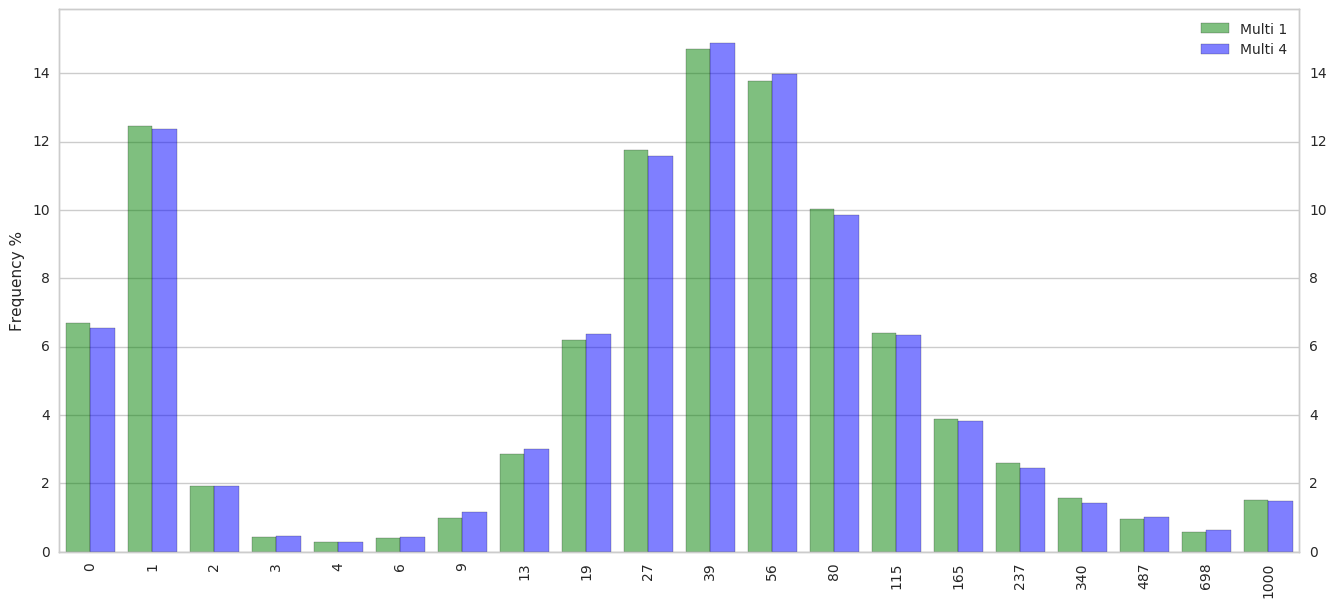

---
#### FX_TAB_SWITCH_TOTAL_MS (parent) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.877</b>.</span>
            

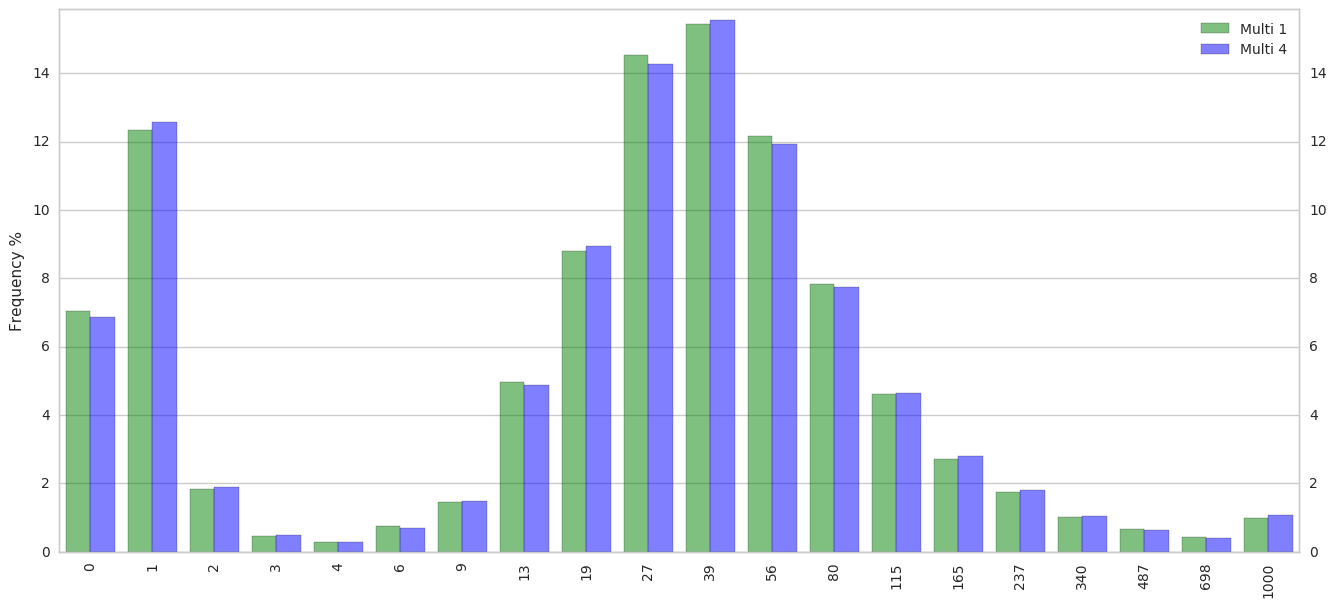

---
#### FX_TAB_SWITCH_TOTAL_MS (parent) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.535</b>.</span>
            

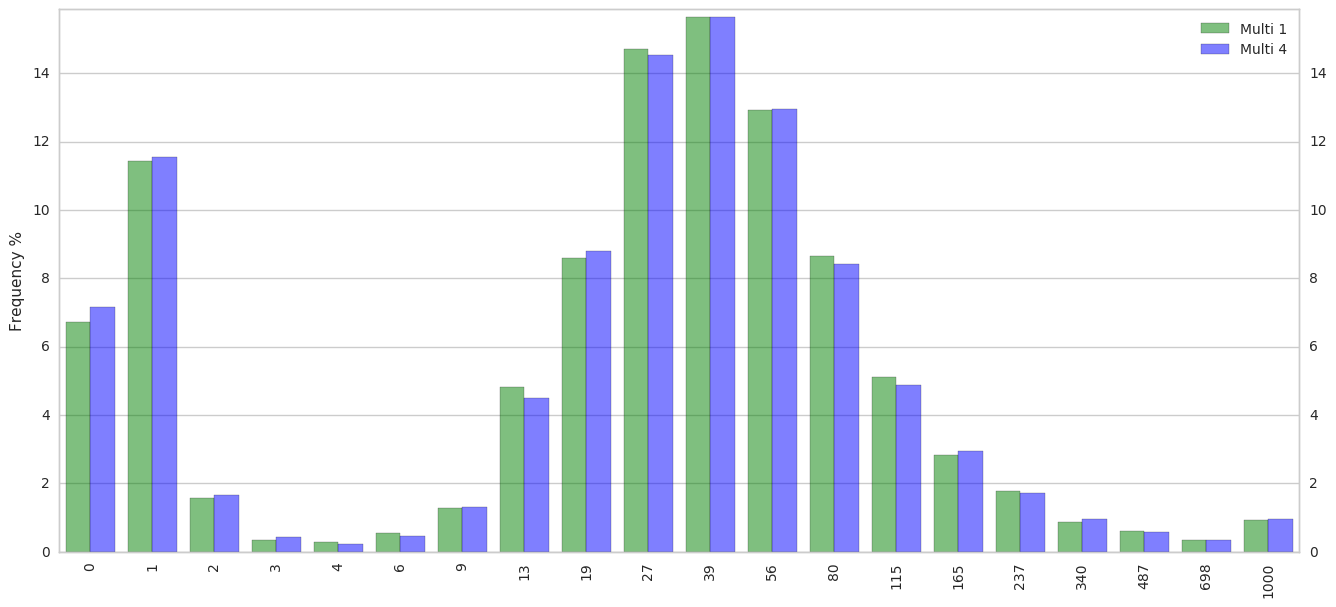

# Darwin

Comparison for FX_TAB_SWITCH_TOTAL_MS:

1587 (40.1%) multi_1 profiles on Darwin have the parent histogram.
1593 (40.2%) multi_4 profiles on Darwin have the parent histogram.
88 (36.7%) webext_multi_1 profiles on Darwin have the parent histogram.
84 (35.1%) webextx_multi_4 profiles on Darwin have the parent histogram.
167 (36.8%) mpc_multi_1 profiles on Darwin have the parent histogram.
157 (37.5%) mpc_multi_4 profiles on Darwin have the parent histogram.
No multi_1 profiles on Darwin have the child histogram.
No multi_4 profiles on Darwin have the child histogram.
No webext_multi_1 profiles on Darwin have the child histogram.
No webextx_multi_4 profiles on Darwin have the child histogram.
No mpc_multi_1 profiles on Darwin have the child histogram.
No mpc_multi_4 profiles on Darwin have the child histogram.


---
#### FX_TAB_SWITCH_TOTAL_MS (parent) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.336</b>.</span>
            

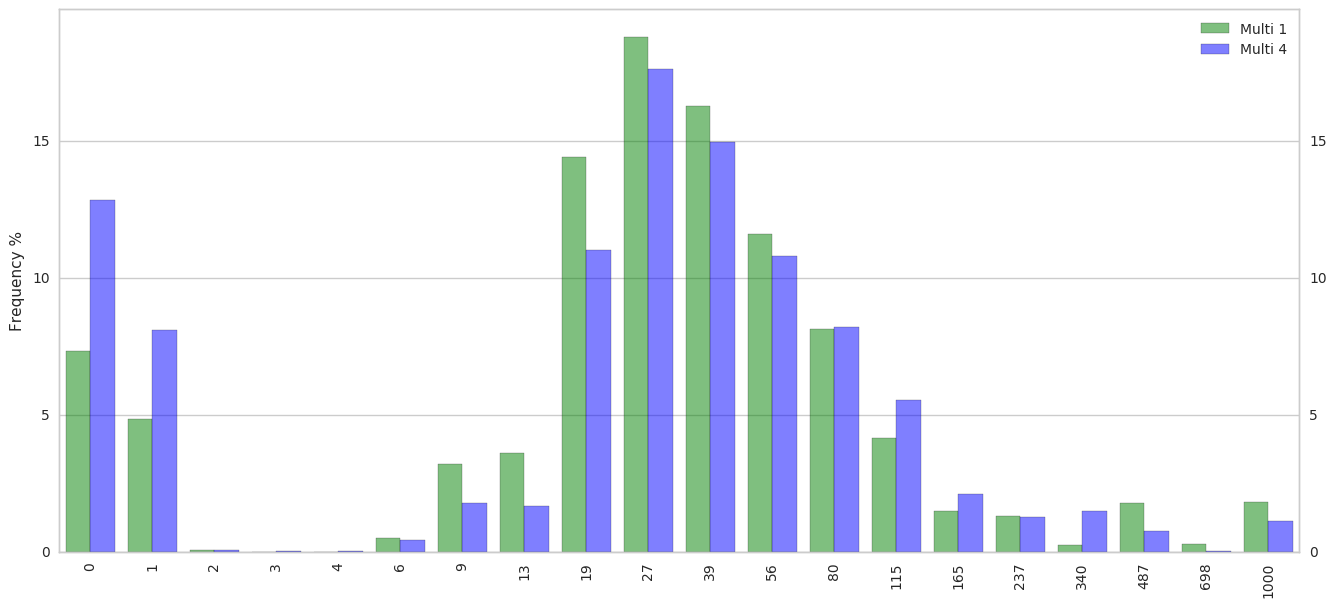

---
#### FX_TAB_SWITCH_TOTAL_MS (parent) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.934</b>.</span>
            

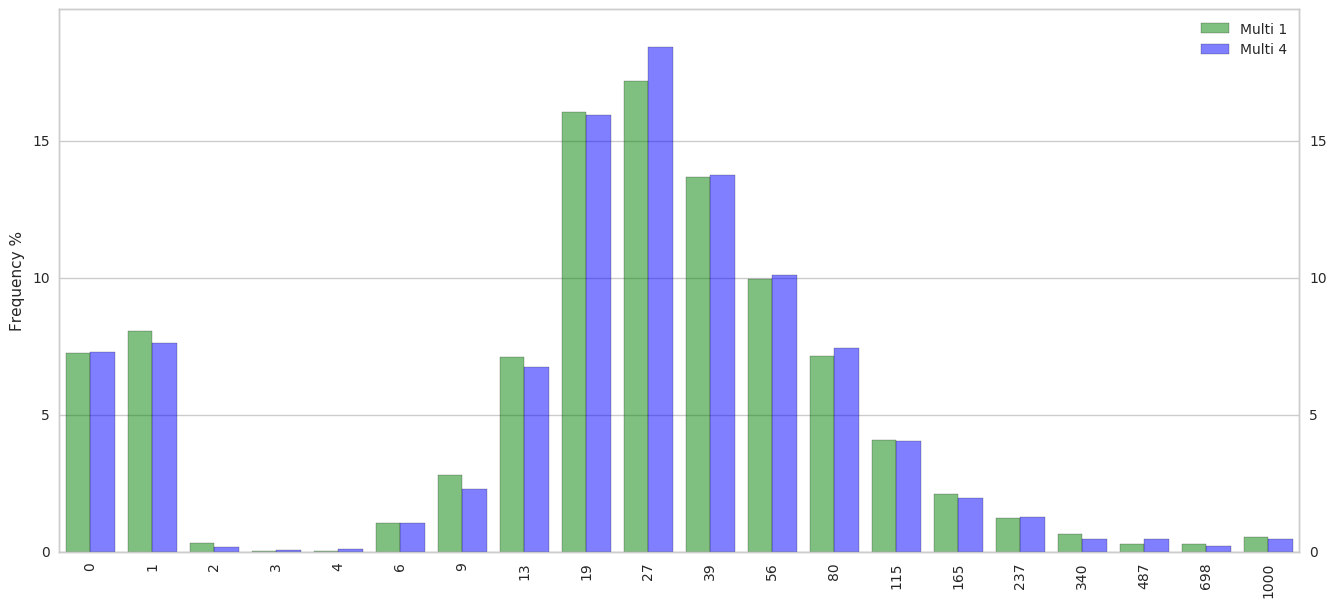

---
#### FX_TAB_SWITCH_TOTAL_MS (parent) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.820</b>.</span>
            

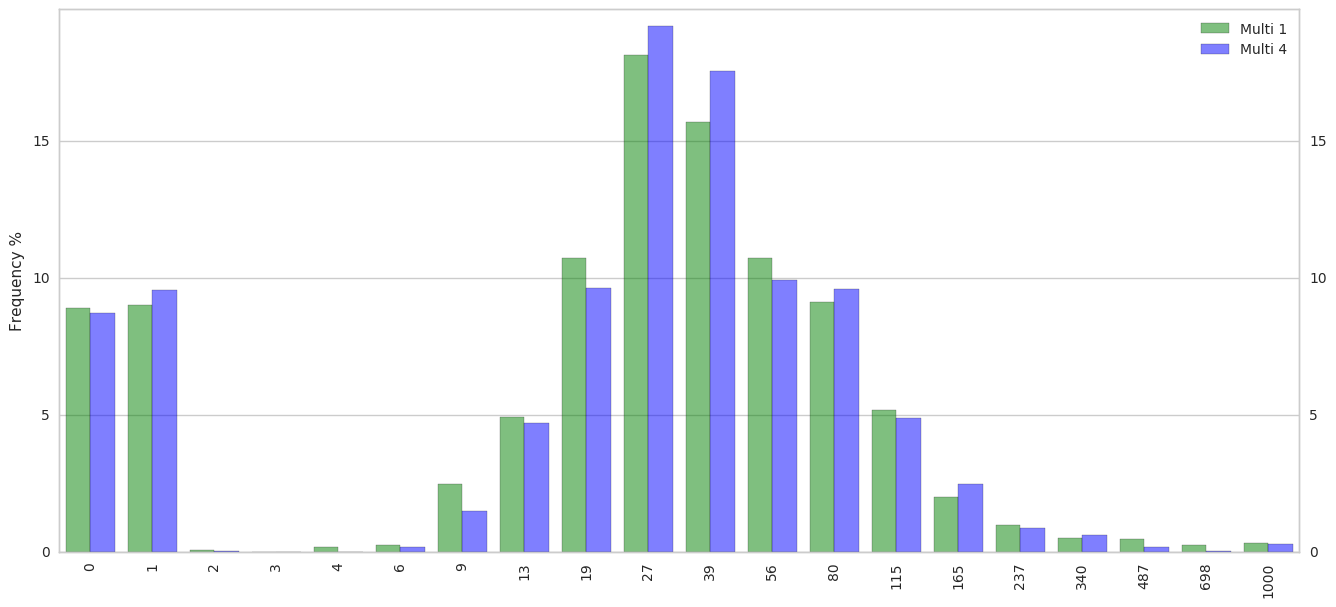

## 4+ Tabs

# Windows_NT

Comparison for FX_TAB_SWITCH_TOTAL_MS:

6611 (16.2%) multi_1 profiles on Windows_NT have the parent histogram.
6641 (16.3%) multi_4 profiles on Windows_NT have the parent histogram.
9078 (22.0%) webext_multi_1 profiles on Windows_NT have the parent histogram.
9121 (22.3%) webextx_multi_4 profiles on Windows_NT have the parent histogram.
7066 (23.9%) mpc_multi_1 profiles on Windows_NT have the parent histogram.
6979 (23.5%) mpc_multi_4 profiles on Windows_NT have the parent histogram.
No multi_1 profiles on Windows_NT have the child histogram.
No multi_4 profiles on Windows_NT have the child histogram.
No webext_multi_1 profiles on Windows_NT have the child histogram.
No webextx_multi_4 profiles on Windows_NT have the child histogram.
No mpc_multi_1 profiles on Windows_NT have the child histogram.
No mpc_multi_4 profiles on Windows_NT have the child histogram.


---
#### FX_TAB_SWITCH_TOTAL_MS (parent) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.629</b>.</span>
            

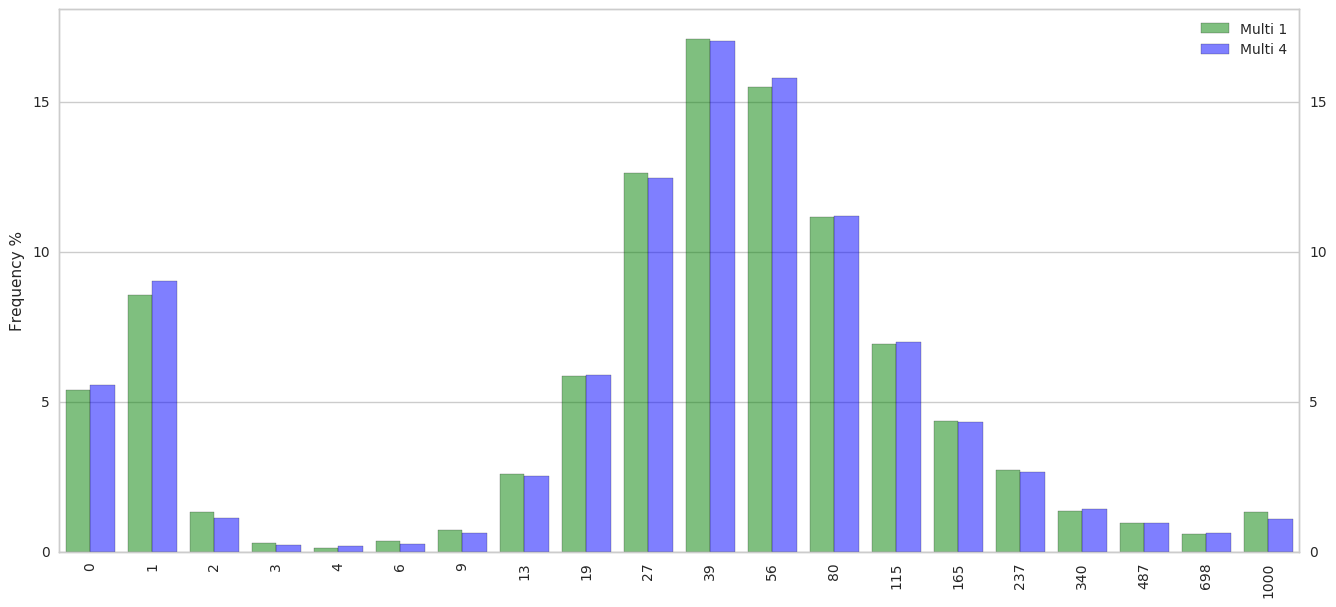

---
#### FX_TAB_SWITCH_TOTAL_MS (parent) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:red"><b>0.006</b>.</span>
            

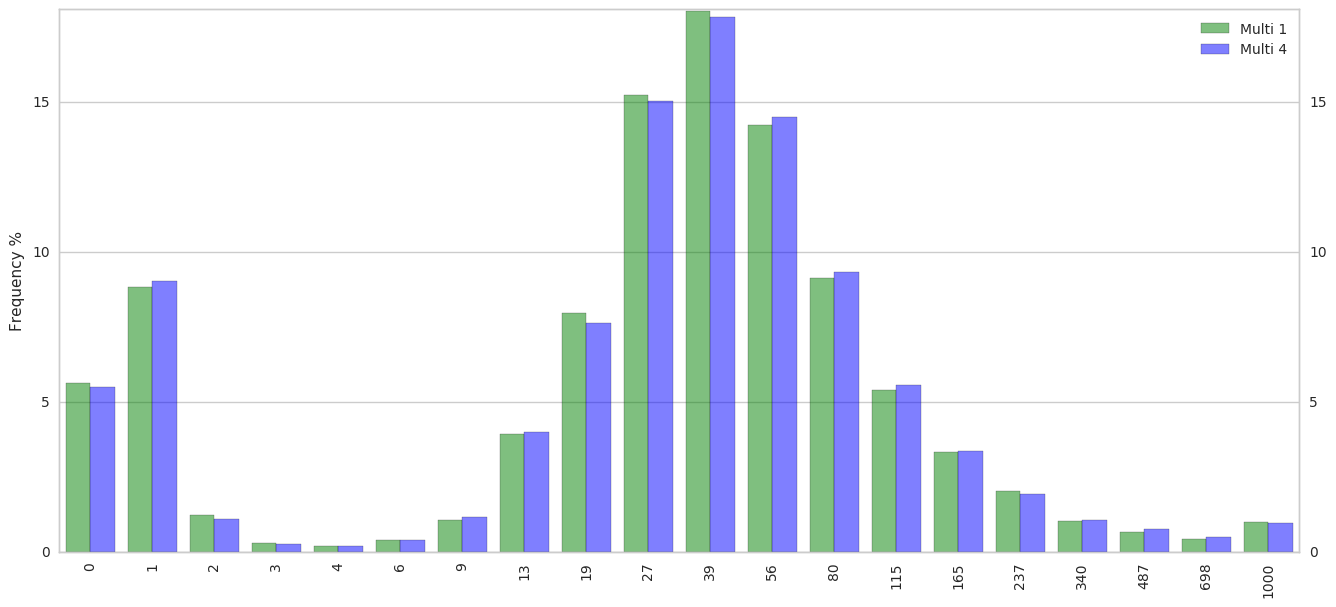

---
#### FX_TAB_SWITCH_TOTAL_MS (parent) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.166</b>.</span>
            

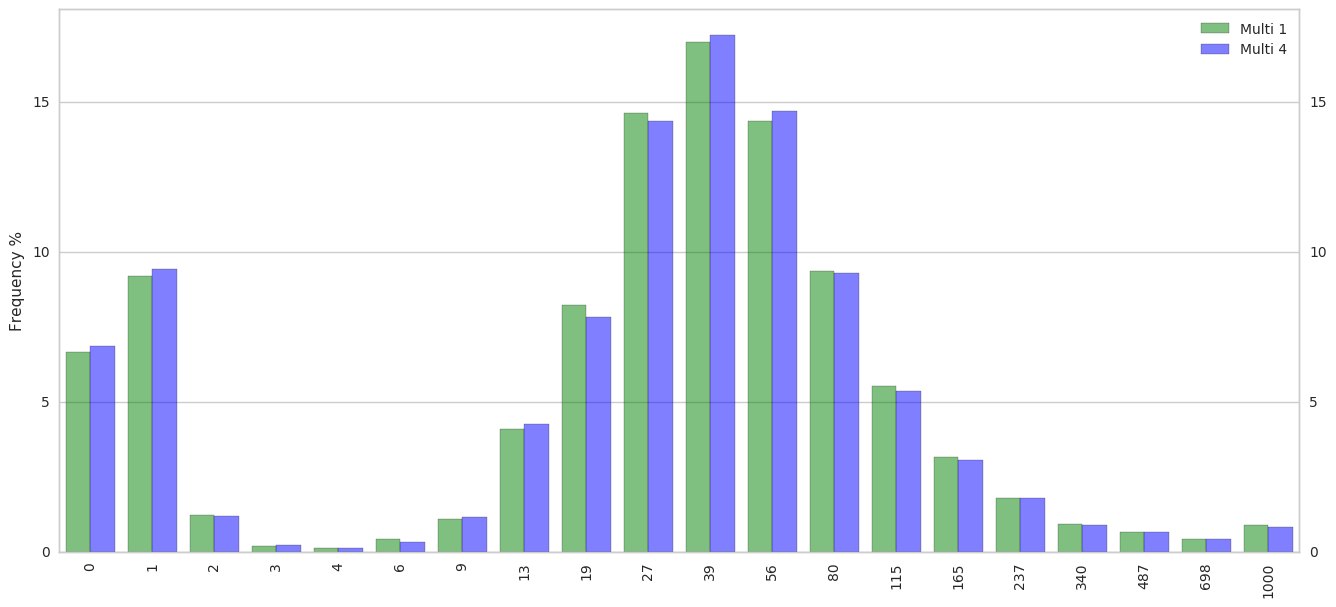

# Darwin

Comparison for FX_TAB_SWITCH_TOTAL_MS:

1022 (25.8%) multi_1 profiles on Darwin have the parent histogram.
1028 (25.9%) multi_4 profiles on Darwin have the parent histogram.
78 (32.5%) webext_multi_1 profiles on Darwin have the parent histogram.
87 (36.4%) webextx_multi_4 profiles on Darwin have the parent histogram.
158 (34.8%) mpc_multi_1 profiles on Darwin have the parent histogram.
146 (34.8%) mpc_multi_4 profiles on Darwin have the parent histogram.
No multi_1 profiles on Darwin have the child histogram.
No multi_4 profiles on Darwin have the child histogram.
No webext_multi_1 profiles on Darwin have the child histogram.
No webextx_multi_4 profiles on Darwin have the child histogram.
No mpc_multi_1 profiles on Darwin have the child histogram.
No mpc_multi_4 profiles on Darwin have the child histogram.


---
#### FX_TAB_SWITCH_TOTAL_MS (parent) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.633</b>.</span>
            

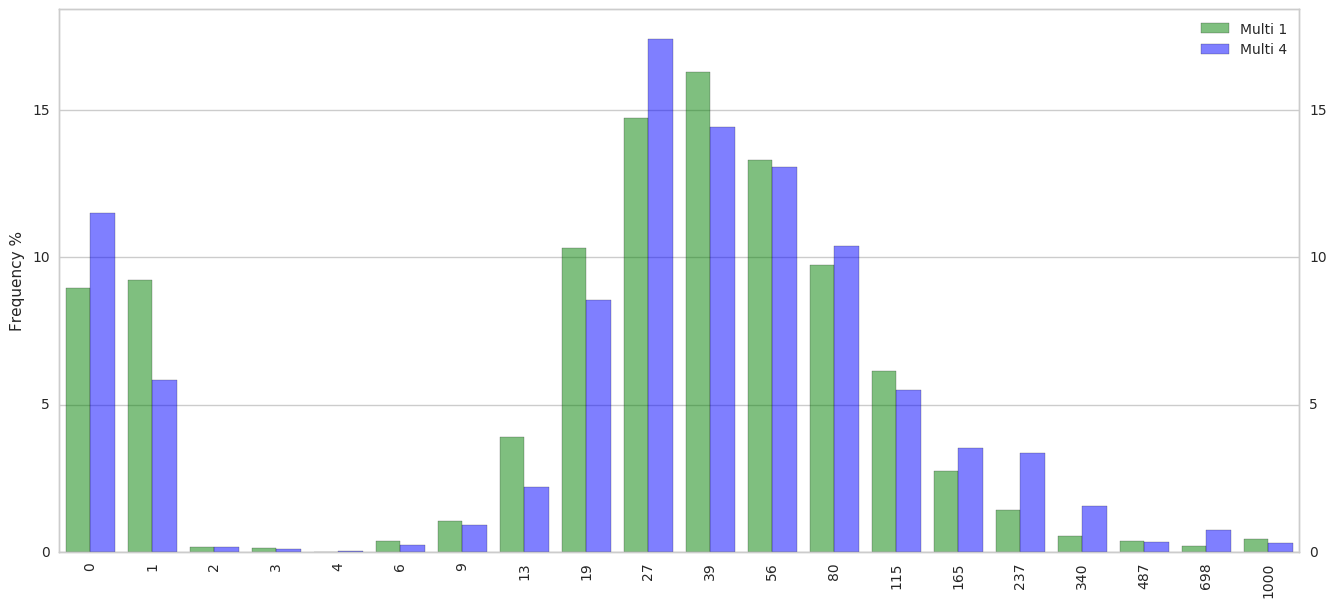

---
#### FX_TAB_SWITCH_TOTAL_MS (parent) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.676</b>.</span>
            

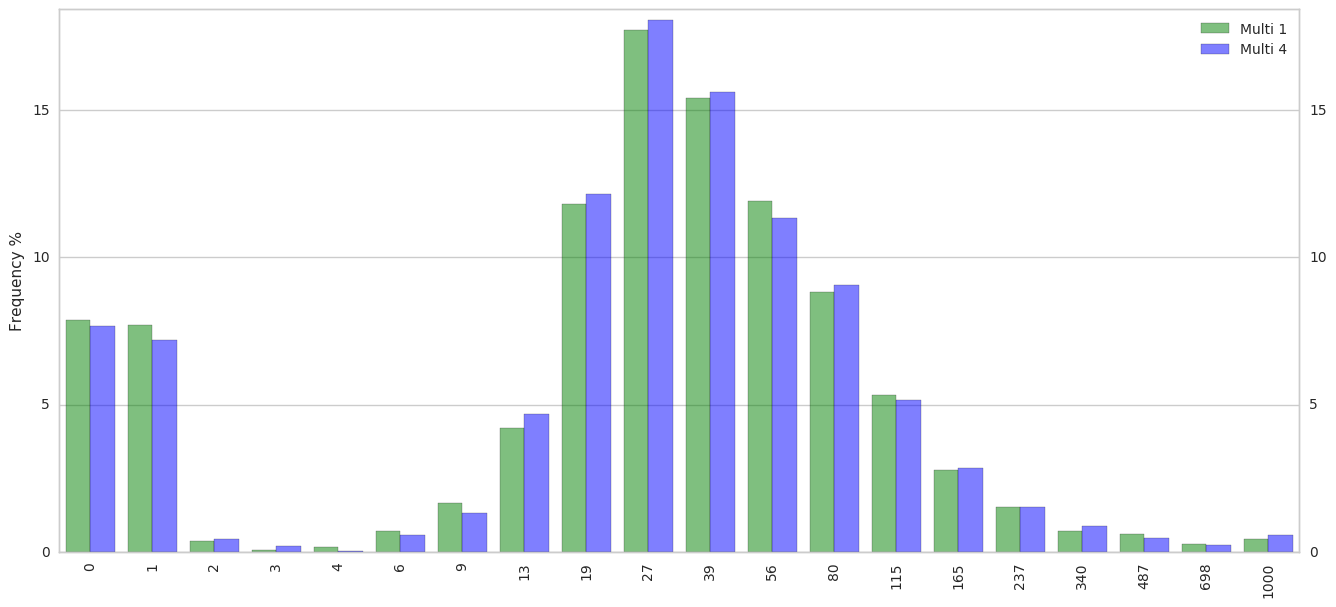

---
#### FX_TAB_SWITCH_TOTAL_MS (parent) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.326</b>.</span>
            

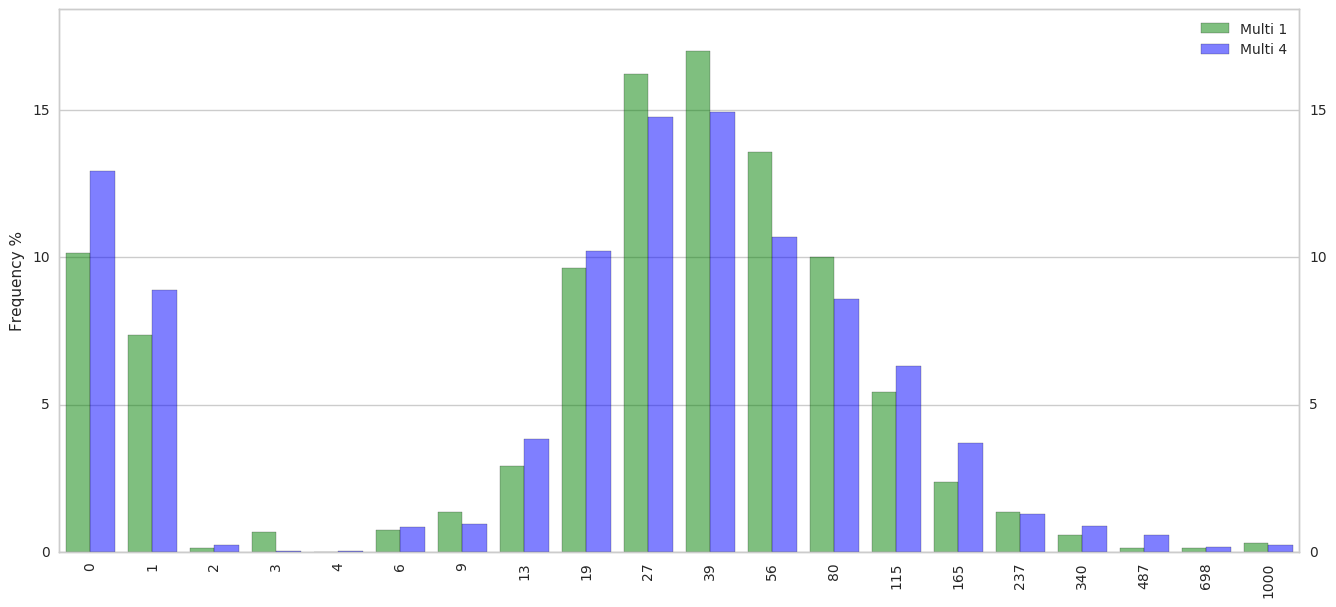

In [117]:
results.extend(compare_tab_groups(t3, t4, "payload/histograms/FX_TAB_SWITCH_TOTAL_MS"))

### FX_TAB_SWITCH_UPDATE_MS 

## 1-3 Tabs

# Windows_NT

Comparison for FX_TAB_SWITCH_UPDATE_MS:

14764 (36.3%) multi_1 profiles on Windows_NT have the parent histogram.
15024 (36.9%) multi_4 profiles on Windows_NT have the parent histogram.
15470 (37.4%) webext_multi_1 profiles on Windows_NT have the parent histogram.
15255 (37.4%) webextx_multi_4 profiles on Windows_NT have the parent histogram.
11383 (38.4%) mpc_multi_1 profiles on Windows_NT have the parent histogram.
11211 (37.8%) mpc_multi_4 profiles on Windows_NT have the parent histogram.
No multi_1 profiles on Windows_NT have the child histogram.
No multi_4 profiles on Windows_NT have the child histogram.
No webext_multi_1 profiles on Windows_NT have the child histogram.
No webextx_multi_4 profiles on Windows_NT have the child histogram.
No mpc_multi_1 profiles on Windows_NT have the child histogram.
No mpc_multi_4 profiles on Windows_NT have the child histogram.


---
#### FX_TAB_SWITCH_UPDATE_MS (parent) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:red"><b>0.018</b>.</span>
            

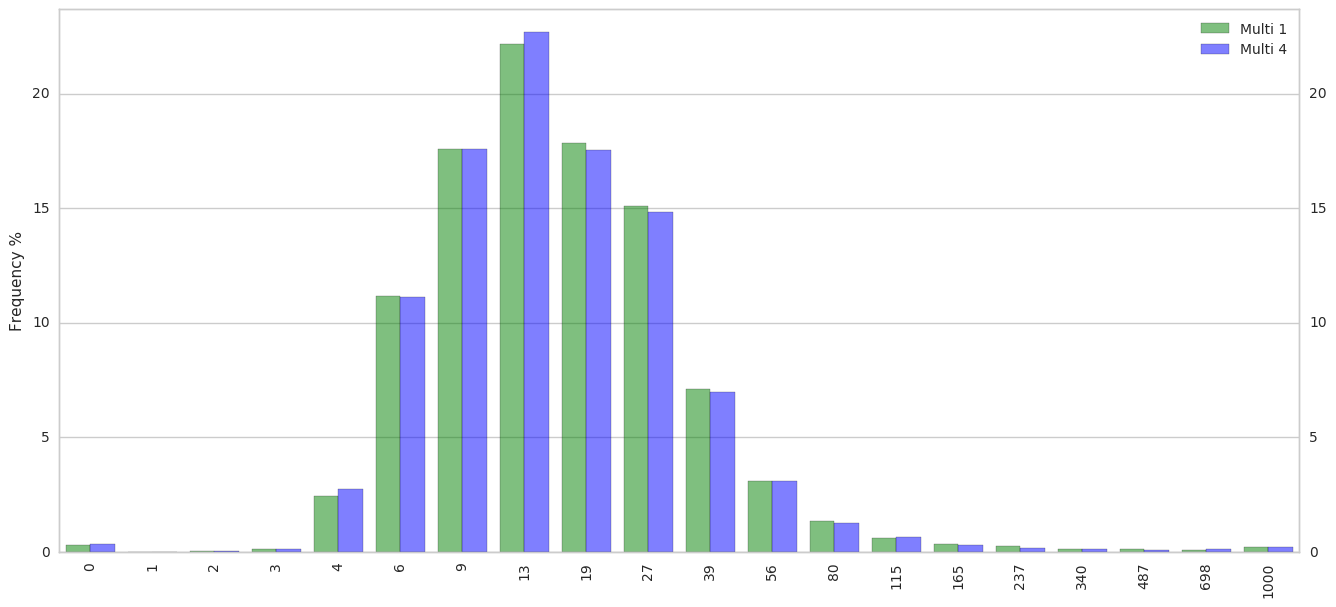

---
#### FX_TAB_SWITCH_UPDATE_MS (parent) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.629</b>.</span>
            

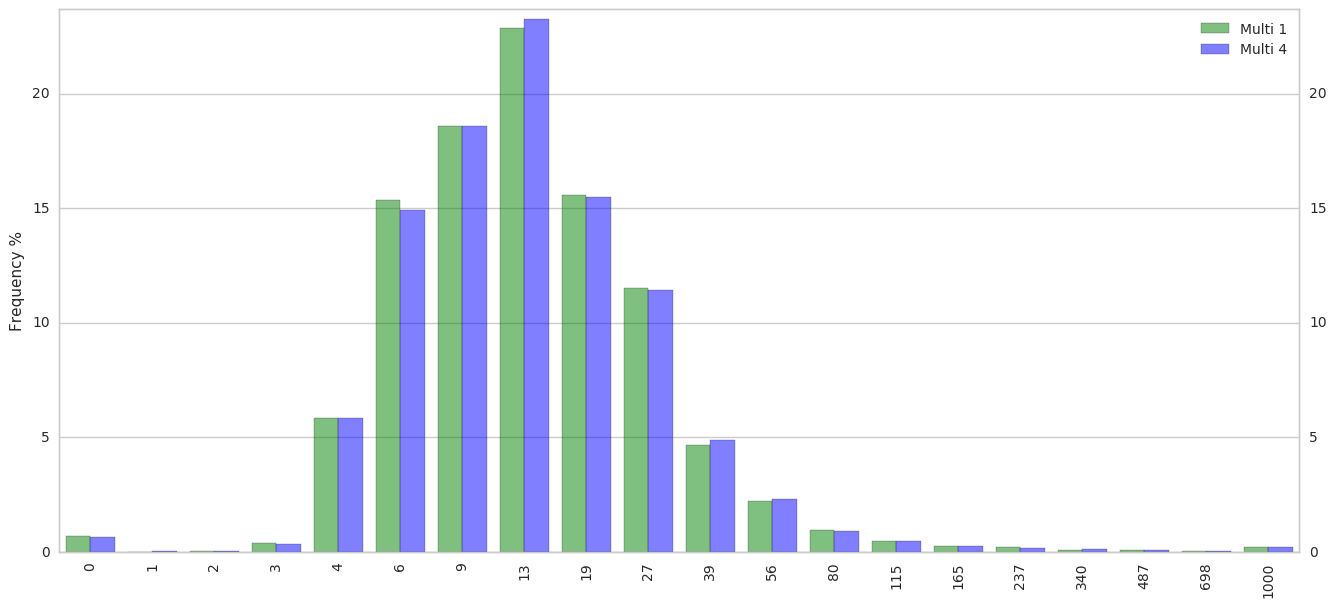

---
#### FX_TAB_SWITCH_UPDATE_MS (parent) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.447</b>.</span>
            

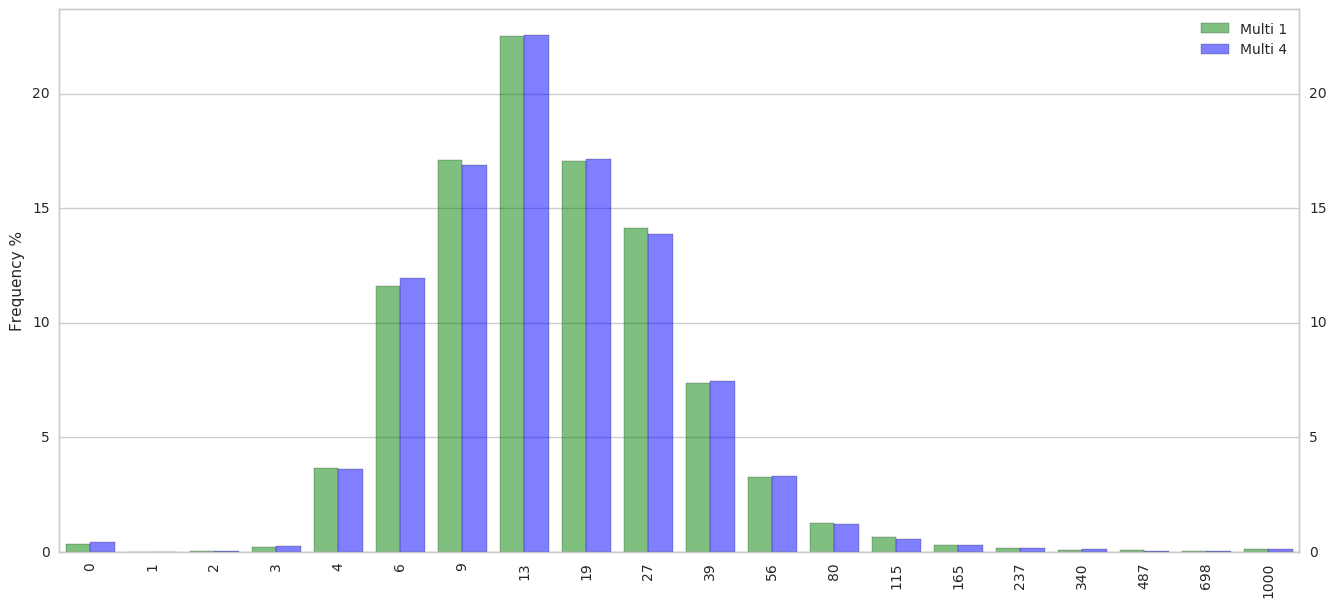

# Darwin

Comparison for FX_TAB_SWITCH_UPDATE_MS:

1592 (40.2%) multi_1 profiles on Darwin have the parent histogram.
1595 (40.3%) multi_4 profiles on Darwin have the parent histogram.
88 (36.7%) webext_multi_1 profiles on Darwin have the parent histogram.
84 (35.1%) webextx_multi_4 profiles on Darwin have the parent histogram.
167 (36.8%) mpc_multi_1 profiles on Darwin have the parent histogram.
157 (37.5%) mpc_multi_4 profiles on Darwin have the parent histogram.
No multi_1 profiles on Darwin have the child histogram.
No multi_4 profiles on Darwin have the child histogram.
No webext_multi_1 profiles on Darwin have the child histogram.
No webextx_multi_4 profiles on Darwin have the child histogram.
No mpc_multi_1 profiles on Darwin have the child histogram.
No mpc_multi_4 profiles on Darwin have the child histogram.


---
#### FX_TAB_SWITCH_UPDATE_MS (parent) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.111</b>.</span>
            

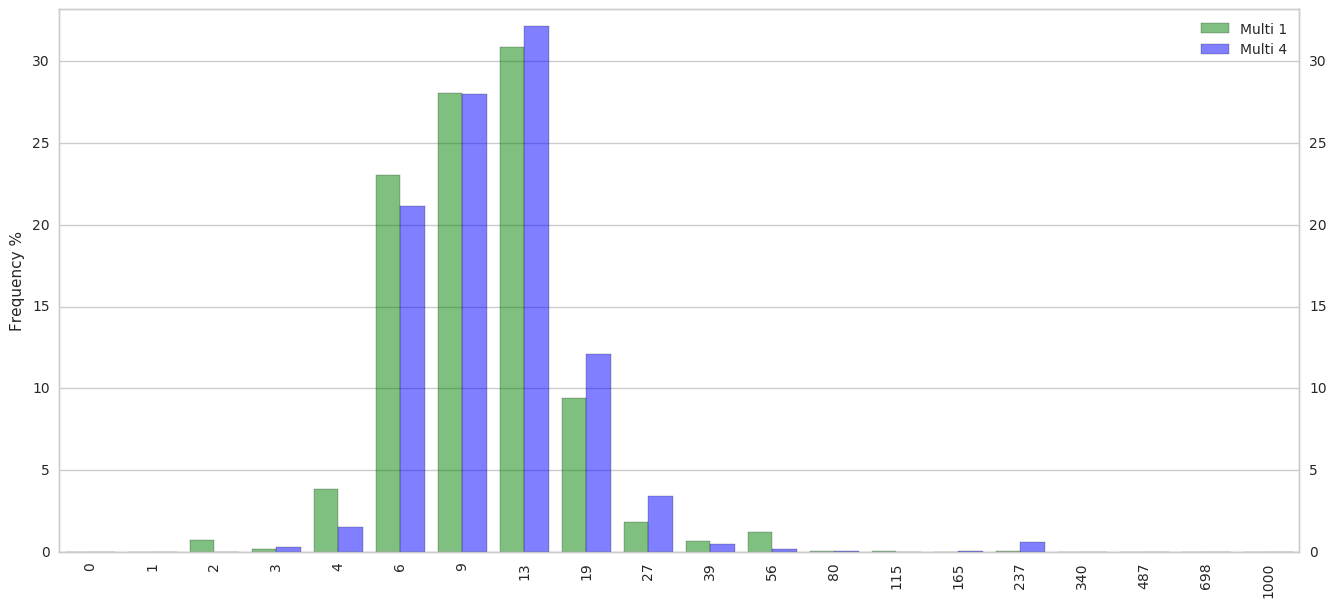

---
#### FX_TAB_SWITCH_UPDATE_MS (parent) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.432</b>.</span>
            

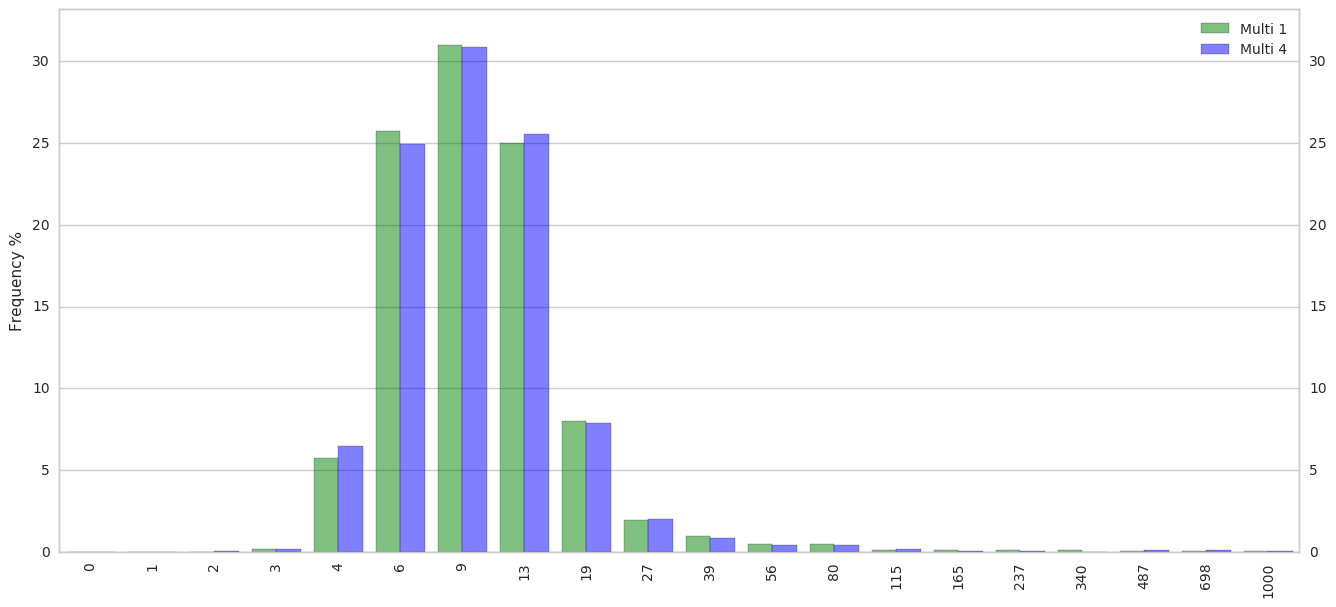

---
#### FX_TAB_SWITCH_UPDATE_MS (parent) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.172</b>.</span>
            

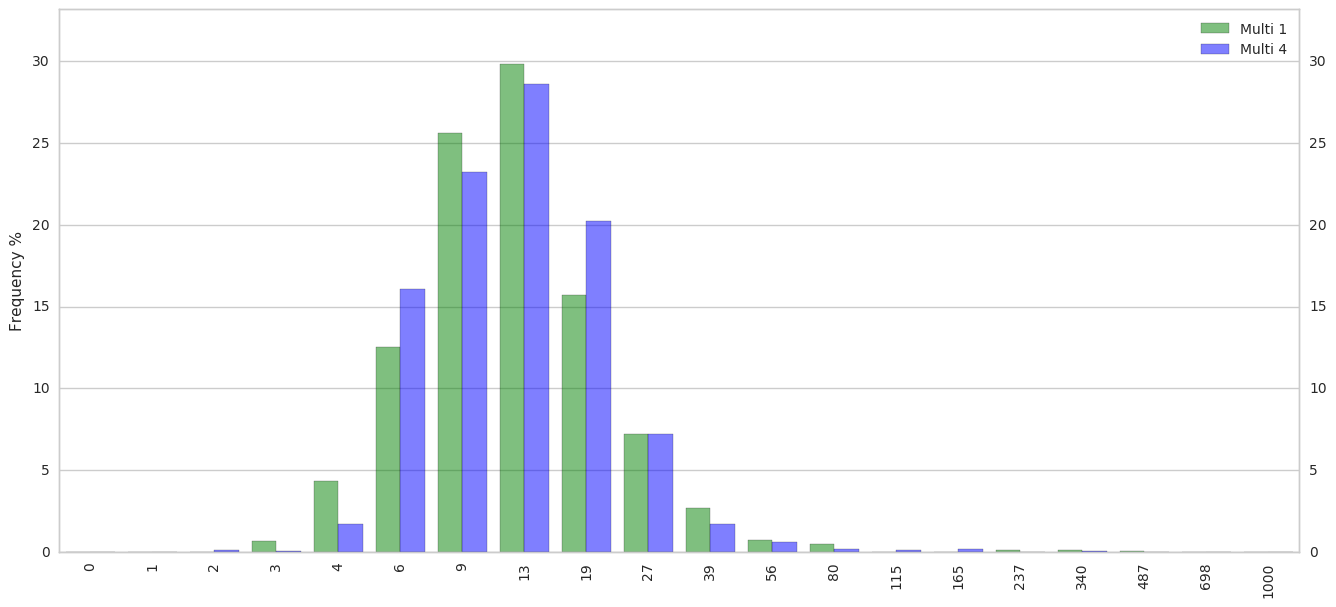

## 4+ Tabs

# Windows_NT

Comparison for FX_TAB_SWITCH_UPDATE_MS:

6617 (16.3%) multi_1 profiles on Windows_NT have the parent histogram.
6650 (16.3%) multi_4 profiles on Windows_NT have the parent histogram.
9088 (22.0%) webext_multi_1 profiles on Windows_NT have the parent histogram.
9133 (22.4%) webextx_multi_4 profiles on Windows_NT have the parent histogram.
7070 (23.9%) mpc_multi_1 profiles on Windows_NT have the parent histogram.
6984 (23.5%) mpc_multi_4 profiles on Windows_NT have the parent histogram.
No multi_1 profiles on Windows_NT have the child histogram.
No multi_4 profiles on Windows_NT have the child histogram.
No webext_multi_1 profiles on Windows_NT have the child histogram.
No webextx_multi_4 profiles on Windows_NT have the child histogram.
No mpc_multi_1 profiles on Windows_NT have the child histogram.
No mpc_multi_4 profiles on Windows_NT have the child histogram.


---
#### FX_TAB_SWITCH_UPDATE_MS (parent) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.645</b>.</span>
            

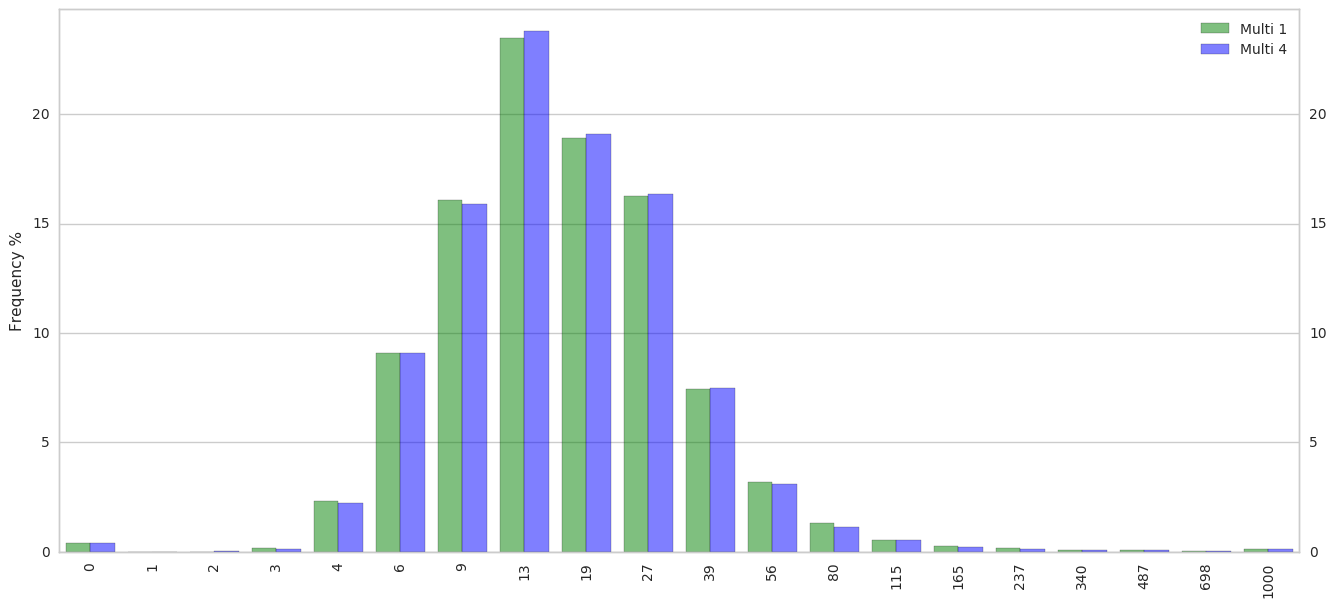

---
#### FX_TAB_SWITCH_UPDATE_MS (parent) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:red"><b>0.021</b>.</span>
            

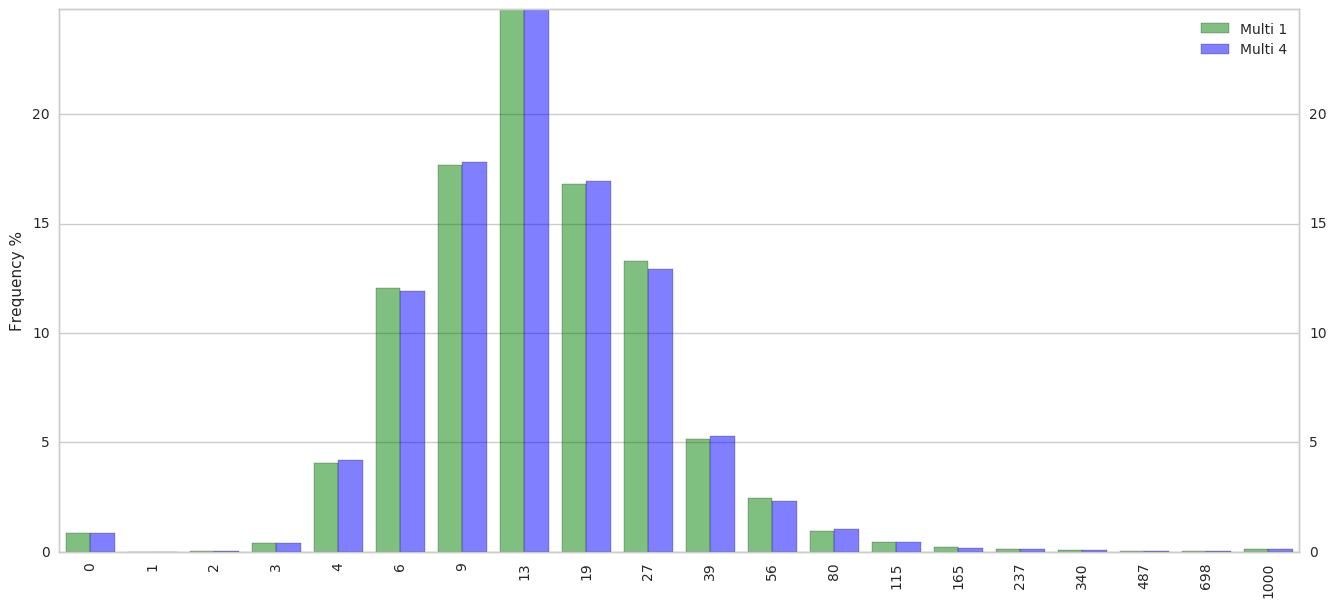

---
#### FX_TAB_SWITCH_UPDATE_MS (parent) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:red"><b>0.037</b>.</span>
            

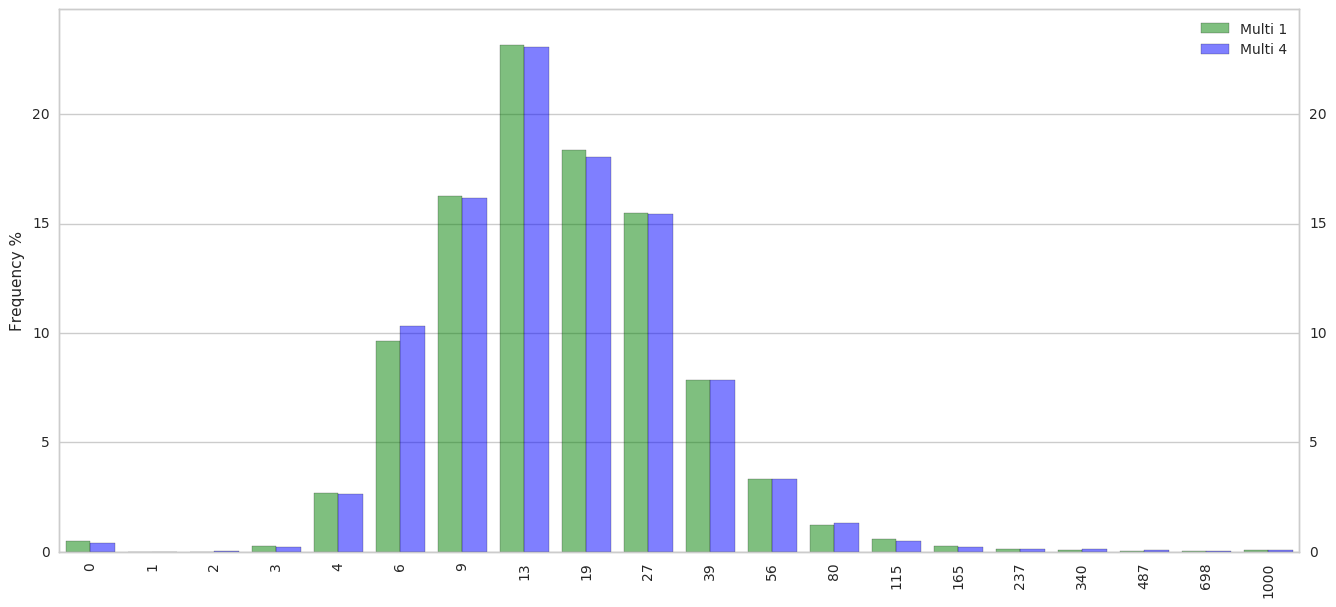

# Darwin

Comparison for FX_TAB_SWITCH_UPDATE_MS:

1024 (25.9%) multi_1 profiles on Darwin have the parent histogram.
1028 (25.9%) multi_4 profiles on Darwin have the parent histogram.
78 (32.5%) webext_multi_1 profiles on Darwin have the parent histogram.
87 (36.4%) webextx_multi_4 profiles on Darwin have the parent histogram.
158 (34.8%) mpc_multi_1 profiles on Darwin have the parent histogram.
146 (34.8%) mpc_multi_4 profiles on Darwin have the parent histogram.
No multi_1 profiles on Darwin have the child histogram.
No multi_4 profiles on Darwin have the child histogram.
No webext_multi_1 profiles on Darwin have the child histogram.
No webextx_multi_4 profiles on Darwin have the child histogram.
No mpc_multi_1 profiles on Darwin have the child histogram.
No mpc_multi_4 profiles on Darwin have the child histogram.


---
#### FX_TAB_SWITCH_UPDATE_MS (parent) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.342</b>.</span>
            

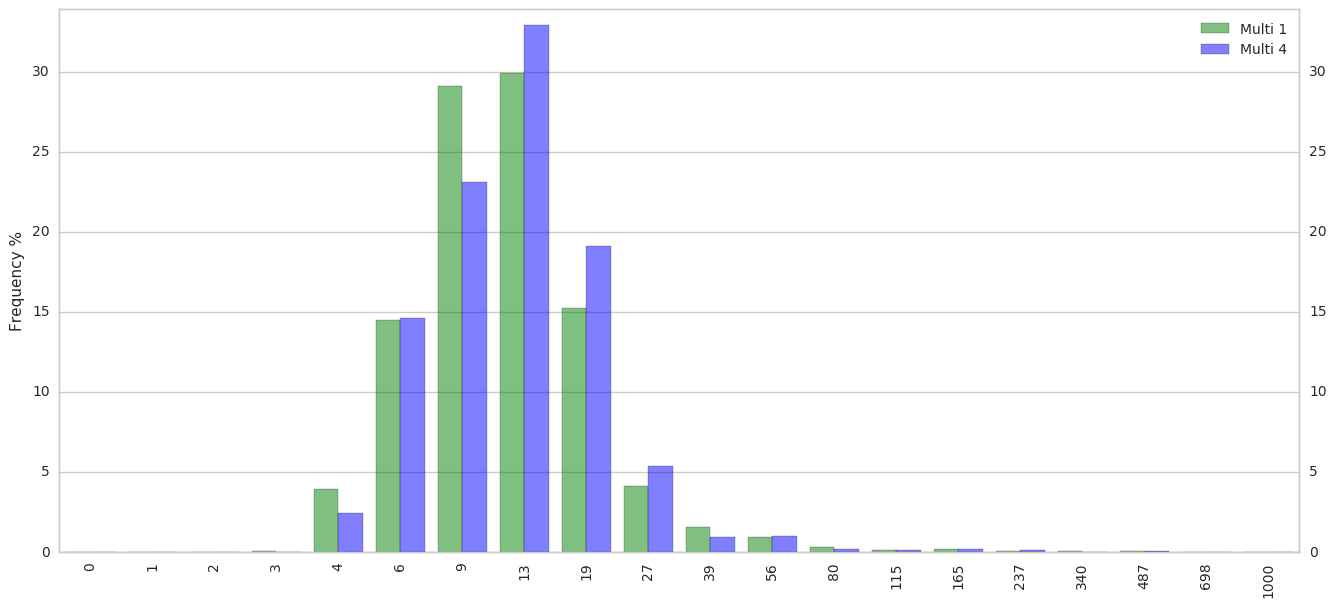

---
#### FX_TAB_SWITCH_UPDATE_MS (parent) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.852</b>.</span>
            

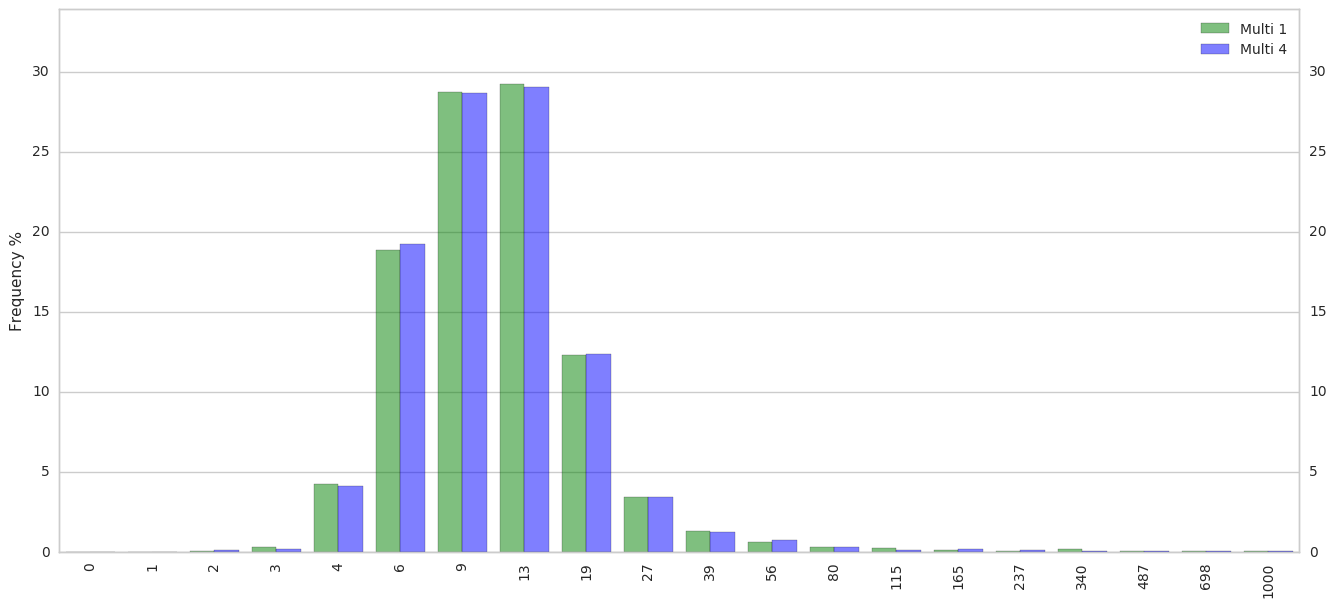

---
#### FX_TAB_SWITCH_UPDATE_MS (parent) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.574</b>.</span>
            

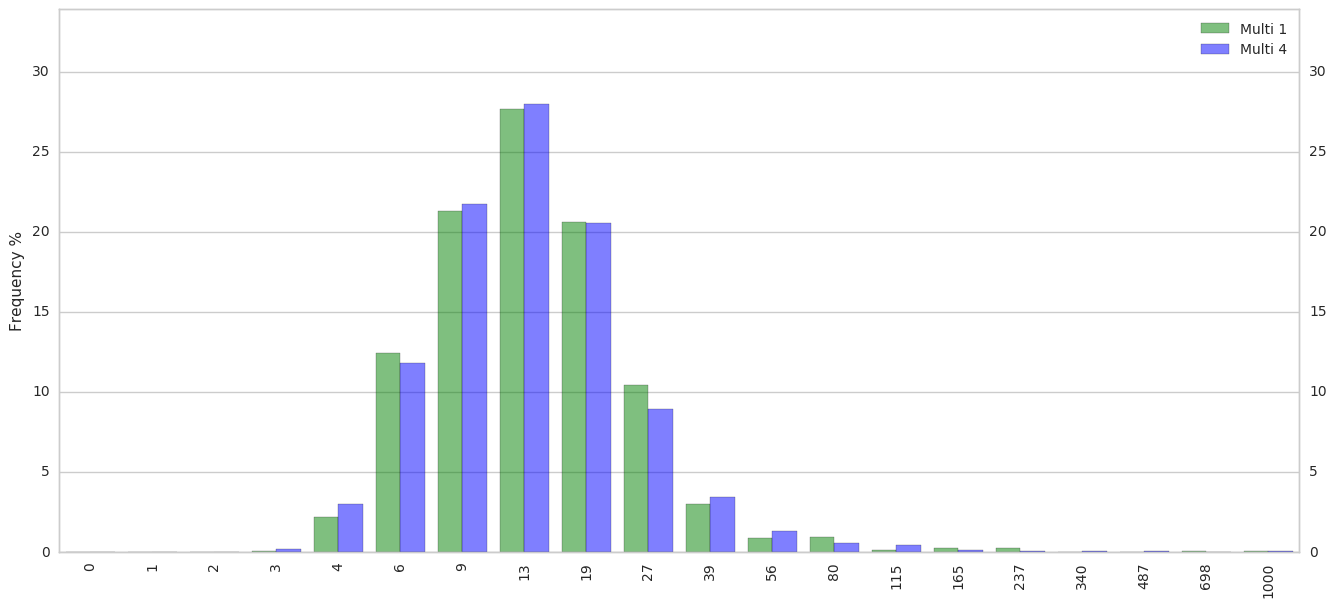

In [118]:
results.extend(compare_tab_groups(t3, t4, "payload/histograms/FX_TAB_SWITCH_UPDATE_MS"))

### FX_TAB_SWITCH_SPINNER_VISIBLE_MS 

## 1-3 Tabs

# Windows_NT

Comparison for FX_TAB_SWITCH_SPINNER_VISIBLE_MS:

3438 (8.4%) multi_1 profiles on Windows_NT have the parent histogram.
3579 (8.8%) multi_4 profiles on Windows_NT have the parent histogram.
4248 (10.3%) webext_multi_1 profiles on Windows_NT have the parent histogram.
4267 (10.5%) webextx_multi_4 profiles on Windows_NT have the parent histogram.
2758 (9.3%) mpc_multi_1 profiles on Windows_NT have the parent histogram.
2737 (9.2%) mpc_multi_4 profiles on Windows_NT have the parent histogram.
No multi_1 profiles on Windows_NT have the child histogram.
No multi_4 profiles on Windows_NT have the child histogram.
No webext_multi_1 profiles on Windows_NT have the child histogram.
No webextx_multi_4 profiles on Windows_NT have the child histogram.
No mpc_multi_1 profiles on Windows_NT have the child histogram.
No mpc_multi_4 profiles on Windows_NT have the child histogram.


---
#### FX_TAB_SWITCH_SPINNER_VISIBLE_MS (parent) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:red"><b>0.014</b>.</span>
            

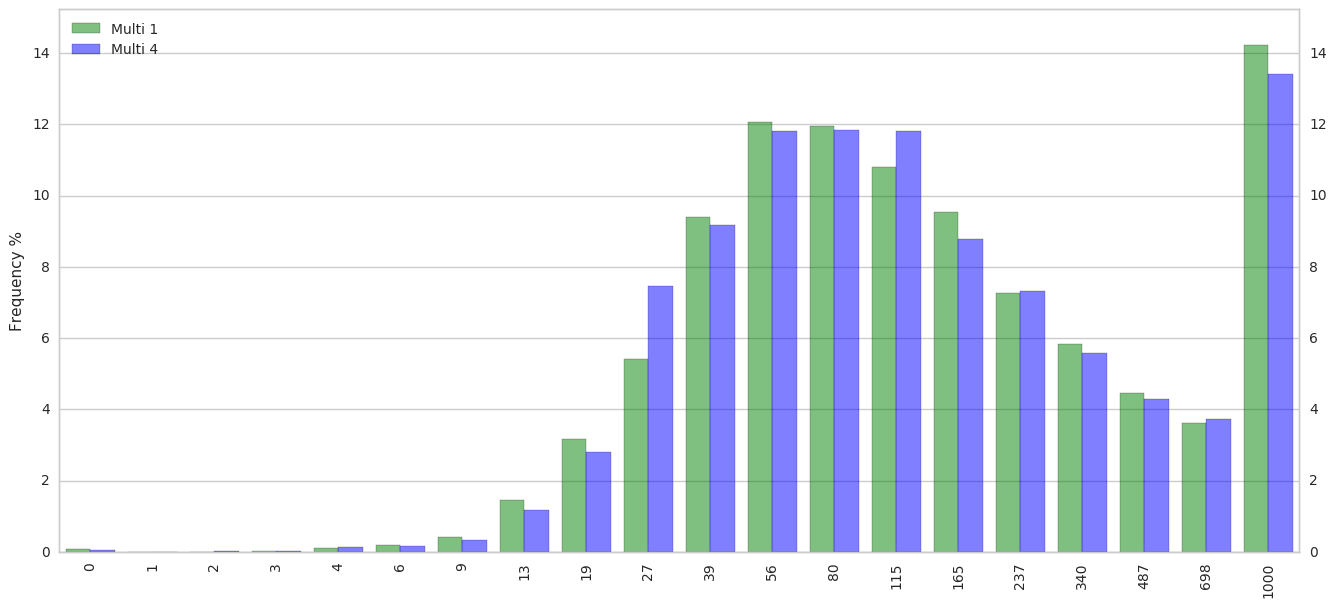

---
#### FX_TAB_SWITCH_SPINNER_VISIBLE_MS (parent) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.420</b>.</span>
            

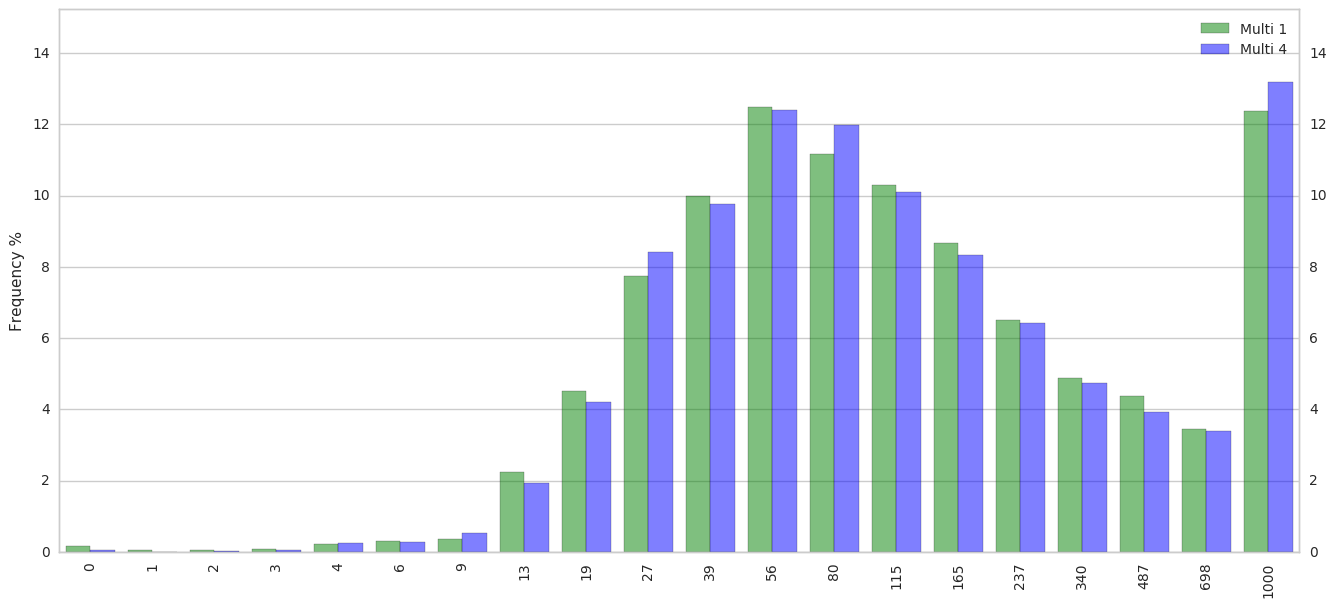

---
#### FX_TAB_SWITCH_SPINNER_VISIBLE_MS (parent) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.324</b>.</span>
            

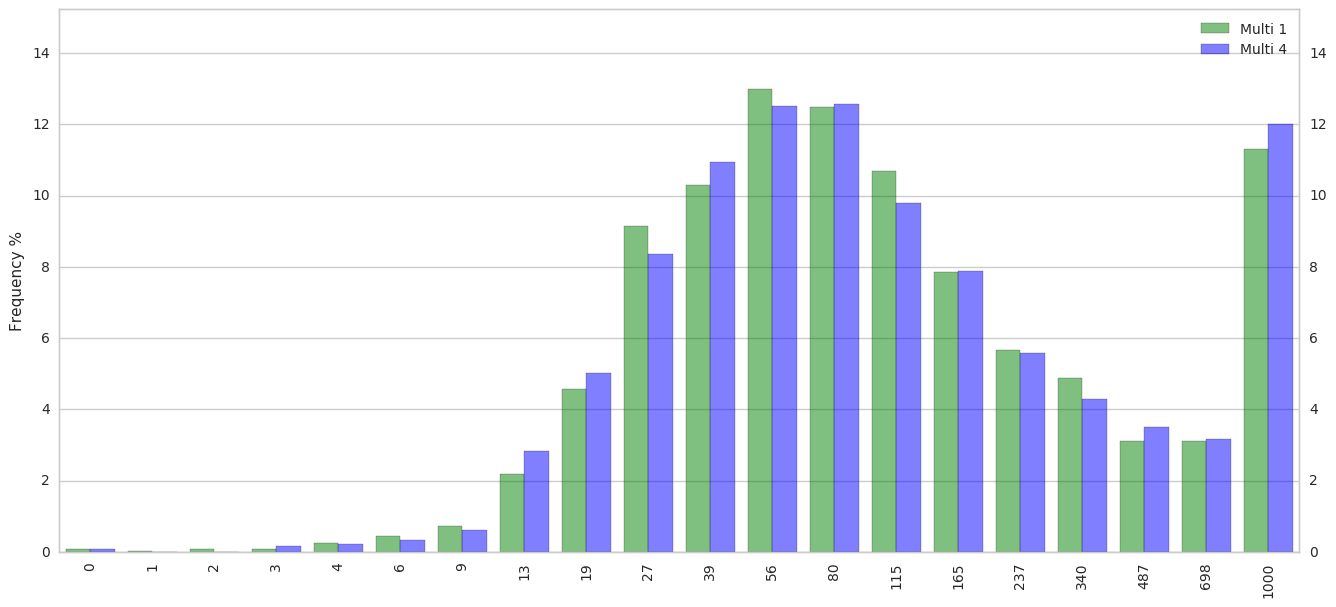

# Darwin

Comparison for FX_TAB_SWITCH_SPINNER_VISIBLE_MS:

360 (9.1%) multi_1 profiles on Darwin have the parent histogram.
371 (9.4%) multi_4 profiles on Darwin have the parent histogram.
25 (10.4%) webext_multi_1 profiles on Darwin have the parent histogram.
23 (9.6%) webextx_multi_4 profiles on Darwin have the parent histogram.
35 (7.7%) mpc_multi_1 profiles on Darwin have the parent histogram.
36 (8.6%) mpc_multi_4 profiles on Darwin have the parent histogram.
No multi_1 profiles on Darwin have the child histogram.
No multi_4 profiles on Darwin have the child histogram.
No webext_multi_1 profiles on Darwin have the child histogram.
No webextx_multi_4 profiles on Darwin have the child histogram.
No mpc_multi_1 profiles on Darwin have the child histogram.
No mpc_multi_4 profiles on Darwin have the child histogram.


---
#### FX_TAB_SWITCH_SPINNER_VISIBLE_MS (parent) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.730</b>.</span>
            

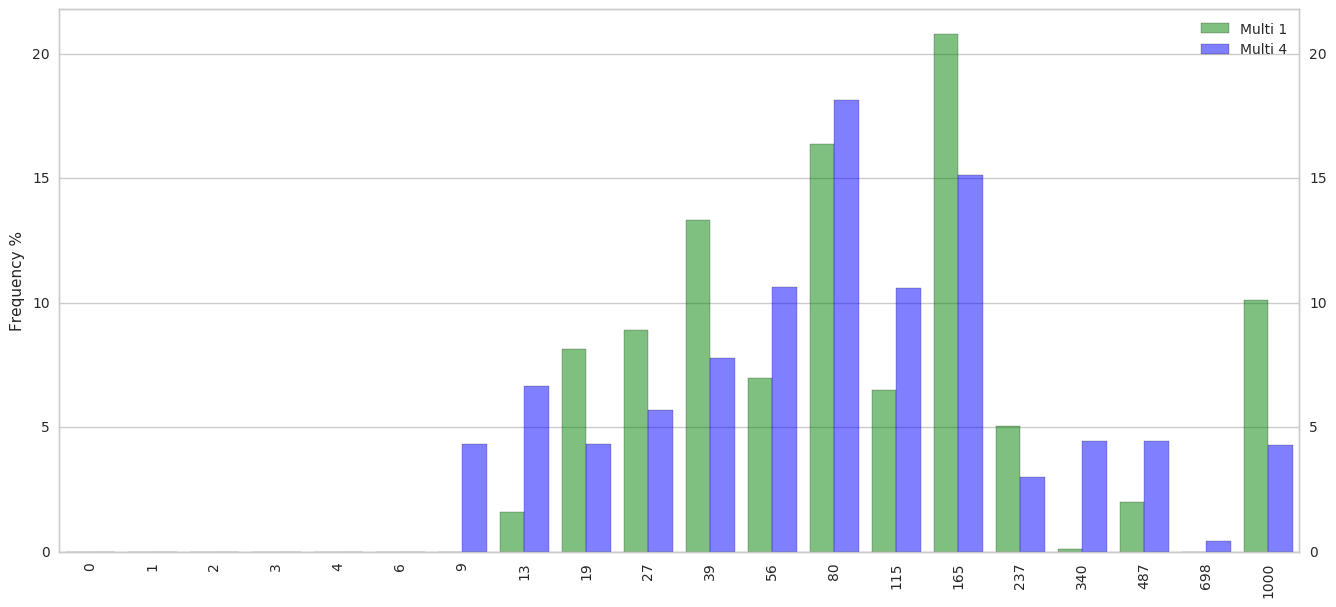

---
#### FX_TAB_SWITCH_SPINNER_VISIBLE_MS (parent) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.139</b>.</span>
            

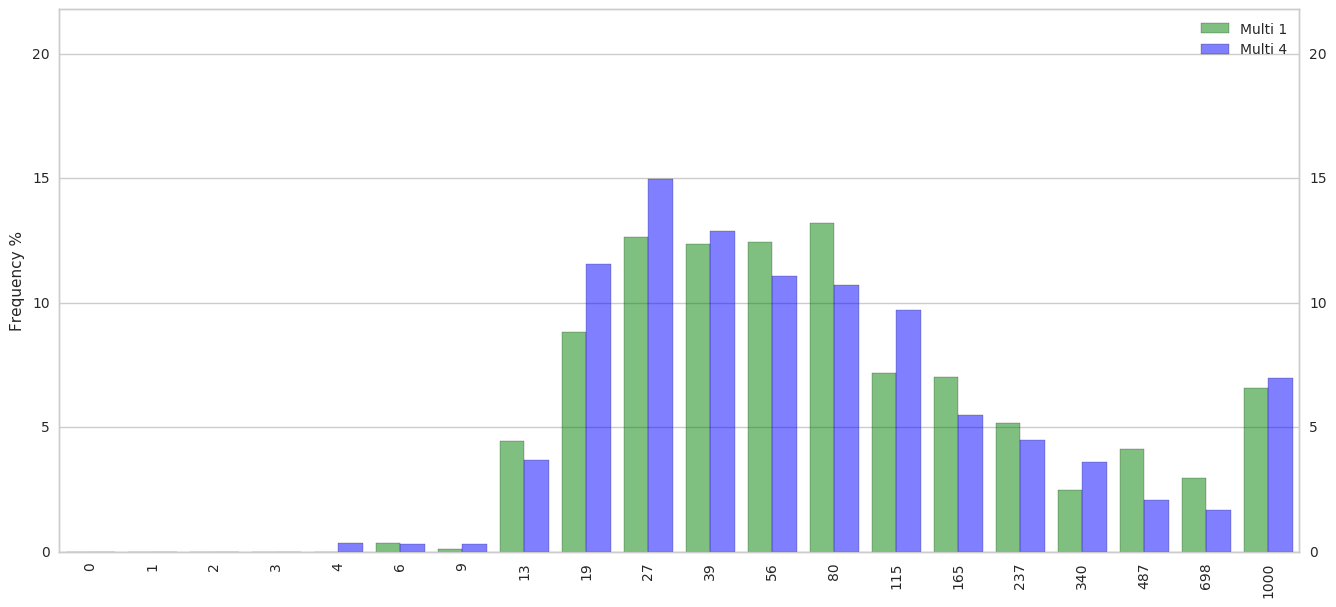

---
#### FX_TAB_SWITCH_SPINNER_VISIBLE_MS (parent) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.344</b>.</span>
            

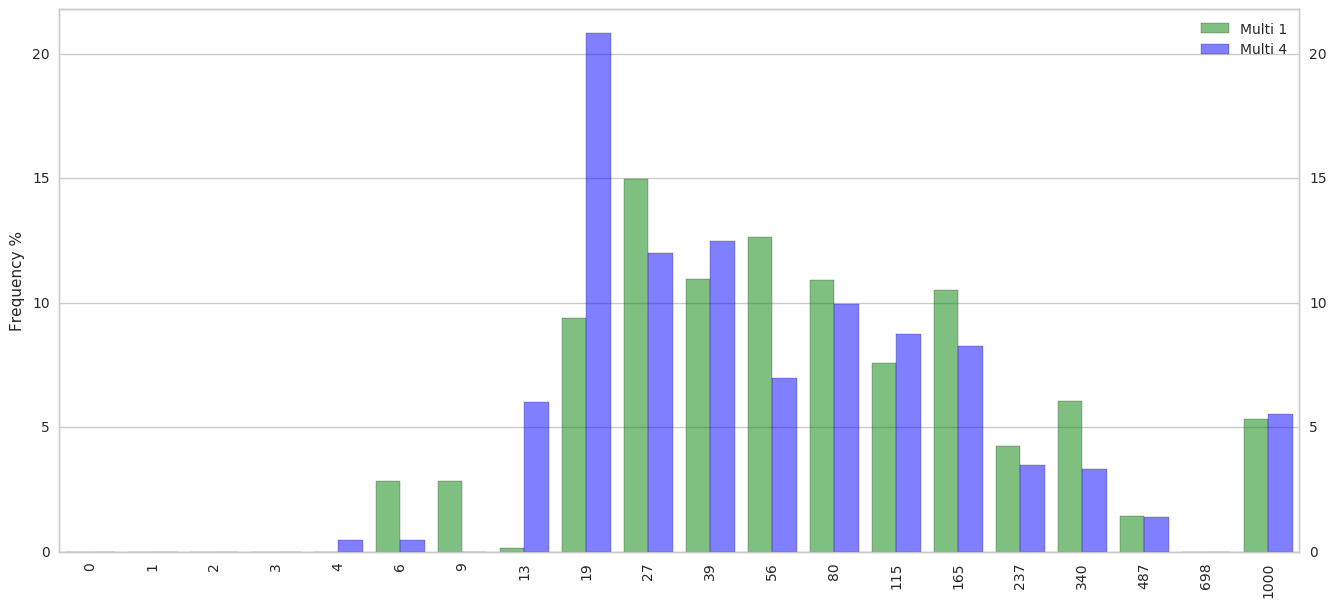

## 4+ Tabs

# Windows_NT

Comparison for FX_TAB_SWITCH_SPINNER_VISIBLE_MS:

2945 (7.2%) multi_1 profiles on Windows_NT have the parent histogram.
3117 (7.6%) multi_4 profiles on Windows_NT have the parent histogram.
4501 (10.9%) webext_multi_1 profiles on Windows_NT have the parent histogram.
4504 (11.0%) webextx_multi_4 profiles on Windows_NT have the parent histogram.
3077 (10.4%) mpc_multi_1 profiles on Windows_NT have the parent histogram.
3042 (10.2%) mpc_multi_4 profiles on Windows_NT have the parent histogram.
No multi_1 profiles on Windows_NT have the child histogram.
No multi_4 profiles on Windows_NT have the child histogram.
No webext_multi_1 profiles on Windows_NT have the child histogram.
No webextx_multi_4 profiles on Windows_NT have the child histogram.
No mpc_multi_1 profiles on Windows_NT have the child histogram.
No mpc_multi_4 profiles on Windows_NT have the child histogram.


---
#### FX_TAB_SWITCH_SPINNER_VISIBLE_MS (parent) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.287</b>.</span>
            

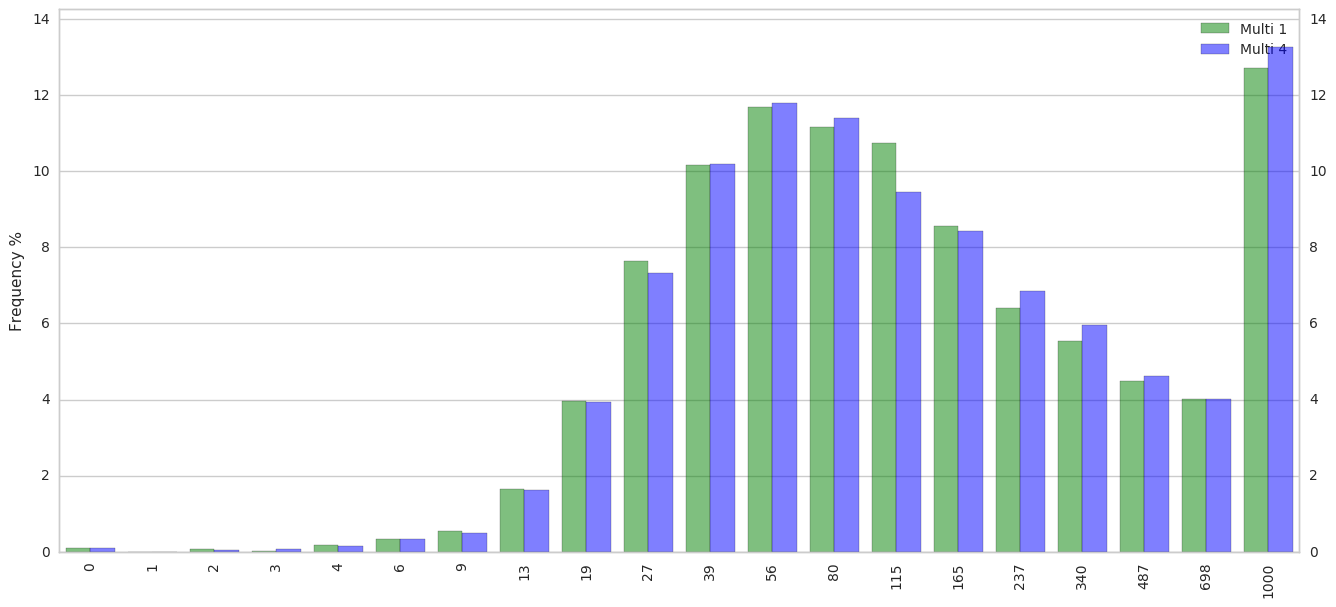

---
#### FX_TAB_SWITCH_SPINNER_VISIBLE_MS (parent) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:red"><b>0.012</b>.</span>
            

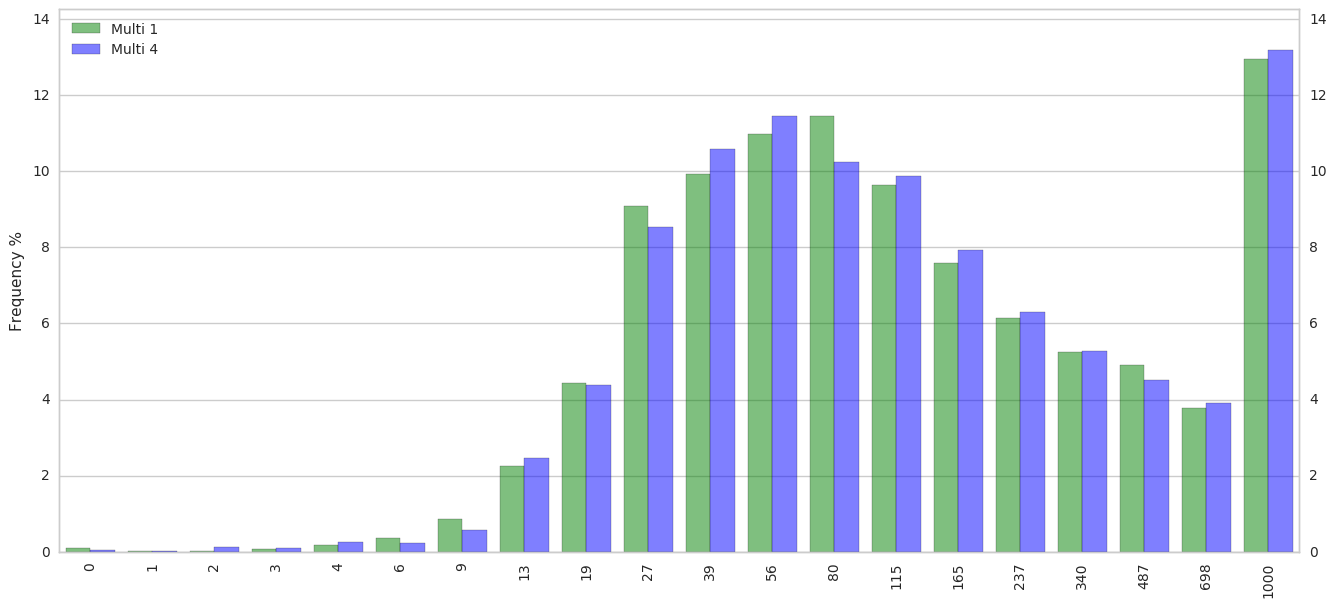

---
#### FX_TAB_SWITCH_SPINNER_VISIBLE_MS (parent) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.715</b>.</span>
            

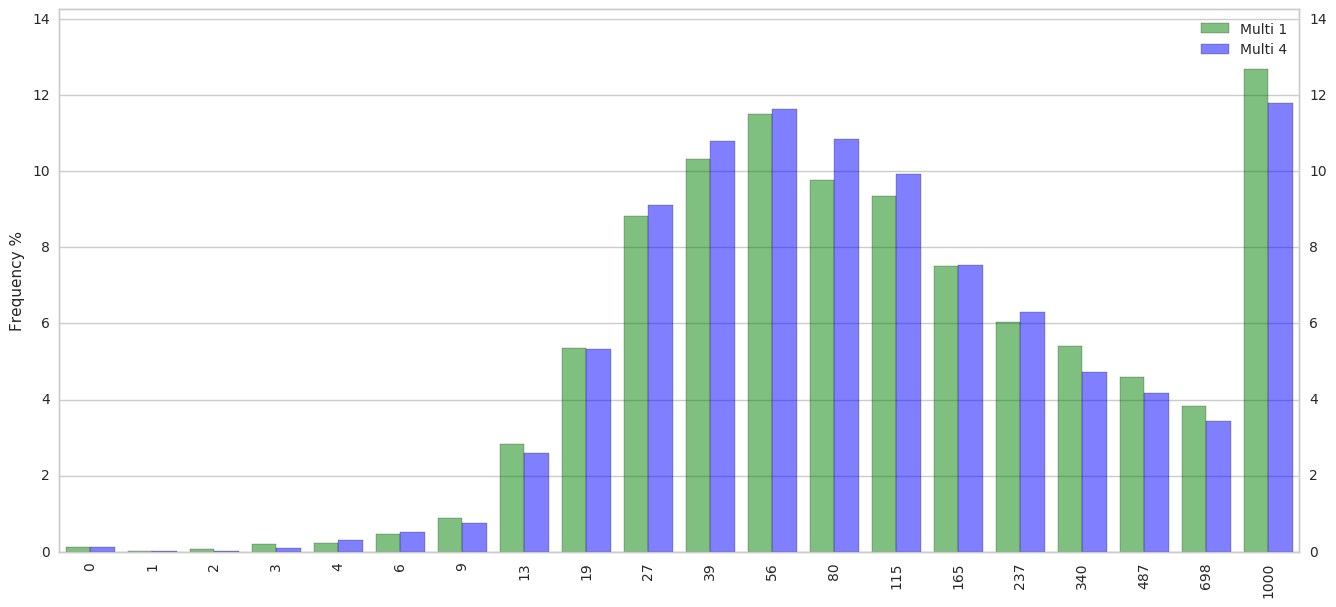

# Darwin

Comparison for FX_TAB_SWITCH_SPINNER_VISIBLE_MS:

527 (13.3%) multi_1 profiles on Darwin have the parent histogram.
518 (13.1%) multi_4 profiles on Darwin have the parent histogram.
38 (15.8%) webext_multi_1 profiles on Darwin have the parent histogram.
49 (20.5%) webextx_multi_4 profiles on Darwin have the parent histogram.
72 (15.9%) mpc_multi_1 profiles on Darwin have the parent histogram.
64 (15.3%) mpc_multi_4 profiles on Darwin have the parent histogram.
No multi_1 profiles on Darwin have the child histogram.
No multi_4 profiles on Darwin have the child histogram.
No webext_multi_1 profiles on Darwin have the child histogram.
No webextx_multi_4 profiles on Darwin have the child histogram.
No mpc_multi_1 profiles on Darwin have the child histogram.
No mpc_multi_4 profiles on Darwin have the child histogram.


---
#### FX_TAB_SWITCH_SPINNER_VISIBLE_MS (parent) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.234</b>.</span>
            

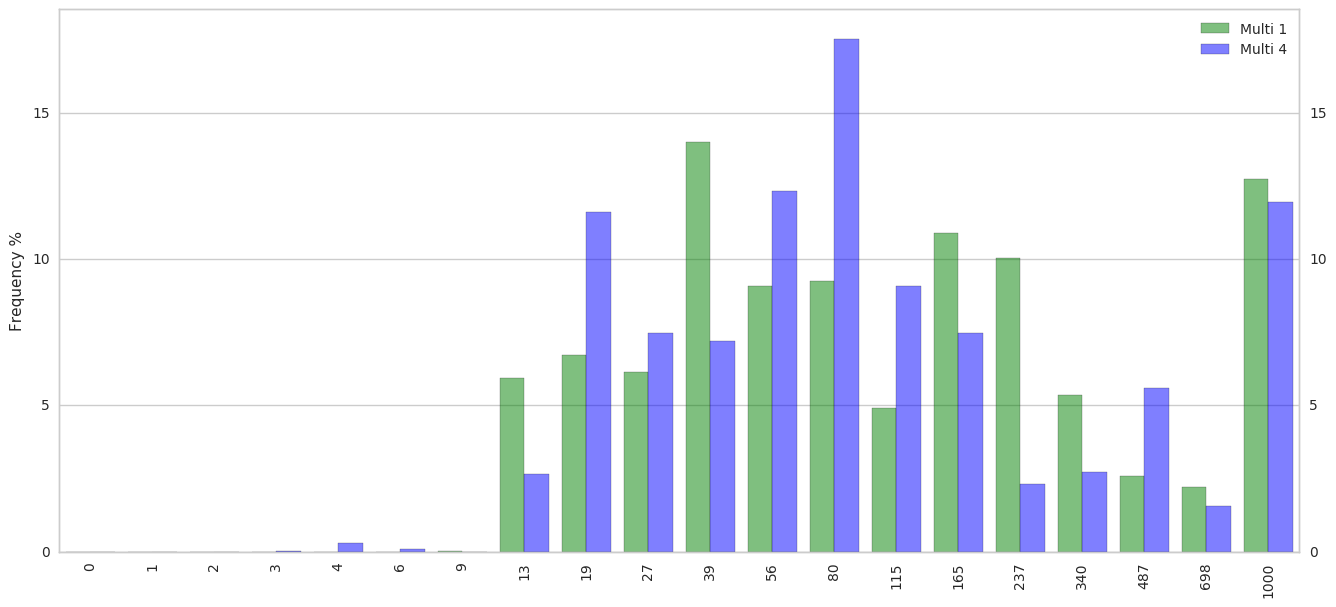

---
#### FX_TAB_SWITCH_SPINNER_VISIBLE_MS (parent) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.494</b>.</span>
            

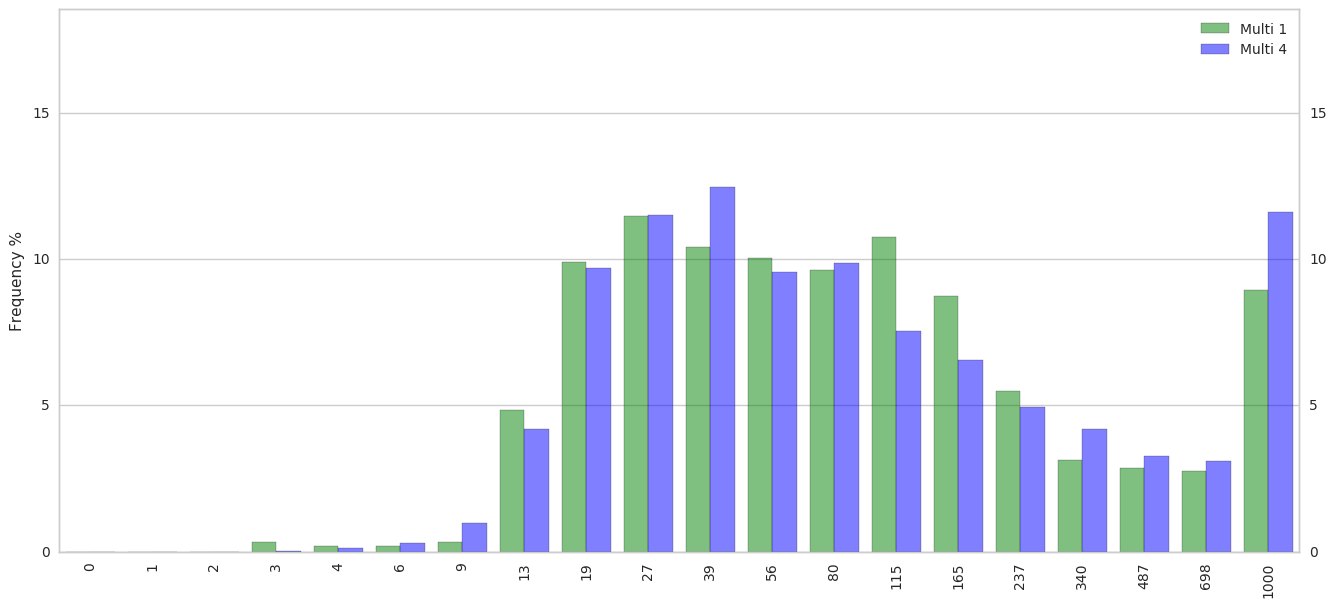

---
#### FX_TAB_SWITCH_SPINNER_VISIBLE_MS (parent) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:red"><b>0.014</b>.</span>
            

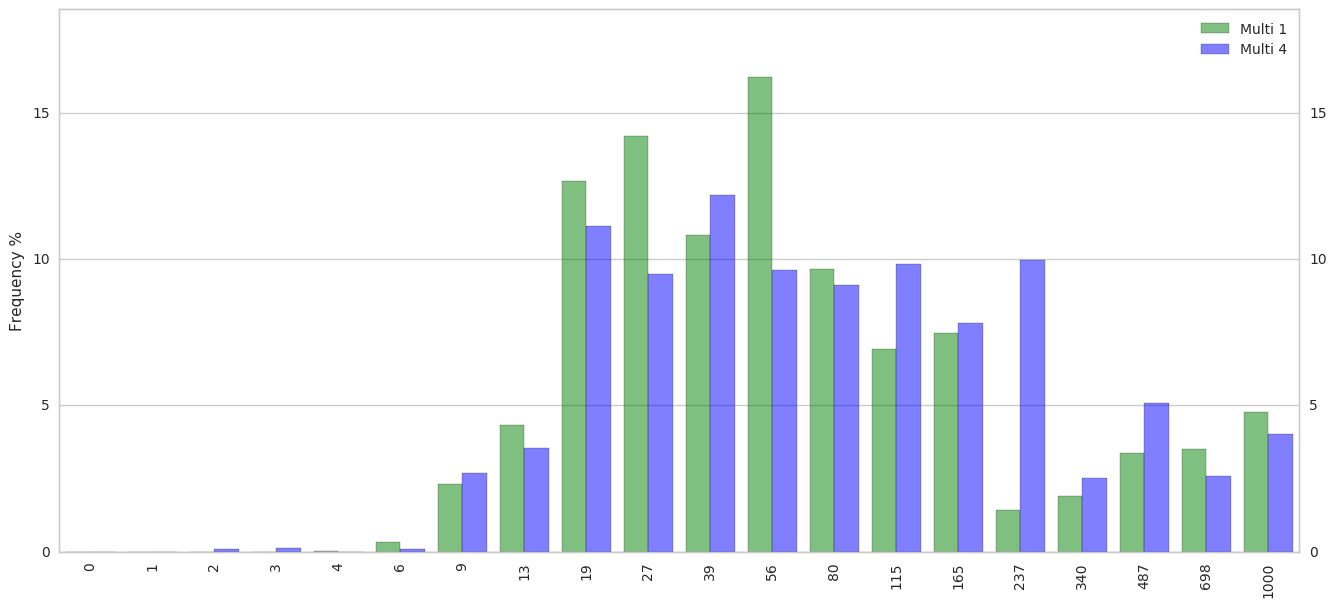

In [119]:
results.extend(compare_tab_groups(t3, t4, "payload/histograms/FX_TAB_SWITCH_SPINNER_VISIBLE_MS"))

### FX_TAB_SWITCH_SPINNER_VISIBLE_LONG_MS

## 1-3 Tabs

# Windows_NT

Comparison for FX_TAB_SWITCH_SPINNER_VISIBLE_LONG_MS:

3438 (8.4%) multi_1 profiles on Windows_NT have the parent histogram.
3579 (8.8%) multi_4 profiles on Windows_NT have the parent histogram.
4248 (10.3%) webext_multi_1 profiles on Windows_NT have the parent histogram.
4267 (10.5%) webextx_multi_4 profiles on Windows_NT have the parent histogram.
2758 (9.3%) mpc_multi_1 profiles on Windows_NT have the parent histogram.
2737 (9.2%) mpc_multi_4 profiles on Windows_NT have the parent histogram.
No multi_1 profiles on Windows_NT have the child histogram.
No multi_4 profiles on Windows_NT have the child histogram.
No webext_multi_1 profiles on Windows_NT have the child histogram.
No webextx_multi_4 profiles on Windows_NT have the child histogram.
No mpc_multi_1 profiles on Windows_NT have the child histogram.
No mpc_multi_4 profiles on Windows_NT have the child histogram.


---
#### FX_TAB_SWITCH_SPINNER_VISIBLE_LONG_MS (parent) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.795</b>.</span>
            

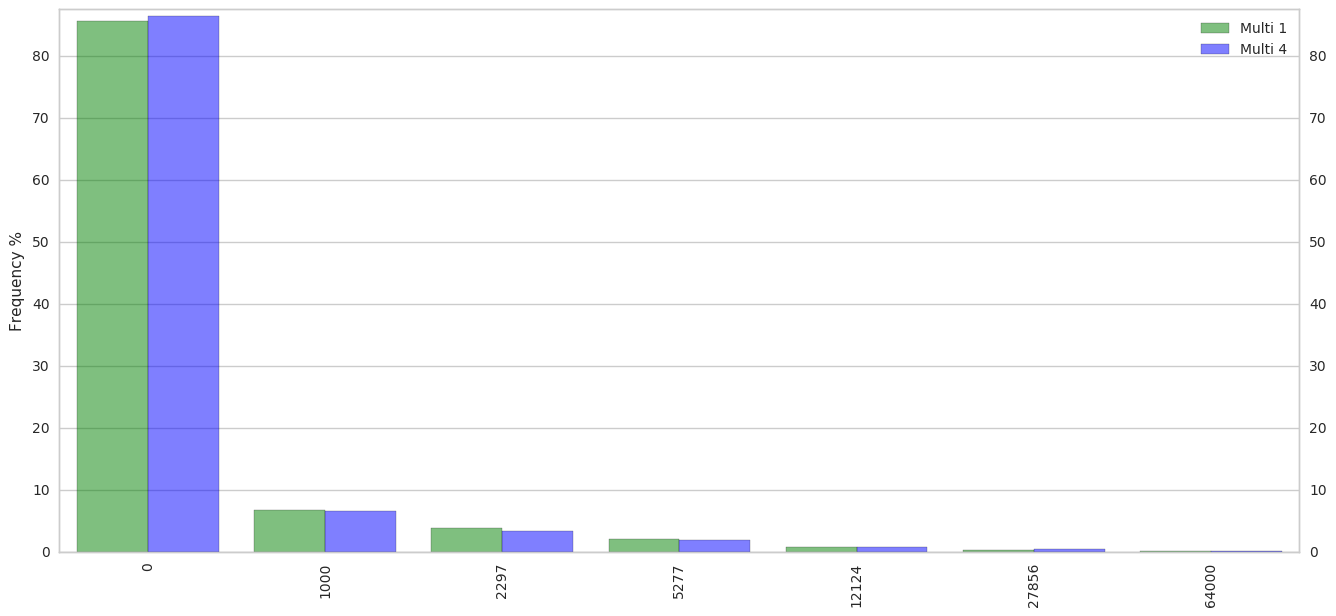

---
#### FX_TAB_SWITCH_SPINNER_VISIBLE_LONG_MS (parent) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.189</b>.</span>
            

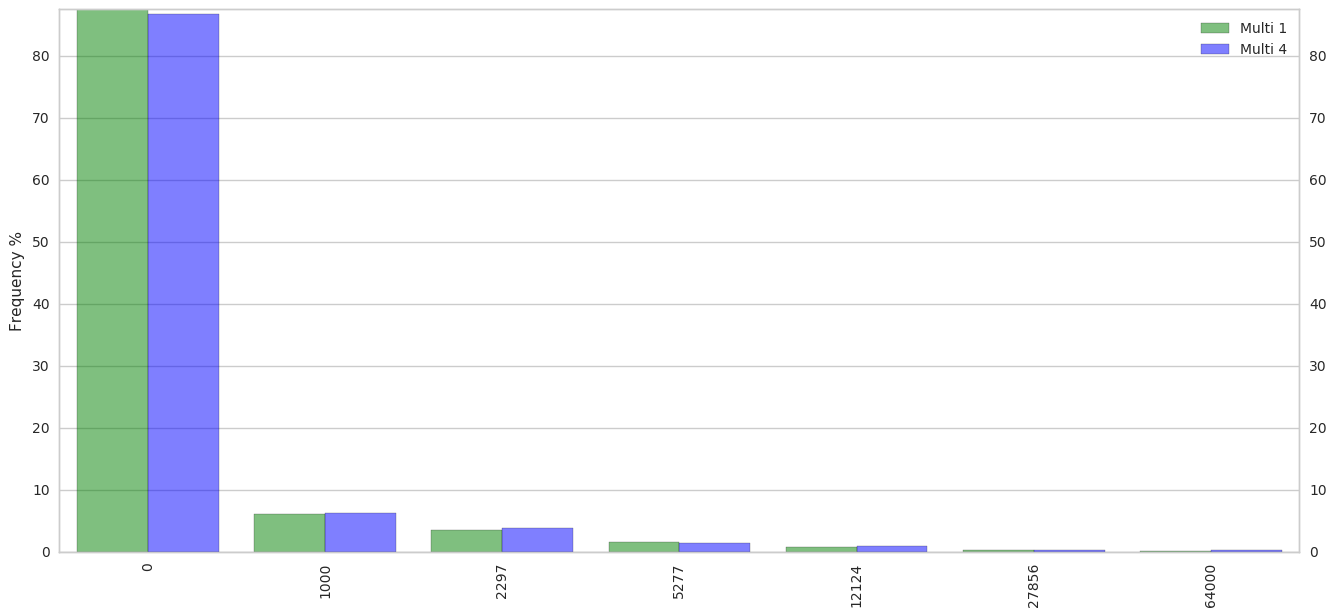

---
#### FX_TAB_SWITCH_SPINNER_VISIBLE_LONG_MS (parent) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.551</b>.</span>
            

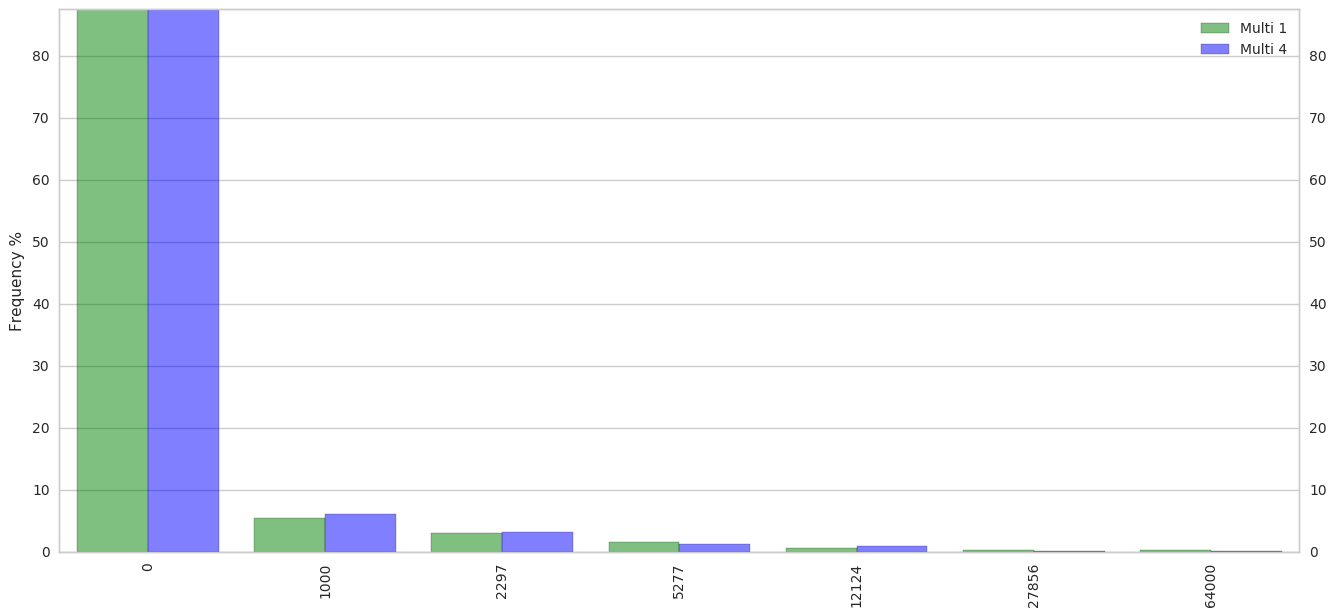

# Darwin

Comparison for FX_TAB_SWITCH_SPINNER_VISIBLE_LONG_MS:

360 (9.1%) multi_1 profiles on Darwin have the parent histogram.
371 (9.4%) multi_4 profiles on Darwin have the parent histogram.
25 (10.4%) webext_multi_1 profiles on Darwin have the parent histogram.
23 (9.6%) webextx_multi_4 profiles on Darwin have the parent histogram.
35 (7.7%) mpc_multi_1 profiles on Darwin have the parent histogram.
36 (8.6%) mpc_multi_4 profiles on Darwin have the parent histogram.
No multi_1 profiles on Darwin have the child histogram.
No multi_4 profiles on Darwin have the child histogram.
No webext_multi_1 profiles on Darwin have the child histogram.
No webextx_multi_4 profiles on Darwin have the child histogram.
No mpc_multi_1 profiles on Darwin have the child histogram.
No mpc_multi_4 profiles on Darwin have the child histogram.


---
#### FX_TAB_SWITCH_SPINNER_VISIBLE_LONG_MS (parent) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.539</b>.</span>
            

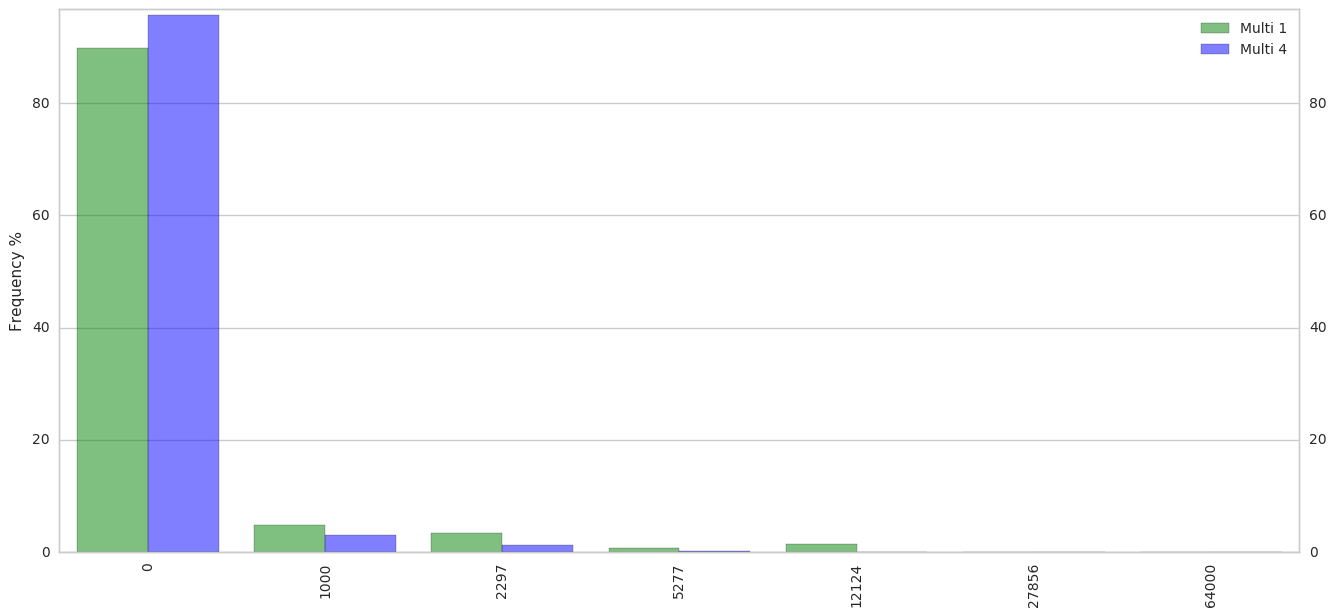

---
#### FX_TAB_SWITCH_SPINNER_VISIBLE_LONG_MS (parent) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.256</b>.</span>
            

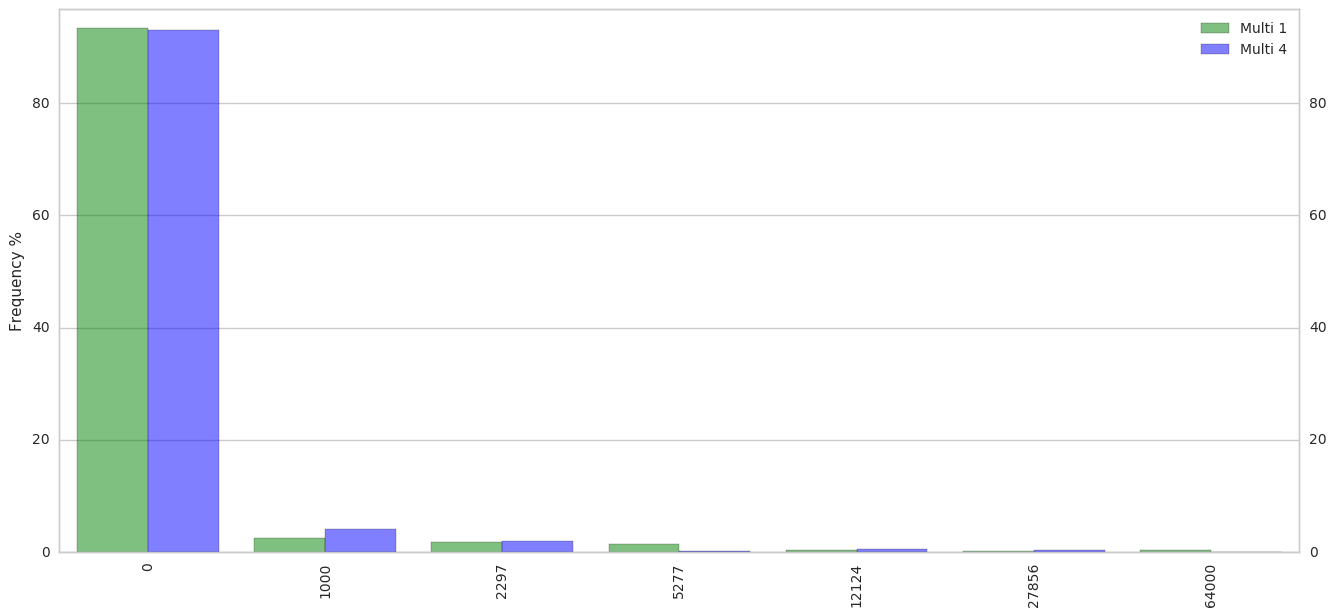

---
#### FX_TAB_SWITCH_SPINNER_VISIBLE_LONG_MS (parent) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.568</b>.</span>
            

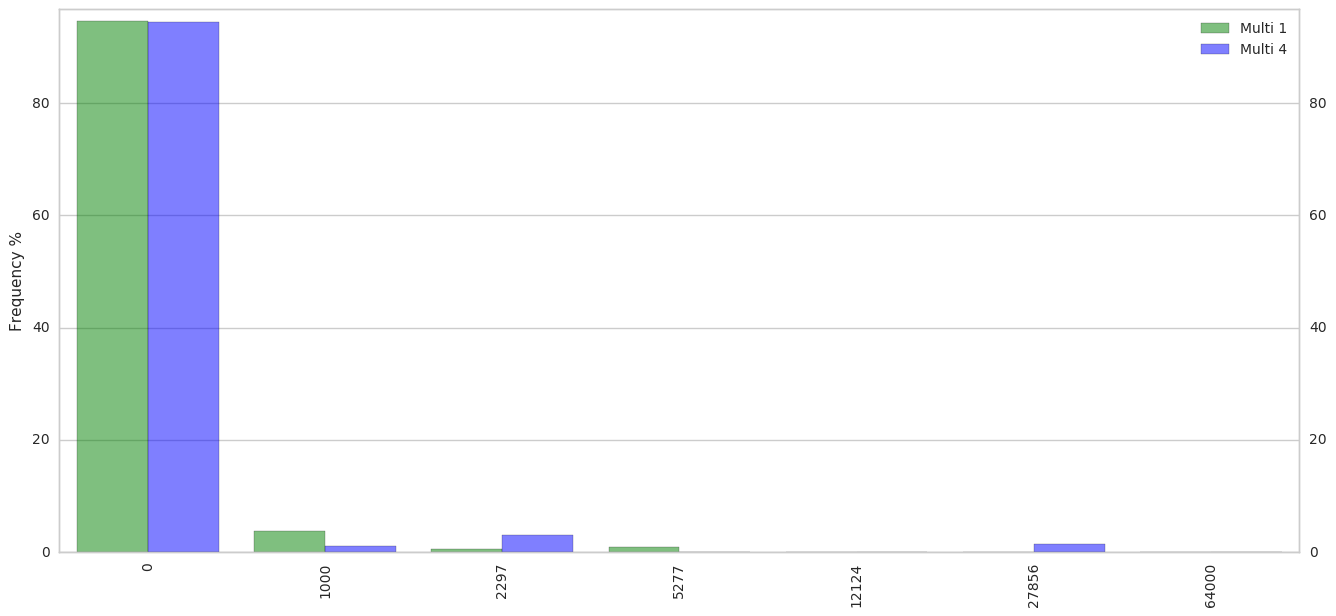

## 4+ Tabs

# Windows_NT

Comparison for FX_TAB_SWITCH_SPINNER_VISIBLE_LONG_MS:

2945 (7.2%) multi_1 profiles on Windows_NT have the parent histogram.
3117 (7.6%) multi_4 profiles on Windows_NT have the parent histogram.
4501 (10.9%) webext_multi_1 profiles on Windows_NT have the parent histogram.
4504 (11.0%) webextx_multi_4 profiles on Windows_NT have the parent histogram.
3077 (10.4%) mpc_multi_1 profiles on Windows_NT have the parent histogram.
3042 (10.2%) mpc_multi_4 profiles on Windows_NT have the parent histogram.
No multi_1 profiles on Windows_NT have the child histogram.
No multi_4 profiles on Windows_NT have the child histogram.
No webext_multi_1 profiles on Windows_NT have the child histogram.
No webextx_multi_4 profiles on Windows_NT have the child histogram.
No mpc_multi_1 profiles on Windows_NT have the child histogram.
No mpc_multi_4 profiles on Windows_NT have the child histogram.


---
#### FX_TAB_SWITCH_SPINNER_VISIBLE_LONG_MS (parent) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.689</b>.</span>
            

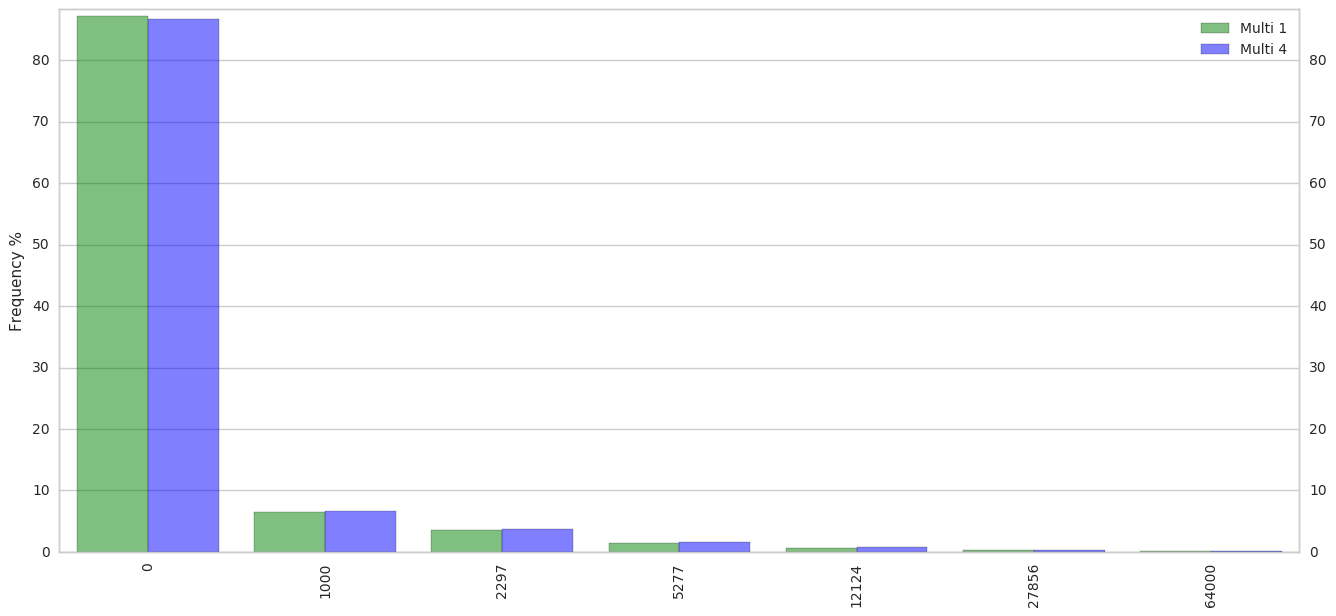

---
#### FX_TAB_SWITCH_SPINNER_VISIBLE_LONG_MS (parent) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.322</b>.</span>
            

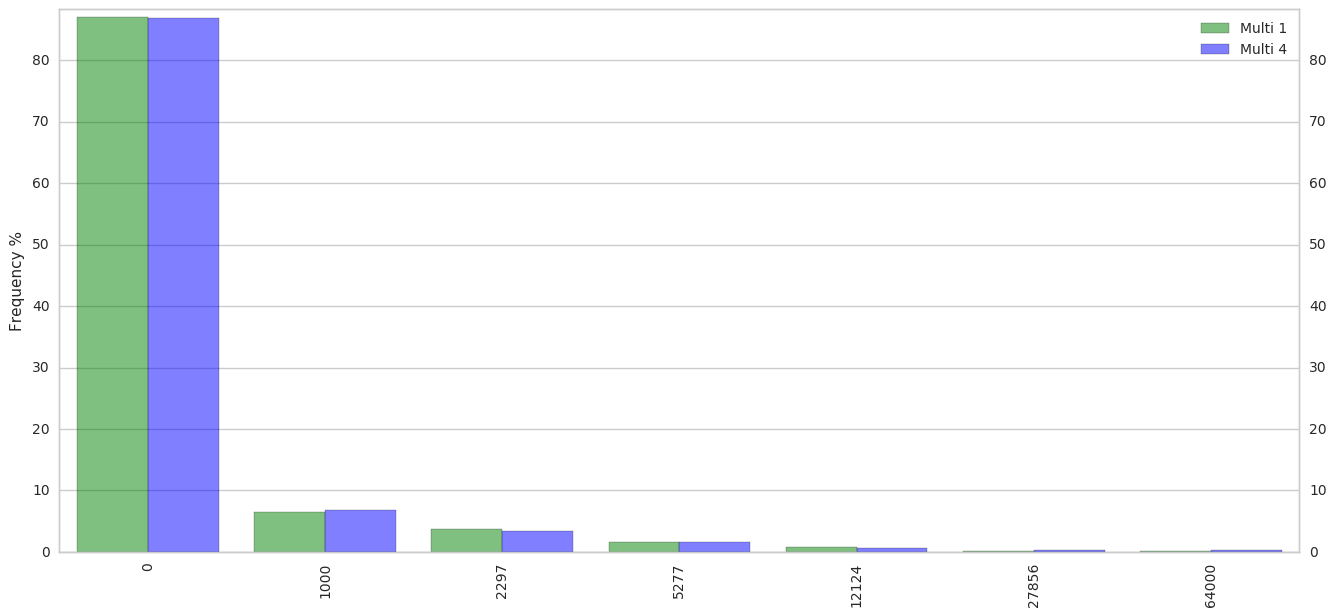

---
#### FX_TAB_SWITCH_SPINNER_VISIBLE_LONG_MS (parent) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.529</b>.</span>
            

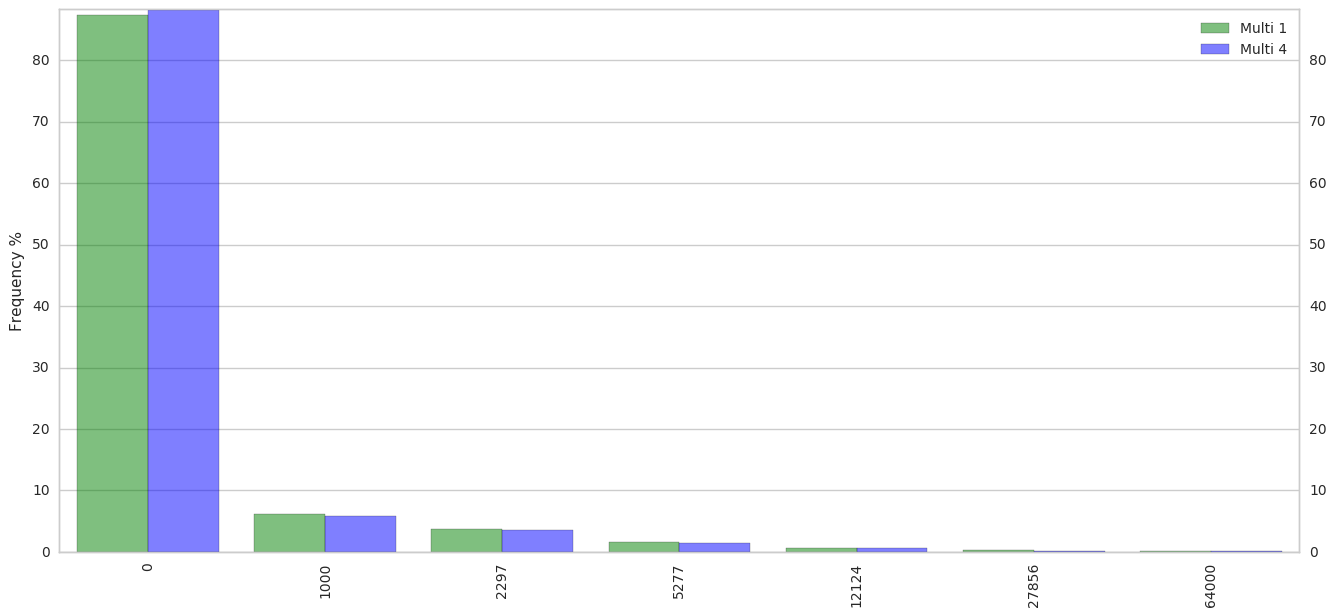

# Darwin

Comparison for FX_TAB_SWITCH_SPINNER_VISIBLE_LONG_MS:

527 (13.3%) multi_1 profiles on Darwin have the parent histogram.
518 (13.1%) multi_4 profiles on Darwin have the parent histogram.
38 (15.8%) webext_multi_1 profiles on Darwin have the parent histogram.
49 (20.5%) webextx_multi_4 profiles on Darwin have the parent histogram.
72 (15.9%) mpc_multi_1 profiles on Darwin have the parent histogram.
64 (15.3%) mpc_multi_4 profiles on Darwin have the parent histogram.
No multi_1 profiles on Darwin have the child histogram.
No multi_4 profiles on Darwin have the child histogram.
No webext_multi_1 profiles on Darwin have the child histogram.
No webextx_multi_4 profiles on Darwin have the child histogram.
No mpc_multi_1 profiles on Darwin have the child histogram.
No mpc_multi_4 profiles on Darwin have the child histogram.


---
#### FX_TAB_SWITCH_SPINNER_VISIBLE_LONG_MS (parent) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.896</b>.</span>
            

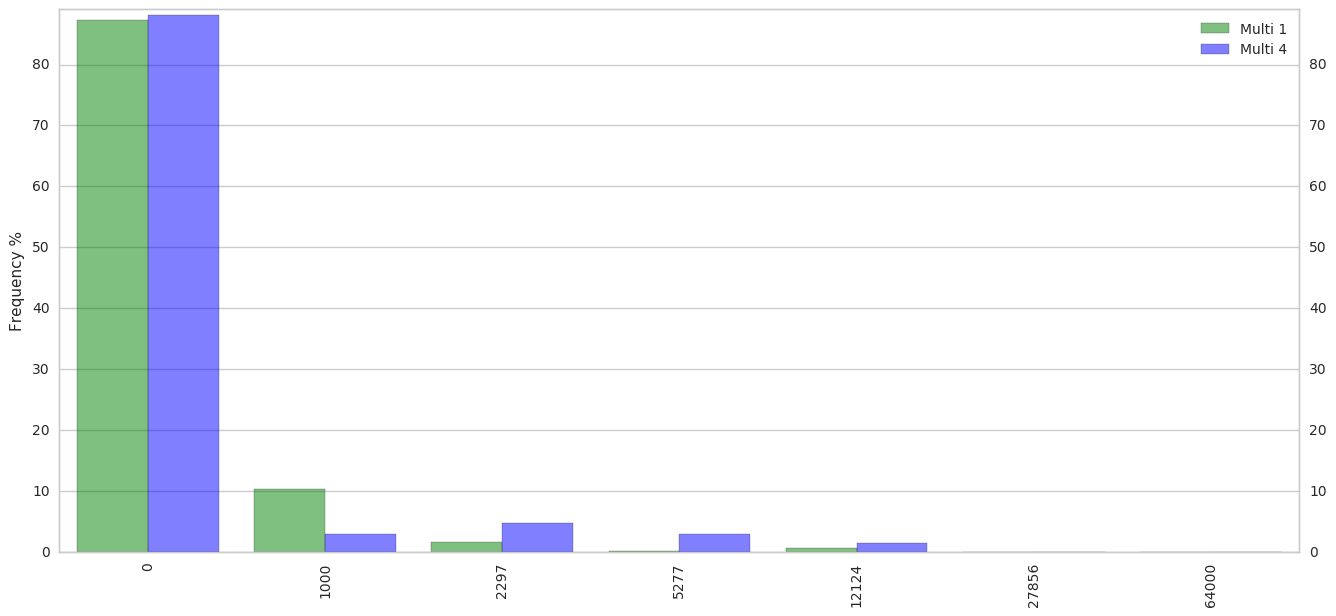

---
#### FX_TAB_SWITCH_SPINNER_VISIBLE_LONG_MS (parent) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.908</b>.</span>
            

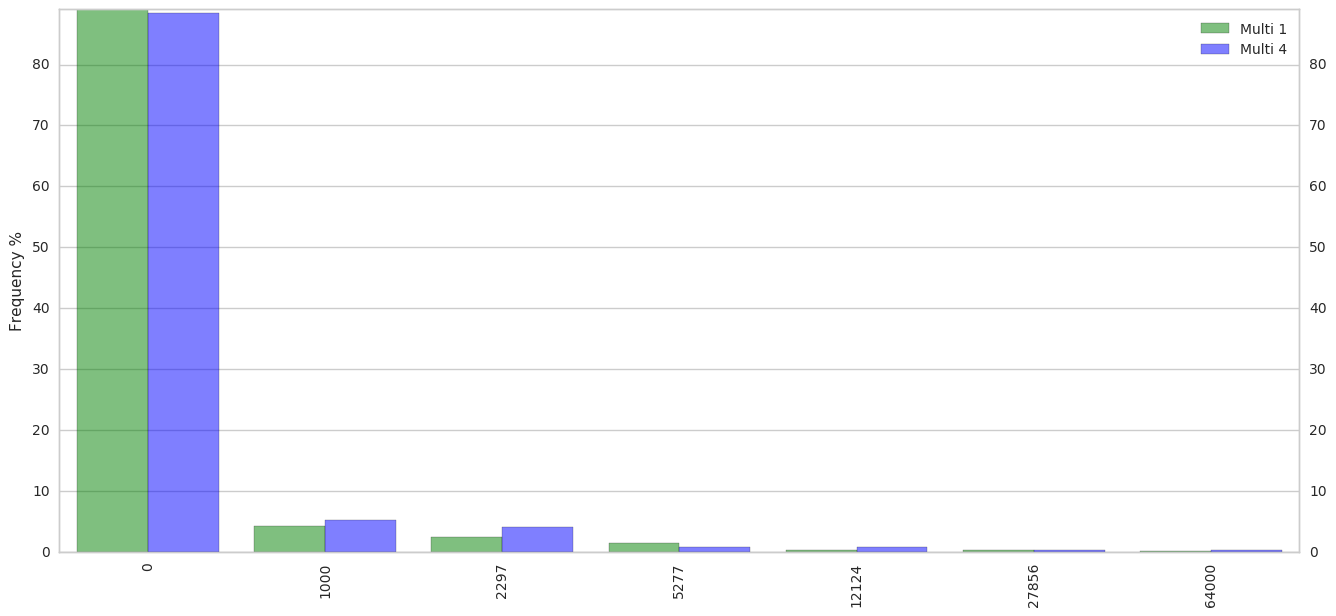

---
#### FX_TAB_SWITCH_SPINNER_VISIBLE_LONG_MS (parent) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.457</b>.</span>
            

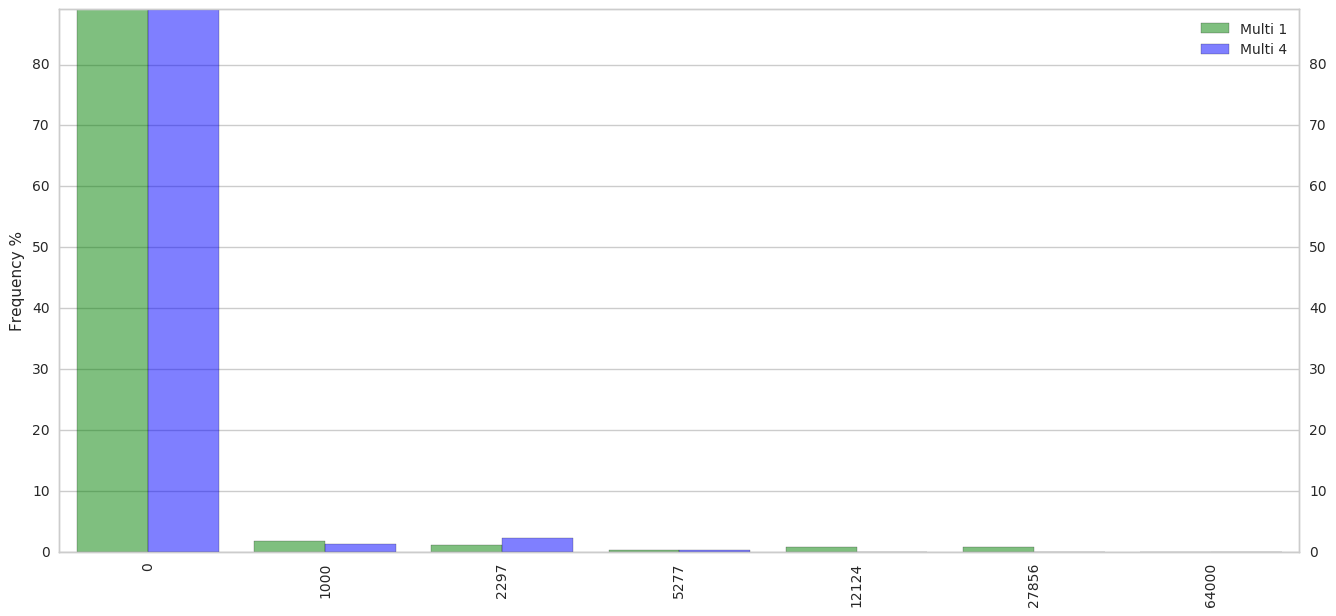

In [120]:
results.extend(compare_tab_groups(t3, t4, "payload/histograms/FX_TAB_SWITCH_SPINNER_VISIBLE_LONG_MS"))

### FX_TAB_REMOTE_NAVIGATION_DELAY_MS 

## 1-3 Tabs

# Windows_NT

Comparison for [FX_TAB_REMOTE_NAVIGATION_DELAY_MS](https://dxr.mozilla.org/mozilla-central/search?q=FX_TAB_REMOTE_NAVIGATION_DELAY_MS+file%3AHistograms.json&redirect=true)/WebNavigation:LoadURI:

No multi_1 profiles on Windows_NT have the parent histogram.
No multi_4 profiles on Windows_NT have the parent histogram.
No webext_multi_1 profiles on Windows_NT have the parent histogram.
No webextx_multi_4 profiles on Windows_NT have the parent histogram.
No mpc_multi_1 profiles on Windows_NT have the parent histogram.
No mpc_multi_4 profiles on Windows_NT have the parent histogram.
28561 (70.2%) multi_1 profiles on Windows_NT have the child histogram.
28626 (70.2%) multi_4 profiles on Windows_NT have the child histogram.
27438 (66.4%) webext_multi_1 profiles on Windows_NT have the child histogram.
26960 (66.1%) webextx_multi_4 profiles on Windows_NT have the child histogram.
20214 (68.3%) mpc_multi_1 profiles on Windows_NT have the child histogram.
20337 (68.5%) mpc_multi_4 profiles on Windows_NT have the child histogram.


---
#### FX_TAB_REMOTE_NAVIGATION_DELAY_MS (children) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.883</b>.</span>
            

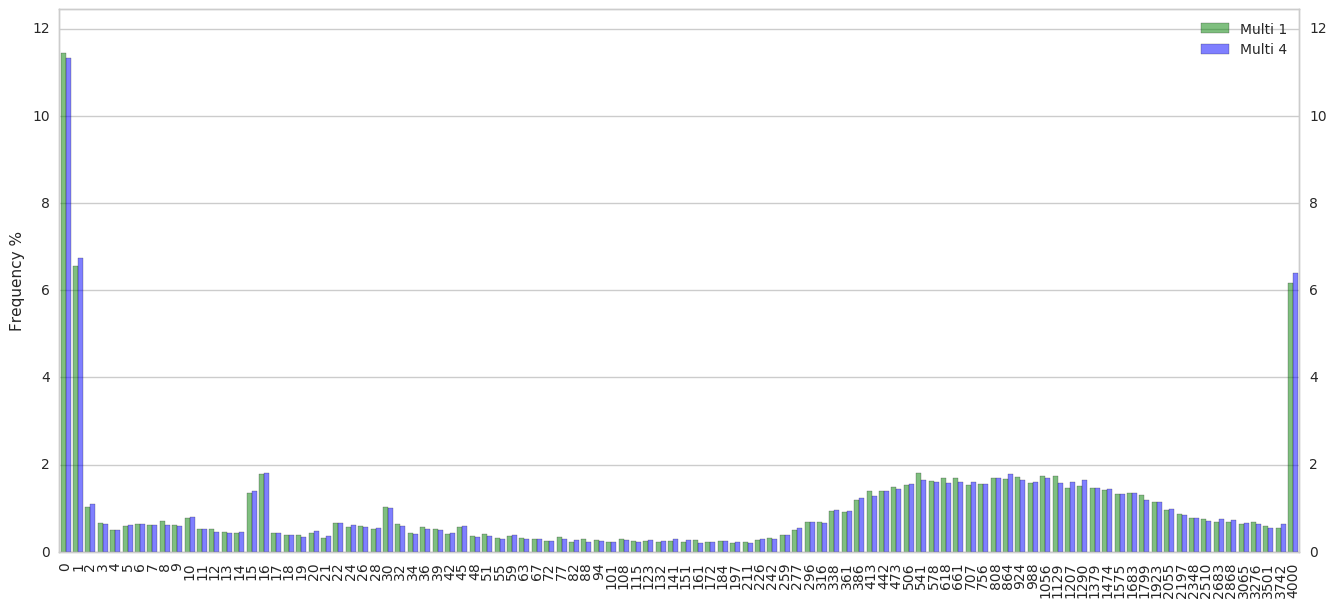

---
#### FX_TAB_REMOTE_NAVIGATION_DELAY_MS (children) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.174</b>.</span>
            

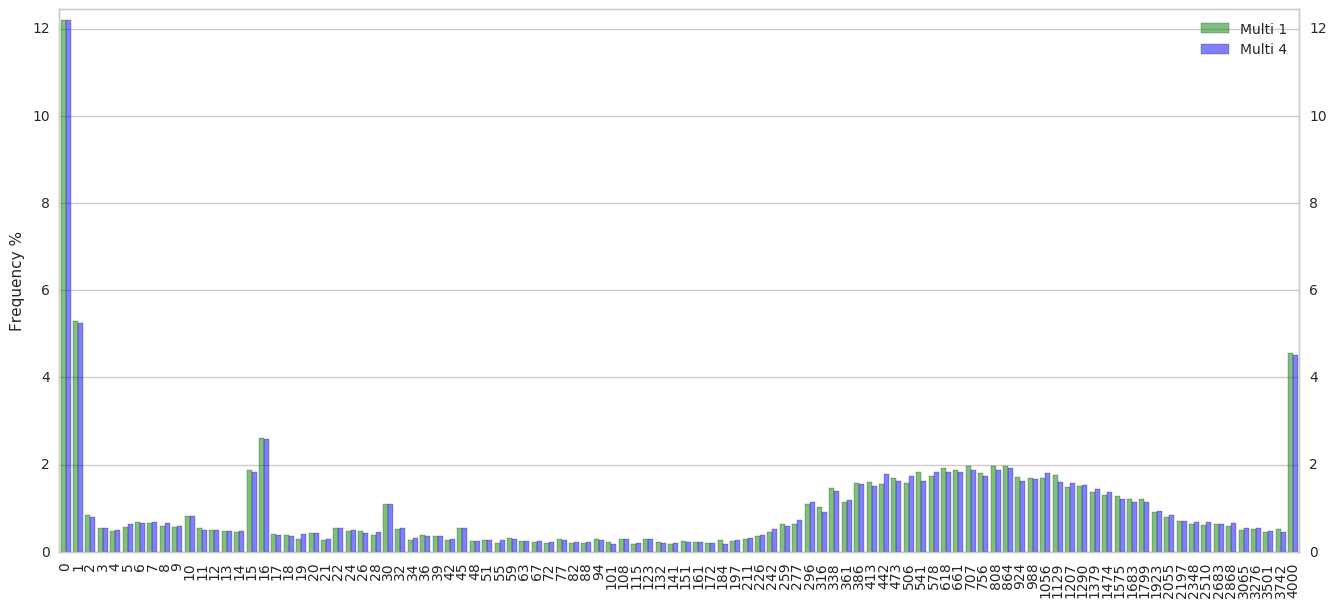

---
#### FX_TAB_REMOTE_NAVIGATION_DELAY_MS (children) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.320</b>.</span>
            

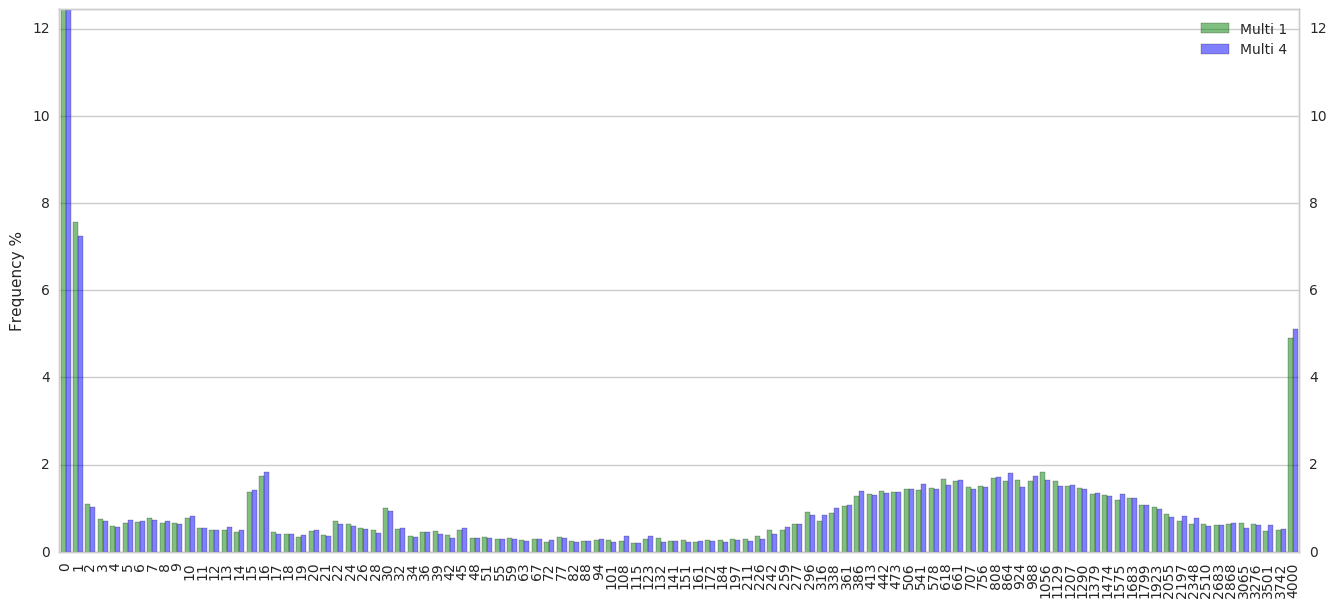

# Darwin

Comparison for [FX_TAB_REMOTE_NAVIGATION_DELAY_MS](https://dxr.mozilla.org/mozilla-central/search?q=FX_TAB_REMOTE_NAVIGATION_DELAY_MS+file%3AHistograms.json&redirect=true)/WebNavigation:LoadURI:

No multi_1 profiles on Darwin have the parent histogram.
No multi_4 profiles on Darwin have the parent histogram.
No webext_multi_1 profiles on Darwin have the parent histogram.
No webextx_multi_4 profiles on Darwin have the parent histogram.
No mpc_multi_1 profiles on Darwin have the parent histogram.
No mpc_multi_4 profiles on Darwin have the parent histogram.
2302 (58.2%) multi_1 profiles on Darwin have the child histogram.
2276 (57.4%) multi_4 profiles on Darwin have the child histogram.
134 (55.8%) webext_multi_1 profiles on Darwin have the child histogram.
126 (52.7%) webextx_multi_4 profiles on Darwin have the child histogram.
255 (56.2%) mpc_multi_1 profiles on Darwin have the child histogram.
251 (59.9%) mpc_multi_4 profiles on Darwin have the child histogram.


---
#### FX_TAB_REMOTE_NAVIGATION_DELAY_MS (children) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.143</b>.</span>
            

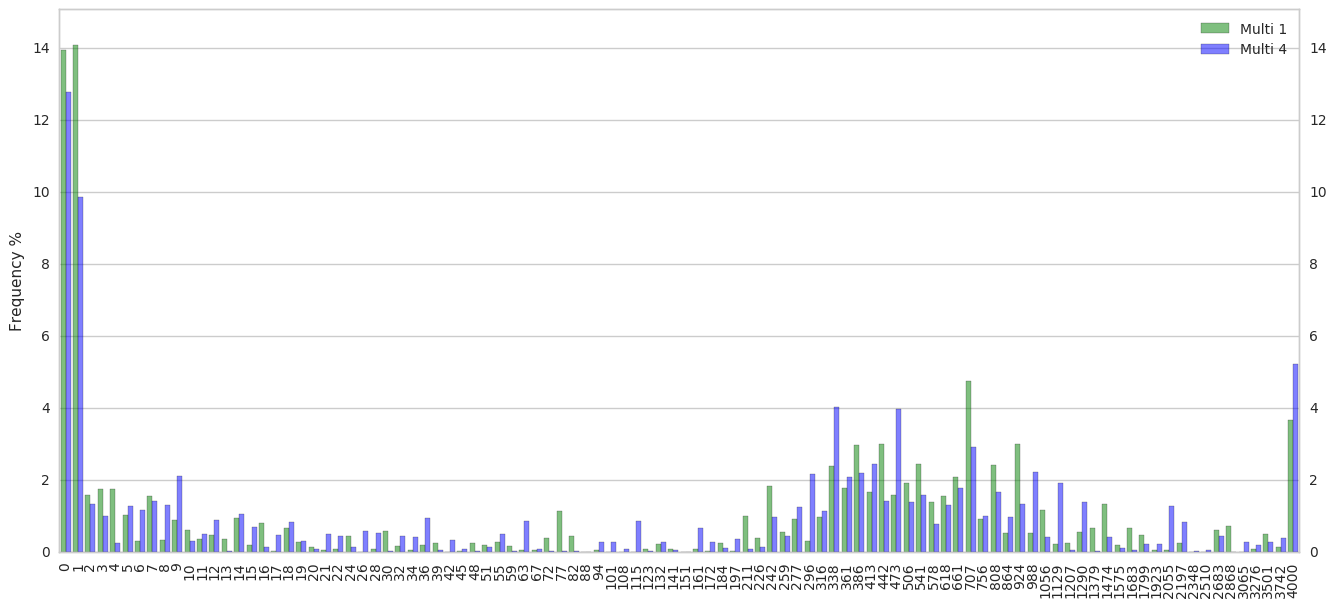

---
#### FX_TAB_REMOTE_NAVIGATION_DELAY_MS (children) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.824</b>.</span>
            

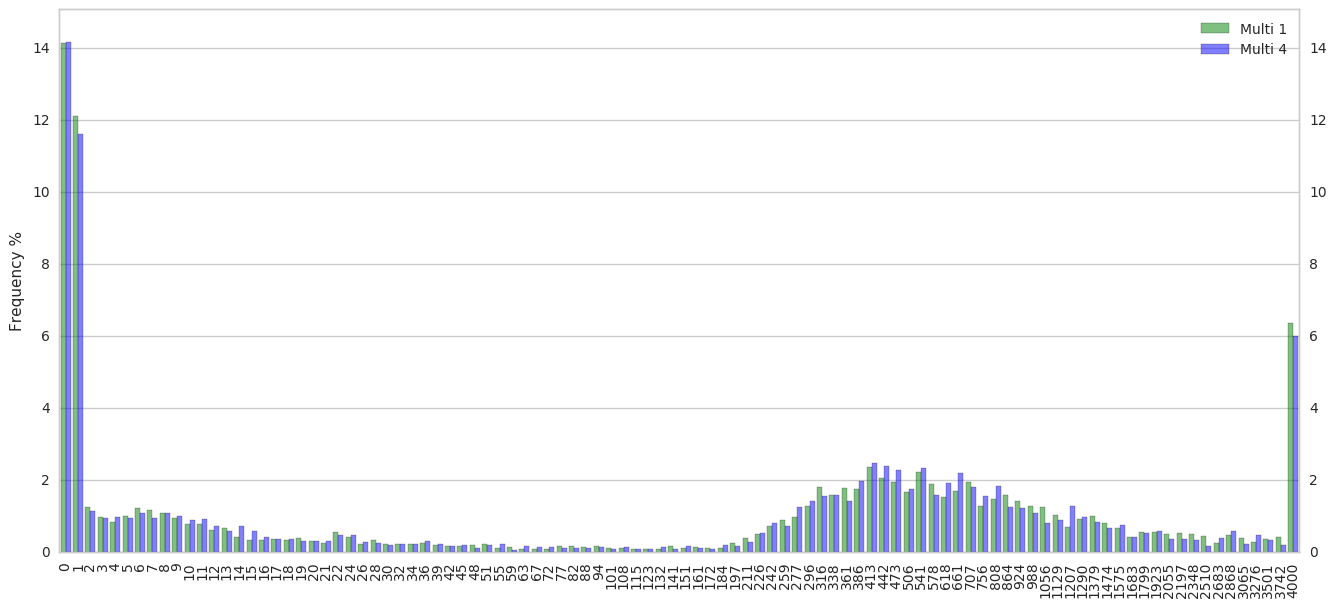

---
#### FX_TAB_REMOTE_NAVIGATION_DELAY_MS (children) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.988</b>.</span>
            

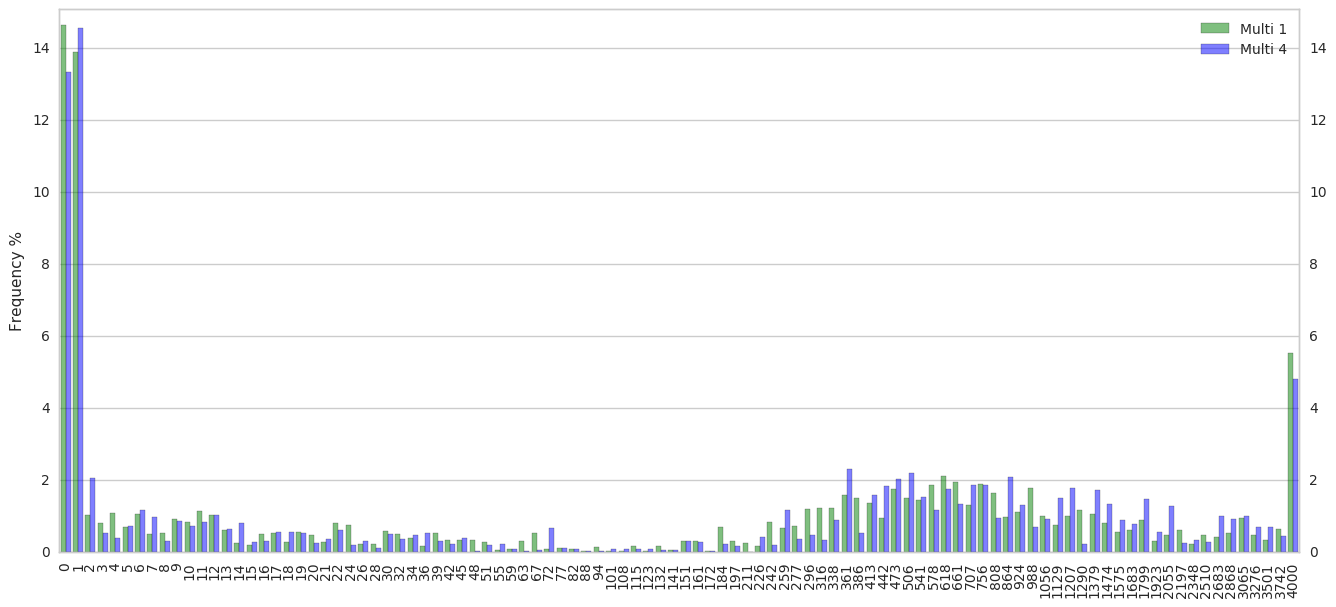

## 4+ Tabs

# Windows_NT

Comparison for [FX_TAB_REMOTE_NAVIGATION_DELAY_MS](https://dxr.mozilla.org/mozilla-central/search?q=FX_TAB_REMOTE_NAVIGATION_DELAY_MS+file%3AHistograms.json&redirect=true)/WebNavigation:LoadURI:

No multi_1 profiles on Windows_NT have the parent histogram.
No multi_4 profiles on Windows_NT have the parent histogram.
No webext_multi_1 profiles on Windows_NT have the parent histogram.
No webextx_multi_4 profiles on Windows_NT have the parent histogram.
No mpc_multi_1 profiles on Windows_NT have the parent histogram.
No mpc_multi_4 profiles on Windows_NT have the parent histogram.
6867 (16.9%) multi_1 profiles on Windows_NT have the child histogram.
6944 (17.0%) multi_4 profiles on Windows_NT have the child histogram.
9966 (24.1%) webext_multi_1 profiles on Windows_NT have the child histogram.
9918 (24.3%) webextx_multi_4 profiles on Windows_NT have the child histogram.
7972 (26.9%) mpc_multi_1 profiles on Windows_NT have the child histogram.
7963 (26.8%) mpc_multi_4 profiles on Windows_NT have the child histogram.


---
#### FX_TAB_REMOTE_NAVIGATION_DELAY_MS (children) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:red"><b>0.035</b>.</span>
            

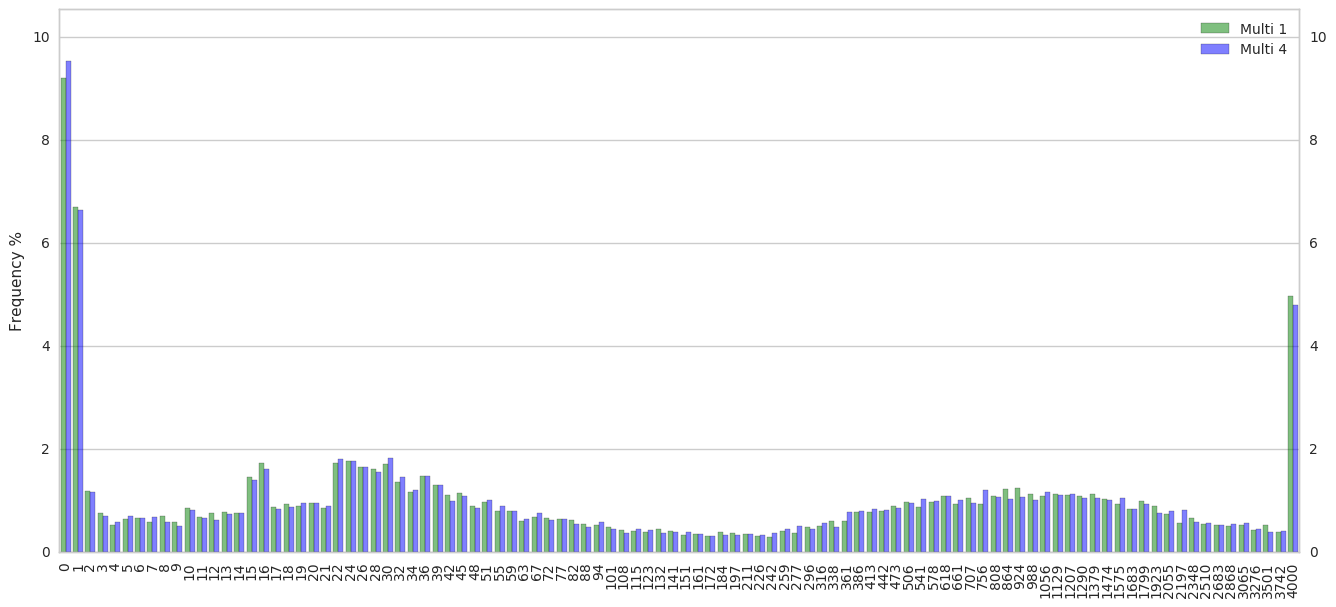

---
#### FX_TAB_REMOTE_NAVIGATION_DELAY_MS (children) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.121</b>.</span>
            

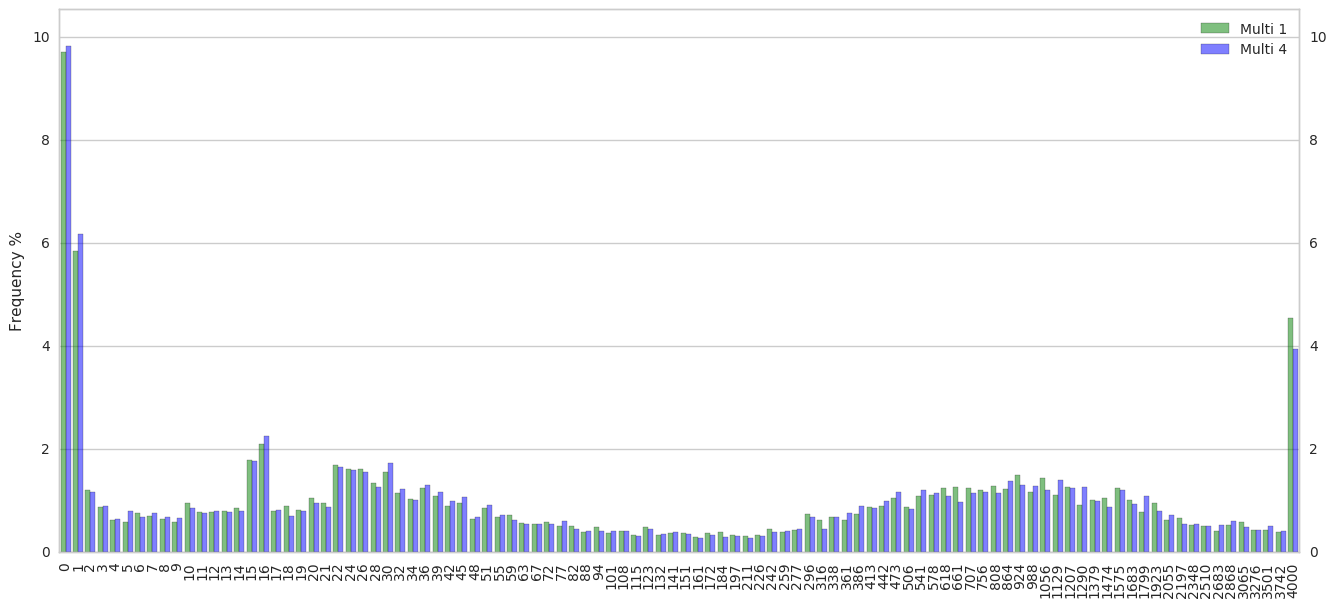

---
#### FX_TAB_REMOTE_NAVIGATION_DELAY_MS (children) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.586</b>.</span>
            

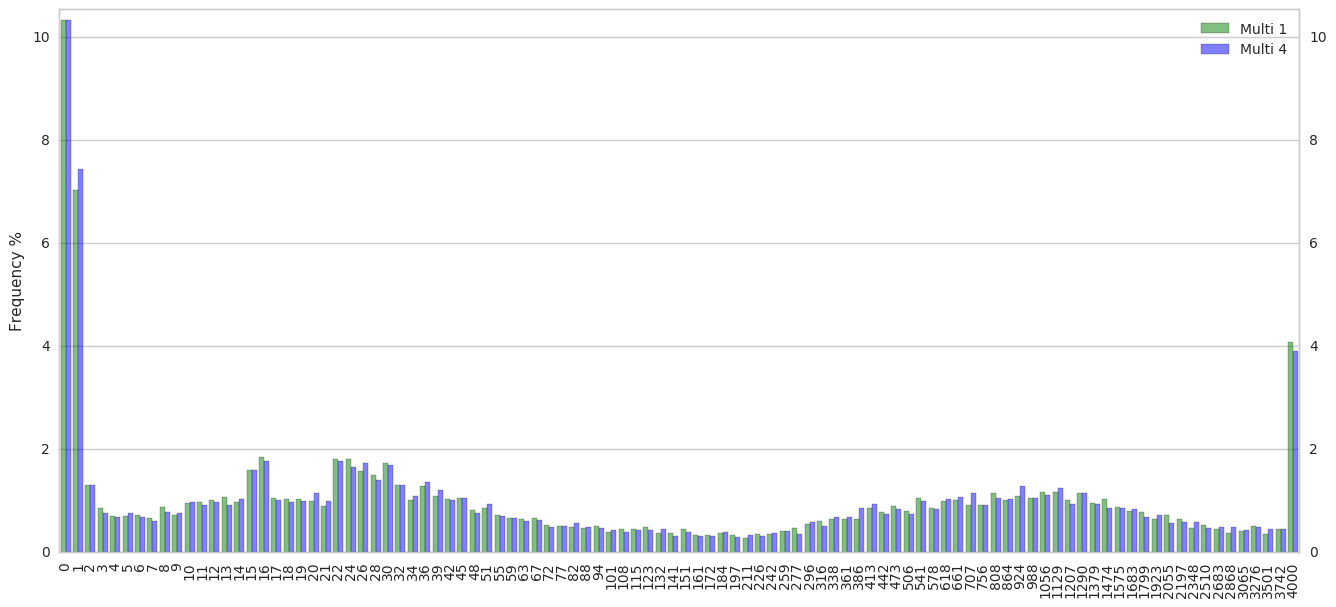

# Darwin

Comparison for [FX_TAB_REMOTE_NAVIGATION_DELAY_MS](https://dxr.mozilla.org/mozilla-central/search?q=FX_TAB_REMOTE_NAVIGATION_DELAY_MS+file%3AHistograms.json&redirect=true)/WebNavigation:LoadURI:

No multi_1 profiles on Darwin have the parent histogram.
No multi_4 profiles on Darwin have the parent histogram.
No webext_multi_1 profiles on Darwin have the parent histogram.
No webextx_multi_4 profiles on Darwin have the parent histogram.
No mpc_multi_1 profiles on Darwin have the parent histogram.
No mpc_multi_4 profiles on Darwin have the parent histogram.
880 (22.2%) multi_1 profiles on Darwin have the child histogram.
913 (23.0%) multi_4 profiles on Darwin have the child histogram.
71 (29.6%) webext_multi_1 profiles on Darwin have the child histogram.
91 (38.1%) webextx_multi_4 profiles on Darwin have the child histogram.
166 (36.6%) mpc_multi_1 profiles on Darwin have the child histogram.
142 (33.9%) mpc_multi_4 profiles on Darwin have the child histogram.


---
#### FX_TAB_REMOTE_NAVIGATION_DELAY_MS (children) With WebExtensions
Probability the two histograms differ by chance is
            <span style="color:red"><b>0.045</b>.</span>
            

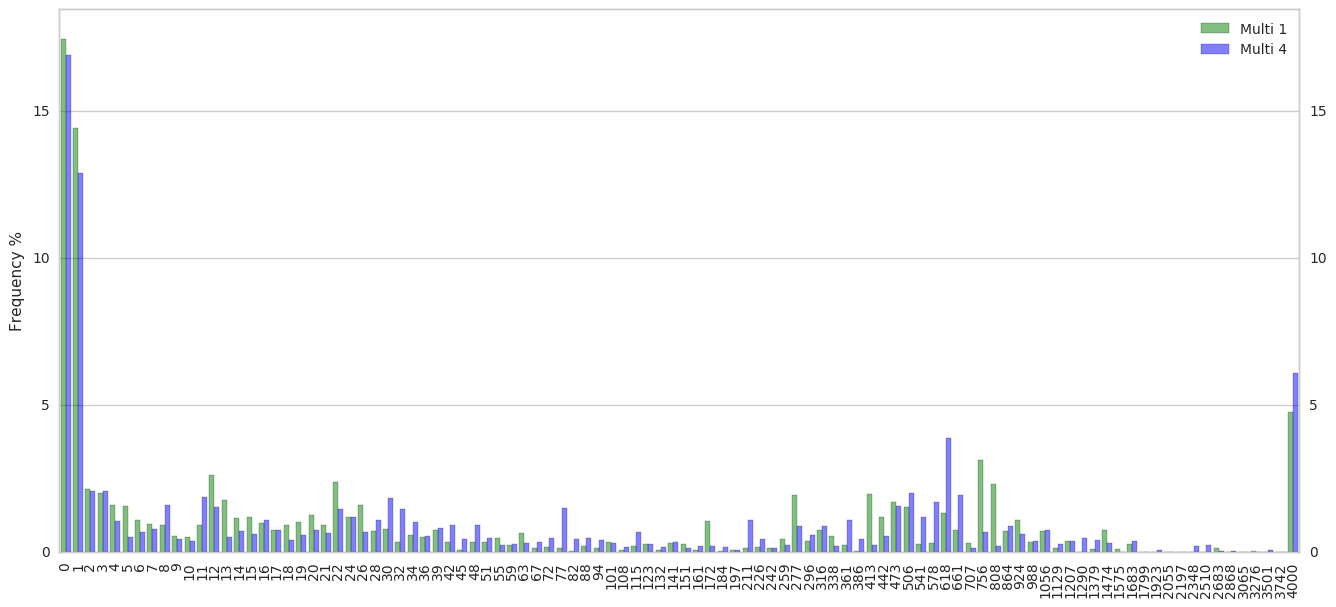

---
#### FX_TAB_REMOTE_NAVIGATION_DELAY_MS (children) Without WebExtensions
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.738</b>.</span>
            

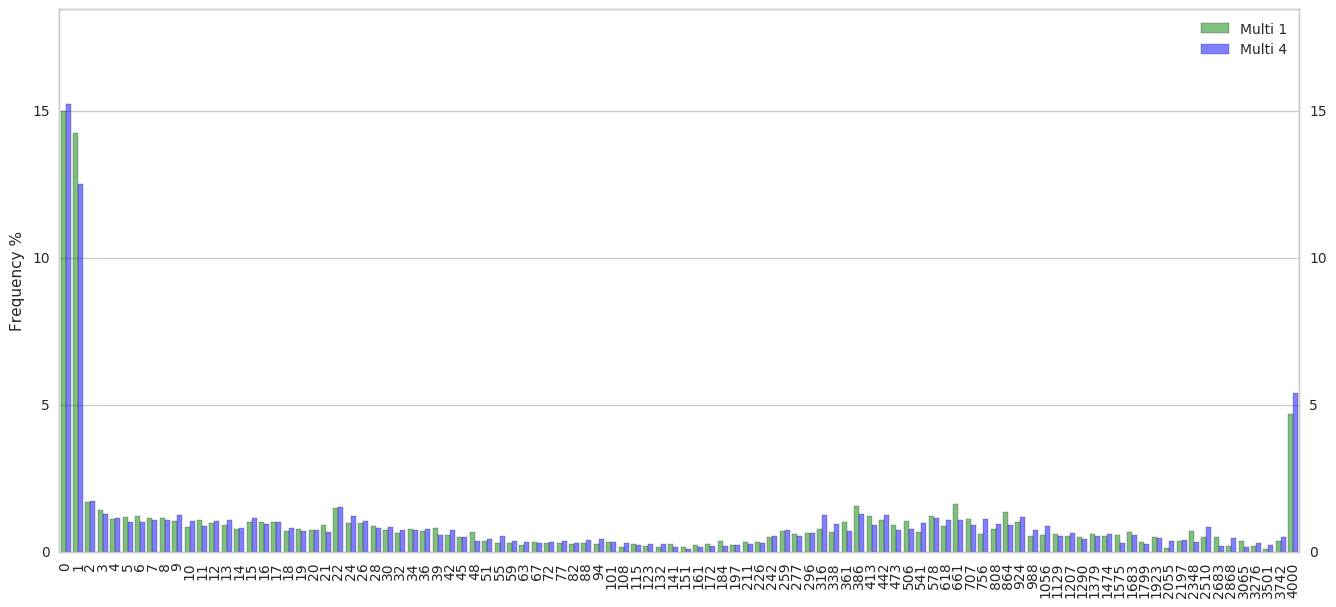

---
#### FX_TAB_REMOTE_NAVIGATION_DELAY_MS (children) MPC=True Addons
Probability the two histograms differ by chance is
            <span style="color:green"><b>0.764</b>.</span>
            

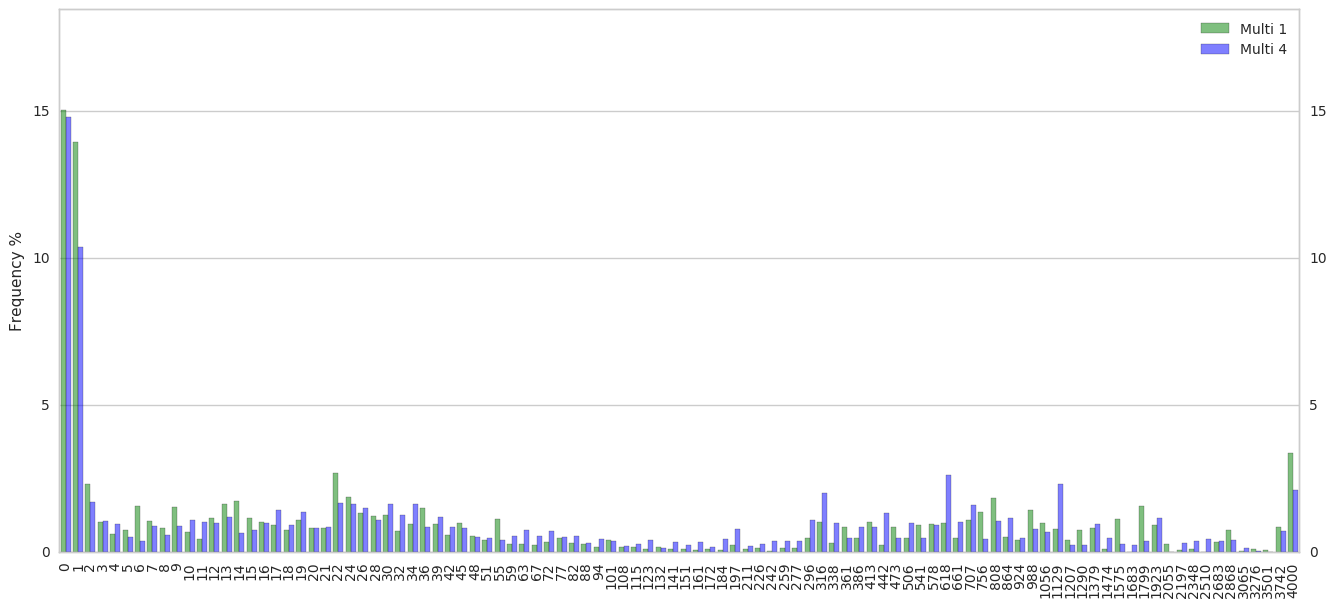

In [133]:
results.extend(compare_tab_groups(t3, t4, 
            "payload/keyedHistograms/FX_TAB_REMOTE_NAVIGATION_DELAY_MS/WebNavigation:LoadURI"))

---

## SlowScripts

### SLOW_SCRIPT_NOTICE_COUNT

In [134]:
results.extend(compare_tab_groups(t3, t4, "payload/histograms/SLOW_SCRIPT_NOTICE_COUNT", count=True))

## 1-3 Tabs

---

# Windows_NT

Comparison for count histogram SLOW_SCRIPT_NOTICE_COUNT:

733 Multi 4 profiles (with webextenisons) have this histogram.
719 Multi 1 profiles (with webextensions) have this histogram.

Comparison for SLOW_SCRIPT_NOTICE_COUNT per hour (with webextensions):

- Median with 1 content process is -0.0827 units different from median with 4 processes.
- This is a relative difference of -8.6%.
- Multi 1 group median is 0.8772, Multi 4 group median is 0.9599.



 (with webextensions) The probability the two histograms differ by chance is
            <span style="color:green"><b>0.616</b>.</span>
            


For cohorts with no webextensions, median with 1 content process is 0.175 units (30.7%) different from median with 4 processes
- This is a relative difference of 30.7%.
- Multi 1 group median is 0.7467, Multi 4 group median is 0.5714.


(without WebExtensions) The probability the two histograms differ by chance is
            <span style="color:green"><b>0.059</b>.</span>
            

---

# Darwin

Comparison for count histogram SLOW_SCRIPT_NOTICE_COUNT:

3 Multi 4 profiles (with webextenisons) have this histogram.
1 Multi 1 profiles (with webextensions) have this histogram.

Comparison for SLOW_SCRIPT_NOTICE_COUNT per hour (with webextensions):

- Median with 1 content process is 0.109 units different from median with 4 processes.
- This is a relative difference of 539.8%.
- Multi 1 group median is 0.1289, Multi 4 group median is 0.02015.



 (with webextensions) The probability the two histograms differ by chance is
            <span style="color:green"><b>0.252</b>.</span>
            


For cohorts with no webextensions, median with 1 content process is 0.0932 units (87.5%) different from median with 4 processes
- This is a relative difference of 87.5%.
- Multi 1 group median is 0.1998, Multi 4 group median is 0.1066.


(without WebExtensions) The probability the two histograms differ by chance is
            <span style="color:green"><b>0.397</b>.</span>
            

## 4+ Tabs

---

# Windows_NT

Comparison for count histogram SLOW_SCRIPT_NOTICE_COUNT:

603 Multi 4 profiles (with webextenisons) have this histogram.
634 Multi 1 profiles (with webextensions) have this histogram.

Comparison for SLOW_SCRIPT_NOTICE_COUNT per hour (with webextensions):

- Median with 1 content process is 0.0559 units different from median with 4 processes.
- This is a relative difference of 20.2%.
- Multi 1 group median is 0.333, Multi 4 group median is 0.277.



 (with webextensions) The probability the two histograms differ by chance is
            <span style="color:green"><b>0.113</b>.</span>
            


For cohorts with no webextensions, median with 1 content process is -0.0092 units (-3.1%) different from median with 4 processes
- This is a relative difference of -3.1%.
- Multi 1 group median is 0.283, Multi 4 group median is 0.2922.


(without WebExtensions) The probability the two histograms differ by chance is
            <span style="color:green"><b>0.821</b>.</span>
            

---

# Darwin

Comparison for count histogram SLOW_SCRIPT_NOTICE_COUNT:

9 Multi 4 profiles (with webextenisons) have this histogram.
5 Multi 1 profiles (with webextensions) have this histogram.

Comparison for SLOW_SCRIPT_NOTICE_COUNT per hour (with webextensions):

- Median with 1 content process is -0.0187 units different from median with 4 processes.
- This is a relative difference of -31.8%.
- Multi 1 group median is 0.04013, Multi 4 group median is 0.0588.



 (with webextensions) The probability the two histograms differ by chance is
            <span style="color:green"><b>0.777</b>.</span>
            


For cohorts with no webextensions, median with 1 content process is 0.0104 units (35.6%) different from median with 4 processes
- This is a relative difference of 35.6%.
- Multi 1 group median is 0.0398, Multi 4 group median is 0.02935.


(without WebExtensions) The probability the two histograms differ by chance is
            <span style="color:green"><b>0.293</b>.</span>
            

### SLOW_SCRIPT_PAGE_COUNT

In [135]:
results.extend(compare_tab_groups(t3, t4, "payload/histograms/SLOW_SCRIPT_PAGE_COUNT", count=True))

## 1-3 Tabs

---

# Windows_NT

Comparison for count histogram SLOW_SCRIPT_PAGE_COUNT:

699 Multi 4 profiles (with webextenisons) have this histogram.
690 Multi 1 profiles (with webextensions) have this histogram.

Comparison for SLOW_SCRIPT_PAGE_COUNT per hour (with webextensions):

- Median with 1 content process is -0.00243 units different from median with 4 processes.
- This is a relative difference of -0.4%.
- Multi 1 group median is 0.5937, Multi 4 group median is 0.5961.



 (with webextensions) The probability the two histograms differ by chance is
            <span style="color:green"><b>0.982</b>.</span>
            


For cohorts with no webextensions, median with 1 content process is 0.159 units (45.0%) different from median with 4 processes
- This is a relative difference of 45.0%.
- Multi 1 group median is 0.5123, Multi 4 group median is 0.3533.


(without WebExtensions) The probability the two histograms differ by chance is
            <span style="color:red"><b>0.009</b>.</span>
            

---

# Darwin

Comparison for count histogram SLOW_SCRIPT_PAGE_COUNT:

3 Multi 4 profiles (with webextenisons) have this histogram.
1 Multi 1 profiles (with webextensions) have this histogram.

Comparison for SLOW_SCRIPT_PAGE_COUNT per hour (with webextensions):

- Median with 1 content process is 0.0443 units different from median with 4 processes.
- This is a relative difference of 219.9%.
- Multi 1 group median is 0.06445, Multi 4 group median is 0.02015.



 (with webextensions) The probability the two histograms differ by chance is
            <span style="color:green"><b>0.256</b>.</span>
            


For cohorts with no webextensions, median with 1 content process is 0.0138 units (29.2%) different from median with 4 processes
- This is a relative difference of 29.2%.
- Multi 1 group median is 0.06094, Multi 4 group median is 0.04717.


(without WebExtensions) The probability the two histograms differ by chance is
            <span style="color:green"><b>0.938</b>.</span>
            

## 4+ Tabs

---

# Windows_NT

Comparison for count histogram SLOW_SCRIPT_PAGE_COUNT:

583 Multi 4 profiles (with webextenisons) have this histogram.
614 Multi 1 profiles (with webextensions) have this histogram.

Comparison for SLOW_SCRIPT_PAGE_COUNT per hour (with webextensions):

- Median with 1 content process is 0.0344 units different from median with 4 processes.
- This is a relative difference of 18.1%.
- Multi 1 group median is 0.2243, Multi 4 group median is 0.1899.



 (with webextensions) The probability the two histograms differ by chance is
            <span style="color:green"><b>0.221</b>.</span>
            


For cohorts with no webextensions, median with 1 content process is -0.0179 units (-8.4%) different from median with 4 processes
- This is a relative difference of -8.4%.
- Multi 1 group median is 0.1955, Multi 4 group median is 0.2134.


(without WebExtensions) The probability the two histograms differ by chance is
            <span style="color:green"><b>0.580</b>.</span>
            

---

# Darwin

Comparison for count histogram SLOW_SCRIPT_PAGE_COUNT:

9 Multi 4 profiles (with webextenisons) have this histogram.
5 Multi 1 profiles (with webextensions) have this histogram.

Comparison for SLOW_SCRIPT_PAGE_COUNT per hour (with webextensions):

- Median with 1 content process is 0.0217 units different from median with 4 processes.
- This is a relative difference of 117.7%.
- Multi 1 group median is 0.04013, Multi 4 group median is 0.01844.



 (with webextensions) The probability the two histograms differ by chance is
            <span style="color:green"><b>0.569</b>.</span>
            


For cohorts with no webextensions, median with 1 content process is 0.00339 units (21.8%) different from median with 4 processes
- This is a relative difference of 21.8%.
- Multi 1 group median is 0.01891, Multi 4 group median is 0.01552.


(without WebExtensions) The probability the two histograms differ by chance is
            <span style="color:green"><b>0.556</b>.</span>
            

---
### SLOW_SCRIPT_NOTIFY_DELAY

In [136]:
results.extend(compare_tab_groups(t3, t4, "payload/histograms/SLOW_SCRIPT_NOTIFY_DELAY", count=True))

## 1-3 Tabs

---

# Windows_NT

Comparison for count histogram SLOW_SCRIPT_NOTIFY_DELAY:

667 Multi 4 profiles (with webextenisons) have this histogram.
661 Multi 1 profiles (with webextensions) have this histogram.

Comparison for SLOW_SCRIPT_NOTIFY_DELAY per hour (with webextensions):

- Median with 1 content process is -2.64 units different from median with 4 processes.
- This is a relative difference of -9.3%.
- Multi 1 group median is 25.75, Multi 4 group median is 28.39.



 (with webextensions) The probability the two histograms differ by chance is
            <span style="color:green"><b>0.791</b>.</span>
            


For cohorts with no webextensions, median with 1 content process is 12.8 units (100.4%) different from median with 4 processes
- This is a relative difference of 100.4%.
- Multi 1 group median is 25.48, Multi 4 group median is 12.72.


(without WebExtensions) The probability the two histograms differ by chance is
            <span style="color:green"><b>0.051</b>.</span>
            

---

# Darwin

Comparison for count histogram SLOW_SCRIPT_NOTIFY_DELAY:

3 Multi 4 profiles (with webextenisons) have this histogram.
1 Multi 1 profiles (with webextensions) have this histogram.

Comparison for SLOW_SCRIPT_NOTIFY_DELAY per hour (with webextensions):

- Median with 1 content process is 0 units different from median with 4 processes.
- This is a relative difference of nan%.
- Multi 1 group median is 0, Multi 4 group median is 0.



 (with webextensions) The probability the two histograms differ by chance is
            <span style="color:green"><b>1.000</b>.</span>
            


For cohorts with no webextensions, median with 1 content process is -0.0381 units (-74.1%) different from median with 4 processes
- This is a relative difference of -74.1%.
- Multi 1 group median is 0.01333, Multi 4 group median is 0.05141.


(without WebExtensions) The probability the two histograms differ by chance is
            <span style="color:green"><b>0.123</b>.</span>
            

## 4+ Tabs

---

# Windows_NT

Comparison for count histogram SLOW_SCRIPT_NOTIFY_DELAY:

564 Multi 4 profiles (with webextenisons) have this histogram.
604 Multi 1 profiles (with webextensions) have this histogram.

Comparison for SLOW_SCRIPT_NOTIFY_DELAY per hour (with webextensions):

- Median with 1 content process is 1.99 units different from median with 4 processes.
- This is a relative difference of 23.7%.
- Multi 1 group median is 10.4, Multi 4 group median is 8.411.



 (with webextensions) The probability the two histograms differ by chance is
            <span style="color:green"><b>0.710</b>.</span>
            


For cohorts with no webextensions, median with 1 content process is 0.0538 units (1.0%) different from median with 4 processes
- This is a relative difference of 1.0%.
- Multi 1 group median is 5.377, Multi 4 group median is 5.323.


(without WebExtensions) The probability the two histograms differ by chance is
            <span style="color:green"><b>0.953</b>.</span>
            

---

# Darwin

Comparison for count histogram SLOW_SCRIPT_NOTIFY_DELAY:

9 Multi 4 profiles (with webextenisons) have this histogram.
4 Multi 1 profiles (with webextensions) have this histogram.

Comparison for SLOW_SCRIPT_NOTIFY_DELAY per hour (with webextensions):

- Median with 1 content process is -0.00771 units different from median with 4 processes.
- This is a relative difference of -100.0%.
- Multi 1 group median is 0, Multi 4 group median is 0.007706.



 (with webextensions) The probability the two histograms differ by chance is
            <span style="color:red"><b>0.000</b>.</span>
            


For cohorts with no webextensions, median with 1 content process is -0.00771 units (-11.9%) different from median with 4 processes
- This is a relative difference of -11.9%.
- Multi 1 group median is 0.0573, Multi 4 group median is 0.06501.


(without WebExtensions) The probability the two histograms differ by chance is
            <span style="color:green"><b>0.731</b>.</span>
            

---
Wrangling summary data together for trending week over week

In [141]:
def get_summary_data(results):
    '''
    Unnests results to from one row for every os, probe, and cohort, 
    creating individual columns for each decile
    '''
    suffix_map = {
        '_1' : 'webextensions-multiBucket1',
        '_4': 'webextensions-multiBucket4',
        '_1_std': 'multiBucket1', 
        '_4_std': 'multiBucket4'
    }
    ret = []
    for result in results:
        tabs = result.pop('tabs')
        for os in result:
            for probe in result[os]:
                for suffix in suffix_map:
                    curr = {'os': os, 'probe':probe, 'cohort':suffix_map[suffix], 'tabs': tabs}
                    curr['n'] = result[os][probe]["n" + suffix]
                    decile = result[os][probe]["dec" + suffix]
                    p = 'pvalue_14_std' if 'std' in suffix else 'pvalue_14'
                    curr['pvalue'] = result[os][probe][p]
                        
                    for i in range(10):
                        curr['decile_{}'.format(i)] = decile[i]
                    ret.append(curr)
    return ret

r = results[:]
s = get_summary_data(r)

In [142]:
s =  pd.DataFrame(s)
cols = ['probe', 'os', 'cohort', 'tabs', 'n', 'pvalue'] + ['decile_{}'.format(i) for i in range(10)]
s = s.sort_values(['probe', 'os', 'cohort', 'tabs'])[cols]
s.head()


probe      os                      cohort  \
34  CYCLE_COLLECTOR_MAX_PAUSE (child)  Darwin                multiBucket1   
50  CYCLE_COLLECTOR_MAX_PAUSE (child)  Darwin                multiBucket1   
32  CYCLE_COLLECTOR_MAX_PAUSE (child)  Darwin                multiBucket4   
48  CYCLE_COLLECTOR_MAX_PAUSE (child)  Darwin                multiBucket4   
35  CYCLE_COLLECTOR_MAX_PAUSE (child)  Darwin  webextensions-multiBucket1   

        tabs     n    pvalue  decile_0  decile_1  decile_2  decile_3  \
34  1-3 Tabs  2676  0.658203       0.0       1.0       1.0       2.0   
50   4+ Tabs  1094  0.953125       0.0       2.0       4.0       5.0   
32  1-3 Tabs  2657  0.658203       0.0       1.0       1.0       2.0   
48   4+ Tabs  1098  0.953125       0.0       2.0       3.0       5.0   
35  1-3 Tabs   148  0.162109       0.0       1.0       2.0       3.0   

    decile_4  decile_5  decile_6  decile_7  decile_8  decile_9  
34       3.0       5.0       6.0       8.0      12.0      24.0  
50       6.0       8.0      12.0      17.0      24.0      57.0  
32       3.0       5.0       6.0       8.0      14.0      29.0  
48       6.0       7.0      10.0      14.0      24.0      57.0  
35       4.0       5.0       6.0       8.0      12.0      24.0

In [145]:
os.system('rm -rf html/ && mkdir html')
s.to_csv("./html/summary_multi_1.csv", index=False)

In [147]:
concerns = s[(s.pvalue <= .05) & (s.n >= 2000)][['probe', 'os', 'cohort', 'tabs', 'n', 'pvalue']]
for c in concerns.iterrows():
    d = c[1]
    if '1' in d.cohort:
        comparison = ("with WebExtensions") if 'webextensions' in d.cohort else "without WebExtensions"
        probe = "<b>" + d.probe + "</b><br>"
        print_with_markdown(probe)
        print_with_markdown(', '.join([d['os'], comparison]))

<b>FX_TAB_REMOTE_NAVIGATION_DELAY_MS (child)</b><br>

Windows_NT, with WebExtensions

<b>FX_TAB_SWITCH_SPINNER_VISIBLE_MS (parent)</b><br>

Windows_NT, without WebExtensions

<b>FX_TAB_SWITCH_SPINNER_VISIBLE_MS (parent)</b><br>

Windows_NT, with WebExtensions

<b>FX_TAB_SWITCH_TOTAL_MS (parent)</b><br>

Windows_NT, without WebExtensions

<b>FX_TAB_SWITCH_TOTAL_MS (parent)</b><br>

Windows_NT, with WebExtensions

<b>FX_TAB_SWITCH_UPDATE_MS (parent)</b><br>

Windows_NT, without WebExtensions

<b>FX_TAB_SWITCH_UPDATE_MS (parent)</b><br>

Windows_NT, with WebExtensions

<b>GC_MAX_PAUSE_MS (child)</b><br>

Windows_NT, without WebExtensions

<b>INPUT_EVENT_RESPONSE_COALESCED_MS (child)</b><br>

Windows_NT, without WebExtensions

<b>INPUT_EVENT_RESPONSE_COALESCED_MS (parent)</b><br>

Windows_NT, without WebExtensions

<b>INPUT_EVENT_RESPONSE_MS (child)</b><br>

Windows_NT, without WebExtensions

<b>MEMORY_TOTAL (parent)</b><br>

Windows_NT, without WebExtensions

<b>MEMORY_VSIZE_MAX_CONTIGUOUS (parent)</b><br>

Windows_NT, with WebExtensions

# Get Top Hang Stacks per Cohort

In [164]:
def get_stacks(subset):
    def yield_ping_stacks(ping):
        for thread in ping["payload"]["threadHangStats"]:
            if thread["name"] != "Gecko":
                continue
            for hang in thread["hangs"]:
                if hang["stack"] and hang["histogram"].get("values"):
                    values = hang["histogram"].get("values")
                    histogram = pd.Series(values.values(), index=map(int, values.keys())).sort_index()
                    min_ms = 100
                    over_min_ms_count = histogram[histogram.index > min_ms].sum()
                    yield (tuple(hang["stack"]), over_min_ms_count)
    return subset.flatMap(yield_ping_stacks).reduceByKey(lambda a, b: a + b).collectAsMap()

In [165]:
wm1 = get_stacks(subset.filter(lambda x: x['cohort'] == WEBEXTENSION_MULTI_1))
wm4 = get_stacks(subset.filter(lambda x: x['cohort'] == WEBEXTENSION_MULTI_4))
m1 = get_stacks(subset.filter(lambda x: x['cohort'] == MULTI_1))
m4 = get_stacks(subset.filter(lambda x: x['cohort'] == MULTI_4))
mpc1 = get_stacks(subset.filter(lambda x: x['cohort'] == MPC_BUCKET_1))
mpc4 = get_stacks(subset.filter(lambda x: x['cohort'] == MPC_BUCKET_4))

In [186]:
def get_top_stacks_per_group(c1, c2, c3, c4, c5, c6, count, 
                             names=['Addons/E10s', 'Addons/NoE10s', 'NoAddons/E10s', 'NoAddons/NoE10s']):
    '''
    Takes the top <count> stacks per group in c1...4, ordered by
    the ordering of the <names> list
    
    returns pandas DF indexed by the stack type
    '''
    c1_total_count = sum(c1.values())
    c2_total_count = sum(c2.values())
    c3_total_count = sum(c3.values())
    c4_total_count = sum(c4.values())
    c5_total_count = sum(c5.values())
    c6_total_count = sum(c6.values())
    result = []
    index = []
    for c, c1_stack_count in Counter(c1).most_common(count):
        row = {}
        c2_stack_count = c2.get(c, 0)
        c3_stack_count = c3.get(c, 0)
        c4_stack_count = c4.get(c, 0)
        c5_stack_count = c5.get(c, 0)
        c6_stack_count = c6.get(c, 0)

        
        row = {names[0]: 100.0 * c1_stack_count / c1_total_count,
               names[1]: 100.0 * c2_stack_count / c2_total_count,
               names[2]: 100.0 * c3_stack_count / c3_total_count,
               names[3]:100.0 * c4_stack_count / c4_total_count,
               names[4]:100.0 * c5_stack_count / c5_total_count,
               names[5]:100.0 * c6_stack_count / c6_total_count
              }
        index.append("<br>".join(reversed(c)))
        result.append(row)
    
    df = pd.DataFrame(result)[names]
    df.index = index
    return df.applymap(lambda x: '{:.2f}'.format(float(x)) + '%')

def heat_map_df(df, color='red', css='background', null_color='white'):
    '''
    Colors in background of a percentage table
    based on value.
    
    returns stylized dataframe (different from pd.Dataframe)
    '''
    color = Color(color)
    dfmax = max(df.applymap(lambda x: float(x.split('%')[0])).max())
    n_colors = int(math.ceil(dfmax))
    gradient = list(reversed(list(color.range_to(Color(null_color),n_colors+1))))
    
    gradient_map = {}
    for i in range(n_colors+1):
        gradient_map[i] = gradient[i]
    
    css_style = lambda x: "%s: %s" % \
       (css, gradient_map[int(math.ceil(float(x.split('%')[0])))])
    df1 = df.style.applymap(css_style)
    return df1

def heatmapify(df):
    '''
    Takes a pandas df and applies heatmap function to cells
    with some cleaner css
    
    returns raw html
    '''


    css_header = '''
    
    <style  type="text/css" >
    
    table {
        font-family:Arial, Helvetica, sans-serif;
        font-size:12px;
        background:#eaebec;
        margin:0 auto;
        border:#ccc 1px solid;

        -moz-border-radius:3px;
        -webkit-border-radius:3px;
        border-radius:3px;

    }

    table th {
        padding:10px 10px 10px 10px;
        border-top:1px solid #fafafa;
        border-bottom:1px solid #e0e0e0;
    }

    table th:first-child {
        text-align: left;
        padding-left:5px;
    }


    table tr {
        text-align: center;
        padding-left:20px;
    }

    table td {
        padding:18px;
        border-top: 1px solid #ffffff;
        border-bottom:1px solid #e0e0e0;
        border-left: 1px solid #e0e0e0;

    }
    
    tr:hover{
        background-color: #CBCDCF;
    }
    '''
    formatted_table = css_header + '\n' + heat_map_df(df).render()\
                                          .split('<style  type="text/css" >')[1]
    return formatted_table

In [187]:


wm1s = get_top_stacks_per_group(wm1, wm4, m1, m4, mpc1, mpc4, 25,
        names = [WEBEXTENSION_MULTI_1, WEBEXTENSION_MULTI_4, MULTI_1, MULTI_4, MPC_BUCKET_1, MPC_BUCKET_4])
wm4s  = get_top_stacks_per_group(wm4, wm1, m1, m4, mpc1, mpc4,25,
        names = [WEBEXTENSION_MULTI_4, WEBEXTENSION_MULTI_1, MULTI_1, MULTI_4, MPC_BUCKET_1, MPC_BUCKET_4])
m1s = get_top_stacks_per_group(m1, m4, wm1, wm4, mpc1, mpc4, 25,
        names = [MULTI_1, MULTI_4, WEBEXTENSION_MULTI_1, WEBEXTENSION_MULTI_4, MPC_BUCKET_1, MPC_BUCKET_4])
m4s = get_top_stacks_per_group(m4, m1, wm1, wm4, mpc1, mpc4, 25,
        names = [MULTI_4, MULTI_1, WEBEXTENSION_MULTI_1, WEBEXTENSION_MULTI_4, MPC_BUCKET_1, MPC_BUCKET_4])

mpc1s = get_top_stacks_per_group(mpc1, mpc4, m4, m1, wm1, wm4, 25,
        names = [MPC_BUCKET_1, MPC_BUCKET_4, MULTI_4, MULTI_1, WEBEXTENSION_MULTI_1, WEBEXTENSION_MULTI_4])
mpc4s = get_top_stacks_per_group(mpc4, mpc1, m4, m1, wm1, wm4, 25,
        names = [MPC_BUCKET_4,MPC_BUCKET_1, MULTI_4, MULTI_1, WEBEXTENSION_MULTI_1, WEBEXTENSION_MULTI_4])




In [175]:
%%bash
pip install colour

  Using cached colour-0.1.4-py2.py3-none-any.whl


You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [188]:
from colour import Color



cohorts = (wm1s, wm4s, m1s, m4s, mpc1s, mpc4s)
filenames = ('wm1.html', 'wm4.html', 'm1.html', 'm4.html', 'mpc1.html', 'mpc4.html')
for i in range(6):
    print filenames[i]
    html = heatmapify(cohorts[i])
    with open('./html/' + filenames[i], 'w') as f:
        f.write(html)




wm1.html
wm4.html
m1.html
m4.html
mpc1.html
mpc4.html


In [185]:
%%bash 
ls html

m1.html
m4.html
mpc1.html
mpc4.html
summary_multi_1.csv
wm1.html
wm4.html
